#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](../../guide/keras/overview.ipynb) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common tecniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data and can be used to download CSVs into a dataframe.

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [8]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the ditributions?
    * Yes the positive examples contain a much higher rate of extreme values.

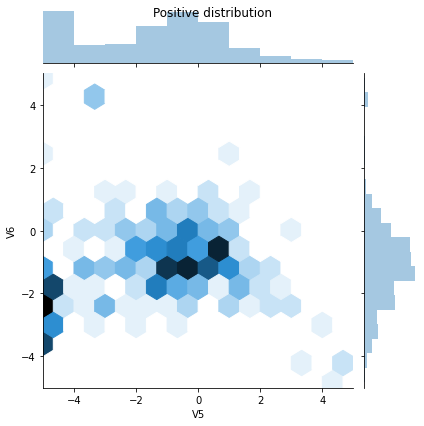

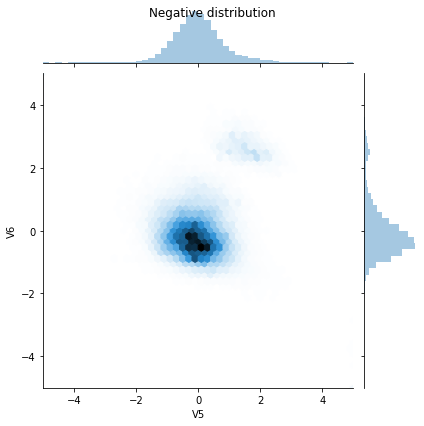

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than than a random negative sample.

Note: Accuracy is not a helpful metric for this task. You can 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [14]:
model.predict(train_features[:10])

array([[0.82385933],
       [0.8441988 ],
       [0.7792701 ],
       [0.7831071 ],
       [0.73743796],
       [0.7864496 ],
       [0.6761932 ],
       [0.6784013 ],
       [0.936861  ],
       [0.85547096]], dtype=float32)

### Optional: Set the correct initial bias.

These are initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.5423


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [17]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00154017],
       [0.00208564],
       [0.00250091],
       [0.00191513],
       [0.00180747],
       [0.00329405],
       [0.00339067],
       [0.00167786],
       [0.00134785],
       [0.0020147 ]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0129


This initial loss is about 50 times less than if would have been with naive initilization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

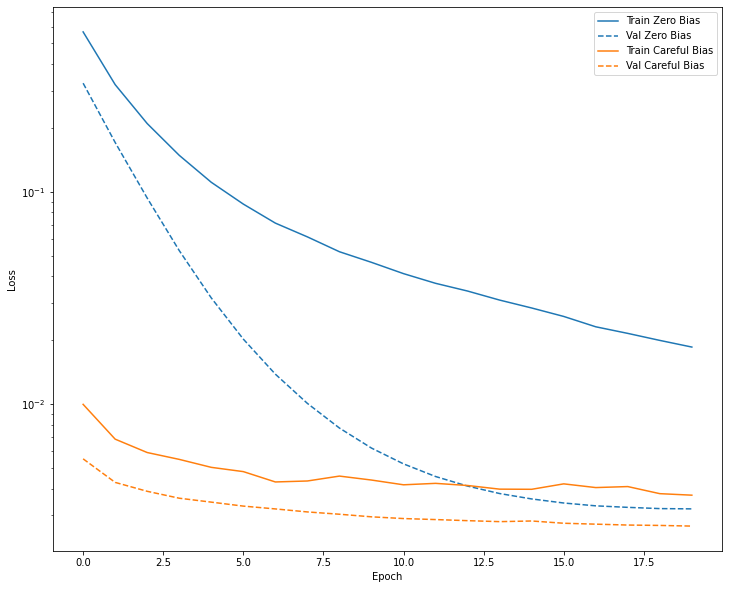

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 182276 samples, validate on 45569 samples
Epoch 1/100


  2048/182276 [..............................] - ETA: 1:43 - loss: 0.0085 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6977

 26624/182276 [===>..........................] - ETA: 7s - loss: 0.0125 - tp: 0.0000e+00 - fp: 1.0000 - tn: 26585.0000 - fn: 38.0000 - accuracy: 0.9985 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5770    

 51200/182276 [=======>......................] - ETA: 3s - loss: 0.0122 - tp: 0.0000e+00 - fp: 5.0000 - tn: 51112.0000 - fn: 83.0000 - accuracy: 0.9983 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6859

 75776/182276 [===========>..................] - ETA: 1s - loss: 0.0115 - tp: 0.0000e+00 - fp: 5.0000 - tn: 75653.0000 - fn: 118.0000 - accuracy: 0.9984 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6861

100352/182276 [===============>..............] - ETA: 1s - loss: 0.0109 - tp: 0.0000e+00 - fp: 11.0000 - tn: 100191.0000 - fn: 150.0000 - accuracy: 0.9984 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7059

122880/182276 [===================>..........] - ETA: 0s - loss: 0.0110 - tp: 5.0000 - fp: 12.0000 - tn: 122668.0000 - fn: 195.0000 - accuracy: 0.9983 - precision: 0.2941 - recall: 0.0250 - auc: 0.7333            

147456/182276 [=======================>......] - ETA: 0s - loss: 0.0104 - tp: 12.0000 - fp: 16.0000 - tn: 147198.0000 - fn: 230.0000 - accuracy: 0.9983 - precision: 0.4286 - recall: 0.0496 - auc: 0.7645

172032/182276 [===========================>..] - ETA: 0s - loss: 0.0099 - tp: 21.0000 - fp: 18.0000 - tn: 171733.0000 - fn: 260.0000 - accuracy: 0.9984 - precision: 0.5385 - recall: 0.0747 - auc: 0.7840

182276/182276 [==============================] - 2s 12us/sample - loss: 0.0099 - tp: 27.0000 - fp: 20.0000 - tn: 181951.0000 - fn: 278.0000 - accuracy: 0.9984 - precision: 0.5745 - recall: 0.0885 - auc: 0.7923 - val_loss: 0.0053 - val_tp: 27.0000 - val_fp: 4.0000 - val_tn: 45492.0000 - val_fn: 46.0000 - val_accuracy: 0.9989 - val_precision: 0.8710 - val_recall: 0.3699 - val_auc: 0.9239


Epoch 2/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0084 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 5.0000 - accuracy: 0.9976 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8939

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.0057 - tp: 14.0000 - fp: 2.0000 - tn: 26580.0000 - fn: 28.0000 - accuracy: 0.9989 - precision: 0.8750 - recall: 0.3333 - auc: 0.9357             

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.0063 - tp: 32.0000 - fp: 10.0000 - tn: 51102.0000 - fn: 56.0000 - accuracy: 0.9987 - precision: 0.7619 - recall: 0.3636 - auc: 0.9385

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.0064 - tp: 41.0000 - fp: 14.0000 - tn: 75640.0000 - fn: 81.0000 - accuracy: 0.9987 - precision: 0.7455 - recall: 0.3361 - auc: 0.9339

100352/182276 [===============>..............] - ETA: 0s - loss: 0.0063 - tp: 61.0000 - fp: 15.0000 - tn: 100170.0000 - fn: 106.0000 - accuracy: 0.9988 - precision: 0.8026 - recall: 0.3653 - auc: 0.9352

126976/182276 [===================>..........] - ETA: 0s - loss: 0.0065 - tp: 81.0000 - fp: 18.0000 - tn: 126744.0000 - fn: 133.0000 - accuracy: 0.9988 - precision: 0.8182 - recall: 0.3785 - auc: 0.9247

151552/182276 [=======================>......] - ETA: 0s - loss: 0.0064 - tp: 103.0000 - fp: 21.0000 - tn: 151272.0000 - fn: 156.0000 - accuracy: 0.9988 - precision: 0.8306 - recall: 0.3977 - auc: 0.9196

176128/182276 [===========================>..] - ETA: 0s - loss: 0.0065 - tp: 115.0000 - fp: 27.0000 - tn: 175805.0000 - fn: 181.0000 - accuracy: 0.9988 - precision: 0.8099 - recall: 0.3885 - auc: 0.9086

182276/182276 [==============================] - 0s 3us/sample - loss: 0.0065 - tp: 117.0000 - fp: 29.0000 - tn: 181942.0000 - fn: 188.0000 - accuracy: 0.9988 - precision: 0.8014 - recall: 0.3836 - auc: 0.9096 - val_loss: 0.0043 - val_tp: 38.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 35.0000 - val_accuracy: 0.9991 - val_precision: 0.8636 - val_recall: 0.5205 - val_auc: 0.9242


Epoch 3/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0039 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9978

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 23.0000 - fp: 5.0000 - tn: 26578.0000 - fn: 18.0000 - accuracy: 0.9991 - precision: 0.8214 - recall: 0.5610 - auc: 0.9370 

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.0060 - tp: 47.0000 - fp: 10.0000 - tn: 51096.0000 - fn: 47.0000 - accuracy: 0.9989 - precision: 0.8246 - recall: 0.5000 - auc: 0.9227

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.0057 - tp: 67.0000 - fp: 11.0000 - tn: 75630.0000 - fn: 68.0000 - accuracy: 0.9990 - precision: 0.8590 - recall: 0.4963 - auc: 0.9306

100352/182276 [===============>..............] - ETA: 0s - loss: 0.0059 - tp: 82.0000 - fp: 14.0000 - tn: 100162.0000 - fn: 94.0000 - accuracy: 0.9989 - precision: 0.8542 - recall: 0.4659 - auc: 0.9290

124928/182276 [===================>..........] - ETA: 0s - loss: 0.0060 - tp: 104.0000 - fp: 18.0000 - tn: 124694.0000 - fn: 112.0000 - accuracy: 0.9990 - precision: 0.8525 - recall: 0.4815 - auc: 0.9184

149504/182276 [=======================>......] - ETA: 0s - loss: 0.0058 - tp: 128.0000 - fp: 22.0000 - tn: 149224.0000 - fn: 130.0000 - accuracy: 0.9990 - precision: 0.8533 - recall: 0.4961 - auc: 0.9237

174080/182276 [===========================>..] - ETA: 0s - loss: 0.0058 - tp: 144.0000 - fp: 26.0000 - tn: 173759.0000 - fn: 151.0000 - accuracy: 0.9990 - precision: 0.8471 - recall: 0.4881 - auc: 0.9194

182276/182276 [==============================] - 0s 3us/sample - loss: 0.0058 - tp: 149.0000 - fp: 26.0000 - tn: 181945.0000 - fn: 156.0000 - accuracy: 0.9990 - precision: 0.8514 - recall: 0.4885 - auc: 0.9153 - val_loss: 0.0038 - val_tp: 47.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8868 - val_recall: 0.6438 - val_auc: 0.9175


Epoch 4/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0077 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.8301

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.0059 - tp: 27.0000 - fp: 3.0000 - tn: 26571.0000 - fn: 23.0000 - accuracy: 0.9990 - precision: 0.9000 - recall: 0.5400 - auc: 0.9178 

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.0055 - tp: 47.0000 - fp: 11.0000 - tn: 51105.0000 - fn: 37.0000 - accuracy: 0.9991 - precision: 0.8103 - recall: 0.5595 - auc: 0.9205

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.0057 - tp: 62.0000 - fp: 21.0000 - tn: 75634.0000 - fn: 59.0000 - accuracy: 0.9989 - precision: 0.7470 - recall: 0.5124 - auc: 0.9237

100352/182276 [===============>..............] - ETA: 0s - loss: 0.0056 - tp: 80.0000 - fp: 23.0000 - tn: 100163.0000 - fn: 86.0000 - accuracy: 0.9989 - precision: 0.7767 - recall: 0.4819 - auc: 0.9259

124928/182276 [===================>..........] - ETA: 0s - loss: 0.0055 - tp: 95.0000 - fp: 27.0000 - tn: 124696.0000 - fn: 110.0000 - accuracy: 0.9989 - precision: 0.7787 - recall: 0.4634 - auc: 0.9201

149504/182276 [=======================>......] - ETA: 0s - loss: 0.0055 - tp: 120.0000 - fp: 28.0000 - tn: 149223.0000 - fn: 133.0000 - accuracy: 0.9989 - precision: 0.8108 - recall: 0.4743 - auc: 0.9191

174080/182276 [===========================>..] - ETA: 0s - loss: 0.0055 - tp: 140.0000 - fp: 34.0000 - tn: 173754.0000 - fn: 152.0000 - accuracy: 0.9989 - precision: 0.8046 - recall: 0.4795 - auc: 0.9212

182276/182276 [==============================] - 0s 3us/sample - loss: 0.0055 - tp: 145.0000 - fp: 34.0000 - tn: 181937.0000 - fn: 160.0000 - accuracy: 0.9989 - precision: 0.8101 - recall: 0.4754 - auc: 0.9179 - val_loss: 0.0036 - val_tp: 49.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8909 - val_recall: 0.6712 - val_auc: 0.9175


Epoch 5/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0097 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2039.0000 - fn: 5.0000 - accuracy: 0.9976 - precision: 1.0000 - recall: 0.4444 - auc: 0.8870

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.0051 - tp: 32.0000 - fp: 6.0000 - tn: 26566.0000 - fn: 20.0000 - accuracy: 0.9990 - precision: 0.8421 - recall: 0.6154 - auc: 0.9313 

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.0051 - tp: 49.0000 - fp: 13.0000 - tn: 51098.0000 - fn: 40.0000 - accuracy: 0.9990 - precision: 0.7903 - recall: 0.5506 - auc: 0.9367

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.0056 - tp: 62.0000 - fp: 16.0000 - tn: 75633.0000 - fn: 65.0000 - accuracy: 0.9989 - precision: 0.7949 - recall: 0.4882 - auc: 0.9115

100352/182276 [===============>..............] - ETA: 0s - loss: 0.0054 - tp: 86.0000 - fp: 19.0000 - tn: 100163.0000 - fn: 84.0000 - accuracy: 0.9990 - precision: 0.8190 - recall: 0.5059 - auc: 0.9159

124928/182276 [===================>..........] - ETA: 0s - loss: 0.0051 - tp: 105.0000 - fp: 22.0000 - tn: 124700.0000 - fn: 101.0000 - accuracy: 0.9990 - precision: 0.8268 - recall: 0.5097 - auc: 0.9182

149504/182276 [=======================>......] - ETA: 0s - loss: 0.0050 - tp: 130.0000 - fp: 24.0000 - tn: 149232.0000 - fn: 118.0000 - accuracy: 0.9991 - precision: 0.8442 - recall: 0.5242 - auc: 0.9218

174080/182276 [===========================>..] - ETA: 0s - loss: 0.0051 - tp: 157.0000 - fp: 29.0000 - tn: 173756.0000 - fn: 138.0000 - accuracy: 0.9990 - precision: 0.8441 - recall: 0.5322 - auc: 0.9238

182276/182276 [==============================] - 1s 3us/sample - loss: 0.0050 - tp: 162.0000 - fp: 31.0000 - tn: 181940.0000 - fn: 143.0000 - accuracy: 0.9990 - precision: 0.8394 - recall: 0.5311 - auc: 0.9263 - val_loss: 0.0034 - val_tp: 51.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 22.0000 - val_accuracy: 0.9994 - val_precision: 0.8947 - val_recall: 0.6986 - val_auc: 0.9175


Epoch 6/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0023 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 1.0000

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.0047 - tp: 28.0000 - fp: 4.0000 - tn: 26570.0000 - fn: 22.0000 - accuracy: 0.9990 - precision: 0.8750 - recall: 0.5600 - auc: 0.9490 

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.0047 - tp: 40.0000 - fp: 5.0000 - tn: 51115.0000 - fn: 40.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.5000 - auc: 0.9236

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.0047 - tp: 68.0000 - fp: 9.0000 - tn: 75645.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.8831 - recall: 0.5574 - auc: 0.9331

100352/182276 [===============>..............] - ETA: 0s - loss: 0.0043 - tp: 94.0000 - fp: 12.0000 - tn: 100180.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8868 - recall: 0.5875 - auc: 0.9394

124928/182276 [===================>..........] - ETA: 0s - loss: 0.0044 - tp: 123.0000 - fp: 17.0000 - tn: 124704.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.8786 - recall: 0.5942 - auc: 0.9335

149504/182276 [=======================>......] - ETA: 0s - loss: 0.0044 - tp: 148.0000 - fp: 23.0000 - tn: 149236.0000 - fn: 97.0000 - accuracy: 0.9992 - precision: 0.8655 - recall: 0.6041 - auc: 0.9355

174080/182276 [===========================>..] - ETA: 0s - loss: 0.0047 - tp: 168.0000 - fp: 28.0000 - tn: 173761.0000 - fn: 123.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5773 - auc: 0.9231

182276/182276 [==============================] - 0s 3us/sample - loss: 0.0049 - tp: 176.0000 - fp: 34.0000 - tn: 181937.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8381 - recall: 0.5770 - auc: 0.9216 - val_loss: 0.0033 - val_tp: 50.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.8929 - val_recall: 0.6849 - val_auc: 0.9175


Epoch 7/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0079 - tp: 5.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.7143 - auc: 0.8560

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.0055 - tp: 32.0000 - fp: 5.0000 - tn: 26562.0000 - fn: 25.0000 - accuracy: 0.9989 - precision: 0.8649 - recall: 0.5614 - auc: 0.9375 

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.0056 - tp: 54.0000 - fp: 10.0000 - tn: 51091.0000 - fn: 45.0000 - accuracy: 0.9989 - precision: 0.8438 - recall: 0.5455 - auc: 0.9128

 73728/182276 [===========>..................] - ETA: 0s - loss: 0.0048 - tp: 69.0000 - fp: 11.0000 - tn: 73590.0000 - fn: 58.0000 - accuracy: 0.9991 - precision: 0.8625 - recall: 0.5433 - auc: 0.9200

 98304/182276 [===============>..............] - ETA: 0s - loss: 0.0048 - tp: 97.0000 - fp: 16.0000 - tn: 98114.0000 - fn: 77.0000 - accuracy: 0.9991 - precision: 0.8584 - recall: 0.5575 - auc: 0.9270

122880/182276 [===================>..........] - ETA: 0s - loss: 0.0047 - tp: 112.0000 - fp: 22.0000 - tn: 122655.0000 - fn: 91.0000 - accuracy: 0.9991 - precision: 0.8358 - recall: 0.5517 - auc: 0.9225

147456/182276 [=======================>......] - ETA: 0s - loss: 0.0048 - tp: 138.0000 - fp: 27.0000 - tn: 147180.0000 - fn: 111.0000 - accuracy: 0.9991 - precision: 0.8364 - recall: 0.5542 - auc: 0.9185

172032/182276 [===========================>..] - ETA: 0s - loss: 0.0050 - tp: 156.0000 - fp: 31.0000 - tn: 171715.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8342 - recall: 0.5455 - auc: 0.9166

182276/182276 [==============================] - 0s 3us/sample - loss: 0.0050 - tp: 166.0000 - fp: 32.0000 - tn: 181939.0000 - fn: 139.0000 - accuracy: 0.9991 - precision: 0.8384 - recall: 0.5443 - auc: 0.9152 - val_loss: 0.0031 - val_tp: 50.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 23.0000 - val_accuracy: 0.9994 - val_precision: 0.8929 - val_recall: 0.6849 - val_auc: 0.9175


Epoch 8/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0044 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.9992

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 21.0000 - fp: 6.0000 - tn: 24534.0000 - fn: 15.0000 - accuracy: 0.9991 - precision: 0.7778 - recall: 0.5833 - auc: 0.9857 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.0036 - tp: 44.0000 - fp: 10.0000 - tn: 47022.0000 - fn: 28.0000 - accuracy: 0.9992 - precision: 0.8148 - recall: 0.6111 - auc: 0.9507

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.0037 - tp: 67.0000 - fp: 11.0000 - tn: 71557.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.8590 - recall: 0.5982 - auc: 0.9456

 96256/182276 [==============>...............] - ETA: 0s - loss: 0.0039 - tp: 84.0000 - fp: 14.0000 - tn: 96092.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.5600 - auc: 0.9425

120832/182276 [==================>...........] - ETA: 0s - loss: 0.0042 - tp: 114.0000 - fp: 18.0000 - tn: 120615.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.5729 - auc: 0.9311

145408/182276 [======================>.......] - ETA: 0s - loss: 0.0044 - tp: 139.0000 - fp: 22.0000 - tn: 145141.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8634 - recall: 0.5673 - auc: 0.9233

169984/182276 [==========================>...] - ETA: 0s - loss: 0.0045 - tp: 164.0000 - fp: 26.0000 - tn: 169674.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8632 - recall: 0.5775 - auc: 0.9196

182276/182276 [==============================] - 0s 3us/sample - loss: 0.0044 - tp: 179.0000 - fp: 28.0000 - tn: 181943.0000 - fn: 126.0000 - accuracy: 0.9992 - precision: 0.8647 - recall: 0.5869 - auc: 0.9218 - val_loss: 0.0031 - val_tp: 54.0000 - val_fp: 7.0000 - val_tn: 45489.0000 - val_fn: 19.0000 - val_accuracy: 0.9994 - val_precision: 0.8852 - val_recall: 0.7397 - val_auc: 0.9175


Epoch 9/100
  2048/182276 [..............................] - ETA: 0s - loss: 7.0566e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.0041 - tp: 27.0000 - fp: 5.0000 - tn: 26576.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8438 - recall: 0.6279 - auc: 0.9174         

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.0035 - tp: 53.0000 - fp: 7.0000 - tn: 51113.0000 - fn: 27.0000 - accuracy: 0.9993 - precision: 0.8833 - recall: 0.6625 - auc: 0.9429

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.0033 - tp: 73.0000 - fp: 9.0000 - tn: 75654.0000 - fn: 40.0000 - accuracy: 0.9994 - precision: 0.8902 - recall: 0.6460 - auc: 0.9417

100352/182276 [===============>..............] - ETA: 0s - loss: 0.0035 - tp: 97.0000 - fp: 10.0000 - tn: 100187.0000 - fn: 58.0000 - accuracy: 0.9993 - precision: 0.9065 - recall: 0.6258 - auc: 0.9346

124928/182276 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 118.0000 - fp: 14.0000 - tn: 124722.0000 - fn: 74.0000 - accuracy: 0.9993 - precision: 0.8939 - recall: 0.6146 - auc: 0.9313

149504/182276 [=======================>......] - ETA: 0s - loss: 0.0036 - tp: 148.0000 - fp: 16.0000 - tn: 149250.0000 - fn: 90.0000 - accuracy: 0.9993 - precision: 0.9024 - recall: 0.6218 - auc: 0.9339

174080/182276 [===========================>..] - ETA: 0s - loss: 0.0039 - tp: 178.0000 - fp: 23.0000 - tn: 173769.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8856 - recall: 0.6181 - auc: 0.9278

182276/182276 [==============================] - 0s 3us/sample - loss: 0.0039 - tp: 188.0000 - fp: 24.0000 - tn: 181947.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8868 - recall: 0.6164 - auc: 0.9302 - val_loss: 0.0030 - val_tp: 57.0000 - val_fp: 7.0000 - val_tn: 45489.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8906 - val_recall: 0.7808 - val_auc: 0.9175


Epoch 10/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0083 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.8978

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.0049 - tp: 27.0000 - fp: 6.0000 - tn: 26568.0000 - fn: 23.0000 - accuracy: 0.9989 - precision: 0.8182 - recall: 0.5400 - auc: 0.9386 

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.0048 - tp: 55.0000 - fp: 9.0000 - tn: 51096.0000 - fn: 40.0000 - accuracy: 0.9990 - precision: 0.8594 - recall: 0.5789 - auc: 0.9354

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 79.0000 - fp: 14.0000 - tn: 75630.0000 - fn: 53.0000 - accuracy: 0.9991 - precision: 0.8495 - recall: 0.5985 - auc: 0.9495

 98304/182276 [===============>..............] - ETA: 0s - loss: 0.0046 - tp: 97.0000 - fp: 20.0000 - tn: 98113.0000 - fn: 74.0000 - accuracy: 0.9990 - precision: 0.8291 - recall: 0.5673 - auc: 0.9432

120832/182276 [==================>...........] - ETA: 0s - loss: 0.0046 - tp: 123.0000 - fp: 23.0000 - tn: 120596.0000 - fn: 90.0000 - accuracy: 0.9991 - precision: 0.8425 - recall: 0.5775 - auc: 0.9378

145408/182276 [======================>.......] - ETA: 0s - loss: 0.0045 - tp: 148.0000 - fp: 30.0000 - tn: 145130.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8315 - recall: 0.5968 - auc: 0.9404

169984/182276 [==========================>...] - ETA: 0s - loss: 0.0044 - tp: 172.0000 - fp: 34.0000 - tn: 169663.0000 - fn: 115.0000 - accuracy: 0.9991 - precision: 0.8350 - recall: 0.5993 - auc: 0.9396

182276/182276 [==============================] - 0s 3us/sample - loss: 0.0044 - tp: 183.0000 - fp: 37.0000 - tn: 181934.0000 - fn: 122.0000 - accuracy: 0.9991 - precision: 0.8318 - recall: 0.6000 - auc: 0.9382 - val_loss: 0.0029 - val_tp: 54.0000 - val_fp: 6.0000 - val_tn: 45490.0000 - val_fn: 19.0000 - val_accuracy: 0.9995 - val_precision: 0.9000 - val_recall: 0.7397 - val_auc: 0.9175


Epoch 11/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0093 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.2500 - auc: 0.7482

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.0042 - tp: 29.0000 - fp: 3.0000 - tn: 26574.0000 - fn: 18.0000 - accuracy: 0.9992 - precision: 0.9062 - recall: 0.6170 - auc: 0.9352 

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.0048 - tp: 53.0000 - fp: 10.0000 - tn: 51098.0000 - fn: 39.0000 - accuracy: 0.9990 - precision: 0.8413 - recall: 0.5761 - auc: 0.9229

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.0044 - tp: 77.0000 - fp: 17.0000 - tn: 75628.0000 - fn: 54.0000 - accuracy: 0.9991 - precision: 0.8191 - recall: 0.5878 - auc: 0.9303

100352/182276 [===============>..............] - ETA: 0s - loss: 0.0042 - tp: 104.0000 - fp: 20.0000 - tn: 100157.0000 - fn: 71.0000 - accuracy: 0.9991 - precision: 0.8387 - recall: 0.5943 - auc: 0.9391

124928/182276 [===================>..........] - ETA: 0s - loss: 0.0041 - tp: 124.0000 - fp: 20.0000 - tn: 124695.0000 - fn: 89.0000 - accuracy: 0.9991 - precision: 0.8611 - recall: 0.5822 - auc: 0.9381

149504/182276 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 153.0000 - fp: 22.0000 - tn: 149228.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8743 - recall: 0.6024 - auc: 0.9361

174080/182276 [===========================>..] - ETA: 0s - loss: 0.0039 - tp: 180.0000 - fp: 26.0000 - tn: 173759.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8738 - recall: 0.6102 - auc: 0.9364

182276/182276 [==============================] - 0s 3us/sample - loss: 0.0039 - tp: 185.0000 - fp: 26.0000 - tn: 181945.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8768 - recall: 0.6066 - auc: 0.9352 - val_loss: 0.0029 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45489.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.8889 - val_recall: 0.7671 - val_auc: 0.9175


Epoch 12/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0011 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

 28672/182276 [===>..........................] - ETA: 0s - loss: 0.0033 - tp: 33.0000 - fp: 7.0000 - tn: 28621.0000 - fn: 11.0000 - accuracy: 0.9994 - precision: 0.8250 - recall: 0.7500 - auc: 0.9310     

 53248/182276 [=======>......................] - ETA: 0s - loss: 0.0038 - tp: 50.0000 - fp: 11.0000 - tn: 53161.0000 - fn: 26.0000 - accuracy: 0.9993 - precision: 0.8197 - recall: 0.6579 - auc: 0.9068

 77824/182276 [===========>..................] - ETA: 0s - loss: 0.0034 - tp: 80.0000 - fp: 13.0000 - tn: 77694.0000 - fn: 37.0000 - accuracy: 0.9994 - precision: 0.8602 - recall: 0.6838 - auc: 0.9351

102400/182276 [===============>..............] - ETA: 0s - loss: 0.0035 - tp: 106.0000 - fp: 15.0000 - tn: 102228.0000 - fn: 51.0000 - accuracy: 0.9994 - precision: 0.8760 - recall: 0.6752 - auc: 0.9355

126976/182276 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 135.0000 - fp: 24.0000 - tn: 126744.0000 - fn: 73.0000 - accuracy: 0.9992 - precision: 0.8491 - recall: 0.6490 - auc: 0.9318

149504/182276 [=======================>......] - ETA: 0s - loss: 0.0039 - tp: 162.0000 - fp: 29.0000 - tn: 149223.0000 - fn: 90.0000 - accuracy: 0.9992 - precision: 0.8482 - recall: 0.6429 - auc: 0.9296

172032/182276 [===========================>..] - ETA: 0s - loss: 0.0039 - tp: 181.0000 - fp: 32.0000 - tn: 171715.0000 - fn: 104.0000 - accuracy: 0.9992 - precision: 0.8498 - recall: 0.6351 - auc: 0.9307

Restoring model weights from the end of the best epoch.
182276/182276 [==============================] - 0s 3us/sample - loss: 0.0039 - tp: 195.0000 - fp: 33.0000 - tn: 181938.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8553 - recall: 0.6393 - auc: 0.9336 - val_loss: 0.0028 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 45489.0000 - val_fn: 17.0000 - val_accuracy: 0.9995 - val_precision: 0.8889 - val_recall: 0.7671 - val_auc: 0.9175


Epoch 00012: early stopping


### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [25]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


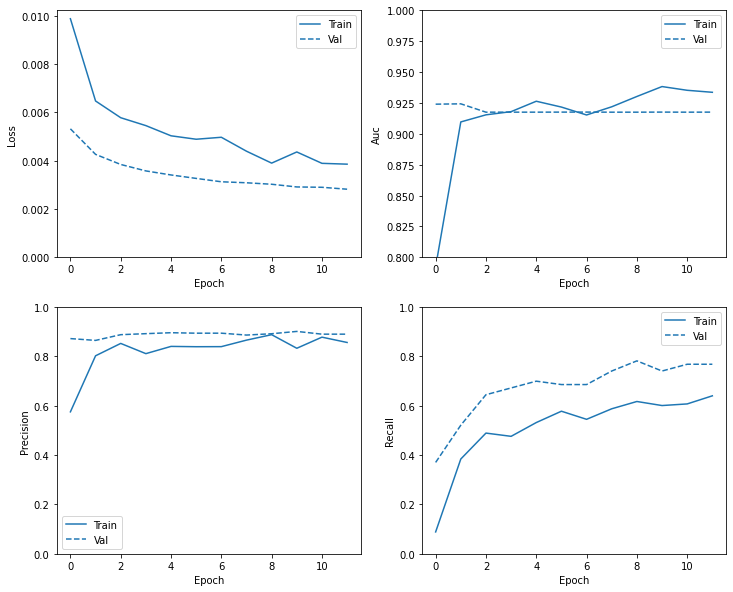

In [26]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.005530094987738993
tp :  51.0
fp :  7.0
tn :  56841.0
fn :  63.0
accuracy :  0.99877113
precision :  0.87931037
recall :  0.4473684
auc :  0.9161636

Legitimate Transactions Detected (True Negatives):  56841
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  63
Fraudulent Transactions Detected (True Positives):  51
Total Fraudulent Transactions:  114


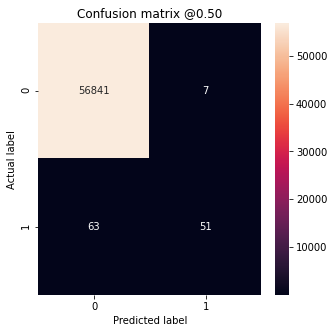

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

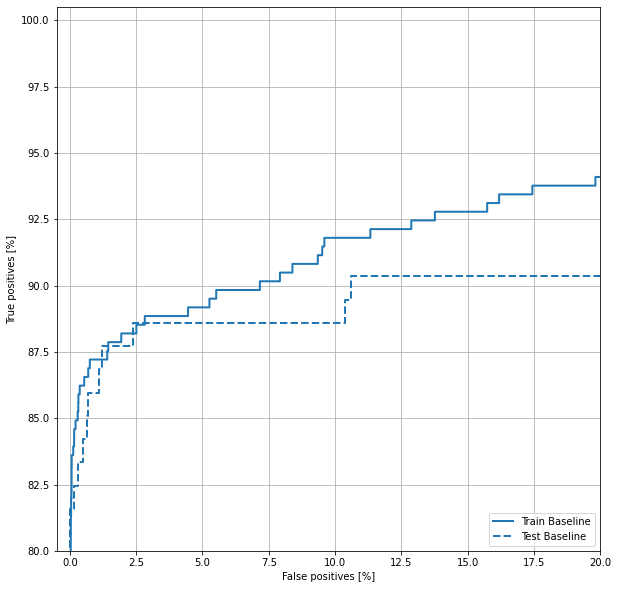

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fradulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [33]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train on 182276 samples, validate on 45569 samples
Epoch 1/100


  2048/182276 [..............................] - ETA: 1:50 - loss: 1.2945 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9627

 24576/182276 [===>..........................] - ETA: 8s - loss: 2.8856 - tp: 0.0000e+00 - fp: 2.0000 - tn: 24533.0000 - fn: 41.0000 - accuracy: 0.9983 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6516    

 47104/182276 [======>.......................] - ETA: 3s - loss: 2.6362 - tp: 1.0000 - fp: 7.0000 - tn: 47019.0000 - fn: 77.0000 - accuracy: 0.9982 - precision: 0.1250 - recall: 0.0128 - auc: 0.7143            

 69632/182276 [==========>...................] - ETA: 2s - loss: 2.4018 - tp: 6.0000 - fp: 13.0000 - tn: 69503.0000 - fn: 110.0000 - accuracy: 0.9982 - precision: 0.3158 - recall: 0.0517 - auc: 0.7360

 92160/182276 [==============>...............] - ETA: 1s - loss: 2.1524 - tp: 17.0000 - fp: 21.0000 - tn: 91988.0000 - fn: 134.0000 - accuracy: 0.9983 - precision: 0.4474 - recall: 0.1126 - auc: 0.7623

114688/182276 [=================>............] - ETA: 0s - loss: 2.0776 - tp: 20.0000 - fp: 30.0000 - tn: 114467.0000 - fn: 171.0000 - accuracy: 0.9982 - precision: 0.4000 - recall: 0.1047 - auc: 0.7811

137216/182276 [=====================>........] - ETA: 0s - loss: 1.9299 - tp: 32.0000 - fp: 45.0000 - tn: 136944.0000 - fn: 195.0000 - accuracy: 0.9983 - precision: 0.4156 - recall: 0.1410 - auc: 0.7987

159744/182276 [=========================>....] - ETA: 0s - loss: 1.8185 - tp: 44.0000 - fp: 62.0000 - tn: 159418.0000 - fn: 220.0000 - accuracy: 0.9982 - precision: 0.4151 - recall: 0.1667 - auc: 0.8126

182272/182276 [============================>.] - ETA: 0s - loss: 1.7410 - tp: 62.0000 - fp: 76.0000 - tn: 181891.0000 - fn: 243.0000 - accuracy: 0.9982 - precision: 0.4493 - recall: 0.2033 - auc: 0.8208

182276/182276 [==============================] - 2s 13us/sample - loss: 1.7409 - tp: 62.0000 - fp: 76.0000 - tn: 181895.0000 - fn: 243.0000 - accuracy: 0.9982 - precision: 0.4493 - recall: 0.2033 - auc: 0.8208 - val_loss: 0.6636 - val_tp: 40.0000 - val_fp: 7.0000 - val_tn: 45489.0000 - val_fn: 33.0000 - val_accuracy: 0.9991 - val_precision: 0.8511 - val_recall: 0.5479 - val_auc: 0.9364


Epoch 2/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.8319 - tp: 4.0000 - fp: 2.0000 - tn: 2041.0000 - fn: 1.0000 - accuracy: 0.9985 - precision: 0.6667 - recall: 0.8000 - auc: 0.8767

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.7873 - tp: 16.0000 - fp: 13.0000 - tn: 26576.0000 - fn: 19.0000 - accuracy: 0.9988 - precision: 0.5517 - recall: 0.4571 - auc: 0.8549

 49152/182276 [=======>......................] - ETA: 0s - loss: 0.8661 - tp: 34.0000 - fp: 28.0000 - tn: 49051.0000 - fn: 39.0000 - accuracy: 0.9986 - precision: 0.5484 - recall: 0.4658 - auc: 0.8745

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.7837 - tp: 53.0000 - fp: 47.0000 - tn: 69481.0000 - fn: 51.0000 - accuracy: 0.9986 - precision: 0.5300 - recall: 0.5096 - auc: 0.8865

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.7099 - tp: 70.0000 - fp: 75.0000 - tn: 91949.0000 - fn: 66.0000 - accuracy: 0.9985 - precision: 0.4828 - recall: 0.5147 - auc: 0.9025

114688/182276 [=================>............] - ETA: 0s - loss: 0.7322 - tp: 103.0000 - fp: 107.0000 - tn: 114395.0000 - fn: 83.0000 - accuracy: 0.9983 - precision: 0.4905 - recall: 0.5538 - auc: 0.9134

137216/182276 [=====================>........] - ETA: 0s - loss: 0.7059 - tp: 120.0000 - fp: 139.0000 - tn: 136861.0000 - fn: 96.0000 - accuracy: 0.9983 - precision: 0.4633 - recall: 0.5556 - auc: 0.9137

159744/182276 [=========================>....] - ETA: 0s - loss: 0.7473 - tp: 149.0000 - fp: 183.0000 - tn: 159294.0000 - fn: 118.0000 - accuracy: 0.9981 - precision: 0.4488 - recall: 0.5581 - auc: 0.9151

182276/182276 [==============================] - 1s 3us/sample - loss: 0.7414 - tp: 171.0000 - fp: 233.0000 - tn: 181738.0000 - fn: 134.0000 - accuracy: 0.9980 - precision: 0.4233 - recall: 0.5607 - auc: 0.9201 - val_loss: 0.3944 - val_tp: 59.0000 - val_fp: 26.0000 - val_tn: 45470.0000 - val_fn: 14.0000 - val_accuracy: 0.9991 - val_precision: 0.6941 - val_recall: 0.8082 - val_auc: 0.9567


Epoch 3/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.1571 - tp: 1.0000 - fp: 2.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9985 - precision: 0.3333 - recall: 0.5000 - auc: 0.9990

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.5193 - tp: 24.0000 - fp: 51.0000 - tn: 24488.0000 - fn: 13.0000 - accuracy: 0.9974 - precision: 0.3200 - recall: 0.6486 - auc: 0.9481

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.5560 - tp: 48.0000 - fp: 104.0000 - tn: 46929.0000 - fn: 23.0000 - accuracy: 0.9973 - precision: 0.3158 - recall: 0.6761 - auc: 0.9371

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.5951 - tp: 72.0000 - fp: 158.0000 - tn: 69365.0000 - fn: 37.0000 - accuracy: 0.9972 - precision: 0.3130 - recall: 0.6606 - auc: 0.9308

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.5465 - tp: 102.0000 - fp: 219.0000 - tn: 91795.0000 - fn: 44.0000 - accuracy: 0.9971 - precision: 0.3178 - recall: 0.6986 - auc: 0.9344

114688/182276 [=================>............] - ETA: 0s - loss: 0.5194 - tp: 133.0000 - fp: 289.0000 - tn: 114212.0000 - fn: 54.0000 - accuracy: 0.9970 - precision: 0.3152 - recall: 0.7112 - auc: 0.9451

137216/182276 [=====================>........] - ETA: 0s - loss: 0.5291 - tp: 156.0000 - fp: 359.0000 - tn: 136633.0000 - fn: 68.0000 - accuracy: 0.9969 - precision: 0.3029 - recall: 0.6964 - auc: 0.9460

159744/182276 [=========================>....] - ETA: 0s - loss: 0.4957 - tp: 181.0000 - fp: 431.0000 - tn: 159058.0000 - fn: 74.0000 - accuracy: 0.9968 - precision: 0.2958 - recall: 0.7098 - auc: 0.9456

182272/182276 [============================>.] - ETA: 0s - loss: 0.4927 - tp: 224.0000 - fp: 498.0000 - tn: 181469.0000 - fn: 81.0000 - accuracy: 0.9968 - precision: 0.3102 - recall: 0.7344 - auc: 0.9459

182276/182276 [==============================] - 1s 3us/sample - loss: 0.4927 - tp: 224.0000 - fp: 498.0000 - tn: 181473.0000 - fn: 81.0000 - accuracy: 0.9968 - precision: 0.3102 - recall: 0.7344 - auc: 0.9459 - val_loss: 0.3328 - val_tp: 61.0000 - val_fp: 33.0000 - val_tn: 45463.0000 - val_fn: 12.0000 - val_accuracy: 0.9990 - val_precision: 0.6489 - val_recall: 0.8356 - val_auc: 0.9797


Epoch 4/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.7223 - tp: 1.0000 - fp: 6.0000 - tn: 2040.0000 - fn: 1.0000 - accuracy: 0.9966 - precision: 0.1429 - recall: 0.5000 - auc: 0.8130

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.6426 - tp: 34.0000 - fp: 89.0000 - tn: 24439.0000 - fn: 14.0000 - accuracy: 0.9958 - precision: 0.2764 - recall: 0.7083 - auc: 0.9177

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.6003 - tp: 66.0000 - fp: 177.0000 - tn: 46836.0000 - fn: 25.0000 - accuracy: 0.9957 - precision: 0.2716 - recall: 0.7253 - auc: 0.9364

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.5475 - tp: 95.0000 - fp: 263.0000 - tn: 69240.0000 - fn: 34.0000 - accuracy: 0.9957 - precision: 0.2654 - recall: 0.7364 - auc: 0.9348

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.5609 - tp: 116.0000 - fp: 368.0000 - tn: 91630.0000 - fn: 46.0000 - accuracy: 0.9955 - precision: 0.2397 - recall: 0.7160 - auc: 0.9249

116736/182276 [==================>...........] - ETA: 0s - loss: 0.5411 - tp: 150.0000 - fp: 481.0000 - tn: 116048.0000 - fn: 57.0000 - accuracy: 0.9954 - precision: 0.2377 - recall: 0.7246 - auc: 0.9308

141312/182276 [======================>.......] - ETA: 0s - loss: 0.4731 - tp: 171.0000 - fp: 613.0000 - tn: 140467.0000 - fn: 61.0000 - accuracy: 0.9952 - precision: 0.2181 - recall: 0.7371 - auc: 0.9354

163840/182276 [=========================>....] - ETA: 0s - loss: 0.4647 - tp: 207.0000 - fp: 740.0000 - tn: 162823.0000 - fn: 70.0000 - accuracy: 0.9951 - precision: 0.2186 - recall: 0.7473 - auc: 0.9387

182276/182276 [==============================] - 1s 3us/sample - loss: 0.4474 - tp: 230.0000 - fp: 864.0000 - tn: 181107.0000 - fn: 75.0000 - accuracy: 0.9948 - precision: 0.2102 - recall: 0.7541 - auc: 0.9414 - val_loss: 0.2948 - val_tp: 61.0000 - val_fp: 64.0000 - val_tn: 45432.0000 - val_fn: 12.0000 - val_accuracy: 0.9983 - val_precision: 0.4880 - val_recall: 0.8356 - val_auc: 0.9800


Epoch 5/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0192 - tp: 6.0000 - fp: 6.0000 - tn: 2036.0000 - fn: 0.0000e+00 - accuracy: 0.9971 - precision: 0.5000 - recall: 1.0000 - auc: 0.9996

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.2644 - tp: 31.0000 - fp: 148.0000 - tn: 24391.0000 - fn: 6.0000 - accuracy: 0.9937 - precision: 0.1732 - recall: 0.8378 - auc: 0.9592

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.3349 - tp: 50.0000 - fp: 292.0000 - tn: 46747.0000 - fn: 15.0000 - accuracy: 0.9935 - precision: 0.1462 - recall: 0.7692 - auc: 0.9491

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.4518 - tp: 77.0000 - fp: 444.0000 - tn: 69083.0000 - fn: 28.0000 - accuracy: 0.9932 - precision: 0.1478 - recall: 0.7333 - auc: 0.9317

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.4046 - tp: 113.0000 - fp: 625.0000 - tn: 93438.0000 - fn: 32.0000 - accuracy: 0.9930 - precision: 0.1531 - recall: 0.7793 - auc: 0.9349

118784/182276 [==================>...........] - ETA: 0s - loss: 0.3613 - tp: 155.0000 - fp: 796.0000 - tn: 117795.0000 - fn: 38.0000 - accuracy: 0.9930 - precision: 0.1630 - recall: 0.8031 - auc: 0.9480

141312/182276 [======================>.......] - ETA: 0s - loss: 0.3605 - tp: 185.0000 - fp: 948.0000 - tn: 140131.0000 - fn: 48.0000 - accuracy: 0.9930 - precision: 0.1633 - recall: 0.7940 - auc: 0.9511

163840/182276 [=========================>....] - ETA: 0s - loss: 0.3513 - tp: 217.0000 - fp: 1127.0000 - tn: 162442.0000 - fn: 54.0000 - accuracy: 0.9928 - precision: 0.1615 - recall: 0.8007 - auc: 0.9520

182276/182276 [==============================] - 1s 3us/sample - loss: 0.3567 - tp: 245.0000 - fp: 1281.0000 - tn: 180690.0000 - fn: 60.0000 - accuracy: 0.9926 - precision: 0.1606 - recall: 0.8033 - auc: 0.9508 - val_loss: 0.2651 - val_tp: 61.0000 - val_fp: 105.0000 - val_tn: 45391.0000 - val_fn: 12.0000 - val_accuracy: 0.9974 - val_precision: 0.3675 - val_recall: 0.8356 - val_auc: 0.9800


Epoch 6/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0231 - tp: 0.0000e+00 - fp: 27.0000 - tn: 2021.0000 - fn: 0.0000e+00 - accuracy: 0.9868 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1433 - tp: 20.0000 - fp: 254.0000 - tn: 24298.0000 - fn: 4.0000 - accuracy: 0.9895 - precision: 0.0730 - recall: 0.8333 - auc: 0.9755                 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.3182 - tp: 59.0000 - fp: 488.0000 - tn: 46542.0000 - fn: 15.0000 - accuracy: 0.9893 - precision: 0.1079 - recall: 0.7973 - auc: 0.9494

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.2874 - tp: 84.0000 - fp: 675.0000 - tn: 70901.0000 - fn: 20.0000 - accuracy: 0.9903 - precision: 0.1107 - recall: 0.8077 - auc: 0.9470

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.3615 - tp: 114.0000 - fp: 908.0000 - tn: 93155.0000 - fn: 31.0000 - accuracy: 0.9900 - precision: 0.1115 - recall: 0.7862 - auc: 0.9360

116736/182276 [==================>...........] - ETA: 0s - loss: 0.3605 - tp: 145.0000 - fp: 1179.0000 - tn: 115375.0000 - fn: 37.0000 - accuracy: 0.9896 - precision: 0.1095 - recall: 0.7967 - auc: 0.9335

139264/182276 [=====================>........] - ETA: 0s - loss: 0.3600 - tp: 185.0000 - fp: 1456.0000 - tn: 137579.0000 - fn: 44.0000 - accuracy: 0.9892 - precision: 0.1127 - recall: 0.8079 - auc: 0.9359

161792/182276 [=========================>....] - ETA: 0s - loss: 0.3675 - tp: 221.0000 - fp: 1707.0000 - tn: 159811.0000 - fn: 53.0000 - accuracy: 0.9891 - precision: 0.1146 - recall: 0.8066 - auc: 0.9379

182276/182276 [==============================] - 1s 3us/sample - loss: 0.3596 - tp: 246.0000 - fp: 1966.0000 - tn: 180005.0000 - fn: 59.0000 - accuracy: 0.9889 - precision: 0.1112 - recall: 0.8066 - auc: 0.9412 - val_loss: 0.2351 - val_tp: 61.0000 - val_fp: 158.0000 - val_tn: 45338.0000 - val_fn: 12.0000 - val_accuracy: 0.9963 - val_precision: 0.2785 - val_recall: 0.8356 - val_auc: 0.9838


Epoch 7/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.9707 - tp: 3.0000 - fp: 30.0000 - tn: 2012.0000 - fn: 3.0000 - accuracy: 0.9839 - precision: 0.0909 - recall: 0.5000 - auc: 0.9637

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.2650 - tp: 42.0000 - fp: 325.0000 - tn: 24201.0000 - fn: 8.0000 - accuracy: 0.9865 - precision: 0.1144 - recall: 0.8400 - auc: 0.9795

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.3556 - tp: 70.0000 - fp: 628.0000 - tn: 46388.0000 - fn: 18.0000 - accuracy: 0.9863 - precision: 0.1003 - recall: 0.7955 - auc: 0.9583

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.3915 - tp: 109.0000 - fp: 1000.0000 - tn: 70541.0000 - fn: 30.0000 - accuracy: 0.9856 - precision: 0.0983 - recall: 0.7842 - auc: 0.9564

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.3353 - tp: 139.0000 - fp: 1369.0000 - tn: 92667.0000 - fn: 33.0000 - accuracy: 0.9851 - precision: 0.0922 - recall: 0.8081 - auc: 0.9613

116736/182276 [==================>...........] - ETA: 0s - loss: 0.2998 - tp: 166.0000 - fp: 1707.0000 - tn: 114827.0000 - fn: 36.0000 - accuracy: 0.9851 - precision: 0.0886 - recall: 0.8218 - auc: 0.9639

141312/182276 [======================>.......] - ETA: 0s - loss: 0.2933 - tp: 204.0000 - fp: 2110.0000 - tn: 138954.0000 - fn: 44.0000 - accuracy: 0.9848 - precision: 0.0882 - recall: 0.8226 - auc: 0.9661

165888/182276 [==========================>...] - ETA: 0s - loss: 0.2902 - tp: 234.0000 - fp: 2532.0000 - tn: 163074.0000 - fn: 48.0000 - accuracy: 0.9844 - precision: 0.0846 - recall: 0.8298 - auc: 0.9625

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2756 - tp: 255.0000 - fp: 2799.0000 - tn: 179172.0000 - fn: 50.0000 - accuracy: 0.9844 - precision: 0.0835 - recall: 0.8361 - auc: 0.9643 - val_loss: 0.2123 - val_tp: 61.0000 - val_fp: 280.0000 - val_tn: 45216.0000 - val_fn: 12.0000 - val_accuracy: 0.9936 - val_precision: 0.1789 - val_recall: 0.8356 - val_auc: 0.9836


Epoch 8/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0375 - tp: 4.0000 - fp: 39.0000 - tn: 2005.0000 - fn: 0.0000e+00 - accuracy: 0.9810 - precision: 0.0930 - recall: 1.0000 - auc: 0.9990

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1965 - tp: 44.0000 - fp: 435.0000 - tn: 24092.0000 - fn: 5.0000 - accuracy: 0.9821 - precision: 0.0919 - recall: 0.8980 - auc: 0.9815 

 49152/182276 [=======>......................] - ETA: 0s - loss: 0.1885 - tp: 71.0000 - fp: 870.0000 - tn: 48202.0000 - fn: 9.0000 - accuracy: 0.9821 - precision: 0.0755 - recall: 0.8875 - auc: 0.9797

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.2190 - tp: 99.0000 - fp: 1271.0000 - tn: 70296.0000 - fn: 14.0000 - accuracy: 0.9821 - precision: 0.0723 - recall: 0.8761 - auc: 0.9699

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.2255 - tp: 128.0000 - fp: 1701.0000 - tn: 92359.0000 - fn: 20.0000 - accuracy: 0.9817 - precision: 0.0700 - recall: 0.8649 - auc: 0.9689

114688/182276 [=================>............] - ETA: 0s - loss: 0.2902 - tp: 163.0000 - fp: 2086.0000 - tn: 112409.0000 - fn: 30.0000 - accuracy: 0.9815 - precision: 0.0725 - recall: 0.8446 - auc: 0.9593

137216/182276 [=====================>........] - ETA: 0s - loss: 0.2778 - tp: 190.0000 - fp: 2510.0000 - tn: 134483.0000 - fn: 33.0000 - accuracy: 0.9815 - precision: 0.0704 - recall: 0.8520 - auc: 0.9584

161792/182276 [=========================>....] - ETA: 0s - loss: 0.3038 - tp: 222.0000 - fp: 3006.0000 - tn: 158520.0000 - fn: 44.0000 - accuracy: 0.9811 - precision: 0.0688 - recall: 0.8346 - auc: 0.9528

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2975 - tp: 257.0000 - fp: 3434.0000 - tn: 178537.0000 - fn: 48.0000 - accuracy: 0.9809 - precision: 0.0696 - recall: 0.8426 - auc: 0.9533 - val_loss: 0.1963 - val_tp: 62.0000 - val_fp: 420.0000 - val_tn: 45076.0000 - val_fn: 11.0000 - val_accuracy: 0.9905 - val_precision: 0.1286 - val_recall: 0.8493 - val_auc: 0.9845


Epoch 9/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.8980 - tp: 2.0000 - fp: 45.0000 - tn: 2000.0000 - fn: 1.0000 - accuracy: 0.9775 - precision: 0.0426 - recall: 0.6667 - auc: 0.7145

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.4025 - tp: 27.0000 - fp: 518.0000 - tn: 24023.0000 - fn: 8.0000 - accuracy: 0.9786 - precision: 0.0495 - recall: 0.7714 - auc: 0.9032

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.3130 - tp: 66.0000 - fp: 1028.0000 - tn: 45996.0000 - fn: 14.0000 - accuracy: 0.9779 - precision: 0.0603 - recall: 0.8250 - auc: 0.9451

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.2903 - tp: 106.0000 - fp: 1616.0000 - tn: 67892.0000 - fn: 18.0000 - accuracy: 0.9765 - precision: 0.0616 - recall: 0.8548 - auc: 0.9538

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.2684 - tp: 135.0000 - fp: 2146.0000 - tn: 89858.0000 - fn: 21.0000 - accuracy: 0.9765 - precision: 0.0592 - recall: 0.8654 - auc: 0.9547

114688/182276 [=================>............] - ETA: 0s - loss: 0.2691 - tp: 172.0000 - fp: 2680.0000 - tn: 111810.0000 - fn: 26.0000 - accuracy: 0.9764 - precision: 0.0603 - recall: 0.8687 - auc: 0.9568

139264/182276 [=====================>........] - ETA: 0s - loss: 0.2563 - tp: 199.0000 - fp: 3275.0000 - tn: 135759.0000 - fn: 31.0000 - accuracy: 0.9763 - precision: 0.0573 - recall: 0.8652 - auc: 0.9591

163840/182276 [=========================>....] - ETA: 0s - loss: 0.2539 - tp: 238.0000 - fp: 3882.0000 - tn: 159684.0000 - fn: 36.0000 - accuracy: 0.9761 - precision: 0.0578 - recall: 0.8686 - auc: 0.9599

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2456 - tp: 267.0000 - fp: 4354.0000 - tn: 177617.0000 - fn: 38.0000 - accuracy: 0.9759 - precision: 0.0578 - recall: 0.8754 - auc: 0.9614 - val_loss: 0.1850 - val_tp: 62.0000 - val_fp: 519.0000 - val_tn: 44977.0000 - val_fn: 11.0000 - val_accuracy: 0.9884 - val_precision: 0.1067 - val_recall: 0.8493 - val_auc: 0.9850


Epoch 10/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0502 - tp: 7.0000 - fp: 57.0000 - tn: 1984.0000 - fn: 0.0000e+00 - accuracy: 0.9722 - precision: 0.1094 - recall: 1.0000 - auc: 0.9990

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.3700 - tp: 45.0000 - fp: 648.0000 - tn: 25925.0000 - fn: 6.0000 - accuracy: 0.9754 - precision: 0.0649 - recall: 0.8824 - auc: 0.9248 

 49152/182276 [=======>......................] - ETA: 0s - loss: 0.4002 - tp: 86.0000 - fp: 1226.0000 - tn: 47826.0000 - fn: 14.0000 - accuracy: 0.9748 - precision: 0.0655 - recall: 0.8600 - auc: 0.9274

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.2910 - tp: 114.0000 - fp: 1791.0000 - tn: 69761.0000 - fn: 14.0000 - accuracy: 0.9748 - precision: 0.0598 - recall: 0.8906 - auc: 0.9429

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.2755 - tp: 151.0000 - fp: 2404.0000 - tn: 91636.0000 - fn: 17.0000 - accuracy: 0.9743 - precision: 0.0591 - recall: 0.8988 - auc: 0.9459

116736/182276 [==================>...........] - ETA: 0s - loss: 0.2904 - tp: 172.0000 - fp: 3005.0000 - tn: 113533.0000 - fn: 26.0000 - accuracy: 0.9740 - precision: 0.0541 - recall: 0.8687 - auc: 0.9448

139264/182276 [=====================>........] - ETA: 0s - loss: 0.3004 - tp: 207.0000 - fp: 3585.0000 - tn: 135437.0000 - fn: 35.0000 - accuracy: 0.9740 - precision: 0.0546 - recall: 0.8554 - auc: 0.9454

161792/182276 [=========================>....] - ETA: 0s - loss: 0.2851 - tp: 239.0000 - fp: 4182.0000 - tn: 157333.0000 - fn: 38.0000 - accuracy: 0.9739 - precision: 0.0541 - recall: 0.8628 - auc: 0.9478

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2668 - tp: 266.0000 - fp: 4749.0000 - tn: 177222.0000 - fn: 39.0000 - accuracy: 0.9737 - precision: 0.0530 - recall: 0.8721 - auc: 0.9509 - val_loss: 0.1773 - val_tp: 62.0000 - val_fp: 592.0000 - val_tn: 44904.0000 - val_fn: 11.0000 - val_accuracy: 0.9868 - val_precision: 0.0948 - val_recall: 0.8493 - val_auc: 0.9856


Epoch 11/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.2416 - tp: 3.0000 - fp: 55.0000 - tn: 1989.0000 - fn: 1.0000 - accuracy: 0.9727 - precision: 0.0517 - recall: 0.7500 - auc: 0.9862

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.4149 - tp: 44.0000 - fp: 687.0000 - tn: 23835.0000 - fn: 10.0000 - accuracy: 0.9716 - precision: 0.0602 - recall: 0.8148 - auc: 0.9433

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.3641 - tp: 82.0000 - fp: 1313.0000 - tn: 45694.0000 - fn: 15.0000 - accuracy: 0.9718 - precision: 0.0588 - recall: 0.8454 - auc: 0.9448

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.3262 - tp: 114.0000 - fp: 1920.0000 - tn: 67577.0000 - fn: 21.0000 - accuracy: 0.9721 - precision: 0.0560 - recall: 0.8444 - auc: 0.9531

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.2738 - tp: 142.0000 - fp: 2517.0000 - tn: 89479.0000 - fn: 22.0000 - accuracy: 0.9725 - precision: 0.0534 - recall: 0.8659 - auc: 0.9579

114688/182276 [=================>............] - ETA: 0s - loss: 0.2672 - tp: 172.0000 - fp: 3211.0000 - tn: 111278.0000 - fn: 27.0000 - accuracy: 0.9718 - precision: 0.0508 - recall: 0.8643 - auc: 0.9582

137216/182276 [=====================>........] - ETA: 0s - loss: 0.2501 - tp: 209.0000 - fp: 3874.0000 - tn: 133102.0000 - fn: 31.0000 - accuracy: 0.9715 - precision: 0.0512 - recall: 0.8708 - auc: 0.9633

159744/182276 [=========================>....] - ETA: 0s - loss: 0.2477 - tp: 234.0000 - fp: 4555.0000 - tn: 154921.0000 - fn: 34.0000 - accuracy: 0.9713 - precision: 0.0489 - recall: 0.8731 - auc: 0.9606

182272/182276 [============================>.] - ETA: 0s - loss: 0.2524 - tp: 265.0000 - fp: 5201.0000 - tn: 176766.0000 - fn: 40.0000 - accuracy: 0.9712 - precision: 0.0485 - recall: 0.8689 - auc: 0.9597

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2523 - tp: 265.0000 - fp: 5201.0000 - tn: 176770.0000 - fn: 40.0000 - accuracy: 0.9712 - precision: 0.0485 - recall: 0.8689 - auc: 0.9597 - val_loss: 0.1699 - val_tp: 62.0000 - val_fp: 651.0000 - val_tn: 44845.0000 - val_fn: 11.0000 - val_accuracy: 0.9855 - val_precision: 0.0870 - val_recall: 0.8493 - val_auc: 0.9862


Epoch 12/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.4740 - tp: 6.0000 - fp: 63.0000 - tn: 1978.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.0870 - recall: 0.8571 - auc: 0.9715

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1767 - tp: 44.0000 - fp: 710.0000 - tn: 23817.0000 - fn: 5.0000 - accuracy: 0.9709 - precision: 0.0584 - recall: 0.8980 - auc: 0.9862

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2496 - tp: 70.0000 - fp: 1430.0000 - tn: 45592.0000 - fn: 12.0000 - accuracy: 0.9694 - precision: 0.0467 - recall: 0.8537 - auc: 0.9717

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.2844 - tp: 107.0000 - fp: 2198.0000 - tn: 69357.0000 - fn: 18.0000 - accuracy: 0.9691 - precision: 0.0464 - recall: 0.8560 - auc: 0.9585

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.2557 - tp: 147.0000 - fp: 2882.0000 - tn: 91157.0000 - fn: 22.0000 - accuracy: 0.9692 - precision: 0.0485 - recall: 0.8698 - auc: 0.9656

116736/182276 [==================>...........] - ETA: 0s - loss: 0.2241 - tp: 191.0000 - fp: 3527.0000 - tn: 112994.0000 - fn: 24.0000 - accuracy: 0.9696 - precision: 0.0514 - recall: 0.8884 - auc: 0.9721

139264/182276 [=====================>........] - ETA: 0s - loss: 0.2001 - tp: 217.0000 - fp: 4264.0000 - tn: 134758.0000 - fn: 25.0000 - accuracy: 0.9692 - precision: 0.0484 - recall: 0.8967 - auc: 0.9747

163840/182276 [=========================>....] - ETA: 0s - loss: 0.1914 - tp: 251.0000 - fp: 5030.0000 - tn: 158532.0000 - fn: 27.0000 - accuracy: 0.9691 - precision: 0.0475 - recall: 0.9029 - auc: 0.9751

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2086 - tp: 273.0000 - fp: 5608.0000 - tn: 176363.0000 - fn: 32.0000 - accuracy: 0.9691 - precision: 0.0464 - recall: 0.8951 - auc: 0.9706 - val_loss: 0.1660 - val_tp: 62.0000 - val_fp: 671.0000 - val_tn: 44825.0000 - val_fn: 11.0000 - val_accuracy: 0.9850 - val_precision: 0.0846 - val_recall: 0.8493 - val_auc: 0.9863


Epoch 13/100


  2048/182276 [..............................] - ETA: 0s - loss: 1.1287 - tp: 4.0000 - fp: 68.0000 - tn: 1974.0000 - fn: 2.0000 - accuracy: 0.9658 - precision: 0.0556 - recall: 0.6667 - auc: 0.8657

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.4631 - tp: 44.0000 - fp: 841.0000 - tn: 25730.0000 - fn: 9.0000 - accuracy: 0.9681 - precision: 0.0497 - recall: 0.8302 - auc: 0.9190

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.3983 - tp: 85.0000 - fp: 1603.0000 - tn: 49495.0000 - fn: 17.0000 - accuracy: 0.9684 - precision: 0.0504 - recall: 0.8333 - auc: 0.9352

 73728/182276 [===========>..................] - ETA: 0s - loss: 0.3582 - tp: 117.0000 - fp: 2333.0000 - tn: 71256.0000 - fn: 22.0000 - accuracy: 0.9681 - precision: 0.0478 - recall: 0.8417 - auc: 0.9394

 96256/182276 [==============>...............] - ETA: 0s - loss: 0.3453 - tp: 145.0000 - fp: 3079.0000 - tn: 93004.0000 - fn: 28.0000 - accuracy: 0.9677 - precision: 0.0450 - recall: 0.8382 - auc: 0.9404

118784/182276 [==================>...........] - ETA: 0s - loss: 0.3113 - tp: 181.0000 - fp: 3824.0000 - tn: 114748.0000 - fn: 31.0000 - accuracy: 0.9675 - precision: 0.0452 - recall: 0.8538 - auc: 0.9478

141312/182276 [======================>.......] - ETA: 0s - loss: 0.2828 - tp: 220.0000 - fp: 4559.0000 - tn: 136500.0000 - fn: 33.0000 - accuracy: 0.9675 - precision: 0.0460 - recall: 0.8696 - auc: 0.9547

165888/182276 [==========================>...] - ETA: 0s - loss: 0.2609 - tp: 254.0000 - fp: 5312.0000 - tn: 160287.0000 - fn: 35.0000 - accuracy: 0.9678 - precision: 0.0456 - recall: 0.8789 - auc: 0.9575

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2537 - tp: 267.0000 - fp: 5826.0000 - tn: 176145.0000 - fn: 38.0000 - accuracy: 0.9678 - precision: 0.0438 - recall: 0.8754 - auc: 0.9583 - val_loss: 0.1581 - val_tp: 64.0000 - val_fp: 733.0000 - val_tn: 44763.0000 - val_fn: 9.0000 - val_accuracy: 0.9837 - val_precision: 0.0803 - val_recall: 0.8767 - val_auc: 0.9873


Epoch 14/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0630 - tp: 4.0000 - fp: 80.0000 - tn: 1964.0000 - fn: 0.0000e+00 - accuracy: 0.9609 - precision: 0.0476 - recall: 1.0000 - auc: 0.9979

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1784 - tp: 35.0000 - fp: 805.0000 - tn: 23731.0000 - fn: 5.0000 - accuracy: 0.9670 - precision: 0.0417 - recall: 0.8750 - auc: 0.9806 

 49152/182276 [=======>......................] - ETA: 0s - loss: 0.1634 - tp: 68.0000 - fp: 1698.0000 - tn: 47377.0000 - fn: 9.0000 - accuracy: 0.9653 - precision: 0.0385 - recall: 0.8831 - auc: 0.9841

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.1593 - tp: 97.0000 - fp: 2428.0000 - tn: 69143.0000 - fn: 12.0000 - accuracy: 0.9660 - precision: 0.0384 - recall: 0.8899 - auc: 0.9847

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.1687 - tp: 127.0000 - fp: 3141.0000 - tn: 90924.0000 - fn: 16.0000 - accuracy: 0.9665 - precision: 0.0389 - recall: 0.8881 - auc: 0.9798

118784/182276 [==================>...........] - ETA: 0s - loss: 0.2085 - tp: 174.0000 - fp: 3946.0000 - tn: 114638.0000 - fn: 26.0000 - accuracy: 0.9666 - precision: 0.0422 - recall: 0.8700 - auc: 0.9748

143360/182276 [======================>.......] - ETA: 0s - loss: 0.2136 - tp: 204.0000 - fp: 4791.0000 - tn: 138334.0000 - fn: 31.0000 - accuracy: 0.9664 - precision: 0.0408 - recall: 0.8681 - auc: 0.9735

167936/182276 [==========================>...] - ETA: 0s - loss: 0.2130 - tp: 237.0000 - fp: 5697.0000 - tn: 161965.0000 - fn: 37.0000 - accuracy: 0.9659 - precision: 0.0399 - recall: 0.8650 - auc: 0.9730

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2201 - tp: 263.0000 - fp: 6227.0000 - tn: 175744.0000 - fn: 42.0000 - accuracy: 0.9656 - precision: 0.0405 - recall: 0.8623 - auc: 0.9723 - val_loss: 0.1506 - val_tp: 66.0000 - val_fp: 843.0000 - val_tn: 44653.0000 - val_fn: 7.0000 - val_accuracy: 0.9813 - val_precision: 0.0726 - val_recall: 0.9041 - val_auc: 0.9875


Epoch 15/100
  2048/182276 [..............................] - ETA: 0s - loss: 1.0847 - tp: 1.0000 - fp: 61.0000 - tn: 1984.0000 - fn: 2.0000 - accuracy: 0.9692 - precision: 0.0161 - recall: 0.3333 - auc: 0.6822

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.3336 - tp: 36.0000 - fp: 927.0000 - tn: 23605.0000 - fn: 8.0000 - accuracy: 0.9620 - precision: 0.0374 - recall: 0.8182 - auc: 0.9445

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2366 - tp: 64.0000 - fp: 1799.0000 - tn: 45231.0000 - fn: 10.0000 - accuracy: 0.9616 - precision: 0.0344 - recall: 0.8649 - auc: 0.9613

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.2316 - tp: 101.0000 - fp: 2772.0000 - tn: 68792.0000 - fn: 15.0000 - accuracy: 0.9611 - precision: 0.0352 - recall: 0.8707 - auc: 0.9643

 96256/182276 [==============>...............] - ETA: 0s - loss: 0.2606 - tp: 131.0000 - fp: 3710.0000 - tn: 92392.0000 - fn: 23.0000 - accuracy: 0.9612 - precision: 0.0341 - recall: 0.8506 - auc: 0.9578

118784/182276 [==================>...........] - ETA: 0s - loss: 0.2625 - tp: 169.0000 - fp: 4609.0000 - tn: 113975.0000 - fn: 31.0000 - accuracy: 0.9609 - precision: 0.0354 - recall: 0.8450 - auc: 0.9611

141312/182276 [======================>.......] - ETA: 0s - loss: 0.2500 - tp: 197.0000 - fp: 5488.0000 - tn: 135593.0000 - fn: 34.0000 - accuracy: 0.9609 - precision: 0.0347 - recall: 0.8528 - auc: 0.9620

163840/182276 [=========================>....] - ETA: 0s - loss: 0.2600 - tp: 228.0000 - fp: 6357.0000 - tn: 157215.0000 - fn: 40.0000 - accuracy: 0.9610 - precision: 0.0346 - recall: 0.8507 - auc: 0.9593

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2653 - tp: 260.0000 - fp: 7057.0000 - tn: 174914.0000 - fn: 45.0000 - accuracy: 0.9610 - precision: 0.0355 - recall: 0.8525 - auc: 0.9584 - val_loss: 0.1442 - val_tp: 66.0000 - val_fp: 932.0000 - val_tn: 44564.0000 - val_fn: 7.0000 - val_accuracy: 0.9794 - val_precision: 0.0661 - val_recall: 0.9041 - val_auc: 0.9884


Epoch 16/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0732 - tp: 4.0000 - fp: 91.0000 - tn: 1953.0000 - fn: 0.0000e+00 - accuracy: 0.9556 - precision: 0.0421 - recall: 1.0000 - auc: 0.9974

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.3026 - tp: 27.0000 - fp: 1028.0000 - tn: 23514.0000 - fn: 7.0000 - accuracy: 0.9579 - precision: 0.0256 - recall: 0.7941 - auc: 0.9421

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2413 - tp: 56.0000 - fp: 1930.0000 - tn: 45108.0000 - fn: 10.0000 - accuracy: 0.9588 - precision: 0.0282 - recall: 0.8485 - auc: 0.9589

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.1878 - tp: 100.0000 - fp: 2815.0000 - tn: 66707.0000 - fn: 10.0000 - accuracy: 0.9594 - precision: 0.0343 - recall: 0.9091 - auc: 0.9745

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.2094 - tp: 140.0000 - fp: 3709.0000 - tn: 88297.0000 - fn: 14.0000 - accuracy: 0.9596 - precision: 0.0364 - recall: 0.9091 - auc: 0.9705

114688/182276 [=================>............] - ETA: 0s - loss: 0.2251 - tp: 166.0000 - fp: 4635.0000 - tn: 109868.0000 - fn: 19.0000 - accuracy: 0.9594 - precision: 0.0346 - recall: 0.8973 - auc: 0.9655

137216/182276 [=====================>........] - ETA: 0s - loss: 0.2343 - tp: 199.0000 - fp: 5506.0000 - tn: 131486.0000 - fn: 25.0000 - accuracy: 0.9597 - precision: 0.0349 - recall: 0.8884 - auc: 0.9640

159744/182276 [=========================>....] - ETA: 0s - loss: 0.2370 - tp: 233.0000 - fp: 6389.0000 - tn: 153093.0000 - fn: 29.0000 - accuracy: 0.9598 - precision: 0.0352 - recall: 0.8893 - auc: 0.9623

182272/182276 [============================>.] - ETA: 0s - loss: 0.2306 - tp: 271.0000 - fp: 7269.0000 - tn: 174698.0000 - fn: 34.0000 - accuracy: 0.9599 - precision: 0.0359 - recall: 0.8885 - auc: 0.9653

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2306 - tp: 271.0000 - fp: 7269.0000 - tn: 174702.0000 - fn: 34.0000 - accuracy: 0.9599 - precision: 0.0359 - recall: 0.8885 - auc: 0.9653 - val_loss: 0.1436 - val_tp: 66.0000 - val_fp: 915.0000 - val_tn: 44581.0000 - val_fn: 7.0000 - val_accuracy: 0.9798 - val_precision: 0.0673 - val_recall: 0.9041 - val_auc: 0.9887


Epoch 17/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.4824 - tp: 3.0000 - fp: 80.0000 - tn: 1964.0000 - fn: 1.0000 - accuracy: 0.9604 - precision: 0.0361 - recall: 0.7500 - auc: 0.9421

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.3125 - tp: 32.0000 - fp: 966.0000 - tn: 23571.0000 - fn: 7.0000 - accuracy: 0.9604 - precision: 0.0321 - recall: 0.8205 - auc: 0.9469

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2070 - tp: 53.0000 - fp: 1831.0000 - tn: 45212.0000 - fn: 8.0000 - accuracy: 0.9610 - precision: 0.0281 - recall: 0.8689 - auc: 0.9637

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.1867 - tp: 89.0000 - fp: 2732.0000 - tn: 66802.0000 - fn: 9.0000 - accuracy: 0.9606 - precision: 0.0315 - recall: 0.9082 - auc: 0.9721

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.2039 - tp: 116.0000 - fp: 3624.0000 - tn: 88406.0000 - fn: 14.0000 - accuracy: 0.9605 - precision: 0.0310 - recall: 0.8923 - auc: 0.9695

116736/182276 [==================>...........] - ETA: 0s - loss: 0.1951 - tp: 163.0000 - fp: 4531.0000 - tn: 112024.0000 - fn: 18.0000 - accuracy: 0.9610 - precision: 0.0347 - recall: 0.9006 - auc: 0.9739

139264/182276 [=====================>........] - ETA: 0s - loss: 0.1954 - tp: 189.0000 - fp: 5439.0000 - tn: 133613.0000 - fn: 23.0000 - accuracy: 0.9608 - precision: 0.0336 - recall: 0.8915 - auc: 0.9744

161792/182276 [=========================>....] - ETA: 0s - loss: 0.1955 - tp: 227.0000 - fp: 6353.0000 - tn: 155185.0000 - fn: 27.0000 - accuracy: 0.9606 - precision: 0.0345 - recall: 0.8937 - auc: 0.9751

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2008 - tp: 274.0000 - fp: 7158.0000 - tn: 174813.0000 - fn: 31.0000 - accuracy: 0.9606 - precision: 0.0369 - recall: 0.8984 - auc: 0.9746 - val_loss: 0.1424 - val_tp: 66.0000 - val_fp: 899.0000 - val_tn: 44597.0000 - val_fn: 7.0000 - val_accuracy: 0.9801 - val_precision: 0.0684 - val_recall: 0.9041 - val_auc: 0.9891


Epoch 18/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.3214 - tp: 2.0000 - fp: 69.0000 - tn: 1976.0000 - fn: 1.0000 - accuracy: 0.9658 - precision: 0.0282 - recall: 0.6667 - auc: 0.9668

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.1380 - tp: 56.0000 - fp: 1004.0000 - tn: 25561.0000 - fn: 3.0000 - accuracy: 0.9622 - precision: 0.0528 - recall: 0.9492 - auc: 0.9917

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.1833 - tp: 94.0000 - fp: 1921.0000 - tn: 49178.0000 - fn: 7.0000 - accuracy: 0.9623 - precision: 0.0467 - recall: 0.9307 - auc: 0.9787

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.1672 - tp: 131.0000 - fp: 2856.0000 - tn: 72779.0000 - fn: 10.0000 - accuracy: 0.9622 - precision: 0.0439 - recall: 0.9291 - auc: 0.9813

100352/182276 [===============>..............] - ETA: 0s - loss: 0.1601 - tp: 161.0000 - fp: 3746.0000 - tn: 96432.0000 - fn: 13.0000 - accuracy: 0.9625 - precision: 0.0412 - recall: 0.9253 - auc: 0.9823

124928/182276 [===================>..........] - ETA: 0s - loss: 0.1928 - tp: 202.0000 - fp: 4625.0000 - tn: 120080.0000 - fn: 21.0000 - accuracy: 0.9628 - precision: 0.0418 - recall: 0.9058 - auc: 0.9770

149504/182276 [=======================>......] - ETA: 0s - loss: 0.1798 - tp: 236.0000 - fp: 5570.0000 - tn: 143674.0000 - fn: 24.0000 - accuracy: 0.9626 - precision: 0.0406 - recall: 0.9077 - auc: 0.9792

172032/182276 [===========================>..] - ETA: 0s - loss: 0.1915 - tp: 260.0000 - fp: 6392.0000 - tn: 165351.0000 - fn: 29.0000 - accuracy: 0.9627 - precision: 0.0391 - recall: 0.8997 - auc: 0.9757

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1910 - tp: 274.0000 - fp: 6772.0000 - tn: 175199.0000 - fn: 31.0000 - accuracy: 0.9627 - precision: 0.0389 - recall: 0.8984 - auc: 0.9760 - val_loss: 0.1425 - val_tp: 66.0000 - val_fp: 836.0000 - val_tn: 44660.0000 - val_fn: 7.0000 - val_accuracy: 0.9815 - val_precision: 0.0732 - val_recall: 0.9041 - val_auc: 0.9892


Epoch 19/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0683 - tp: 3.0000 - fp: 65.0000 - tn: 1980.0000 - fn: 0.0000e+00 - accuracy: 0.9683 - precision: 0.0441 - recall: 1.0000 - auc: 0.9980

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1541 - tp: 31.0000 - fp: 892.0000 - tn: 23650.0000 - fn: 3.0000 - accuracy: 0.9636 - precision: 0.0336 - recall: 0.9118 - auc: 0.9767 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2161 - tp: 63.0000 - fp: 1688.0000 - tn: 45344.0000 - fn: 9.0000 - accuracy: 0.9640 - precision: 0.0360 - recall: 0.8750 - auc: 0.9630

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.2265 - tp: 104.0000 - fp: 2608.0000 - tn: 68953.0000 - fn: 15.0000 - accuracy: 0.9634 - precision: 0.0383 - recall: 0.8739 - auc: 0.9651

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.2178 - tp: 139.0000 - fp: 3436.0000 - tn: 90615.0000 - fn: 18.0000 - accuracy: 0.9633 - precision: 0.0389 - recall: 0.8854 - auc: 0.9682

116736/182276 [==================>...........] - ETA: 0s - loss: 0.2308 - tp: 167.0000 - fp: 4307.0000 - tn: 112239.0000 - fn: 23.0000 - accuracy: 0.9629 - precision: 0.0373 - recall: 0.8789 - auc: 0.9633

139264/182276 [=====================>........] - ETA: 0s - loss: 0.2272 - tp: 206.0000 - fp: 5121.0000 - tn: 133910.0000 - fn: 27.0000 - accuracy: 0.9630 - precision: 0.0387 - recall: 0.8841 - auc: 0.9650

161792/182276 [=========================>....] - ETA: 0s - loss: 0.2419 - tp: 237.0000 - fp: 5931.0000 - tn: 155588.0000 - fn: 36.0000 - accuracy: 0.9631 - precision: 0.0384 - recall: 0.8681 - auc: 0.9639

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2406 - tp: 266.0000 - fp: 6759.0000 - tn: 175212.0000 - fn: 39.0000 - accuracy: 0.9627 - precision: 0.0379 - recall: 0.8721 - auc: 0.9634 - val_loss: 0.1405 - val_tp: 66.0000 - val_fp: 908.0000 - val_tn: 44588.0000 - val_fn: 7.0000 - val_accuracy: 0.9799 - val_precision: 0.0678 - val_recall: 0.9041 - val_auc: 0.9891


Epoch 20/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.5297 - tp: 3.0000 - fp: 70.0000 - tn: 1974.0000 - fn: 1.0000 - accuracy: 0.9653 - precision: 0.0411 - recall: 0.7500 - auc: 0.9245

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.3311 - tp: 25.0000 - fp: 901.0000 - tn: 23642.0000 - fn: 8.0000 - accuracy: 0.9630 - precision: 0.0270 - recall: 0.7576 - auc: 0.9356

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2389 - tp: 57.0000 - fp: 1748.0000 - tn: 45289.0000 - fn: 10.0000 - accuracy: 0.9627 - precision: 0.0316 - recall: 0.8507 - auc: 0.9618

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.1988 - tp: 92.0000 - fp: 2589.0000 - tn: 66940.0000 - fn: 11.0000 - accuracy: 0.9627 - precision: 0.0343 - recall: 0.8932 - auc: 0.9708

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.2205 - tp: 132.0000 - fp: 3509.0000 - tn: 90551.0000 - fn: 16.0000 - accuracy: 0.9626 - precision: 0.0363 - recall: 0.8919 - auc: 0.9641

116736/182276 [==================>...........] - ETA: 0s - loss: 0.2106 - tp: 161.0000 - fp: 4349.0000 - tn: 112208.0000 - fn: 18.0000 - accuracy: 0.9626 - precision: 0.0357 - recall: 0.8994 - auc: 0.9654

139264/182276 [=====================>........] - ETA: 0s - loss: 0.2312 - tp: 201.0000 - fp: 5155.0000 - tn: 133882.0000 - fn: 26.0000 - accuracy: 0.9628 - precision: 0.0375 - recall: 0.8855 - auc: 0.9634

161792/182276 [=========================>....] - ETA: 0s - loss: 0.2378 - tp: 233.0000 - fp: 5986.0000 - tn: 155540.0000 - fn: 33.0000 - accuracy: 0.9628 - precision: 0.0375 - recall: 0.8759 - auc: 0.9642

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2425 - tp: 268.0000 - fp: 6783.0000 - tn: 175188.0000 - fn: 37.0000 - accuracy: 0.9626 - precision: 0.0380 - recall: 0.8787 - auc: 0.9629 - val_loss: 0.1393 - val_tp: 66.0000 - val_fp: 893.0000 - val_tn: 44603.0000 - val_fn: 7.0000 - val_accuracy: 0.9802 - val_precision: 0.0688 - val_recall: 0.9041 - val_auc: 0.9895


Epoch 21/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.2849 - tp: 2.0000 - fp: 87.0000 - tn: 1958.0000 - fn: 1.0000 - accuracy: 0.9570 - precision: 0.0225 - recall: 0.6667 - auc: 0.9681

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1533 - tp: 44.0000 - fp: 931.0000 - tn: 23599.0000 - fn: 2.0000 - accuracy: 0.9620 - precision: 0.0451 - recall: 0.9565 - auc: 0.9800

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.1604 - tp: 81.0000 - fp: 1714.0000 - tn: 45304.0000 - fn: 5.0000 - accuracy: 0.9635 - precision: 0.0451 - recall: 0.9419 - auc: 0.9823

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.1680 - tp: 112.0000 - fp: 2462.0000 - tn: 67049.0000 - fn: 9.0000 - accuracy: 0.9645 - precision: 0.0435 - recall: 0.9256 - auc: 0.9817

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.1941 - tp: 148.0000 - fp: 3251.0000 - tn: 88748.0000 - fn: 13.0000 - accuracy: 0.9646 - precision: 0.0435 - recall: 0.9193 - auc: 0.9739

114688/182276 [=================>............] - ETA: 0s - loss: 0.1839 - tp: 177.0000 - fp: 4059.0000 - tn: 110437.0000 - fn: 15.0000 - accuracy: 0.9645 - precision: 0.0418 - recall: 0.9219 - auc: 0.9755

137216/182276 [=====================>........] - ETA: 0s - loss: 0.2015 - tp: 214.0000 - fp: 4865.0000 - tn: 132116.0000 - fn: 21.0000 - accuracy: 0.9644 - precision: 0.0421 - recall: 0.9106 - auc: 0.9740

159744/182276 [=========================>....] - ETA: 0s - loss: 0.1979 - tp: 239.0000 - fp: 5708.0000 - tn: 153773.0000 - fn: 24.0000 - accuracy: 0.9641 - precision: 0.0402 - recall: 0.9087 - auc: 0.9734

182272/182276 [============================>.] - ETA: 0s - loss: 0.1956 - tp: 277.0000 - fp: 6496.0000 - tn: 175471.0000 - fn: 28.0000 - accuracy: 0.9642 - precision: 0.0409 - recall: 0.9082 - auc: 0.9748

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1956 - tp: 277.0000 - fp: 6497.0000 - tn: 175474.0000 - fn: 28.0000 - accuracy: 0.9642 - precision: 0.0409 - recall: 0.9082 - auc: 0.9748 - val_loss: 0.1384 - val_tp: 66.0000 - val_fp: 865.0000 - val_tn: 44631.0000 - val_fn: 7.0000 - val_accuracy: 0.9809 - val_precision: 0.0709 - val_recall: 0.9041 - val_auc: 0.9898


Epoch 22/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0614 - tp: 5.0000 - fp: 80.0000 - tn: 1963.0000 - fn: 0.0000e+00 - accuracy: 0.9609 - precision: 0.0588 - recall: 1.0000 - auc: 0.9981

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1695 - tp: 39.0000 - fp: 901.0000 - tn: 23632.0000 - fn: 4.0000 - accuracy: 0.9632 - precision: 0.0415 - recall: 0.9070 - auc: 0.9847 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2444 - tp: 73.0000 - fp: 1699.0000 - tn: 45322.0000 - fn: 10.0000 - accuracy: 0.9637 - precision: 0.0412 - recall: 0.8795 - auc: 0.9651

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.2471 - tp: 111.0000 - fp: 2535.0000 - tn: 66972.0000 - fn: 14.0000 - accuracy: 0.9634 - precision: 0.0420 - recall: 0.8880 - auc: 0.9636

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.2487 - tp: 151.0000 - fp: 3415.0000 - tn: 90622.0000 - fn: 20.0000 - accuracy: 0.9635 - precision: 0.0423 - recall: 0.8830 - auc: 0.9647

116736/182276 [==================>...........] - ETA: 0s - loss: 0.2554 - tp: 183.0000 - fp: 4260.0000 - tn: 112267.0000 - fn: 26.0000 - accuracy: 0.9633 - precision: 0.0412 - recall: 0.8756 - auc: 0.9633

139264/182276 [=====================>........] - ETA: 0s - loss: 0.2463 - tp: 212.0000 - fp: 5147.0000 - tn: 133876.0000 - fn: 29.0000 - accuracy: 0.9628 - precision: 0.0396 - recall: 0.8797 - auc: 0.9639

161792/182276 [=========================>....] - ETA: 0s - loss: 0.2265 - tp: 247.0000 - fp: 6003.0000 - tn: 155511.0000 - fn: 31.0000 - accuracy: 0.9627 - precision: 0.0395 - recall: 0.8885 - auc: 0.9679

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2113 - tp: 273.0000 - fp: 6761.0000 - tn: 175210.0000 - fn: 32.0000 - accuracy: 0.9627 - precision: 0.0388 - recall: 0.8951 - auc: 0.9703 - val_loss: 0.1354 - val_tp: 66.0000 - val_fp: 882.0000 - val_tn: 44614.0000 - val_fn: 7.0000 - val_accuracy: 0.9805 - val_precision: 0.0696 - val_recall: 0.9041 - val_auc: 0.9902


Epoch 23/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0717 - tp: 6.0000 - fp: 82.0000 - tn: 1960.0000 - fn: 0.0000e+00 - accuracy: 0.9600 - precision: 0.0682 - recall: 1.0000 - auc: 0.9983

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.3236 - tp: 37.0000 - fp: 915.0000 - tn: 23617.0000 - fn: 7.0000 - accuracy: 0.9625 - precision: 0.0389 - recall: 0.8409 - auc: 0.9465 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2258 - tp: 63.0000 - fp: 1734.0000 - tn: 45298.0000 - fn: 9.0000 - accuracy: 0.9630 - precision: 0.0351 - recall: 0.8750 - auc: 0.9633

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.1970 - tp: 104.0000 - fp: 2550.0000 - tn: 66966.0000 - fn: 12.0000 - accuracy: 0.9632 - precision: 0.0392 - recall: 0.8966 - auc: 0.9738

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.2412 - tp: 135.0000 - fp: 3324.0000 - tn: 88681.0000 - fn: 20.0000 - accuracy: 0.9637 - precision: 0.0390 - recall: 0.8710 - auc: 0.9638

114688/182276 [=================>............] - ETA: 0s - loss: 0.2221 - tp: 168.0000 - fp: 4142.0000 - tn: 110356.0000 - fn: 22.0000 - accuracy: 0.9637 - precision: 0.0390 - recall: 0.8842 - auc: 0.9673

139264/182276 [=====================>........] - ETA: 0s - loss: 0.2080 - tp: 200.0000 - fp: 5064.0000 - tn: 133975.0000 - fn: 25.0000 - accuracy: 0.9635 - precision: 0.0380 - recall: 0.8889 - auc: 0.9704

161792/182276 [=========================>....] - ETA: 0s - loss: 0.2140 - tp: 235.0000 - fp: 5847.0000 - tn: 155681.0000 - fn: 29.0000 - accuracy: 0.9637 - precision: 0.0386 - recall: 0.8902 - auc: 0.9683

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2192 - tp: 272.0000 - fp: 6567.0000 - tn: 175404.0000 - fn: 33.0000 - accuracy: 0.9638 - precision: 0.0398 - recall: 0.8918 - auc: 0.9672 - val_loss: 0.1348 - val_tp: 66.0000 - val_fp: 834.0000 - val_tn: 44662.0000 - val_fn: 7.0000 - val_accuracy: 0.9815 - val_precision: 0.0733 - val_recall: 0.9041 - val_auc: 0.9900


Epoch 24/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.3248 - tp: 3.0000 - fp: 61.0000 - tn: 1983.0000 - fn: 1.0000 - accuracy: 0.9697 - precision: 0.0469 - recall: 0.7500 - auc: 0.9782

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.0881 - tp: 45.0000 - fp: 753.0000 - tn: 23777.0000 - fn: 1.0000 - accuracy: 0.9693 - precision: 0.0564 - recall: 0.9783 - auc: 0.9961

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2179 - tp: 79.0000 - fp: 1528.0000 - tn: 45488.0000 - fn: 9.0000 - accuracy: 0.9674 - precision: 0.0492 - recall: 0.8977 - auc: 0.9745

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.2381 - tp: 113.0000 - fp: 2315.0000 - tn: 67190.0000 - fn: 14.0000 - accuracy: 0.9666 - precision: 0.0465 - recall: 0.8898 - auc: 0.9669

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.2488 - tp: 148.0000 - fp: 3106.0000 - tn: 88887.0000 - fn: 19.0000 - accuracy: 0.9661 - precision: 0.0455 - recall: 0.8862 - auc: 0.9617

114688/182276 [=================>............] - ETA: 0s - loss: 0.2384 - tp: 185.0000 - fp: 3889.0000 - tn: 110592.0000 - fn: 22.0000 - accuracy: 0.9659 - precision: 0.0454 - recall: 0.8937 - auc: 0.9640

137216/182276 [=====================>........] - ETA: 0s - loss: 0.2158 - tp: 207.0000 - fp: 4640.0000 - tn: 132345.0000 - fn: 24.0000 - accuracy: 0.9660 - precision: 0.0427 - recall: 0.8961 - auc: 0.9670

159744/182276 [=========================>....] - ETA: 0s - loss: 0.2108 - tp: 242.0000 - fp: 5453.0000 - tn: 154022.0000 - fn: 27.0000 - accuracy: 0.9657 - precision: 0.0425 - recall: 0.8996 - auc: 0.9683

182272/182276 [============================>.] - ETA: 0s - loss: 0.2194 - tp: 272.0000 - fp: 6236.0000 - tn: 175731.0000 - fn: 33.0000 - accuracy: 0.9656 - precision: 0.0418 - recall: 0.8918 - auc: 0.9676

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2194 - tp: 272.0000 - fp: 6236.0000 - tn: 175735.0000 - fn: 33.0000 - accuracy: 0.9656 - precision: 0.0418 - recall: 0.8918 - auc: 0.9676 - val_loss: 0.1348 - val_tp: 66.0000 - val_fp: 839.0000 - val_tn: 44657.0000 - val_fn: 7.0000 - val_accuracy: 0.9814 - val_precision: 0.0729 - val_recall: 0.9041 - val_auc: 0.9905


Epoch 25/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0647 - tp: 2.0000 - fp: 60.0000 - tn: 1986.0000 - fn: 0.0000e+00 - accuracy: 0.9707 - precision: 0.0323 - recall: 1.0000 - auc: 0.9978

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.2087 - tp: 42.0000 - fp: 906.0000 - tn: 25672.0000 - fn: 4.0000 - accuracy: 0.9658 - precision: 0.0443 - recall: 0.9130 - auc: 0.9698 

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.1927 - tp: 76.0000 - fp: 1803.0000 - tn: 49314.0000 - fn: 7.0000 - accuracy: 0.9646 - precision: 0.0404 - recall: 0.9157 - auc: 0.9721

 73728/182276 [===========>..................] - ETA: 0s - loss: 0.1602 - tp: 107.0000 - fp: 2543.0000 - tn: 71070.0000 - fn: 8.0000 - accuracy: 0.9654 - precision: 0.0404 - recall: 0.9304 - auc: 0.9786

 96256/182276 [==============>...............] - ETA: 0s - loss: 0.1608 - tp: 138.0000 - fp: 3274.0000 - tn: 92833.0000 - fn: 11.0000 - accuracy: 0.9659 - precision: 0.0404 - recall: 0.9262 - auc: 0.9775

118784/182276 [==================>...........] - ETA: 0s - loss: 0.1544 - tp: 180.0000 - fp: 4021.0000 - tn: 114570.0000 - fn: 13.0000 - accuracy: 0.9660 - precision: 0.0428 - recall: 0.9326 - auc: 0.9802

141312/182276 [======================>.......] - ETA: 0s - loss: 0.1828 - tp: 214.0000 - fp: 4749.0000 - tn: 136328.0000 - fn: 21.0000 - accuracy: 0.9662 - precision: 0.0431 - recall: 0.9106 - auc: 0.9756

163840/182276 [=========================>....] - ETA: 0s - loss: 0.2069 - tp: 247.0000 - fp: 5536.0000 - tn: 158029.0000 - fn: 28.0000 - accuracy: 0.9660 - precision: 0.0427 - recall: 0.8982 - auc: 0.9699

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2101 - tp: 272.0000 - fp: 6200.0000 - tn: 175771.0000 - fn: 33.0000 - accuracy: 0.9658 - precision: 0.0420 - recall: 0.8918 - auc: 0.9702 - val_loss: 0.1315 - val_tp: 66.0000 - val_fp: 845.0000 - val_tn: 44651.0000 - val_fn: 7.0000 - val_accuracy: 0.9813 - val_precision: 0.0724 - val_recall: 0.9041 - val_auc: 0.9908


Epoch 26/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.4349 - tp: 7.0000 - fp: 73.0000 - tn: 1967.0000 - fn: 1.0000 - accuracy: 0.9639 - precision: 0.0875 - recall: 0.8750 - auc: 0.9763

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1906 - tp: 41.0000 - fp: 916.0000 - tn: 23614.0000 - fn: 5.0000 - accuracy: 0.9625 - precision: 0.0428 - recall: 0.8913 - auc: 0.9810

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.1960 - tp: 73.0000 - fp: 1742.0000 - tn: 45280.0000 - fn: 9.0000 - accuracy: 0.9628 - precision: 0.0402 - recall: 0.8902 - auc: 0.9776

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.2073 - tp: 110.0000 - fp: 2525.0000 - tn: 66983.0000 - fn: 14.0000 - accuracy: 0.9635 - precision: 0.0417 - recall: 0.8871 - auc: 0.9767

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.2371 - tp: 134.0000 - fp: 3287.0000 - tn: 88717.0000 - fn: 22.0000 - accuracy: 0.9641 - precision: 0.0392 - recall: 0.8590 - auc: 0.9703

116736/182276 [==================>...........] - ETA: 0s - loss: 0.2222 - tp: 171.0000 - fp: 4169.0000 - tn: 112369.0000 - fn: 27.0000 - accuracy: 0.9641 - precision: 0.0394 - recall: 0.8636 - auc: 0.9736

139264/182276 [=====================>........] - ETA: 0s - loss: 0.2255 - tp: 209.0000 - fp: 5005.0000 - tn: 134018.0000 - fn: 32.0000 - accuracy: 0.9638 - precision: 0.0401 - recall: 0.8672 - auc: 0.9729

161792/182276 [=========================>....] - ETA: 0s - loss: 0.2058 - tp: 242.0000 - fp: 5876.0000 - tn: 155641.0000 - fn: 33.0000 - accuracy: 0.9635 - precision: 0.0396 - recall: 0.8800 - auc: 0.9758

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1965 - tp: 270.0000 - fp: 6627.0000 - tn: 175344.0000 - fn: 35.0000 - accuracy: 0.9635 - precision: 0.0391 - recall: 0.8852 - auc: 0.9772 - val_loss: 0.1285 - val_tp: 66.0000 - val_fp: 878.0000 - val_tn: 44618.0000 - val_fn: 7.0000 - val_accuracy: 0.9806 - val_precision: 0.0699 - val_recall: 0.9041 - val_auc: 0.9909


Epoch 27/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0875 - tp: 2.0000 - fp: 98.0000 - tn: 1948.0000 - fn: 0.0000e+00 - accuracy: 0.9521 - precision: 0.0200 - recall: 1.0000 - auc: 0.9971

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1804 - tp: 32.0000 - fp: 944.0000 - tn: 23598.0000 - fn: 2.0000 - accuracy: 0.9615 - precision: 0.0328 - recall: 0.9412 - auc: 0.9628 

 49152/182276 [=======>......................] - ETA: 0s - loss: 0.2015 - tp: 65.0000 - fp: 1801.0000 - tn: 47278.0000 - fn: 8.0000 - accuracy: 0.9632 - precision: 0.0348 - recall: 0.8904 - auc: 0.9663

 73728/182276 [===========>..................] - ETA: 0s - loss: 0.1921 - tp: 112.0000 - fp: 2623.0000 - tn: 70981.0000 - fn: 12.0000 - accuracy: 0.9643 - precision: 0.0410 - recall: 0.9032 - auc: 0.9731

 98304/182276 [===============>..............] - ETA: 0s - loss: 0.2002 - tp: 150.0000 - fp: 3457.0000 - tn: 94679.0000 - fn: 18.0000 - accuracy: 0.9647 - precision: 0.0416 - recall: 0.8929 - auc: 0.9737

122880/182276 [===================>..........] - ETA: 0s - loss: 0.1849 - tp: 187.0000 - fp: 4401.0000 - tn: 118272.0000 - fn: 20.0000 - accuracy: 0.9640 - precision: 0.0408 - recall: 0.9034 - auc: 0.9768

145408/182276 [======================>.......] - ETA: 0s - loss: 0.1959 - tp: 223.0000 - fp: 5186.0000 - tn: 139972.0000 - fn: 27.0000 - accuracy: 0.9641 - precision: 0.0412 - recall: 0.8920 - auc: 0.9765

169984/182276 [==========================>...] - ETA: 0s - loss: 0.1792 - tp: 250.0000 - fp: 6061.0000 - tn: 163646.0000 - fn: 27.0000 - accuracy: 0.9642 - precision: 0.0396 - recall: 0.9025 - auc: 0.9784

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1976 - tp: 274.0000 - fp: 6499.0000 - tn: 175472.0000 - fn: 31.0000 - accuracy: 0.9642 - precision: 0.0405 - recall: 0.8984 - auc: 0.9740 - val_loss: 0.1281 - val_tp: 67.0000 - val_fp: 900.0000 - val_tn: 44596.0000 - val_fn: 6.0000 - val_accuracy: 0.9801 - val_precision: 0.0693 - val_recall: 0.9178 - val_auc: 0.9908


Epoch 28/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.2562 - tp: 1.0000 - fp: 60.0000 - tn: 1986.0000 - fn: 1.0000 - accuracy: 0.9702 - precision: 0.0164 - recall: 0.5000 - auc: 0.9679

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.2290 - tp: 32.0000 - fp: 859.0000 - tn: 23680.0000 - fn: 5.0000 - accuracy: 0.9648 - precision: 0.0359 - recall: 0.8649 - auc: 0.9580

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2119 - tp: 62.0000 - fp: 1693.0000 - tn: 45341.0000 - fn: 8.0000 - accuracy: 0.9639 - precision: 0.0353 - recall: 0.8857 - auc: 0.9664

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.2371 - tp: 106.0000 - fp: 2509.0000 - tn: 67004.0000 - fn: 13.0000 - accuracy: 0.9638 - precision: 0.0405 - recall: 0.8908 - auc: 0.9634

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.2254 - tp: 141.0000 - fp: 3315.0000 - tn: 88688.0000 - fn: 16.0000 - accuracy: 0.9639 - precision: 0.0408 - recall: 0.8981 - auc: 0.9655

114688/182276 [=================>............] - ETA: 0s - loss: 0.2363 - tp: 168.0000 - fp: 4119.0000 - tn: 110377.0000 - fn: 24.0000 - accuracy: 0.9639 - precision: 0.0392 - recall: 0.8750 - auc: 0.9645

137216/182276 [=====================>........] - ETA: 0s - loss: 0.2275 - tp: 205.0000 - fp: 4896.0000 - tn: 132088.0000 - fn: 27.0000 - accuracy: 0.9641 - precision: 0.0402 - recall: 0.8836 - auc: 0.9669

159744/182276 [=========================>....] - ETA: 0s - loss: 0.2427 - tp: 235.0000 - fp: 5731.0000 - tn: 153744.0000 - fn: 34.0000 - accuracy: 0.9639 - precision: 0.0394 - recall: 0.8736 - auc: 0.9631

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2300 - tp: 268.0000 - fp: 6566.0000 - tn: 175405.0000 - fn: 37.0000 - accuracy: 0.9638 - precision: 0.0392 - recall: 0.8787 - auc: 0.9662 - val_loss: 0.1264 - val_tp: 67.0000 - val_fp: 967.0000 - val_tn: 44529.0000 - val_fn: 6.0000 - val_accuracy: 0.9786 - val_precision: 0.0648 - val_recall: 0.9178 - val_auc: 0.9907


Epoch 29/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.4313 - tp: 2.0000 - fp: 73.0000 - tn: 1972.0000 - fn: 1.0000 - accuracy: 0.9639 - precision: 0.0267 - recall: 0.6667 - auc: 0.9394

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.3529 - tp: 37.0000 - fp: 1005.0000 - tn: 25573.0000 - fn: 9.0000 - accuracy: 0.9619 - precision: 0.0355 - recall: 0.8043 - auc: 0.9382

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.2654 - tp: 70.0000 - fp: 1966.0000 - tn: 49151.0000 - fn: 13.0000 - accuracy: 0.9613 - precision: 0.0344 - recall: 0.8434 - auc: 0.9563

 73728/182276 [===========>..................] - ETA: 0s - loss: 0.2582 - tp: 107.0000 - fp: 2902.0000 - tn: 70701.0000 - fn: 18.0000 - accuracy: 0.9604 - precision: 0.0356 - recall: 0.8560 - auc: 0.9596

 96256/182276 [==============>...............] - ETA: 0s - loss: 0.2145 - tp: 143.0000 - fp: 3791.0000 - tn: 92304.0000 - fn: 18.0000 - accuracy: 0.9604 - precision: 0.0363 - recall: 0.8882 - auc: 0.9681

118784/182276 [==================>...........] - ETA: 0s - loss: 0.2121 - tp: 178.0000 - fp: 4681.0000 - tn: 113904.0000 - fn: 21.0000 - accuracy: 0.9604 - precision: 0.0366 - recall: 0.8945 - auc: 0.9685

141312/182276 [======================>.......] - ETA: 0s - loss: 0.2095 - tp: 213.0000 - fp: 5569.0000 - tn: 135506.0000 - fn: 24.0000 - accuracy: 0.9604 - precision: 0.0368 - recall: 0.8987 - auc: 0.9686

163840/182276 [=========================>....] - ETA: 0s - loss: 0.2066 - tp: 249.0000 - fp: 6368.0000 - tn: 157194.0000 - fn: 29.0000 - accuracy: 0.9610 - precision: 0.0376 - recall: 0.8957 - auc: 0.9708

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2061 - tp: 271.0000 - fp: 7048.0000 - tn: 174923.0000 - fn: 34.0000 - accuracy: 0.9611 - precision: 0.0370 - recall: 0.8885 - auc: 0.9714 - val_loss: 0.1256 - val_tp: 67.0000 - val_fp: 924.0000 - val_tn: 44572.0000 - val_fn: 6.0000 - val_accuracy: 0.9796 - val_precision: 0.0676 - val_recall: 0.9178 - val_auc: 0.9908


Epoch 30/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0641 - tp: 2.0000 - fp: 61.0000 - tn: 1985.0000 - fn: 0.0000e+00 - accuracy: 0.9702 - precision: 0.0317 - recall: 1.0000 - auc: 0.9978

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1680 - tp: 32.0000 - fp: 893.0000 - tn: 23647.0000 - fn: 4.0000 - accuracy: 0.9635 - precision: 0.0346 - recall: 0.8889 - auc: 0.9784 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2025 - tp: 79.0000 - fp: 1744.0000 - tn: 45273.0000 - fn: 8.0000 - accuracy: 0.9628 - precision: 0.0433 - recall: 0.9080 - auc: 0.9741

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.1917 - tp: 117.0000 - fp: 2678.0000 - tn: 68874.0000 - fn: 11.0000 - accuracy: 0.9625 - precision: 0.0419 - recall: 0.9141 - auc: 0.9764

 96256/182276 [==============>...............] - ETA: 0s - loss: 0.1828 - tp: 153.0000 - fp: 3533.0000 - tn: 92555.0000 - fn: 15.0000 - accuracy: 0.9631 - precision: 0.0415 - recall: 0.9107 - auc: 0.9790

118784/182276 [==================>...........] - ETA: 0s - loss: 0.1761 - tp: 185.0000 - fp: 4334.0000 - tn: 114247.0000 - fn: 18.0000 - accuracy: 0.9634 - precision: 0.0409 - recall: 0.9113 - auc: 0.9803

143360/182276 [======================>.......] - ETA: 0s - loss: 0.1782 - tp: 217.0000 - fp: 5208.0000 - tn: 137913.0000 - fn: 22.0000 - accuracy: 0.9635 - precision: 0.0400 - recall: 0.9079 - auc: 0.9800

167936/182276 [==========================>...] - ETA: 0s - loss: 0.1788 - tp: 248.0000 - fp: 6106.0000 - tn: 161556.0000 - fn: 26.0000 - accuracy: 0.9635 - precision: 0.0390 - recall: 0.9051 - auc: 0.9797

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1821 - tp: 275.0000 - fp: 6588.0000 - tn: 175383.0000 - fn: 30.0000 - accuracy: 0.9637 - precision: 0.0401 - recall: 0.9016 - auc: 0.9802 - val_loss: 0.1248 - val_tp: 67.0000 - val_fp: 916.0000 - val_tn: 44580.0000 - val_fn: 6.0000 - val_accuracy: 0.9798 - val_precision: 0.0682 - val_recall: 0.9178 - val_auc: 0.9910


Epoch 31/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0687 - tp: 5.0000 - fp: 71.0000 - tn: 1972.0000 - fn: 0.0000e+00 - accuracy: 0.9653 - precision: 0.0658 - recall: 1.0000 - auc: 0.9978

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1811 - tp: 41.0000 - fp: 908.0000 - tn: 23623.0000 - fn: 4.0000 - accuracy: 0.9629 - precision: 0.0432 - recall: 0.9111 - auc: 0.9825 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.1409 - tp: 65.0000 - fp: 1770.0000 - tn: 45264.0000 - fn: 5.0000 - accuracy: 0.9623 - precision: 0.0354 - recall: 0.9286 - auc: 0.9865

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.1623 - tp: 105.0000 - fp: 2718.0000 - tn: 68848.0000 - fn: 9.0000 - accuracy: 0.9620 - precision: 0.0372 - recall: 0.9211 - auc: 0.9824

 96256/182276 [==============>...............] - ETA: 0s - loss: 0.1699 - tp: 144.0000 - fp: 3628.0000 - tn: 92470.0000 - fn: 14.0000 - accuracy: 0.9622 - precision: 0.0382 - recall: 0.9114 - auc: 0.9822

120832/182276 [==================>...........] - ETA: 0s - loss: 0.1769 - tp: 182.0000 - fp: 4536.0000 - tn: 116096.0000 - fn: 18.0000 - accuracy: 0.9623 - precision: 0.0386 - recall: 0.9100 - auc: 0.9809

143360/182276 [======================>.......] - ETA: 0s - loss: 0.1743 - tp: 215.0000 - fp: 5306.0000 - tn: 137819.0000 - fn: 20.0000 - accuracy: 0.9628 - precision: 0.0389 - recall: 0.9149 - auc: 0.9793

165888/182276 [==========================>...] - ETA: 0s - loss: 0.1720 - tp: 247.0000 - fp: 6074.0000 - tn: 159544.0000 - fn: 23.0000 - accuracy: 0.9632 - precision: 0.0391 - recall: 0.9148 - auc: 0.9787

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1738 - tp: 277.0000 - fp: 6641.0000 - tn: 175330.0000 - fn: 28.0000 - accuracy: 0.9634 - precision: 0.0400 - recall: 0.9082 - auc: 0.9795 - val_loss: 0.1238 - val_tp: 67.0000 - val_fp: 850.0000 - val_tn: 44646.0000 - val_fn: 6.0000 - val_accuracy: 0.9812 - val_precision: 0.0731 - val_recall: 0.9178 - val_auc: 0.9914


Epoch 32/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0593 - tp: 3.0000 - fp: 66.0000 - tn: 1979.0000 - fn: 0.0000e+00 - accuracy: 0.9678 - precision: 0.0435 - recall: 1.0000 - auc: 0.9990

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1696 - tp: 28.0000 - fp: 867.0000 - tn: 23679.0000 - fn: 2.0000 - accuracy: 0.9646 - precision: 0.0313 - recall: 0.9333 - auc: 0.9614 

 49152/182276 [=======>......................] - ETA: 0s - loss: 0.2368 - tp: 68.0000 - fp: 1679.0000 - tn: 47395.0000 - fn: 10.0000 - accuracy: 0.9656 - precision: 0.0389 - recall: 0.8718 - auc: 0.9575

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.2222 - tp: 98.0000 - fp: 2411.0000 - tn: 69158.0000 - fn: 13.0000 - accuracy: 0.9662 - precision: 0.0391 - recall: 0.8829 - auc: 0.9604

 96256/182276 [==============>...............] - ETA: 0s - loss: 0.1985 - tp: 136.0000 - fp: 3278.0000 - tn: 92827.0000 - fn: 15.0000 - accuracy: 0.9658 - precision: 0.0398 - recall: 0.9007 - auc: 0.9681

118784/182276 [==================>...........] - ETA: 0s - loss: 0.1775 - tp: 170.0000 - fp: 4052.0000 - tn: 114546.0000 - fn: 16.0000 - accuracy: 0.9658 - precision: 0.0403 - recall: 0.9140 - auc: 0.9733

141312/182276 [======================>.......] - ETA: 0s - loss: 0.1741 - tp: 211.0000 - fp: 4805.0000 - tn: 136277.0000 - fn: 19.0000 - accuracy: 0.9659 - precision: 0.0421 - recall: 0.9174 - auc: 0.9756

165888/182276 [==========================>...] - ETA: 0s - loss: 0.1956 - tp: 246.0000 - fp: 5637.0000 - tn: 159979.0000 - fn: 26.0000 - accuracy: 0.9659 - precision: 0.0418 - recall: 0.9044 - auc: 0.9701

182276/182276 [==============================] - 1s 3us/sample - loss: 0.2013 - tp: 275.0000 - fp: 6187.0000 - tn: 175784.0000 - fn: 30.0000 - accuracy: 0.9659 - precision: 0.0426 - recall: 0.9016 - auc: 0.9691 - val_loss: 0.1249 - val_tp: 66.0000 - val_fp: 804.0000 - val_tn: 44692.0000 - val_fn: 7.0000 - val_accuracy: 0.9822 - val_precision: 0.0759 - val_recall: 0.9041 - val_auc: 0.9909


Epoch 33/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0591 - tp: 1.0000 - fp: 78.0000 - tn: 1969.0000 - fn: 0.0000e+00 - accuracy: 0.9619 - precision: 0.0127 - recall: 1.0000 - auc: 0.9990

 26624/182276 [===>..........................] - ETA: 0s - loss: 0.2837 - tp: 36.0000 - fp: 896.0000 - tn: 25686.0000 - fn: 6.0000 - accuracy: 0.9661 - precision: 0.0386 - recall: 0.8571 - auc: 0.9506 

 51200/182276 [=======>......................] - ETA: 0s - loss: 0.2477 - tp: 69.0000 - fp: 1695.0000 - tn: 49425.0000 - fn: 11.0000 - accuracy: 0.9667 - precision: 0.0391 - recall: 0.8625 - auc: 0.9607

 75776/182276 [===========>..................] - ETA: 0s - loss: 0.2086 - tp: 108.0000 - fp: 2532.0000 - tn: 73122.0000 - fn: 14.0000 - accuracy: 0.9664 - precision: 0.0409 - recall: 0.8852 - auc: 0.9711

 98304/182276 [===============>..............] - ETA: 0s - loss: 0.2226 - tp: 149.0000 - fp: 3274.0000 - tn: 94860.0000 - fn: 21.0000 - accuracy: 0.9665 - precision: 0.0435 - recall: 0.8765 - auc: 0.9722

120832/182276 [==================>...........] - ETA: 0s - loss: 0.2037 - tp: 188.0000 - fp: 4055.0000 - tn: 116566.0000 - fn: 23.0000 - accuracy: 0.9663 - precision: 0.0443 - recall: 0.8910 - auc: 0.9760

143360/182276 [======================>.......] - ETA: 0s - loss: 0.1876 - tp: 223.0000 - fp: 4820.0000 - tn: 138292.0000 - fn: 25.0000 - accuracy: 0.9662 - precision: 0.0442 - recall: 0.8992 - auc: 0.9787

167936/182276 [==========================>...] - ETA: 0s - loss: 0.1858 - tp: 255.0000 - fp: 5659.0000 - tn: 161993.0000 - fn: 29.0000 - accuracy: 0.9661 - precision: 0.0431 - recall: 0.8979 - auc: 0.9778

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1778 - tp: 276.0000 - fp: 6150.0000 - tn: 175821.0000 - fn: 29.0000 - accuracy: 0.9661 - precision: 0.0430 - recall: 0.9049 - auc: 0.9790 - val_loss: 0.1242 - val_tp: 67.0000 - val_fp: 818.0000 - val_tn: 44678.0000 - val_fn: 6.0000 - val_accuracy: 0.9819 - val_precision: 0.0757 - val_recall: 0.9178 - val_auc: 0.9909


Epoch 34/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0632 - tp: 6.0000 - fp: 66.0000 - tn: 1976.0000 - fn: 0.0000e+00 - accuracy: 0.9678 - precision: 0.0833 - recall: 1.0000 - auc: 0.9979

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.2003 - tp: 43.0000 - fp: 843.0000 - tn: 23686.0000 - fn: 4.0000 - accuracy: 0.9655 - precision: 0.0485 - recall: 0.9149 - auc: 0.9718 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.1750 - tp: 74.0000 - fp: 1620.0000 - tn: 45403.0000 - fn: 7.0000 - accuracy: 0.9655 - precision: 0.0437 - recall: 0.9136 - auc: 0.9758

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.1770 - tp: 109.0000 - fp: 2391.0000 - tn: 67121.0000 - fn: 11.0000 - accuracy: 0.9655 - precision: 0.0436 - recall: 0.9083 - auc: 0.9782

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.1991 - tp: 144.0000 - fp: 3092.0000 - tn: 88906.0000 - fn: 18.0000 - accuracy: 0.9663 - precision: 0.0445 - recall: 0.8889 - auc: 0.9746

114688/182276 [=================>............] - ETA: 0s - loss: 0.1834 - tp: 170.0000 - fp: 3769.0000 - tn: 110729.0000 - fn: 20.0000 - accuracy: 0.9670 - precision: 0.0432 - recall: 0.8947 - auc: 0.9767

137216/182276 [=====================>........] - ETA: 0s - loss: 0.1777 - tp: 213.0000 - fp: 4546.0000 - tn: 132434.0000 - fn: 23.0000 - accuracy: 0.9667 - precision: 0.0448 - recall: 0.9025 - auc: 0.9788

159744/182276 [=========================>....] - ETA: 0s - loss: 0.1733 - tp: 237.0000 - fp: 5276.0000 - tn: 154205.0000 - fn: 26.0000 - accuracy: 0.9668 - precision: 0.0430 - recall: 0.9011 - auc: 0.9790

182272/182276 [============================>.] - ETA: 0s - loss: 0.1740 - tp: 276.0000 - fp: 6042.0000 - tn: 175925.0000 - fn: 29.0000 - accuracy: 0.9667 - precision: 0.0437 - recall: 0.9049 - auc: 0.9791

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1740 - tp: 276.0000 - fp: 6042.0000 - tn: 175929.0000 - fn: 29.0000 - accuracy: 0.9667 - precision: 0.0437 - recall: 0.9049 - auc: 0.9791 - val_loss: 0.1250 - val_tp: 66.0000 - val_fp: 766.0000 - val_tn: 44730.0000 - val_fn: 7.0000 - val_accuracy: 0.9830 - val_precision: 0.0793 - val_recall: 0.9041 - val_auc: 0.9910


Epoch 35/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0592 - tp: 8.0000 - fp: 75.0000 - tn: 1965.0000 - fn: 0.0000e+00 - accuracy: 0.9634 - precision: 0.0964 - recall: 1.0000 - auc: 0.9990

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1437 - tp: 37.0000 - fp: 791.0000 - tn: 23746.0000 - fn: 2.0000 - accuracy: 0.9677 - precision: 0.0447 - recall: 0.9487 - auc: 0.9834 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.1957 - tp: 74.0000 - fp: 1453.0000 - tn: 45568.0000 - fn: 9.0000 - accuracy: 0.9690 - precision: 0.0485 - recall: 0.8916 - auc: 0.9777

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.1903 - tp: 112.0000 - fp: 2178.0000 - tn: 67329.0000 - fn: 13.0000 - accuracy: 0.9685 - precision: 0.0489 - recall: 0.8960 - auc: 0.9802

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.1742 - tp: 140.0000 - fp: 2982.0000 - tn: 91071.0000 - fn: 15.0000 - accuracy: 0.9682 - precision: 0.0448 - recall: 0.9032 - auc: 0.9809

118784/182276 [==================>...........] - ETA: 0s - loss: 0.1709 - tp: 176.0000 - fp: 3696.0000 - tn: 114895.0000 - fn: 17.0000 - accuracy: 0.9687 - precision: 0.0455 - recall: 0.9119 - auc: 0.9800

141312/182276 [======================>.......] - ETA: 0s - loss: 0.1747 - tp: 211.0000 - fp: 4399.0000 - tn: 136681.0000 - fn: 21.0000 - accuracy: 0.9687 - precision: 0.0458 - recall: 0.9095 - auc: 0.9799

163840/182276 [=========================>....] - ETA: 0s - loss: 0.1917 - tp: 238.0000 - fp: 5062.0000 - tn: 158512.0000 - fn: 28.0000 - accuracy: 0.9689 - precision: 0.0449 - recall: 0.8947 - auc: 0.9769

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1834 - tp: 276.0000 - fp: 5653.0000 - tn: 176318.0000 - fn: 29.0000 - accuracy: 0.9688 - precision: 0.0466 - recall: 0.9049 - auc: 0.9791 - val_loss: 0.1243 - val_tp: 66.0000 - val_fp: 783.0000 - val_tn: 44713.0000 - val_fn: 7.0000 - val_accuracy: 0.9827 - val_precision: 0.0777 - val_recall: 0.9041 - val_auc: 0.9911


Epoch 36/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0670 - tp: 2.0000 - fp: 72.0000 - tn: 1974.0000 - fn: 0.0000e+00 - accuracy: 0.9648 - precision: 0.0270 - recall: 1.0000 - auc: 0.9990

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1161 - tp: 36.0000 - fp: 806.0000 - tn: 23731.0000 - fn: 3.0000 - accuracy: 0.9671 - precision: 0.0428 - recall: 0.9231 - auc: 0.9925 

 49152/182276 [=======>......................] - ETA: 0s - loss: 0.1623 - tp: 77.0000 - fp: 1573.0000 - tn: 47494.0000 - fn: 8.0000 - accuracy: 0.9678 - precision: 0.0467 - recall: 0.9059 - auc: 0.9874

 73728/182276 [===========>..................] - ETA: 0s - loss: 0.1614 - tp: 115.0000 - fp: 2373.0000 - tn: 71228.0000 - fn: 12.0000 - accuracy: 0.9677 - precision: 0.0462 - recall: 0.9055 - auc: 0.9860

 98304/182276 [===============>..............] - ETA: 0s - loss: 0.1366 - tp: 159.0000 - fp: 3200.0000 - tn: 94933.0000 - fn: 12.0000 - accuracy: 0.9673 - precision: 0.0473 - recall: 0.9298 - auc: 0.9892

120832/182276 [==================>...........] - ETA: 0s - loss: 0.1494 - tp: 184.0000 - fp: 3903.0000 - tn: 116730.0000 - fn: 15.0000 - accuracy: 0.9676 - precision: 0.0450 - recall: 0.9246 - auc: 0.9847

143360/182276 [======================>.......] - ETA: 0s - loss: 0.1586 - tp: 212.0000 - fp: 4654.0000 - tn: 138472.0000 - fn: 22.0000 - accuracy: 0.9674 - precision: 0.0436 - recall: 0.9060 - auc: 0.9842

165888/182276 [==========================>...] - ETA: 0s - loss: 0.1521 - tp: 252.0000 - fp: 5393.0000 - tn: 160220.0000 - fn: 23.0000 - accuracy: 0.9674 - precision: 0.0446 - recall: 0.9164 - auc: 0.9851

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1725 - tp: 277.0000 - fp: 5903.0000 - tn: 176068.0000 - fn: 28.0000 - accuracy: 0.9675 - precision: 0.0448 - recall: 0.9082 - auc: 0.9793 - val_loss: 0.1230 - val_tp: 66.0000 - val_fp: 809.0000 - val_tn: 44687.0000 - val_fn: 7.0000 - val_accuracy: 0.9821 - val_precision: 0.0754 - val_recall: 0.9041 - val_auc: 0.9911


Epoch 37/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0480 - tp: 0.0000e+00 - fp: 54.0000 - tn: 1994.0000 - fn: 0.0000e+00 - accuracy: 0.9736 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1965 - tp: 43.0000 - fp: 787.0000 - tn: 23743.0000 - fn: 3.0000 - accuracy: 0.9679 - precision: 0.0518 - recall: 0.9348 - auc: 0.9684                 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2049 - tp: 78.0000 - fp: 1507.0000 - tn: 45512.0000 - fn: 7.0000 - accuracy: 0.9679 - precision: 0.0492 - recall: 0.9176 - auc: 0.9674

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.2489 - tp: 112.0000 - fp: 2261.0000 - tn: 67245.0000 - fn: 14.0000 - accuracy: 0.9673 - precision: 0.0472 - recall: 0.8889 - auc: 0.9601

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.2277 - tp: 147.0000 - fp: 3073.0000 - tn: 90972.0000 - fn: 16.0000 - accuracy: 0.9672 - precision: 0.0457 - recall: 0.9018 - auc: 0.9631

116736/182276 [==================>...........] - ETA: 0s - loss: 0.2085 - tp: 189.0000 - fp: 3708.0000 - tn: 112821.0000 - fn: 18.0000 - accuracy: 0.9681 - precision: 0.0485 - recall: 0.9130 - auc: 0.9688

141312/182276 [======================>.......] - ETA: 0s - loss: 0.2025 - tp: 222.0000 - fp: 4501.0000 - tn: 136567.0000 - fn: 22.0000 - accuracy: 0.9680 - precision: 0.0470 - recall: 0.9098 - auc: 0.9709

165888/182276 [==========================>...] - ETA: 0s - loss: 0.1894 - tp: 253.0000 - fp: 5266.0000 - tn: 160345.0000 - fn: 24.0000 - accuracy: 0.9681 - precision: 0.0458 - recall: 0.9134 - auc: 0.9732

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1838 - tp: 279.0000 - fp: 5775.0000 - tn: 176196.0000 - fn: 26.0000 - accuracy: 0.9682 - precision: 0.0461 - recall: 0.9148 - auc: 0.9749 - val_loss: 0.1251 - val_tp: 66.0000 - val_fp: 771.0000 - val_tn: 44725.0000 - val_fn: 7.0000 - val_accuracy: 0.9829 - val_precision: 0.0789 - val_recall: 0.9041 - val_auc: 0.9911


Epoch 38/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.0566 - tp: 4.0000 - fp: 62.0000 - tn: 1982.0000 - fn: 0.0000e+00 - accuracy: 0.9697 - precision: 0.0606 - recall: 1.0000 - auc: 0.9983

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1035 - tp: 36.0000 - fp: 743.0000 - tn: 23794.0000 - fn: 3.0000 - accuracy: 0.9696 - precision: 0.0462 - recall: 0.9231 - auc: 0.9939 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.1624 - tp: 65.0000 - fp: 1457.0000 - tn: 45572.0000 - fn: 10.0000 - accuracy: 0.9689 - precision: 0.0427 - recall: 0.8667 - auc: 0.9860

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.1630 - tp: 99.0000 - fp: 2211.0000 - tn: 69355.0000 - fn: 15.0000 - accuracy: 0.9689 - precision: 0.0429 - recall: 0.8684 - auc: 0.9856

 96256/182276 [==============>...............] - ETA: 0s - loss: 0.1758 - tp: 138.0000 - fp: 3015.0000 - tn: 93081.0000 - fn: 22.0000 - accuracy: 0.9684 - precision: 0.0438 - recall: 0.8625 - auc: 0.9831

120832/182276 [==================>...........] - ETA: 0s - loss: 0.1557 - tp: 178.0000 - fp: 3822.0000 - tn: 116809.0000 - fn: 23.0000 - accuracy: 0.9682 - precision: 0.0445 - recall: 0.8856 - auc: 0.9859

143360/182276 [======================>.......] - ETA: 0s - loss: 0.1562 - tp: 218.0000 - fp: 4516.0000 - tn: 138600.0000 - fn: 26.0000 - accuracy: 0.9683 - precision: 0.0460 - recall: 0.8934 - auc: 0.9864

165888/182276 [==========================>...] - ETA: 0s - loss: 0.1680 - tp: 243.0000 - fp: 5237.0000 - tn: 160379.0000 - fn: 29.0000 - accuracy: 0.9683 - precision: 0.0443 - recall: 0.8934 - auc: 0.9807

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1704 - tp: 271.0000 - fp: 5722.0000 - tn: 176249.0000 - fn: 34.0000 - accuracy: 0.9684 - precision: 0.0452 - recall: 0.8885 - auc: 0.9815 - val_loss: 0.1238 - val_tp: 67.0000 - val_fp: 839.0000 - val_tn: 44657.0000 - val_fn: 6.0000 - val_accuracy: 0.9815 - val_precision: 0.0740 - val_recall: 0.9178 - val_auc: 0.9908


Epoch 39/100


  2048/182276 [..............................] - ETA: 0s - loss: 0.2833 - tp: 0.0000e+00 - fp: 56.0000 - tn: 1991.0000 - fn: 1.0000 - accuracy: 0.9722 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9216

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1806 - tp: 21.0000 - fp: 864.0000 - tn: 23688.0000 - fn: 3.0000 - accuracy: 0.9647 - precision: 0.0237 - recall: 0.8750 - auc: 0.9487         

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2224 - tp: 66.0000 - fp: 1617.0000 - tn: 45413.0000 - fn: 8.0000 - accuracy: 0.9655 - precision: 0.0392 - recall: 0.8919 - auc: 0.9591

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.1839 - tp: 101.0000 - fp: 2385.0000 - tn: 67137.0000 - fn: 9.0000 - accuracy: 0.9656 - precision: 0.0406 - recall: 0.9182 - auc: 0.9699

 92160/182276 [==============>...............] - ETA: 0s - loss: 0.1918 - tp: 129.0000 - fp: 3084.0000 - tn: 88933.0000 - fn: 14.0000 - accuracy: 0.9664 - precision: 0.0401 - recall: 0.9021 - auc: 0.9688

114688/182276 [=================>............] - ETA: 0s - loss: 0.1875 - tp: 158.0000 - fp: 3798.0000 - tn: 110713.0000 - fn: 19.0000 - accuracy: 0.9667 - precision: 0.0399 - recall: 0.8927 - auc: 0.9722

137216/182276 [=====================>........] - ETA: 0s - loss: 0.1833 - tp: 201.0000 - fp: 4526.0000 - tn: 132467.0000 - fn: 22.0000 - accuracy: 0.9669 - precision: 0.0425 - recall: 0.9013 - auc: 0.9731

159744/182276 [=========================>....] - ETA: 0s - loss: 0.1759 - tp: 241.0000 - fp: 5212.0000 - tn: 154265.0000 - fn: 26.0000 - accuracy: 0.9672 - precision: 0.0442 - recall: 0.9026 - auc: 0.9763

182272/182276 [============================>.] - ETA: 0s - loss: 0.1779 - tp: 274.0000 - fp: 5987.0000 - tn: 175980.0000 - fn: 31.0000 - accuracy: 0.9670 - precision: 0.0438 - recall: 0.8984 - auc: 0.9770

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1779 - tp: 274.0000 - fp: 5987.0000 - tn: 175984.0000 - fn: 31.0000 - accuracy: 0.9670 - precision: 0.0438 - recall: 0.8984 - auc: 0.9770 - val_loss: 0.1225 - val_tp: 67.0000 - val_fp: 874.0000 - val_tn: 44622.0000 - val_fn: 6.0000 - val_accuracy: 0.9807 - val_precision: 0.0712 - val_recall: 0.9178 - val_auc: 0.9907


Epoch 40/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.0762 - tp: 4.0000 - fp: 68.0000 - tn: 1976.0000 - fn: 0.0000e+00 - accuracy: 0.9668 - precision: 0.0556 - recall: 1.0000 - auc: 0.9973

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.1249 - tp: 35.0000 - fp: 866.0000 - tn: 23674.0000 - fn: 1.0000 - accuracy: 0.9647 - precision: 0.0388 - recall: 0.9722 - auc: 0.9839 

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.1189 - tp: 73.0000 - fp: 1598.0000 - tn: 45430.0000 - fn: 3.0000 - accuracy: 0.9660 - precision: 0.0437 - recall: 0.9605 - auc: 0.9892

 69632/182276 [==========>...................] - ETA: 0s - loss: 0.1311 - tp: 110.0000 - fp: 2327.0000 - tn: 67189.0000 - fn: 6.0000 - accuracy: 0.9665 - precision: 0.0451 - recall: 0.9483 - auc: 0.9865

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.1568 - tp: 166.0000 - fp: 3087.0000 - tn: 90943.0000 - fn: 12.0000 - accuracy: 0.9671 - precision: 0.0510 - recall: 0.9326 - auc: 0.9849

116736/182276 [==================>...........] - ETA: 0s - loss: 0.1504 - tp: 202.0000 - fp: 3832.0000 - tn: 112687.0000 - fn: 15.0000 - accuracy: 0.9670 - precision: 0.0501 - recall: 0.9309 - auc: 0.9862

139264/182276 [=====================>........] - ETA: 0s - loss: 0.1521 - tp: 226.0000 - fp: 4562.0000 - tn: 134457.0000 - fn: 19.0000 - accuracy: 0.9671 - precision: 0.0472 - recall: 0.9224 - auc: 0.9854

163840/182276 [=========================>....] - ETA: 0s - loss: 0.1481 - tp: 255.0000 - fp: 5340.0000 - tn: 158224.0000 - fn: 21.0000 - accuracy: 0.9673 - precision: 0.0456 - recall: 0.9239 - auc: 0.9856

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1449 - tp: 282.0000 - fp: 5934.0000 - tn: 176037.0000 - fn: 23.0000 - accuracy: 0.9673 - precision: 0.0454 - recall: 0.9246 - auc: 0.9862 - val_loss: 0.1240 - val_tp: 66.0000 - val_fp: 814.0000 - val_tn: 44682.0000 - val_fn: 7.0000 - val_accuracy: 0.9820 - val_precision: 0.0750 - val_recall: 0.9041 - val_auc: 0.9908


Epoch 41/100
  2048/182276 [..............................] - ETA: 0s - loss: 0.2345 - tp: 9.0000 - fp: 50.0000 - tn: 1988.0000 - fn: 1.0000 - accuracy: 0.9751 - precision: 0.1525 - recall: 0.9000 - auc: 0.9940

 24576/182276 [===>..........................] - ETA: 0s - loss: 0.2466 - tp: 58.0000 - fp: 723.0000 - tn: 23787.0000 - fn: 8.0000 - accuracy: 0.9703 - precision: 0.0743 - recall: 0.8788 - auc: 0.9820

 47104/182276 [======>.......................] - ETA: 0s - loss: 0.2097 - tp: 82.0000 - fp: 1497.0000 - tn: 45513.0000 - fn: 12.0000 - accuracy: 0.9680 - precision: 0.0519 - recall: 0.8723 - auc: 0.9813

 71680/182276 [==========>...................] - ETA: 0s - loss: 0.1710 - tp: 119.0000 - fp: 2346.0000 - tn: 69201.0000 - fn: 14.0000 - accuracy: 0.9671 - precision: 0.0483 - recall: 0.8947 - auc: 0.9851

 94208/182276 [==============>...............] - ETA: 0s - loss: 0.1920 - tp: 154.0000 - fp: 3100.0000 - tn: 90935.0000 - fn: 19.0000 - accuracy: 0.9669 - precision: 0.0473 - recall: 0.8902 - auc: 0.9794

116736/182276 [==================>...........] - ETA: 0s - loss: 0.1693 - tp: 183.0000 - fp: 3838.0000 - tn: 112696.0000 - fn: 19.0000 - accuracy: 0.9670 - precision: 0.0455 - recall: 0.9059 - auc: 0.9819

139264/182276 [=====================>........] - ETA: 0s - loss: 0.1623 - tp: 219.0000 - fp: 4598.0000 - tn: 134426.0000 - fn: 21.0000 - accuracy: 0.9668 - precision: 0.0455 - recall: 0.9125 - auc: 0.9831

161792/182276 [=========================>....] - ETA: 0s - loss: 0.1909 - tp: 249.0000 - fp: 5350.0000 - tn: 156163.0000 - fn: 30.0000 - accuracy: 0.9667 - precision: 0.0445 - recall: 0.8925 - auc: 0.9779

Restoring model weights from the end of the best epoch.
182276/182276 [==============================] - 1s 3us/sample - loss: 0.1876 - tp: 274.0000 - fp: 6048.0000 - tn: 175923.0000 - fn: 31.0000 - accuracy: 0.9666 - precision: 0.0433 - recall: 0.8984 - auc: 0.9764 - val_loss: 0.1217 - val_tp: 67.0000 - val_fp: 859.0000 - val_tn: 44637.0000 - val_fn: 6.0000 - val_accuracy: 0.9810 - val_precision: 0.0724 - val_recall: 0.9178 - val_auc: 0.9914


Epoch 00041: early stopping


### Check training history

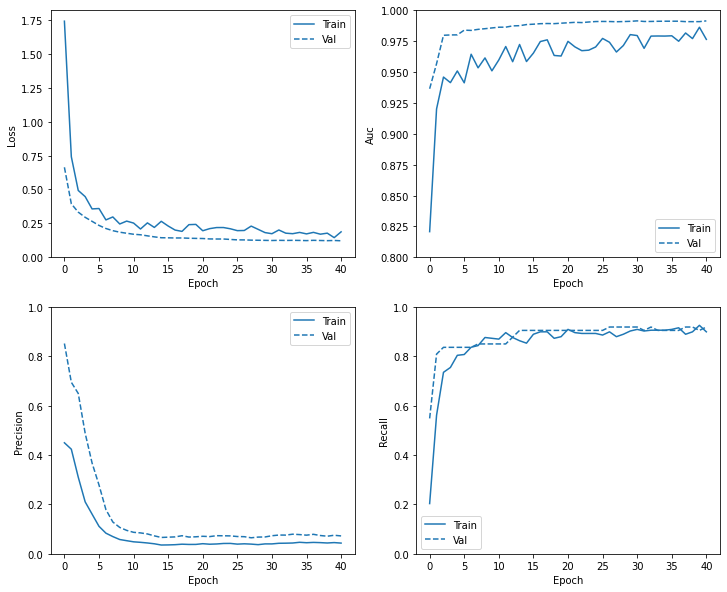

In [34]:
plot_metrics(weighted_history)

### Evaluate metrics

In [35]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07716926628907056
tp :  103.0
fp :  1040.0
tn :  55808.0
fn :  11.0
accuracy :  0.9815491
precision :  0.09011374
recall :  0.9035088
auc :  0.9790242

Legitimate Transactions Detected (True Negatives):  55808
Legitimate Transactions Incorrectly Detected (False Positives):  1040
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  103
Total Fraudulent Transactions:  114


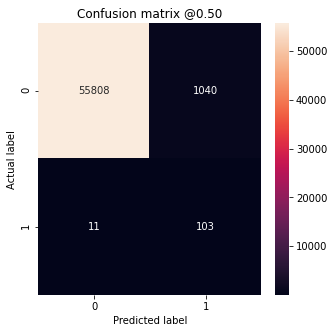

In [36]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade offs between these different types of errors for your application.

### Plot the ROC

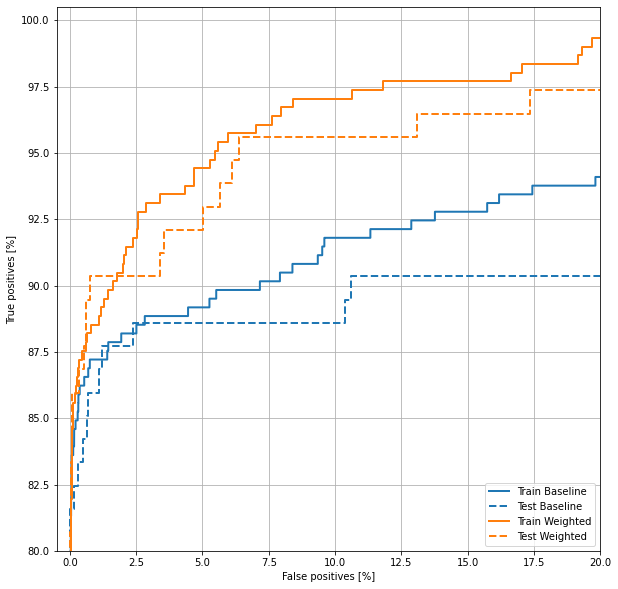

In [37]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [38]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [39]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181971, 29)

In [40]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363942, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [41]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [42]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.98371466  2.80366309 -4.68243352  4.03439253  0.74372945 -2.39810746
 -1.81376908  0.98527024 -4.03766301 -5.          3.74766191 -5.
  0.25184718 -5.         -0.70587683 -1.46325423 -3.1914307  -0.10292875
 -2.57776417  0.42165063  0.81099515 -0.74509272 -0.57042515 -1.15561033
 -0.05856378  0.06944137  1.40722562  0.91022564 -1.58083293]

Label:  1


Merge the two together using `experimental.sample_from_datasets`:

In [43]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [44]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5166015625


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [45]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [46]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Train for 278.0 steps, validate for 23 steps
Epoch 1/100


  1/278 [..............................] - ETA: 7:09 - loss: 0.9778 - tp: 555.0000 - fp: 540.0000 - tn: 450.0000 - fn: 503.0000 - accuracy: 0.4907 - precision: 0.5068 - recall: 0.5246 - auc: 0.5018

  4/278 [..............................] - ETA: 1:50 - loss: 0.9287 - tp: 2261.0000 - fp: 2348.0000 - tn: 1762.0000 - fn: 1821.0000 - accuracy: 0.4911 - precision: 0.4906 - recall: 0.5539 - auc: 0.5318

  7/278 [..............................] - ETA: 1:05 - loss: 0.8866 - tp: 4164.0000 - fp: 4090.0000 - tn: 3105.0000 - fn: 2977.0000 - accuracy: 0.5070 - precision: 0.5045 - recall: 0.5831 - auc: 0.5596

 10/278 [>.............................] - ETA: 47s - loss: 0.8466 - tp: 6260.0000 - fp: 5797.0000 - tn: 4448.0000 - fn: 3975.0000 - accuracy: 0.5229 - precision: 0.5192 - recall: 0.6116 - auc: 0.5879 

 12/278 [>.............................] - ETA: 40s - loss: 0.8254 - tp: 7764.0000 - fp: 6968.0000 - tn: 5315.0000 - fn: 4529.0000 - accuracy: 0.5322 - precision: 0.5270 - recall: 0.6316 - auc: 0.6054

 14/278 [>.............................] - ETA: 35s - loss: 0.8006 - tp: 9369.0000 - fp: 8106.0000 - tn: 6211.0000 - fn: 4986.0000 - accuracy: 0.5434 - precision: 0.5361 - recall: 0.6527 - auc: 0.6243

 17/278 [>.............................] - ETA: 29s - loss: 0.7716 - tp: 11813.0000 - fp: 9870.0000 - tn: 7541.0000 - fn: 5592.0000 - accuracy: 0.5559 - precision: 0.5448 - recall: 0.6787 - auc: 0.6480

 20/278 [=>............................] - ETA: 25s - loss: 0.7467 - tp: 14354.0000 - fp: 11607.0000 - tn: 8864.0000 - fn: 6135.0000 - accuracy: 0.5668 - precision: 0.5529 - recall: 0.7006 - auc: 0.6690

 23/278 [=>............................] - ETA: 23s - loss: 0.7254 - tp: 16961.0000 - fp: 13326.0000 - tn: 10205.0000 - fn: 6612.0000 - accuracy: 0.5767 - precision: 0.5600 - recall: 0.7195 - auc: 0.6877

 26/278 [=>............................] - ETA: 20s - loss: 0.7043 - tp: 19677.0000 - fp: 14953.0000 - tn: 11618.0000 - fn: 7000.0000 - accuracy: 0.5877 - precision: 0.5682 - recall: 0.7376 - auc: 0.7061

 29/278 [==>...........................] - ETA: 19s - loss: 0.6859 - tp: 22378.0000 - fp: 16566.0000 - tn: 13069.0000 - fn: 7379.0000 - accuracy: 0.5968 - precision: 0.5746 - recall: 0.7520 - auc: 0.7219

 31/278 [==>...........................] - ETA: 18s - loss: 0.6765 - tp: 24169.0000 - fp: 17618.0000 - tn: 14030.0000 - fn: 7671.0000 - accuracy: 0.6017 - precision: 0.5784 - recall: 0.7591 - auc: 0.7298

 34/278 [==>...........................] - ETA: 16s - loss: 0.6627 - tp: 26859.0000 - fp: 19247.0000 - tn: 15483.0000 - fn: 8043.0000 - accuracy: 0.6081 - precision: 0.5825 - recall: 0.7696 - auc: 0.7418

 37/278 [==>...........................] - ETA: 15s - loss: 0.6509 - tp: 29569.0000 - fp: 20905.0000 - tn: 16944.0000 - fn: 8358.0000 - accuracy: 0.6138 - precision: 0.5858 - recall: 0.7796 - auc: 0.7526

 39/278 [===>..........................] - ETA: 15s - loss: 0.6438 - tp: 31366.0000 - fp: 21956.0000 - tn: 17978.0000 - fn: 8572.0000 - accuracy: 0.6178 - precision: 0.5882 - recall: 0.7854 - auc: 0.7589

 41/278 [===>..........................] - ETA: 14s - loss: 0.6372 - tp: 33188.0000 - fp: 23014.0000 - tn: 18996.0000 - fn: 8770.0000 - accuracy: 0.6215 - precision: 0.5905 - recall: 0.7910 - auc: 0.7650

 44/278 [===>..........................] - ETA: 13s - loss: 0.6282 - tp: 35900.0000 - fp: 24599.0000 - tn: 20519.0000 - fn: 9094.0000 - accuracy: 0.6261 - precision: 0.5934 - recall: 0.7979 - auc: 0.7729

 47/278 [====>.........................] - ETA: 13s - loss: 0.6186 - tp: 38699.0000 - fp: 26070.0000 - tn: 22103.0000 - fn: 9384.0000 - accuracy: 0.6317 - precision: 0.5975 - recall: 0.8048 - auc: 0.7808

 50/278 [====>.........................] - ETA: 12s - loss: 0.6102 - tp: 41455.0000 - fp: 27531.0000 - tn: 23728.0000 - fn: 9686.0000 - accuracy: 0.6366 - precision: 0.6009 - recall: 0.8106 - auc: 0.7879

 52/278 [====>.........................] - ETA: 12s - loss: 0.6054 - tp: 43295.0000 - fp: 28500.0000 - tn: 24809.0000 - fn: 9892.0000 - accuracy: 0.6395 - precision: 0.6030 - recall: 0.8140 - auc: 0.7921

 54/278 [====>.........................] - ETA: 11s - loss: 0.6000 - tp: 45177.0000 - fp: 29413.0000 - tn: 25920.0000 - fn: 10082.0000 - accuracy: 0.6429 - precision: 0.6057 - recall: 0.8176 - auc: 0.7965

 57/278 [=====>........................] - ETA: 11s - loss: 0.5923 - tp: 47963.0000 - fp: 30766.0000 - tn: 27618.0000 - fn: 10389.0000 - accuracy: 0.6475 - precision: 0.6092 - recall: 0.8220 - auc: 0.8024

 60/278 [=====>........................] - ETA: 10s - loss: 0.5856 - tp: 50758.0000 - fp: 32112.0000 - tn: 29333.0000 - fn: 10677.0000 - accuracy: 0.6518 - precision: 0.6125 - recall: 0.8262 - auc: 0.8076

 62/278 [=====>........................] - ETA: 10s - loss: 0.5815 - tp: 52511.0000 - fp: 33000.0000 - tn: 30570.0000 - fn: 10895.0000 - accuracy: 0.6543 - precision: 0.6141 - recall: 0.8282 - auc: 0.8107

 64/278 [=====>........................] - ETA: 10s - loss: 0.5773 - tp: 54336.0000 - fp: 33908.0000 - tn: 31745.0000 - fn: 11083.0000 - accuracy: 0.6567 - precision: 0.6157 - recall: 0.8306 - auc: 0.8139

 67/278 [======>.......................] - ETA: 9s - loss: 0.5715 - tp: 57083.0000 - fp: 35220.0000 - tn: 33524.0000 - fn: 11389.0000 - accuracy: 0.6603 - precision: 0.6184 - recall: 0.8337 - auc: 0.8183 

 69/278 [======>.......................] - ETA: 9s - loss: 0.5676 - tp: 58969.0000 - fp: 36061.0000 - tn: 34700.0000 - fn: 11582.0000 - accuracy: 0.6629 - precision: 0.6205 - recall: 0.8358 - auc: 0.8212

 71/278 [======>.......................] - ETA: 9s - loss: 0.5637 - tp: 60857.0000 - fp: 36856.0000 - tn: 35931.0000 - fn: 11764.0000 - accuracy: 0.6656 - precision: 0.6228 - recall: 0.8380 - auc: 0.8242

 73/278 [======>.......................] - ETA: 9s - loss: 0.5599 - tp: 62686.0000 - fp: 37648.0000 - tn: 37201.0000 - fn: 11969.0000 - accuracy: 0.6681 - precision: 0.6248 - recall: 0.8397 - auc: 0.8268

 76/278 [=======>......................] - ETA: 9s - loss: 0.5545 - tp: 65490.0000 - fp: 38801.0000 - tn: 39094.0000 - fn: 12263.0000 - accuracy: 0.6719 - precision: 0.6280 - recall: 0.8423 - auc: 0.8306

 78/278 [=======>......................] - ETA: 8s - loss: 0.5511 - tp: 67376.0000 - fp: 39568.0000 - tn: 40324.0000 - fn: 12476.0000 - accuracy: 0.6742 - precision: 0.6300 - recall: 0.8438 - auc: 0.8329

 80/278 [=======>......................] - ETA: 8s - loss: 0.5477 - tp: 69265.0000 - fp: 40281.0000 - tn: 41615.0000 - fn: 12679.0000 - accuracy: 0.6768 - precision: 0.6323 - recall: 0.8453 - auc: 0.8352

 83/278 [=======>......................] - ETA: 8s - loss: 0.5430 - tp: 72032.0000 - fp: 41402.0000 - tn: 43586.0000 - fn: 12964.0000 - accuracy: 0.6802 - precision: 0.6350 - recall: 0.8475 - auc: 0.8385

 86/278 [========>.....................] - ETA: 8s - loss: 0.5386 - tp: 74777.0000 - fp: 42484.0000 - tn: 45613.0000 - fn: 13254.0000 - accuracy: 0.6835 - precision: 0.6377 - recall: 0.8494 - auc: 0.8415

 89/278 [========>.....................] - ETA: 7s - loss: 0.5341 - tp: 77595.0000 - fp: 43497.0000 - tn: 47612.0000 - fn: 13568.0000 - accuracy: 0.6869 - precision: 0.6408 - recall: 0.8512 - auc: 0.8444

 92/278 [========>.....................] - ETA: 7s - loss: 0.5299 - tp: 80408.0000 - fp: 44510.0000 - tn: 49664.0000 - fn: 13834.0000 - accuracy: 0.6903 - precision: 0.6437 - recall: 0.8532 - auc: 0.8473

 95/278 [=========>....................] - ETA: 7s - loss: 0.5259 - tp: 83155.0000 - fp: 45493.0000 - tn: 51766.0000 - fn: 14146.0000 - accuracy: 0.6935 - precision: 0.6464 - recall: 0.8546 - auc: 0.8498

 98/278 [=========>....................] - ETA: 7s - loss: 0.5222 - tp: 85968.0000 - fp: 46541.0000 - tn: 53763.0000 - fn: 14432.0000 - accuracy: 0.6962 - precision: 0.6488 - recall: 0.8563 - auc: 0.8523

101/278 [=========>....................] - ETA: 6s - loss: 0.5186 - tp: 88692.0000 - fp: 47477.0000 - tn: 55941.0000 - fn: 14738.0000 - accuracy: 0.6992 - precision: 0.6513 - recall: 0.8575 - auc: 0.8546

104/278 [==========>...................] - ETA: 6s - loss: 0.5148 - tp: 91520.0000 - fp: 48396.0000 - tn: 58053.0000 - fn: 15023.0000 - accuracy: 0.7022 - precision: 0.6541 - recall: 0.8590 - auc: 0.8570

107/278 [==========>...................] - ETA: 6s - loss: 0.5111 - tp: 94352.0000 - fp: 49269.0000 - tn: 60187.0000 - fn: 15328.0000 - accuracy: 0.7052 - precision: 0.6570 - recall: 0.8602 - auc: 0.8592

110/278 [==========>...................] - ETA: 6s - loss: 0.5076 - tp: 97099.0000 - fp: 50155.0000 - tn: 62395.0000 - fn: 15631.0000 - accuracy: 0.7080 - precision: 0.6594 - recall: 0.8613 - auc: 0.8613

113/278 [===========>..................] - ETA: 6s - loss: 0.5040 - tp: 99891.0000 - fp: 51006.0000 - tn: 64616.0000 - fn: 15911.0000 - accuracy: 0.7108 - precision: 0.6620 - recall: 0.8626 - auc: 0.8635

116/278 [===========>..................] - ETA: 5s - loss: 0.5007 - tp: 102668.0000 - fp: 51826.0000 - tn: 66881.0000 - fn: 16193.0000 - accuracy: 0.7137 - precision: 0.6645 - recall: 0.8638 - auc: 0.8655

119/278 [===========>..................] - ETA: 5s - loss: 0.4974 - tp: 105443.0000 - fp: 52623.0000 - tn: 69148.0000 - fn: 16498.0000 - accuracy: 0.7164 - precision: 0.6671 - recall: 0.8647 - auc: 0.8674

122/278 [============>.................] - ETA: 5s - loss: 0.4943 - tp: 108236.0000 - fp: 53466.0000 - tn: 71355.0000 - fn: 16799.0000 - accuracy: 0.7188 - precision: 0.6694 - recall: 0.8656 - auc: 0.8692

125/278 [============>.................] - ETA: 5s - loss: 0.4913 - tp: 111000.0000 - fp: 54248.0000 - tn: 73640.0000 - fn: 17112.0000 - accuracy: 0.7212 - precision: 0.6717 - recall: 0.8664 - auc: 0.8709

128/278 [============>.................] - ETA: 5s - loss: 0.4883 - tp: 113774.0000 - fp: 55003.0000 - tn: 75980.0000 - fn: 17387.0000 - accuracy: 0.7239 - precision: 0.6741 - recall: 0.8674 - auc: 0.8726

131/278 [=============>................] - ETA: 5s - loss: 0.4855 - tp: 116524.0000 - fp: 55729.0000 - tn: 78313.0000 - fn: 17722.0000 - accuracy: 0.7262 - precision: 0.6765 - recall: 0.8680 - auc: 0.8741

134/278 [=============>................] - ETA: 5s - loss: 0.4827 - tp: 119278.0000 - fp: 56471.0000 - tn: 80653.0000 - fn: 18030.0000 - accuracy: 0.7285 - precision: 0.6787 - recall: 0.8687 - auc: 0.8756

137/278 [=============>................] - ETA: 4s - loss: 0.4799 - tp: 122053.0000 - fp: 57138.0000 - tn: 83061.0000 - fn: 18324.0000 - accuracy: 0.7310 - precision: 0.6811 - recall: 0.8695 - auc: 0.8772

140/278 [==============>...............] - ETA: 4s - loss: 0.4771 - tp: 124842.0000 - fp: 57780.0000 - tn: 85466.0000 - fn: 18632.0000 - accuracy: 0.7335 - precision: 0.6836 - recall: 0.8701 - auc: 0.8786

143/278 [==============>...............] - ETA: 4s - loss: 0.4745 - tp: 127566.0000 - fp: 58422.0000 - tn: 87941.0000 - fn: 18935.0000 - accuracy: 0.7359 - precision: 0.6859 - recall: 0.8708 - auc: 0.8800

146/278 [==============>...............] - ETA: 4s - loss: 0.4720 - tp: 130302.0000 - fp: 59074.0000 - tn: 90383.0000 - fn: 19249.0000 - accuracy: 0.7381 - precision: 0.6881 - recall: 0.8713 - auc: 0.8813

149/278 [===============>..............] - ETA: 4s - loss: 0.4695 - tp: 133009.0000 - fp: 59727.0000 - tn: 92859.0000 - fn: 19557.0000 - accuracy: 0.7402 - precision: 0.6901 - recall: 0.8718 - auc: 0.8826

152/278 [===============>..............] - ETA: 4s - loss: 0.4669 - tp: 135886.0000 - fp: 60332.0000 - tn: 95232.0000 - fn: 19846.0000 - accuracy: 0.7424 - precision: 0.6925 - recall: 0.8726 - auc: 0.8840

155/278 [===============>..............] - ETA: 4s - loss: 0.4645 - tp: 138657.0000 - fp: 60915.0000 - tn: 97712.0000 - fn: 20156.0000 - accuracy: 0.7446 - precision: 0.6948 - recall: 0.8731 - auc: 0.8852

158/278 [================>.............] - ETA: 3s - loss: 0.4621 - tp: 141417.0000 - fp: 61519.0000 - tn: 100193.0000 - fn: 20455.0000 - accuracy: 0.7467 - precision: 0.6969 - recall: 0.8736 - auc: 0.8864

161/278 [================>.............] - ETA: 3s - loss: 0.4597 - tp: 144133.0000 - fp: 62067.0000 - tn: 102749.0000 - fn: 20779.0000 - accuracy: 0.7487 - precision: 0.6990 - recall: 0.8740 - auc: 0.8875

164/278 [================>.............] - ETA: 3s - loss: 0.4575 - tp: 146894.0000 - fp: 62608.0000 - tn: 105273.0000 - fn: 21097.0000 - accuracy: 0.7508 - precision: 0.7012 - recall: 0.8744 - auc: 0.8886

167/278 [=================>............] - ETA: 3s - loss: 0.4553 - tp: 149624.0000 - fp: 63144.0000 - tn: 107843.0000 - fn: 21405.0000 - accuracy: 0.7528 - precision: 0.7032 - recall: 0.8748 - auc: 0.8897

170/278 [=================>............] - ETA: 3s - loss: 0.4531 - tp: 152365.0000 - fp: 63682.0000 - tn: 110379.0000 - fn: 21734.0000 - accuracy: 0.7547 - precision: 0.7052 - recall: 0.8752 - auc: 0.8907

172/278 [=================>............] - ETA: 3s - loss: 0.4517 - tp: 154209.0000 - fp: 64015.0000 - tn: 112080.0000 - fn: 21952.0000 - accuracy: 0.7560 - precision: 0.7067 - recall: 0.8754 - auc: 0.8914

175/278 [=================>............] - ETA: 3s - loss: 0.4497 - tp: 156960.0000 - fp: 64517.0000 - tn: 114661.0000 - fn: 22262.0000 - accuracy: 0.7579 - precision: 0.7087 - recall: 0.8758 - auc: 0.8924

178/278 [==================>...........] - ETA: 3s - loss: 0.4476 - tp: 159699.0000 - fp: 65000.0000 - tn: 117272.0000 - fn: 22573.0000 - accuracy: 0.7598 - precision: 0.7107 - recall: 0.8762 - auc: 0.8934

181/278 [==================>...........] - ETA: 3s - loss: 0.4455 - tp: 162419.0000 - fp: 65482.0000 - tn: 119916.0000 - fn: 22871.0000 - accuracy: 0.7617 - precision: 0.7127 - recall: 0.8766 - auc: 0.8944

184/278 [==================>...........] - ETA: 3s - loss: 0.4434 - tp: 165196.0000 - fp: 65906.0000 - tn: 122535.0000 - fn: 23195.0000 - accuracy: 0.7636 - precision: 0.7148 - recall: 0.8769 - auc: 0.8954

187/278 [===================>..........] - ETA: 2s - loss: 0.4413 - tp: 167951.0000 - fp: 66353.0000 - tn: 125172.0000 - fn: 23500.0000 - accuracy: 0.7654 - precision: 0.7168 - recall: 0.8773 - auc: 0.8963

190/278 [===================>..........] - ETA: 2s - loss: 0.4392 - tp: 170707.0000 - fp: 66776.0000 - tn: 127827.0000 - fn: 23810.0000 - accuracy: 0.7672 - precision: 0.7188 - recall: 0.8776 - auc: 0.8973

193/278 [===================>..........] - ETA: 2s - loss: 0.4372 - tp: 173485.0000 - fp: 67161.0000 - tn: 130494.0000 - fn: 24124.0000 - accuracy: 0.7691 - precision: 0.7209 - recall: 0.8779 - auc: 0.8981

196/278 [====================>.........] - ETA: 2s - loss: 0.4352 - tp: 176269.0000 - fp: 67582.0000 - tn: 133127.0000 - fn: 24430.0000 - accuracy: 0.7708 - precision: 0.7229 - recall: 0.8783 - auc: 0.8990

198/278 [====================>.........] - ETA: 2s - loss: 0.4340 - tp: 178086.0000 - fp: 67884.0000 - tn: 134906.0000 - fn: 24628.0000 - accuracy: 0.7719 - precision: 0.7240 - recall: 0.8785 - auc: 0.8996

200/278 [====================>.........] - ETA: 2s - loss: 0.4328 - tp: 179903.0000 - fp: 68143.0000 - tn: 136703.0000 - fn: 24851.0000 - accuracy: 0.7730 - precision: 0.7253 - recall: 0.8786 - auc: 0.9001

203/278 [====================>.........] - ETA: 2s - loss: 0.4309 - tp: 182657.0000 - fp: 68529.0000 - tn: 139397.0000 - fn: 25161.0000 - accuracy: 0.7746 - precision: 0.7272 - recall: 0.8789 - auc: 0.9009

206/278 [=====================>........] - ETA: 2s - loss: 0.4290 - tp: 185435.0000 - fp: 68911.0000 - tn: 142068.0000 - fn: 25474.0000 - accuracy: 0.7763 - precision: 0.7291 - recall: 0.8792 - auc: 0.9017

209/278 [=====================>........] - ETA: 2s - loss: 0.4271 - tp: 188248.0000 - fp: 69285.0000 - tn: 144703.0000 - fn: 25796.0000 - accuracy: 0.7779 - precision: 0.7310 - recall: 0.8795 - auc: 0.9025

212/278 [=====================>........] - ETA: 2s - loss: 0.4254 - tp: 190987.0000 - fp: 69691.0000 - tn: 147366.0000 - fn: 26132.0000 - accuracy: 0.7793 - precision: 0.7327 - recall: 0.8796 - auc: 0.9032

215/278 [======================>.......] - ETA: 1s - loss: 0.4237 - tp: 193689.0000 - fp: 70067.0000 - tn: 150099.0000 - fn: 26465.0000 - accuracy: 0.7808 - precision: 0.7343 - recall: 0.8798 - auc: 0.9040

218/278 [======================>.......] - ETA: 1s - loss: 0.4219 - tp: 196390.0000 - fp: 70425.0000 - tn: 152875.0000 - fn: 26774.0000 - accuracy: 0.7823 - precision: 0.7361 - recall: 0.8800 - auc: 0.9047

220/278 [======================>.......] - ETA: 1s - loss: 0.4208 - tp: 198245.0000 - fp: 70668.0000 - tn: 154659.0000 - fn: 26988.0000 - accuracy: 0.7833 - precision: 0.7372 - recall: 0.8802 - auc: 0.9052

222/278 [======================>.......] - ETA: 1s - loss: 0.4197 - tp: 200075.0000 - fp: 70890.0000 - tn: 156491.0000 - fn: 27200.0000 - accuracy: 0.7843 - precision: 0.7384 - recall: 0.8803 - auc: 0.9056

225/278 [=======================>......] - ETA: 1s - loss: 0.4180 - tp: 202812.0000 - fp: 71248.0000 - tn: 159225.0000 - fn: 27515.0000 - accuracy: 0.7857 - precision: 0.7400 - recall: 0.8805 - auc: 0.9063

228/278 [=======================>......] - ETA: 1s - loss: 0.4163 - tp: 205550.0000 - fp: 71610.0000 - tn: 161943.0000 - fn: 27841.0000 - accuracy: 0.7870 - precision: 0.7416 - recall: 0.8807 - auc: 0.9070

231/278 [=======================>......] - ETA: 1s - loss: 0.4146 - tp: 208346.0000 - fp: 71928.0000 - tn: 164658.0000 - fn: 28156.0000 - accuracy: 0.7884 - precision: 0.7434 - recall: 0.8809 - auc: 0.9077

234/278 [========================>.....] - ETA: 1s - loss: 0.4130 - tp: 211075.0000 - fp: 72229.0000 - tn: 167449.0000 - fn: 28479.0000 - accuracy: 0.7899 - precision: 0.7450 - recall: 0.8811 - auc: 0.9083

237/278 [========================>.....] - ETA: 1s - loss: 0.4114 - tp: 213859.0000 - fp: 72593.0000 - tn: 170131.0000 - fn: 28793.0000 - accuracy: 0.7911 - precision: 0.7466 - recall: 0.8813 - auc: 0.9090

239/278 [========================>.....] - ETA: 1s - loss: 0.4104 - tp: 215731.0000 - fp: 72807.0000 - tn: 171919.0000 - fn: 29015.0000 - accuracy: 0.7920 - precision: 0.7477 - recall: 0.8814 - auc: 0.9094

242/278 [=========================>....] - ETA: 1s - loss: 0.4088 - tp: 218437.0000 - fp: 73101.0000 - tn: 174730.0000 - fn: 29348.0000 - accuracy: 0.7933 - precision: 0.7493 - recall: 0.8816 - auc: 0.9100

244/278 [=========================>....] - ETA: 1s - loss: 0.4078 - tp: 220295.0000 - fp: 73307.0000 - tn: 176539.0000 - fn: 29571.0000 - accuracy: 0.7941 - precision: 0.7503 - recall: 0.8817 - auc: 0.9104

247/278 [=========================>....] - ETA: 0s - loss: 0.4062 - tp: 223037.0000 - fp: 73590.0000 - tn: 179356.0000 - fn: 29873.0000 - accuracy: 0.7955 - precision: 0.7519 - recall: 0.8819 - auc: 0.9110

250/278 [=========================>....] - ETA: 0s - loss: 0.4047 - tp: 225837.0000 - fp: 73929.0000 - tn: 182037.0000 - fn: 30197.0000 - accuracy: 0.7966 - precision: 0.7534 - recall: 0.8821 - auc: 0.9116

253/278 [==========================>...] - ETA: 0s - loss: 0.4032 - tp: 228476.0000 - fp: 74251.0000 - tn: 184887.0000 - fn: 30530.0000 - accuracy: 0.7978 - precision: 0.7547 - recall: 0.8821 - auc: 0.9121

256/278 [==========================>...] - ETA: 0s - loss: 0.4018 - tp: 231237.0000 - fp: 74524.0000 - tn: 187670.0000 - fn: 30857.0000 - accuracy: 0.7990 - precision: 0.7563 - recall: 0.8823 - auc: 0.9127

259/278 [==========================>...] - ETA: 0s - loss: 0.4003 - tp: 233989.0000 - fp: 74794.0000 - tn: 190475.0000 - fn: 31174.0000 - accuracy: 0.8002 - precision: 0.7578 - recall: 0.8824 - auc: 0.9132

262/278 [===========================>..] - ETA: 0s - loss: 0.3989 - tp: 236792.0000 - fp: 75085.0000 - tn: 193207.0000 - fn: 31492.0000 - accuracy: 0.8014 - precision: 0.7592 - recall: 0.8826 - auc: 0.9138

265/278 [===========================>..] - ETA: 0s - loss: 0.3975 - tp: 239540.0000 - fp: 75365.0000 - tn: 195998.0000 - fn: 31817.0000 - accuracy: 0.8025 - precision: 0.7607 - recall: 0.8827 - auc: 0.9143

268/278 [===========================>..] - ETA: 0s - loss: 0.3960 - tp: 242348.0000 - fp: 75612.0000 - tn: 198766.0000 - fn: 32138.0000 - accuracy: 0.8037 - precision: 0.7622 - recall: 0.8829 - auc: 0.9149

271/278 [============================>.] - ETA: 0s - loss: 0.3946 - tp: 245033.0000 - fp: 75903.0000 - tn: 201612.0000 - fn: 32460.0000 - accuracy: 0.8048 - precision: 0.7635 - recall: 0.8830 - auc: 0.9154

274/278 [============================>.] - ETA: 0s - loss: 0.3932 - tp: 247745.0000 - fp: 76163.0000 - tn: 204448.0000 - fn: 32796.0000 - accuracy: 0.8058 - precision: 0.7649 - recall: 0.8831 - auc: 0.9159

277/278 [============================>.] - ETA: 0s - loss: 0.3918 - tp: 250494.0000 - fp: 76417.0000 - tn: 207258.0000 - fn: 33127.0000 - accuracy: 0.8069 - precision: 0.7662 - recall: 0.8832 - auc: 0.9164

278/278 [==============================] - 9s 32ms/step - loss: 0.3914 - tp: 251412.0000 - fp: 76514.0000 - tn: 208189.0000 - fn: 33229.0000 - accuracy: 0.8072 - precision: 0.7667 - recall: 0.8833 - auc: 0.9166 - val_loss: 0.2670 - val_tp: 64.0000 - val_fp: 953.0000 - val_tn: 44543.0000 - val_fn: 9.0000 - val_accuracy: 0.9789 - val_precision: 0.0629 - val_recall: 0.8767 - val_auc: 0.9691


Epoch 2/100
  1/278 [..............................] - ETA: 2s - loss: 0.2638 - tp: 917.0000 - fp: 84.0000 - tn: 942.0000 - fn: 105.0000 - accuracy: 0.9077 - precision: 0.9161 - recall: 0.8973 - auc: 0.9570

 11/278 [>.............................] - ETA: 1s - loss: 0.2639 - tp: 10009.0000 - fp: 870.0000 - tn: 10434.0000 - fn: 1215.0000 - accuracy: 0.9074 - precision: 0.9200 - recall: 0.8917 - auc: 0.9562

 14/278 [>.............................] - ETA: 2s - loss: 0.2622 - tp: 12700.0000 - fp: 1113.0000 - tn: 13336.0000 - fn: 1523.0000 - accuracy: 0.9081 - precision: 0.9194 - recall: 0.8929 - auc: 0.9570

 17/278 [>.............................] - ETA: 2s - loss: 0.2606 - tp: 15493.0000 - fp: 1332.0000 - tn: 16135.0000 - fn: 1856.0000 - accuracy: 0.9084 - precision: 0.9208 - recall: 0.8930 - auc: 0.9577

 20/278 [=>............................] - ETA: 3s - loss: 0.2610 - tp: 18272.0000 - fp: 1552.0000 - tn: 18964.0000 - fn: 2172.0000 - accuracy: 0.9091 - precision: 0.9217 - recall: 0.8938 - auc: 0.9576

 23/278 [=>............................] - ETA: 3s - loss: 0.2606 - tp: 21027.0000 - fp: 1779.0000 - tn: 21799.0000 - fn: 2499.0000 - accuracy: 0.9092 - precision: 0.9220 - recall: 0.8938 - auc: 0.9574

 26/278 [=>............................] - ETA: 3s - loss: 0.2595 - tp: 23855.0000 - fp: 1993.0000 - tn: 24578.0000 - fn: 2822.0000 - accuracy: 0.9096 - precision: 0.9229 - recall: 0.8942 - auc: 0.9578

 28/278 [==>...........................] - ETA: 3s - loss: 0.2590 - tp: 25723.0000 - fp: 2151.0000 - tn: 26444.0000 - fn: 3026.0000 - accuracy: 0.9097 - precision: 0.9228 - recall: 0.8947 - auc: 0.9581

 31/278 [==>...........................] - ETA: 3s - loss: 0.2591 - tp: 28417.0000 - fp: 2365.0000 - tn: 29345.0000 - fn: 3361.0000 - accuracy: 0.9098 - precision: 0.9232 - recall: 0.8942 - auc: 0.9580

 34/278 [==>...........................] - ETA: 4s - loss: 0.2581 - tp: 31232.0000 - fp: 2564.0000 - tn: 32161.0000 - fn: 3675.0000 - accuracy: 0.9104 - precision: 0.9241 - recall: 0.8947 - auc: 0.9583

 37/278 [==>...........................] - ETA: 4s - loss: 0.2580 - tp: 33978.0000 - fp: 2795.0000 - tn: 35007.0000 - fn: 3996.0000 - accuracy: 0.9104 - precision: 0.9240 - recall: 0.8948 - auc: 0.9583

 40/278 [===>..........................] - ETA: 4s - loss: 0.2571 - tp: 36734.0000 - fp: 3001.0000 - tn: 37883.0000 - fn: 4302.0000 - accuracy: 0.9109 - precision: 0.9245 - recall: 0.8952 - auc: 0.9586

 43/278 [===>..........................] - ETA: 4s - loss: 0.2562 - tp: 39483.0000 - fp: 3187.0000 - tn: 40753.0000 - fn: 4641.0000 - accuracy: 0.9111 - precision: 0.9253 - recall: 0.8948 - auc: 0.9587

 46/278 [===>..........................] - ETA: 4s - loss: 0.2557 - tp: 42244.0000 - fp: 3430.0000 - tn: 43561.0000 - fn: 4973.0000 - accuracy: 0.9108 - precision: 0.9249 - recall: 0.8947 - auc: 0.9588

 49/278 [====>.........................] - ETA: 4s - loss: 0.2554 - tp: 44982.0000 - fp: 3640.0000 - tn: 46440.0000 - fn: 5290.0000 - accuracy: 0.9110 - precision: 0.9251 - recall: 0.8948 - auc: 0.9589

 52/278 [====>.........................] - ETA: 4s - loss: 0.2543 - tp: 47736.0000 - fp: 3832.0000 - tn: 49341.0000 - fn: 5587.0000 - accuracy: 0.9116 - precision: 0.9257 - recall: 0.8952 - auc: 0.9592

 55/278 [====>.........................] - ETA: 4s - loss: 0.2534 - tp: 50561.0000 - fp: 4019.0000 - tn: 52165.0000 - fn: 5895.0000 - accuracy: 0.9120 - precision: 0.9264 - recall: 0.8956 - auc: 0.9595

 58/278 [=====>........................] - ETA: 4s - loss: 0.2531 - tp: 53278.0000 - fp: 4252.0000 - tn: 55050.0000 - fn: 6204.0000 - accuracy: 0.9120 - precision: 0.9261 - recall: 0.8957 - auc: 0.9596

 61/278 [=====>........................] - ETA: 4s - loss: 0.2526 - tp: 56059.0000 - fp: 4442.0000 - tn: 57896.0000 - fn: 6531.0000 - accuracy: 0.9122 - precision: 0.9266 - recall: 0.8957 - auc: 0.9597

 64/278 [=====>........................] - ETA: 4s - loss: 0.2519 - tp: 58776.0000 - fp: 4622.0000 - tn: 60826.0000 - fn: 6848.0000 - accuracy: 0.9125 - precision: 0.9271 - recall: 0.8956 - auc: 0.9598

 67/278 [======>.......................] - ETA: 4s - loss: 0.2510 - tp: 61488.0000 - fp: 4788.0000 - tn: 63778.0000 - fn: 7162.0000 - accuracy: 0.9129 - precision: 0.9278 - recall: 0.8957 - auc: 0.9601

 70/278 [======>.......................] - ETA: 4s - loss: 0.2505 - tp: 64309.0000 - fp: 4989.0000 - tn: 66590.0000 - fn: 7472.0000 - accuracy: 0.9131 - precision: 0.9280 - recall: 0.8959 - auc: 0.9602

 73/278 [======>.......................] - ETA: 4s - loss: 0.2500 - tp: 67068.0000 - fp: 5174.0000 - tn: 69471.0000 - fn: 7791.0000 - accuracy: 0.9133 - precision: 0.9284 - recall: 0.8959 - auc: 0.9603

 76/278 [=======>......................] - ETA: 3s - loss: 0.2493 - tp: 69863.0000 - fp: 5327.0000 - tn: 72370.0000 - fn: 8088.0000 - accuracy: 0.9138 - precision: 0.9292 - recall: 0.8962 - auc: 0.9606

 78/278 [=======>......................] - ETA: 4s - loss: 0.2491 - tp: 71690.0000 - fp: 5443.0000 - tn: 74301.0000 - fn: 8310.0000 - accuracy: 0.9139 - precision: 0.9294 - recall: 0.8961 - auc: 0.9606

 81/278 [=======>......................] - ETA: 4s - loss: 0.2483 - tp: 74524.0000 - fp: 5607.0000 - tn: 77137.0000 - fn: 8620.0000 - accuracy: 0.9142 - precision: 0.9300 - recall: 0.8963 - auc: 0.9608

 84/278 [========>.....................] - ETA: 4s - loss: 0.2476 - tp: 77246.0000 - fp: 5793.0000 - tn: 80060.0000 - fn: 8933.0000 - accuracy: 0.9144 - precision: 0.9302 - recall: 0.8963 - auc: 0.9610

 87/278 [========>.....................] - ETA: 4s - loss: 0.2470 - tp: 79963.0000 - fp: 5955.0000 - tn: 83011.0000 - fn: 9247.0000 - accuracy: 0.9147 - precision: 0.9307 - recall: 0.8963 - auc: 0.9612

 89/278 [========>.....................] - ETA: 4s - loss: 0.2466 - tp: 81779.0000 - fp: 6086.0000 - tn: 84960.0000 - fn: 9447.0000 - accuracy: 0.9148 - precision: 0.9307 - recall: 0.8964 - auc: 0.9614

 92/278 [========>.....................] - ETA: 4s - loss: 0.2460 - tp: 84533.0000 - fp: 6240.0000 - tn: 87898.0000 - fn: 9745.0000 - accuracy: 0.9152 - precision: 0.9313 - recall: 0.8966 - auc: 0.9616

 95/278 [=========>....................] - ETA: 3s - loss: 0.2455 - tp: 87329.0000 - fp: 6411.0000 - tn: 90761.0000 - fn: 10059.0000 - accuracy: 0.9153 - precision: 0.9316 - recall: 0.8967 - auc: 0.9617

 98/278 [=========>....................] - ETA: 3s - loss: 0.2450 - tp: 90118.0000 - fp: 6588.0000 - tn: 93635.0000 - fn: 10363.0000 - accuracy: 0.9155 - precision: 0.9319 - recall: 0.8969 - auc: 0.9618

100/278 [=========>....................] - ETA: 3s - loss: 0.2446 - tp: 91946.0000 - fp: 6701.0000 - tn: 95602.0000 - fn: 10551.0000 - accuracy: 0.9158 - precision: 0.9321 - recall: 0.8971 - auc: 0.9619

102/278 [==========>...................] - ETA: 3s - loss: 0.2444 - tp: 93739.0000 - fp: 6816.0000 - tn: 97593.0000 - fn: 10748.0000 - accuracy: 0.9159 - precision: 0.9322 - recall: 0.8971 - auc: 0.9620

105/278 [==========>...................] - ETA: 3s - loss: 0.2439 - tp: 96490.0000 - fp: 6992.0000 - tn: 100500.0000 - fn: 11058.0000 - accuracy: 0.9161 - precision: 0.9324 - recall: 0.8972 - auc: 0.9621

107/278 [==========>...................] - ETA: 3s - loss: 0.2434 - tp: 98309.0000 - fp: 7110.0000 - tn: 102466.0000 - fn: 11251.0000 - accuracy: 0.9162 - precision: 0.9326 - recall: 0.8973 - auc: 0.9622

109/278 [==========>...................] - ETA: 3s - loss: 0.2433 - tp: 100157.0000 - fp: 7246.0000 - tn: 104365.0000 - fn: 11464.0000 - accuracy: 0.9162 - precision: 0.9325 - recall: 0.8973 - auc: 0.9623

112/278 [===========>..................] - ETA: 3s - loss: 0.2427 - tp: 102909.0000 - fp: 7409.0000 - tn: 107284.0000 - fn: 11774.0000 - accuracy: 0.9164 - precision: 0.9328 - recall: 0.8973 - auc: 0.9624

115/278 [===========>..................] - ETA: 3s - loss: 0.2421 - tp: 105670.0000 - fp: 7576.0000 - tn: 110191.0000 - fn: 12083.0000 - accuracy: 0.9165 - precision: 0.9331 - recall: 0.8974 - auc: 0.9625

118/278 [===========>..................] - ETA: 3s - loss: 0.2417 - tp: 108471.0000 - fp: 7735.0000 - tn: 113061.0000 - fn: 12397.0000 - accuracy: 0.9167 - precision: 0.9334 - recall: 0.8974 - auc: 0.9626

121/278 [============>.................] - ETA: 3s - loss: 0.2411 - tp: 111282.0000 - fp: 7888.0000 - tn: 115929.0000 - fn: 12709.0000 - accuracy: 0.9169 - precision: 0.9338 - recall: 0.8975 - auc: 0.9628

124/278 [============>.................] - ETA: 3s - loss: 0.2405 - tp: 114064.0000 - fp: 8054.0000 - tn: 118832.0000 - fn: 13002.0000 - accuracy: 0.9171 - precision: 0.9340 - recall: 0.8977 - auc: 0.9629

127/278 [============>.................] - ETA: 3s - loss: 0.2401 - tp: 116837.0000 - fp: 8232.0000 - tn: 121717.0000 - fn: 13310.0000 - accuracy: 0.9172 - precision: 0.9342 - recall: 0.8977 - auc: 0.9630

129/278 [============>.................] - ETA: 3s - loss: 0.2397 - tp: 118655.0000 - fp: 8330.0000 - tn: 123704.0000 - fn: 13503.0000 - accuracy: 0.9174 - precision: 0.9344 - recall: 0.8978 - auc: 0.9631

132/278 [=============>................] - ETA: 3s - loss: 0.2393 - tp: 121444.0000 - fp: 8470.0000 - tn: 126602.0000 - fn: 13820.0000 - accuracy: 0.9175 - precision: 0.9348 - recall: 0.8978 - auc: 0.9632

135/278 [=============>................] - ETA: 3s - loss: 0.2387 - tp: 124203.0000 - fp: 8635.0000 - tn: 129509.0000 - fn: 14133.0000 - accuracy: 0.9177 - precision: 0.9350 - recall: 0.8978 - auc: 0.9633

137/278 [=============>................] - ETA: 3s - loss: 0.2384 - tp: 126018.0000 - fp: 8744.0000 - tn: 131495.0000 - fn: 14319.0000 - accuracy: 0.9178 - precision: 0.9351 - recall: 0.8980 - auc: 0.9634

140/278 [==============>...............] - ETA: 3s - loss: 0.2377 - tp: 128822.0000 - fp: 8891.0000 - tn: 134386.0000 - fn: 14621.0000 - accuracy: 0.9180 - precision: 0.9354 - recall: 0.8981 - auc: 0.9636

143/278 [==============>...............] - ETA: 3s - loss: 0.2372 - tp: 131637.0000 - fp: 9062.0000 - tn: 137246.0000 - fn: 14919.0000 - accuracy: 0.9181 - precision: 0.9356 - recall: 0.8982 - auc: 0.9637

146/278 [==============>...............] - ETA: 3s - loss: 0.2368 - tp: 134397.0000 - fp: 9226.0000 - tn: 140159.0000 - fn: 15226.0000 - accuracy: 0.9182 - precision: 0.9358 - recall: 0.8982 - auc: 0.9638

148/278 [==============>...............] - ETA: 2s - loss: 0.2364 - tp: 136287.0000 - fp: 9318.0000 - tn: 142066.0000 - fn: 15433.0000 - accuracy: 0.9183 - precision: 0.9360 - recall: 0.8983 - auc: 0.9639

151/278 [===============>..............] - ETA: 2s - loss: 0.2360 - tp: 139070.0000 - fp: 9473.0000 - tn: 144974.0000 - fn: 15731.0000 - accuracy: 0.9185 - precision: 0.9362 - recall: 0.8984 - auc: 0.9640

154/278 [===============>..............] - ETA: 2s - loss: 0.2355 - tp: 141886.0000 - fp: 9631.0000 - tn: 147839.0000 - fn: 16036.0000 - accuracy: 0.9186 - precision: 0.9364 - recall: 0.8985 - auc: 0.9641

157/278 [===============>..............] - ETA: 2s - loss: 0.2350 - tp: 144793.0000 - fp: 9793.0000 - tn: 150628.0000 - fn: 16322.0000 - accuracy: 0.9188 - precision: 0.9367 - recall: 0.8987 - auc: 0.9642

160/278 [================>.............] - ETA: 2s - loss: 0.2346 - tp: 147555.0000 - fp: 9946.0000 - tn: 153565.0000 - fn: 16614.0000 - accuracy: 0.9189 - precision: 0.9369 - recall: 0.8988 - auc: 0.9643

163/278 [================>.............] - ETA: 2s - loss: 0.2342 - tp: 150300.0000 - fp: 10086.0000 - tn: 156525.0000 - fn: 16913.0000 - accuracy: 0.9191 - precision: 0.9371 - recall: 0.8989 - auc: 0.9644

166/278 [================>.............] - ETA: 2s - loss: 0.2337 - tp: 153052.0000 - fp: 10252.0000 - tn: 159470.0000 - fn: 17194.0000 - accuracy: 0.9193 - precision: 0.9372 - recall: 0.8990 - auc: 0.9646

169/278 [=================>............] - ETA: 2s - loss: 0.2331 - tp: 155850.0000 - fp: 10380.0000 - tn: 162393.0000 - fn: 17489.0000 - accuracy: 0.9195 - precision: 0.9376 - recall: 0.8991 - auc: 0.9647

172/278 [=================>............] - ETA: 2s - loss: 0.2327 - tp: 158636.0000 - fp: 10539.0000 - tn: 165293.0000 - fn: 17788.0000 - accuracy: 0.9196 - precision: 0.9377 - recall: 0.8992 - auc: 0.9648

175/278 [=================>............] - ETA: 2s - loss: 0.2321 - tp: 161446.0000 - fp: 10680.0000 - tn: 168195.0000 - fn: 18079.0000 - accuracy: 0.9198 - precision: 0.9380 - recall: 0.8993 - auc: 0.9650

178/278 [==================>...........] - ETA: 2s - loss: 0.2317 - tp: 164256.0000 - fp: 10817.0000 - tn: 171091.0000 - fn: 18380.0000 - accuracy: 0.9199 - precision: 0.9382 - recall: 0.8994 - auc: 0.9650

181/278 [==================>...........] - ETA: 2s - loss: 0.2312 - tp: 167016.0000 - fp: 10954.0000 - tn: 174043.0000 - fn: 18675.0000 - accuracy: 0.9201 - precision: 0.9385 - recall: 0.8994 - auc: 0.9652

184/278 [==================>...........] - ETA: 2s - loss: 0.2308 - tp: 169792.0000 - fp: 11106.0000 - tn: 176992.0000 - fn: 18942.0000 - accuracy: 0.9203 - precision: 0.9386 - recall: 0.8996 - auc: 0.9652

187/278 [===================>..........] - ETA: 2s - loss: 0.2303 - tp: 172551.0000 - fp: 11257.0000 - tn: 179954.0000 - fn: 19214.0000 - accuracy: 0.9204 - precision: 0.9388 - recall: 0.8998 - auc: 0.9654

190/278 [===================>..........] - ETA: 1s - loss: 0.2298 - tp: 175289.0000 - fp: 11399.0000 - tn: 182931.0000 - fn: 19501.0000 - accuracy: 0.9206 - precision: 0.9389 - recall: 0.8999 - auc: 0.9655

193/278 [===================>..........] - ETA: 1s - loss: 0.2294 - tp: 178067.0000 - fp: 11541.0000 - tn: 185858.0000 - fn: 19798.0000 - accuracy: 0.9207 - precision: 0.9391 - recall: 0.8999 - auc: 0.9656

196/278 [====================>.........] - ETA: 1s - loss: 0.2289 - tp: 180813.0000 - fp: 11671.0000 - tn: 188853.0000 - fn: 20071.0000 - accuracy: 0.9209 - precision: 0.9394 - recall: 0.9001 - auc: 0.9657

199/278 [====================>.........] - ETA: 1s - loss: 0.2284 - tp: 183623.0000 - fp: 11807.0000 - tn: 191753.0000 - fn: 20369.0000 - accuracy: 0.9211 - precision: 0.9396 - recall: 0.9001 - auc: 0.9658

202/278 [====================>.........] - ETA: 1s - loss: 0.2279 - tp: 186451.0000 - fp: 11927.0000 - tn: 194664.0000 - fn: 20654.0000 - accuracy: 0.9212 - precision: 0.9399 - recall: 0.9003 - auc: 0.9660

205/278 [=====================>........] - ETA: 1s - loss: 0.2275 - tp: 189221.0000 - fp: 12062.0000 - tn: 197619.0000 - fn: 20938.0000 - accuracy: 0.9214 - precision: 0.9401 - recall: 0.9004 - auc: 0.9661

208/278 [=====================>........] - ETA: 1s - loss: 0.2271 - tp: 192037.0000 - fp: 12205.0000 - tn: 200506.0000 - fn: 21236.0000 - accuracy: 0.9215 - precision: 0.9402 - recall: 0.9004 - auc: 0.9662

211/278 [=====================>........] - ETA: 1s - loss: 0.2266 - tp: 194896.0000 - fp: 12354.0000 - tn: 203329.0000 - fn: 21549.0000 - accuracy: 0.9215 - precision: 0.9404 - recall: 0.9004 - auc: 0.9663

214/278 [======================>.......] - ETA: 1s - loss: 0.2262 - tp: 197807.0000 - fp: 12474.0000 - tn: 206143.0000 - fn: 21848.0000 - accuracy: 0.9217 - precision: 0.9407 - recall: 0.9005 - auc: 0.9664

217/278 [======================>.......] - ETA: 1s - loss: 0.2258 - tp: 200626.0000 - fp: 12637.0000 - tn: 209018.0000 - fn: 22135.0000 - accuracy: 0.9218 - precision: 0.9407 - recall: 0.9006 - auc: 0.9665

220/278 [======================>.......] - ETA: 1s - loss: 0.2254 - tp: 203421.0000 - fp: 12762.0000 - tn: 211960.0000 - fn: 22417.0000 - accuracy: 0.9219 - precision: 0.9410 - recall: 0.9007 - auc: 0.9666

223/278 [=======================>......] - ETA: 1s - loss: 0.2249 - tp: 206266.0000 - fp: 12906.0000 - tn: 214844.0000 - fn: 22688.0000 - accuracy: 0.9221 - precision: 0.9411 - recall: 0.9009 - auc: 0.9667

226/278 [=======================>......] - ETA: 1s - loss: 0.2245 - tp: 209015.0000 - fp: 13045.0000 - tn: 217811.0000 - fn: 22977.0000 - accuracy: 0.9222 - precision: 0.9413 - recall: 0.9010 - auc: 0.9668

229/278 [=======================>......] - ETA: 1s - loss: 0.2241 - tp: 211764.0000 - fp: 13194.0000 - tn: 220785.0000 - fn: 23249.0000 - accuracy: 0.9223 - precision: 0.9413 - recall: 0.9011 - auc: 0.9669

232/278 [========================>.....] - ETA: 1s - loss: 0.2237 - tp: 214536.0000 - fp: 13343.0000 - tn: 223738.0000 - fn: 23519.0000 - accuracy: 0.9224 - precision: 0.9414 - recall: 0.9012 - auc: 0.9670

235/278 [========================>.....] - ETA: 0s - loss: 0.2232 - tp: 217280.0000 - fp: 13476.0000 - tn: 226733.0000 - fn: 23791.0000 - accuracy: 0.9226 - precision: 0.9416 - recall: 0.9013 - auc: 0.9672

238/278 [========================>.....] - ETA: 0s - loss: 0.2228 - tp: 220043.0000 - fp: 13617.0000 - tn: 229693.0000 - fn: 24071.0000 - accuracy: 0.9227 - precision: 0.9417 - recall: 0.9014 - auc: 0.9673

241/278 [=========================>....] - ETA: 0s - loss: 0.2224 - tp: 222820.0000 - fp: 13734.0000 - tn: 232648.0000 - fn: 24366.0000 - accuracy: 0.9228 - precision: 0.9419 - recall: 0.9014 - auc: 0.9673

244/278 [=========================>....] - ETA: 0s - loss: 0.2220 - tp: 225577.0000 - fp: 13855.0000 - tn: 235643.0000 - fn: 24637.0000 - accuracy: 0.9230 - precision: 0.9421 - recall: 0.9015 - auc: 0.9675

247/278 [=========================>....] - ETA: 0s - loss: 0.2216 - tp: 228287.0000 - fp: 14004.0000 - tn: 238659.0000 - fn: 24906.0000 - accuracy: 0.9231 - precision: 0.9422 - recall: 0.9016 - auc: 0.9676

250/278 [=========================>....] - ETA: 0s - loss: 0.2212 - tp: 231088.0000 - fp: 14133.0000 - tn: 241610.0000 - fn: 25169.0000 - accuracy: 0.9232 - precision: 0.9424 - recall: 0.9018 - auc: 0.9677

253/278 [==========================>...] - ETA: 0s - loss: 0.2208 - tp: 233827.0000 - fp: 14248.0000 - tn: 244619.0000 - fn: 25450.0000 - accuracy: 0.9234 - precision: 0.9426 - recall: 0.9018 - auc: 0.9678

256/278 [==========================>...] - ETA: 0s - loss: 0.2203 - tp: 236610.0000 - fp: 14364.0000 - tn: 247592.0000 - fn: 25722.0000 - accuracy: 0.9235 - precision: 0.9428 - recall: 0.9019 - auc: 0.9679

259/278 [==========================>...] - ETA: 0s - loss: 0.2199 - tp: 239410.0000 - fp: 14505.0000 - tn: 250507.0000 - fn: 26010.0000 - accuracy: 0.9236 - precision: 0.9429 - recall: 0.9020 - auc: 0.9680

262/278 [===========================>..] - ETA: 0s - loss: 0.2195 - tp: 242099.0000 - fp: 14632.0000 - tn: 253564.0000 - fn: 26281.0000 - accuracy: 0.9238 - precision: 0.9430 - recall: 0.9021 - auc: 0.9681

265/278 [===========================>..] - ETA: 0s - loss: 0.2191 - tp: 244909.0000 - fp: 14754.0000 - tn: 256510.0000 - fn: 26547.0000 - accuracy: 0.9239 - precision: 0.9432 - recall: 0.9022 - auc: 0.9683

268/278 [===========================>..] - ETA: 0s - loss: 0.2187 - tp: 247733.0000 - fp: 14883.0000 - tn: 259414.0000 - fn: 26834.0000 - accuracy: 0.9240 - precision: 0.9433 - recall: 0.9023 - auc: 0.9684

271/278 [============================>.] - ETA: 0s - loss: 0.2183 - tp: 250507.0000 - fp: 15022.0000 - tn: 262367.0000 - fn: 27112.0000 - accuracy: 0.9241 - precision: 0.9434 - recall: 0.9023 - auc: 0.9685

274/278 [============================>.] - ETA: 0s - loss: 0.2179 - tp: 253264.0000 - fp: 15145.0000 - tn: 265346.0000 - fn: 27397.0000 - accuracy: 0.9242 - precision: 0.9436 - recall: 0.9024 - auc: 0.9686

277/278 [============================>.] - ETA: 0s - loss: 0.2174 - tp: 256043.0000 - fp: 15251.0000 - tn: 268335.0000 - fn: 27667.0000 - accuracy: 0.9243 - precision: 0.9438 - recall: 0.9025 - auc: 0.9687

278/278 [==============================] - 7s 23ms/step - loss: 0.2172 - tp: 256995.0000 - fp: 15291.0000 - tn: 269297.0000 - fn: 27761.0000 - accuracy: 0.9244 - precision: 0.9438 - recall: 0.9025 - auc: 0.9687 - val_loss: 0.1323 - val_tp: 65.0000 - val_fp: 806.0000 - val_tn: 44690.0000 - val_fn: 8.0000 - val_accuracy: 0.9821 - val_precision: 0.0746 - val_recall: 0.8904 - val_auc: 0.9870


Epoch 3/100
  1/278 [..............................] - ETA: 2s - loss: 0.1906 - tp: 963.0000 - fp: 47.0000 - tn: 930.0000 - fn: 108.0000 - accuracy: 0.9243 - precision: 0.9535 - recall: 0.8992 - auc: 0.9746

  5/278 [..............................] - ETA: 3s - loss: 0.1787 - tp: 4716.0000 - fp: 213.0000 - tn: 4840.0000 - fn: 471.0000 - accuracy: 0.9332 - precision: 0.9568 - recall: 0.9092 - auc: 0.9782

  8/278 [..............................] - ETA: 4s - loss: 0.1769 - tp: 7572.0000 - fp: 334.0000 - tn: 7726.0000 - fn: 752.0000 - accuracy: 0.9337 - precision: 0.9578 - recall: 0.9097 - auc: 0.9787

 11/278 [>.............................] - ETA: 5s - loss: 0.1784 - tp: 10374.0000 - fp: 470.0000 - tn: 10648.0000 - fn: 1036.0000 - accuracy: 0.9331 - precision: 0.9567 - recall: 0.9092 - auc: 0.9783

 14/278 [>.............................] - ETA: 5s - loss: 0.1782 - tp: 13184.0000 - fp: 599.0000 - tn: 13599.0000 - fn: 1290.0000 - accuracy: 0.9341 - precision: 0.9565 - recall: 0.9109 - auc: 0.9784

 17/278 [>.............................] - ETA: 5s - loss: 0.1785 - tp: 15930.0000 - fp: 717.0000 - tn: 16601.0000 - fn: 1568.0000 - accuracy: 0.9344 - precision: 0.9569 - recall: 0.9104 - auc: 0.9782

 20/278 [=>............................] - ETA: 5s - loss: 0.1788 - tp: 18689.0000 - fp: 855.0000 - tn: 19585.0000 - fn: 1831.0000 - accuracy: 0.9344 - precision: 0.9563 - recall: 0.9108 - auc: 0.9782

 23/278 [=>............................] - ETA: 5s - loss: 0.1783 - tp: 21475.0000 - fp: 979.0000 - tn: 22561.0000 - fn: 2089.0000 - accuracy: 0.9349 - precision: 0.9564 - recall: 0.9113 - auc: 0.9785

 25/278 [=>............................] - ETA: 5s - loss: 0.1782 - tp: 23365.0000 - fp: 1072.0000 - tn: 24483.0000 - fn: 2280.0000 - accuracy: 0.9345 - precision: 0.9561 - recall: 0.9111 - auc: 0.9785

 27/278 [=>............................] - ETA: 5s - loss: 0.1782 - tp: 25228.0000 - fp: 1154.0000 - tn: 26454.0000 - fn: 2460.0000 - accuracy: 0.9346 - precision: 0.9563 - recall: 0.9112 - auc: 0.9784

 29/278 [==>...........................] - ETA: 5s - loss: 0.1786 - tp: 27126.0000 - fp: 1249.0000 - tn: 28372.0000 - fn: 2645.0000 - accuracy: 0.9344 - precision: 0.9560 - recall: 0.9112 - auc: 0.9784

 32/278 [==>...........................] - ETA: 5s - loss: 0.1782 - tp: 29909.0000 - fp: 1356.0000 - tn: 31336.0000 - fn: 2935.0000 - accuracy: 0.9345 - precision: 0.9566 - recall: 0.9106 - auc: 0.9785

 34/278 [==>...........................] - ETA: 5s - loss: 0.1780 - tp: 31724.0000 - fp: 1443.0000 - tn: 33355.0000 - fn: 3110.0000 - accuracy: 0.9346 - precision: 0.9565 - recall: 0.9107 - auc: 0.9785

 36/278 [==>...........................] - ETA: 5s - loss: 0.1779 - tp: 33614.0000 - fp: 1525.0000 - tn: 35299.0000 - fn: 3290.0000 - accuracy: 0.9347 - precision: 0.9566 - recall: 0.9108 - auc: 0.9785

 38/278 [===>..........................] - ETA: 5s - loss: 0.1779 - tp: 35493.0000 - fp: 1602.0000 - tn: 37250.0000 - fn: 3479.0000 - accuracy: 0.9347 - precision: 0.9568 - recall: 0.9107 - auc: 0.9785

 40/278 [===>..........................] - ETA: 5s - loss: 0.1781 - tp: 37285.0000 - fp: 1690.0000 - tn: 39266.0000 - fn: 3679.0000 - accuracy: 0.9345 - precision: 0.9566 - recall: 0.9102 - auc: 0.9784

 42/278 [===>..........................] - ETA: 5s - loss: 0.1780 - tp: 39128.0000 - fp: 1775.0000 - tn: 41249.0000 - fn: 3864.0000 - accuracy: 0.9344 - precision: 0.9566 - recall: 0.9101 - auc: 0.9784

 44/278 [===>..........................] - ETA: 5s - loss: 0.1778 - tp: 40985.0000 - fp: 1858.0000 - tn: 43220.0000 - fn: 4049.0000 - accuracy: 0.9344 - precision: 0.9566 - recall: 0.9101 - auc: 0.9784

 46/278 [===>..........................] - ETA: 5s - loss: 0.1776 - tp: 42850.0000 - fp: 1938.0000 - tn: 45177.0000 - fn: 4243.0000 - accuracy: 0.9344 - precision: 0.9567 - recall: 0.9099 - auc: 0.9785

 49/278 [====>.........................] - ETA: 5s - loss: 0.1775 - tp: 45646.0000 - fp: 2054.0000 - tn: 48141.0000 - fn: 4511.0000 - accuracy: 0.9346 - precision: 0.9569 - recall: 0.9101 - auc: 0.9786

 52/278 [====>.........................] - ETA: 5s - loss: 0.1776 - tp: 48415.0000 - fp: 2185.0000 - tn: 51111.0000 - fn: 4785.0000 - accuracy: 0.9346 - precision: 0.9568 - recall: 0.9101 - auc: 0.9786

 54/278 [====>.........................] - ETA: 5s - loss: 0.1775 - tp: 50327.0000 - fp: 2265.0000 - tn: 53028.0000 - fn: 4972.0000 - accuracy: 0.9346 - precision: 0.9569 - recall: 0.9101 - auc: 0.9786

 57/278 [=====>........................] - ETA: 5s - loss: 0.1773 - tp: 53131.0000 - fp: 2387.0000 - tn: 55977.0000 - fn: 5241.0000 - accuracy: 0.9347 - precision: 0.9570 - recall: 0.9102 - auc: 0.9786

 60/278 [=====>........................] - ETA: 5s - loss: 0.1771 - tp: 56001.0000 - fp: 2509.0000 - tn: 58843.0000 - fn: 5527.0000 - accuracy: 0.9346 - precision: 0.9571 - recall: 0.9102 - auc: 0.9787

 63/278 [=====>........................] - ETA: 5s - loss: 0.1768 - tp: 58807.0000 - fp: 2629.0000 - tn: 61786.0000 - fn: 5802.0000 - accuracy: 0.9347 - precision: 0.9572 - recall: 0.9102 - auc: 0.9788

 66/278 [======>.......................] - ETA: 5s - loss: 0.1765 - tp: 61607.0000 - fp: 2740.0000 - tn: 64758.0000 - fn: 6063.0000 - accuracy: 0.9349 - precision: 0.9574 - recall: 0.9104 - auc: 0.9789

 69/278 [======>.......................] - ETA: 4s - loss: 0.1765 - tp: 64378.0000 - fp: 2862.0000 - tn: 67717.0000 - fn: 6355.0000 - accuracy: 0.9348 - precision: 0.9574 - recall: 0.9102 - auc: 0.9789

 72/278 [======>.......................] - ETA: 4s - loss: 0.1760 - tp: 67167.0000 - fp: 2969.0000 - tn: 70719.0000 - fn: 6601.0000 - accuracy: 0.9351 - precision: 0.9577 - recall: 0.9105 - auc: 0.9791

 75/278 [=======>......................] - ETA: 4s - loss: 0.1757 - tp: 69944.0000 - fp: 3083.0000 - tn: 73721.0000 - fn: 6852.0000 - accuracy: 0.9353 - precision: 0.9578 - recall: 0.9108 - auc: 0.9792

 78/278 [=======>......................] - ETA: 4s - loss: 0.1756 - tp: 72769.0000 - fp: 3210.0000 - tn: 76642.0000 - fn: 7123.0000 - accuracy: 0.9353 - precision: 0.9578 - recall: 0.9108 - auc: 0.9792

 81/278 [=======>......................] - ETA: 4s - loss: 0.1754 - tp: 75620.0000 - fp: 3335.0000 - tn: 79541.0000 - fn: 7392.0000 - accuracy: 0.9353 - precision: 0.9578 - recall: 0.9110 - auc: 0.9792

 84/278 [========>.....................] - ETA: 4s - loss: 0.1750 - tp: 78407.0000 - fp: 3451.0000 - tn: 82520.0000 - fn: 7654.0000 - accuracy: 0.9354 - precision: 0.9578 - recall: 0.9111 - auc: 0.9793

 87/278 [========>.....................] - ETA: 4s - loss: 0.1746 - tp: 81225.0000 - fp: 3561.0000 - tn: 85480.0000 - fn: 7910.0000 - accuracy: 0.9356 - precision: 0.9580 - recall: 0.9113 - auc: 0.9794

 89/278 [========>.....................] - ETA: 4s - loss: 0.1743 - tp: 83058.0000 - fp: 3644.0000 - tn: 87496.0000 - fn: 8074.0000 - accuracy: 0.9357 - precision: 0.9580 - recall: 0.9114 - auc: 0.9795

 91/278 [========>.....................] - ETA: 4s - loss: 0.1743 - tp: 84943.0000 - fp: 3740.0000 - tn: 89441.0000 - fn: 8244.0000 - accuracy: 0.9357 - precision: 0.9578 - recall: 0.9115 - auc: 0.9795

 94/278 [=========>....................] - ETA: 4s - loss: 0.1739 - tp: 87788.0000 - fp: 3828.0000 - tn: 92385.0000 - fn: 8511.0000 - accuracy: 0.9359 - precision: 0.9582 - recall: 0.9116 - auc: 0.9797

 97/278 [=========>....................] - ETA: 4s - loss: 0.1740 - tp: 90554.0000 - fp: 3963.0000 - tn: 95351.0000 - fn: 8788.0000 - accuracy: 0.9358 - precision: 0.9581 - recall: 0.9115 - auc: 0.9796

100/278 [=========>....................] - ETA: 4s - loss: 0.1737 - tp: 93364.0000 - fp: 4078.0000 - tn: 98309.0000 - fn: 9049.0000 - accuracy: 0.9359 - precision: 0.9581 - recall: 0.9116 - auc: 0.9797

103/278 [==========>...................] - ETA: 4s - loss: 0.1735 - tp: 96184.0000 - fp: 4189.0000 - tn: 101259.0000 - fn: 9312.0000 - accuracy: 0.9360 - precision: 0.9583 - recall: 0.9117 - auc: 0.9798

106/278 [==========>...................] - ETA: 3s - loss: 0.1731 - tp: 99027.0000 - fp: 4278.0000 - tn: 104211.0000 - fn: 9572.0000 - accuracy: 0.9362 - precision: 0.9586 - recall: 0.9119 - auc: 0.9799

109/278 [==========>...................] - ETA: 3s - loss: 0.1728 - tp: 101854.0000 - fp: 4380.0000 - tn: 107168.0000 - fn: 9830.0000 - accuracy: 0.9363 - precision: 0.9588 - recall: 0.9120 - auc: 0.9799

112/278 [===========>..................] - ETA: 3s - loss: 0.1727 - tp: 104636.0000 - fp: 4496.0000 - tn: 110148.0000 - fn: 10096.0000 - accuracy: 0.9364 - precision: 0.9588 - recall: 0.9120 - auc: 0.9800

115/278 [===========>..................] - ETA: 3s - loss: 0.1726 - tp: 107445.0000 - fp: 4604.0000 - tn: 113104.0000 - fn: 10367.0000 - accuracy: 0.9364 - precision: 0.9589 - recall: 0.9120 - auc: 0.9800

118/278 [===========>..................] - ETA: 3s - loss: 0.1723 - tp: 110194.0000 - fp: 4708.0000 - tn: 116138.0000 - fn: 10624.0000 - accuracy: 0.9366 - precision: 0.9590 - recall: 0.9121 - auc: 0.9801

121/278 [============>.................] - ETA: 3s - loss: 0.1722 - tp: 112988.0000 - fp: 4817.0000 - tn: 119108.0000 - fn: 10895.0000 - accuracy: 0.9366 - precision: 0.9591 - recall: 0.9121 - auc: 0.9801

124/278 [============>.................] - ETA: 3s - loss: 0.1718 - tp: 115820.0000 - fp: 4926.0000 - tn: 122076.0000 - fn: 11130.0000 - accuracy: 0.9368 - precision: 0.9592 - recall: 0.9123 - auc: 0.9802

127/278 [============>.................] - ETA: 3s - loss: 0.1716 - tp: 118666.0000 - fp: 5033.0000 - tn: 125011.0000 - fn: 11386.0000 - accuracy: 0.9369 - precision: 0.9593 - recall: 0.9125 - auc: 0.9802

130/278 [=============>................] - ETA: 3s - loss: 0.1714 - tp: 121508.0000 - fp: 5123.0000 - tn: 127956.0000 - fn: 11653.0000 - accuracy: 0.9370 - precision: 0.9595 - recall: 0.9125 - auc: 0.9803

133/278 [=============>................] - ETA: 3s - loss: 0.1712 - tp: 124299.0000 - fp: 5242.0000 - tn: 130927.0000 - fn: 11916.0000 - accuracy: 0.9370 - precision: 0.9595 - recall: 0.9125 - auc: 0.9803

136/278 [=============>................] - ETA: 3s - loss: 0.1711 - tp: 127130.0000 - fp: 5358.0000 - tn: 133866.0000 - fn: 12174.0000 - accuracy: 0.9371 - precision: 0.9596 - recall: 0.9126 - auc: 0.9803

139/278 [==============>...............] - ETA: 3s - loss: 0.1709 - tp: 129896.0000 - fp: 5471.0000 - tn: 136865.0000 - fn: 12440.0000 - accuracy: 0.9371 - precision: 0.9596 - recall: 0.9126 - auc: 0.9804

142/278 [==============>...............] - ETA: 3s - loss: 0.1707 - tp: 132744.0000 - fp: 5609.0000 - tn: 139778.0000 - fn: 12685.0000 - accuracy: 0.9371 - precision: 0.9595 - recall: 0.9128 - auc: 0.9804

145/278 [==============>...............] - ETA: 3s - loss: 0.1705 - tp: 135526.0000 - fp: 5736.0000 - tn: 142769.0000 - fn: 12929.0000 - accuracy: 0.9371 - precision: 0.9594 - recall: 0.9129 - auc: 0.9805

148/278 [==============>...............] - ETA: 2s - loss: 0.1702 - tp: 138334.0000 - fp: 5823.0000 - tn: 145749.0000 - fn: 13198.0000 - accuracy: 0.9372 - precision: 0.9596 - recall: 0.9129 - auc: 0.9806

151/278 [===============>..............] - ETA: 2s - loss: 0.1699 - tp: 141147.0000 - fp: 5943.0000 - tn: 148711.0000 - fn: 13447.0000 - accuracy: 0.9373 - precision: 0.9596 - recall: 0.9130 - auc: 0.9806

154/278 [===============>..............] - ETA: 2s - loss: 0.1697 - tp: 144000.0000 - fp: 6056.0000 - tn: 151628.0000 - fn: 13708.0000 - accuracy: 0.9373 - precision: 0.9596 - recall: 0.9131 - auc: 0.9807

155/278 [===============>..............] - ETA: 2s - loss: 0.1698 - tp: 144923.0000 - fp: 6102.0000 - tn: 152617.0000 - fn: 13798.0000 - accuracy: 0.9373 - precision: 0.9596 - recall: 0.9131 - auc: 0.9807

158/278 [================>.............] - ETA: 2s - loss: 0.1696 - tp: 147740.0000 - fp: 6211.0000 - tn: 155583.0000 - fn: 14050.0000 - accuracy: 0.9374 - precision: 0.9597 - recall: 0.9132 - auc: 0.9807

161/278 [================>.............] - ETA: 2s - loss: 0.1695 - tp: 150597.0000 - fp: 6346.0000 - tn: 158479.0000 - fn: 14306.0000 - accuracy: 0.9374 - precision: 0.9596 - recall: 0.9132 - auc: 0.9808

164/278 [================>.............] - ETA: 2s - loss: 0.1693 - tp: 153398.0000 - fp: 6459.0000 - tn: 161461.0000 - fn: 14554.0000 - accuracy: 0.9374 - precision: 0.9596 - recall: 0.9133 - auc: 0.9808

166/278 [================>.............] - ETA: 2s - loss: 0.1692 - tp: 155242.0000 - fp: 6530.0000 - tn: 163479.0000 - fn: 14717.0000 - accuracy: 0.9375 - precision: 0.9596 - recall: 0.9134 - auc: 0.9809

169/278 [=================>............] - ETA: 2s - loss: 0.1689 - tp: 158045.0000 - fp: 6636.0000 - tn: 166475.0000 - fn: 14956.0000 - accuracy: 0.9376 - precision: 0.9597 - recall: 0.9135 - auc: 0.9809

172/278 [=================>............] - ETA: 2s - loss: 0.1689 - tp: 160866.0000 - fp: 6764.0000 - tn: 169418.0000 - fn: 15208.0000 - accuracy: 0.9376 - precision: 0.9596 - recall: 0.9136 - auc: 0.9810

175/278 [=================>............] - ETA: 2s - loss: 0.1687 - tp: 163616.0000 - fp: 6871.0000 - tn: 172435.0000 - fn: 15478.0000 - accuracy: 0.9376 - precision: 0.9597 - recall: 0.9136 - auc: 0.9810

178/278 [==================>...........] - ETA: 2s - loss: 0.1686 - tp: 166421.0000 - fp: 6979.0000 - tn: 175388.0000 - fn: 15756.0000 - accuracy: 0.9376 - precision: 0.9598 - recall: 0.9135 - auc: 0.9810

181/278 [==================>...........] - ETA: 2s - loss: 0.1684 - tp: 169243.0000 - fp: 7092.0000 - tn: 178337.0000 - fn: 16016.0000 - accuracy: 0.9377 - precision: 0.9598 - recall: 0.9135 - auc: 0.9811

184/278 [==================>...........] - ETA: 2s - loss: 0.1681 - tp: 172068.0000 - fp: 7180.0000 - tn: 181307.0000 - fn: 16277.0000 - accuracy: 0.9378 - precision: 0.9599 - recall: 0.9136 - auc: 0.9811

187/278 [===================>..........] - ETA: 2s - loss: 0.1680 - tp: 174923.0000 - fp: 7297.0000 - tn: 184213.0000 - fn: 16543.0000 - accuracy: 0.9378 - precision: 0.9600 - recall: 0.9136 - auc: 0.9812

190/278 [===================>..........] - ETA: 2s - loss: 0.1679 - tp: 177671.0000 - fp: 7424.0000 - tn: 187225.0000 - fn: 16800.0000 - accuracy: 0.9377 - precision: 0.9599 - recall: 0.9136 - auc: 0.9812

193/278 [===================>..........] - ETA: 2s - loss: 0.1676 - tp: 180458.0000 - fp: 7508.0000 - tn: 190266.0000 - fn: 17032.0000 - accuracy: 0.9379 - precision: 0.9601 - recall: 0.9138 - auc: 0.9813

196/278 [====================>.........] - ETA: 1s - loss: 0.1675 - tp: 183271.0000 - fp: 7617.0000 - tn: 193245.0000 - fn: 17275.0000 - accuracy: 0.9380 - precision: 0.9601 - recall: 0.9139 - auc: 0.9813

199/278 [====================>.........] - ETA: 1s - loss: 0.1673 - tp: 186094.0000 - fp: 7734.0000 - tn: 196196.0000 - fn: 17528.0000 - accuracy: 0.9380 - precision: 0.9601 - recall: 0.9139 - auc: 0.9813

202/278 [====================>.........] - ETA: 1s - loss: 0.1672 - tp: 188874.0000 - fp: 7856.0000 - tn: 199190.0000 - fn: 17776.0000 - accuracy: 0.9380 - precision: 0.9601 - recall: 0.9140 - auc: 0.9814

204/278 [=====================>........] - ETA: 1s - loss: 0.1670 - tp: 190737.0000 - fp: 7925.0000 - tn: 201183.0000 - fn: 17947.0000 - accuracy: 0.9381 - precision: 0.9601 - recall: 0.9140 - auc: 0.9814

207/278 [=====================>........] - ETA: 1s - loss: 0.1669 - tp: 193617.0000 - fp: 8028.0000 - tn: 204071.0000 - fn: 18220.0000 - accuracy: 0.9381 - precision: 0.9602 - recall: 0.9140 - auc: 0.9814

210/278 [=====================>........] - ETA: 1s - loss: 0.1668 - tp: 196428.0000 - fp: 8137.0000 - tn: 207049.0000 - fn: 18466.0000 - accuracy: 0.9381 - precision: 0.9602 - recall: 0.9141 - auc: 0.9815

213/278 [=====================>........] - ETA: 1s - loss: 0.1666 - tp: 199228.0000 - fp: 8243.0000 - tn: 210037.0000 - fn: 18716.0000 - accuracy: 0.9382 - precision: 0.9603 - recall: 0.9141 - auc: 0.9815

216/278 [======================>.......] - ETA: 1s - loss: 0.1663 - tp: 202036.0000 - fp: 8344.0000 - tn: 213008.0000 - fn: 18980.0000 - accuracy: 0.9382 - precision: 0.9603 - recall: 0.9141 - auc: 0.9816

219/278 [======================>.......] - ETA: 1s - loss: 0.1661 - tp: 204826.0000 - fp: 8435.0000 - tn: 216019.0000 - fn: 19232.0000 - accuracy: 0.9383 - precision: 0.9604 - recall: 0.9142 - auc: 0.9816

222/278 [======================>.......] - ETA: 1s - loss: 0.1660 - tp: 207681.0000 - fp: 8550.0000 - tn: 218953.0000 - fn: 19472.0000 - accuracy: 0.9384 - precision: 0.9605 - recall: 0.9143 - auc: 0.9816

224/278 [=======================>......] - ETA: 1s - loss: 0.1658 - tp: 209501.0000 - fp: 8613.0000 - tn: 221018.0000 - fn: 19620.0000 - accuracy: 0.9385 - precision: 0.9605 - recall: 0.9144 - auc: 0.9817

227/278 [=======================>......] - ETA: 1s - loss: 0.1657 - tp: 212338.0000 - fp: 8725.0000 - tn: 223954.0000 - fn: 19879.0000 - accuracy: 0.9385 - precision: 0.9605 - recall: 0.9144 - auc: 0.9817

229/278 [=======================>......] - ETA: 1s - loss: 0.1656 - tp: 214268.0000 - fp: 8784.0000 - tn: 225896.0000 - fn: 20044.0000 - accuracy: 0.9385 - precision: 0.9606 - recall: 0.9145 - auc: 0.9817

232/278 [========================>.....] - ETA: 1s - loss: 0.1654 - tp: 217095.0000 - fp: 8900.0000 - tn: 228858.0000 - fn: 20283.0000 - accuracy: 0.9386 - precision: 0.9606 - recall: 0.9146 - auc: 0.9818

235/278 [========================>.....] - ETA: 1s - loss: 0.1652 - tp: 219861.0000 - fp: 9006.0000 - tn: 231900.0000 - fn: 20513.0000 - accuracy: 0.9387 - precision: 0.9606 - recall: 0.9147 - auc: 0.9818

238/278 [========================>.....] - ETA: 0s - loss: 0.1651 - tp: 222669.0000 - fp: 9107.0000 - tn: 234884.0000 - fn: 20764.0000 - accuracy: 0.9387 - precision: 0.9607 - recall: 0.9147 - auc: 0.9819

241/278 [=========================>....] - ETA: 0s - loss: 0.1650 - tp: 225533.0000 - fp: 9225.0000 - tn: 237782.0000 - fn: 21028.0000 - accuracy: 0.9387 - precision: 0.9607 - recall: 0.9147 - auc: 0.9819

244/278 [=========================>....] - ETA: 0s - loss: 0.1648 - tp: 228360.0000 - fp: 9325.0000 - tn: 240765.0000 - fn: 21262.0000 - accuracy: 0.9388 - precision: 0.9608 - recall: 0.9148 - auc: 0.9819

247/278 [=========================>....] - ETA: 0s - loss: 0.1647 - tp: 231130.0000 - fp: 9436.0000 - tn: 243772.0000 - fn: 21518.0000 - accuracy: 0.9388 - precision: 0.9608 - recall: 0.9148 - auc: 0.9820

250/278 [=========================>....] - ETA: 0s - loss: 0.1645 - tp: 233951.0000 - fp: 9540.0000 - tn: 246741.0000 - fn: 21768.0000 - accuracy: 0.9389 - precision: 0.9608 - recall: 0.9149 - auc: 0.9820

253/278 [==========================>...] - ETA: 0s - loss: 0.1642 - tp: 236759.0000 - fp: 9637.0000 - tn: 249738.0000 - fn: 22010.0000 - accuracy: 0.9389 - precision: 0.9609 - recall: 0.9149 - auc: 0.9821

256/278 [==========================>...] - ETA: 0s - loss: 0.1641 - tp: 239608.0000 - fp: 9720.0000 - tn: 252703.0000 - fn: 22257.0000 - accuracy: 0.9390 - precision: 0.9610 - recall: 0.9150 - auc: 0.9821

259/278 [==========================>...] - ETA: 0s - loss: 0.1639 - tp: 242451.0000 - fp: 9819.0000 - tn: 255648.0000 - fn: 22514.0000 - accuracy: 0.9390 - precision: 0.9611 - recall: 0.9150 - auc: 0.9822

261/278 [===========================>..] - ETA: 0s - loss: 0.1638 - tp: 244319.0000 - fp: 9906.0000 - tn: 257632.0000 - fn: 22671.0000 - accuracy: 0.9391 - precision: 0.9610 - recall: 0.9151 - auc: 0.9822

264/278 [===========================>..] - ETA: 0s - loss: 0.1637 - tp: 247148.0000 - fp: 10018.0000 - tn: 260577.0000 - fn: 22929.0000 - accuracy: 0.9391 - precision: 0.9610 - recall: 0.9151 - auc: 0.9822

267/278 [===========================>..] - ETA: 0s - loss: 0.1636 - tp: 249998.0000 - fp: 10152.0000 - tn: 263486.0000 - fn: 23180.0000 - accuracy: 0.9390 - precision: 0.9610 - recall: 0.9151 - auc: 0.9822

270/278 [============================>.] - ETA: 0s - loss: 0.1634 - tp: 252721.0000 - fp: 10265.0000 - tn: 266548.0000 - fn: 23426.0000 - accuracy: 0.9391 - precision: 0.9610 - recall: 0.9152 - auc: 0.9823

273/278 [============================>.] - ETA: 0s - loss: 0.1633 - tp: 255521.0000 - fp: 10371.0000 - tn: 269541.0000 - fn: 23671.0000 - accuracy: 0.9391 - precision: 0.9610 - recall: 0.9152 - auc: 0.9823

276/278 [============================>.] - ETA: 0s - loss: 0.1631 - tp: 258393.0000 - fp: 10458.0000 - tn: 272477.0000 - fn: 23920.0000 - accuracy: 0.9392 - precision: 0.9611 - recall: 0.9153 - auc: 0.9824

278/278 [==============================] - 7s 24ms/step - loss: 0.1629 - tp: 260265.0000 - fp: 10518.0000 - tn: 274478.0000 - fn: 24083.0000 - accuracy: 0.9392 - precision: 0.9612 - recall: 0.9153 - auc: 0.9824 - val_loss: 0.0931 - val_tp: 65.0000 - val_fp: 822.0000 - val_tn: 44674.0000 - val_fn: 8.0000 - val_accuracy: 0.9818 - val_precision: 0.0733 - val_recall: 0.8904 - val_auc: 0.9902


Epoch 4/100
  1/278 [..............................] - ETA: 2s - loss: 0.1400 - tp: 949.0000 - fp: 34.0000 - tn: 985.0000 - fn: 80.0000 - accuracy: 0.9443 - precision: 0.9654 - recall: 0.9223 - auc: 0.9879

  7/278 [..............................] - ETA: 2s - loss: 0.1449 - tp: 6670.0000 - fp: 210.0000 - tn: 6877.0000 - fn: 579.0000 - accuracy: 0.9450 - precision: 0.9695 - recall: 0.9201 - auc: 0.9863

 10/278 [>.............................] - ETA: 3s - loss: 0.1438 - tp: 9438.0000 - fp: 294.0000 - tn: 9941.0000 - fn: 807.0000 - accuracy: 0.9462 - precision: 0.9698 - recall: 0.9212 - auc: 0.9866

 13/278 [>.............................] - ETA: 3s - loss: 0.1444 - tp: 12236.0000 - fp: 404.0000 - tn: 12955.0000 - fn: 1029.0000 - accuracy: 0.9462 - precision: 0.9680 - recall: 0.9224 - auc: 0.9865

 15/278 [>.............................] - ETA: 4s - loss: 0.1438 - tp: 14083.0000 - fp: 476.0000 - tn: 14985.0000 - fn: 1176.0000 - accuracy: 0.9462 - precision: 0.9673 - recall: 0.9229 - auc: 0.9866

 18/278 [>.............................] - ETA: 4s - loss: 0.1449 - tp: 16908.0000 - fp: 601.0000 - tn: 17932.0000 - fn: 1423.0000 - accuracy: 0.9451 - precision: 0.9657 - recall: 0.9224 - auc: 0.9865

 21/278 [=>............................] - ETA: 4s - loss: 0.1458 - tp: 19777.0000 - fp: 709.0000 - tn: 20872.0000 - fn: 1650.0000 - accuracy: 0.9451 - precision: 0.9654 - recall: 0.9230 - auc: 0.9864

 24/278 [=>............................] - ETA: 4s - loss: 0.1466 - tp: 22520.0000 - fp: 826.0000 - tn: 23921.0000 - fn: 1885.0000 - accuracy: 0.9448 - precision: 0.9646 - recall: 0.9228 - auc: 0.9863

 27/278 [=>............................] - ETA: 4s - loss: 0.1471 - tp: 25306.0000 - fp: 945.0000 - tn: 26914.0000 - fn: 2131.0000 - accuracy: 0.9444 - precision: 0.9640 - recall: 0.9223 - auc: 0.9862

 30/278 [==>...........................] - ETA: 4s - loss: 0.1475 - tp: 28144.0000 - fp: 1055.0000 - tn: 29862.0000 - fn: 2379.0000 - accuracy: 0.9441 - precision: 0.9639 - recall: 0.9221 - auc: 0.9861

 33/278 [==>...........................] - ETA: 4s - loss: 0.1479 - tp: 30953.0000 - fp: 1166.0000 - tn: 32841.0000 - fn: 2624.0000 - accuracy: 0.9439 - precision: 0.9637 - recall: 0.9219 - auc: 0.9861

 36/278 [==>...........................] - ETA: 4s - loss: 0.1479 - tp: 33753.0000 - fp: 1274.0000 - tn: 35841.0000 - fn: 2860.0000 - accuracy: 0.9439 - precision: 0.9636 - recall: 0.9219 - auc: 0.9861

 39/278 [===>..........................] - ETA: 4s - loss: 0.1476 - tp: 36566.0000 - fp: 1382.0000 - tn: 38807.0000 - fn: 3117.0000 - accuracy: 0.9437 - precision: 0.9636 - recall: 0.9215 - auc: 0.9861

 42/278 [===>..........................] - ETA: 4s - loss: 0.1478 - tp: 39341.0000 - fp: 1481.0000 - tn: 41833.0000 - fn: 3361.0000 - accuracy: 0.9437 - precision: 0.9637 - recall: 0.9213 - auc: 0.9860

 45/278 [===>..........................] - ETA: 4s - loss: 0.1479 - tp: 42146.0000 - fp: 1578.0000 - tn: 44815.0000 - fn: 3621.0000 - accuracy: 0.9436 - precision: 0.9639 - recall: 0.9209 - auc: 0.9860

 48/278 [====>.........................] - ETA: 4s - loss: 0.1474 - tp: 44969.0000 - fp: 1678.0000 - tn: 47802.0000 - fn: 3855.0000 - accuracy: 0.9437 - precision: 0.9640 - recall: 0.9210 - auc: 0.9861

 51/278 [====>.........................] - ETA: 4s - loss: 0.1474 - tp: 47761.0000 - fp: 1776.0000 - tn: 50805.0000 - fn: 4106.0000 - accuracy: 0.9437 - precision: 0.9641 - recall: 0.9208 - auc: 0.9861

 54/278 [====>.........................] - ETA: 5s - loss: 0.1474 - tp: 50547.0000 - fp: 1859.0000 - tn: 53833.0000 - fn: 4353.0000 - accuracy: 0.9438 - precision: 0.9645 - recall: 0.9207 - auc: 0.9862

 57/278 [=====>........................] - ETA: 4s - loss: 0.1471 - tp: 53360.0000 - fp: 1936.0000 - tn: 56843.0000 - fn: 4597.0000 - accuracy: 0.9440 - precision: 0.9650 - recall: 0.9207 - auc: 0.9862

 60/278 [=====>........................] - ETA: 4s - loss: 0.1470 - tp: 56163.0000 - fp: 2044.0000 - tn: 59835.0000 - fn: 4838.0000 - accuracy: 0.9440 - precision: 0.9649 - recall: 0.9207 - auc: 0.9862

 63/278 [=====>........................] - ETA: 4s - loss: 0.1469 - tp: 58932.0000 - fp: 2143.0000 - tn: 62861.0000 - fn: 5088.0000 - accuracy: 0.9440 - precision: 0.9649 - recall: 0.9205 - auc: 0.9863

 66/278 [======>.......................] - ETA: 4s - loss: 0.1466 - tp: 61774.0000 - fp: 2228.0000 - tn: 65832.0000 - fn: 5334.0000 - accuracy: 0.9441 - precision: 0.9652 - recall: 0.9205 - auc: 0.9863

 69/278 [======>.......................] - ETA: 4s - loss: 0.1464 - tp: 64575.0000 - fp: 2328.0000 - tn: 68825.0000 - fn: 5584.0000 - accuracy: 0.9440 - precision: 0.9652 - recall: 0.9204 - auc: 0.9863

 72/278 [======>.......................] - ETA: 4s - loss: 0.1465 - tp: 67443.0000 - fp: 2443.0000 - tn: 71759.0000 - fn: 5811.0000 - accuracy: 0.9440 - precision: 0.9650 - recall: 0.9207 - auc: 0.9863

 75/278 [=======>......................] - ETA: 4s - loss: 0.1465 - tp: 70268.0000 - fp: 2535.0000 - tn: 74736.0000 - fn: 6061.0000 - accuracy: 0.9440 - precision: 0.9652 - recall: 0.9206 - auc: 0.9863

 78/278 [=======>......................] - ETA: 4s - loss: 0.1462 - tp: 73105.0000 - fp: 2613.0000 - tn: 77711.0000 - fn: 6315.0000 - accuracy: 0.9441 - precision: 0.9655 - recall: 0.9205 - auc: 0.9864

 81/278 [=======>......................] - ETA: 4s - loss: 0.1460 - tp: 75955.0000 - fp: 2712.0000 - tn: 80674.0000 - fn: 6547.0000 - accuracy: 0.9442 - precision: 0.9655 - recall: 0.9206 - auc: 0.9864

 84/278 [========>.....................] - ETA: 4s - loss: 0.1460 - tp: 78728.0000 - fp: 2810.0000 - tn: 83702.0000 - fn: 6792.0000 - accuracy: 0.9442 - precision: 0.9655 - recall: 0.9206 - auc: 0.9864

 87/278 [========>.....................] - ETA: 4s - loss: 0.1458 - tp: 81558.0000 - fp: 2906.0000 - tn: 86700.0000 - fn: 7012.0000 - accuracy: 0.9443 - precision: 0.9656 - recall: 0.9208 - auc: 0.9865

 90/278 [========>.....................] - ETA: 4s - loss: 0.1456 - tp: 84362.0000 - fp: 3000.0000 - tn: 89713.0000 - fn: 7245.0000 - accuracy: 0.9444 - precision: 0.9657 - recall: 0.9209 - auc: 0.9865

 93/278 [=========>....................] - ETA: 4s - loss: 0.1454 - tp: 87159.0000 - fp: 3098.0000 - tn: 92722.0000 - fn: 7485.0000 - accuracy: 0.9444 - precision: 0.9657 - recall: 0.9209 - auc: 0.9866

 96/278 [=========>....................] - ETA: 4s - loss: 0.1452 - tp: 90004.0000 - fp: 3196.0000 - tn: 95675.0000 - fn: 7733.0000 - accuracy: 0.9444 - precision: 0.9657 - recall: 0.9209 - auc: 0.9866

 98/278 [=========>....................] - ETA: 4s - loss: 0.1452 - tp: 91900.0000 - fp: 3263.0000 - tn: 97644.0000 - fn: 7897.0000 - accuracy: 0.9444 - precision: 0.9657 - recall: 0.9209 - auc: 0.9866

100/278 [=========>....................] - ETA: 4s - loss: 0.1452 - tp: 93768.0000 - fp: 3335.0000 - tn: 99653.0000 - fn: 8044.0000 - accuracy: 0.9444 - precision: 0.9657 - recall: 0.9210 - auc: 0.9866

103/278 [==========>...................] - ETA: 4s - loss: 0.1453 - tp: 96575.0000 - fp: 3451.0000 - tn: 102637.0000 - fn: 8281.0000 - accuracy: 0.9444 - precision: 0.9655 - recall: 0.9210 - auc: 0.9865

105/278 [==========>...................] - ETA: 4s - loss: 0.1452 - tp: 98450.0000 - fp: 3524.0000 - tn: 104632.0000 - fn: 8434.0000 - accuracy: 0.9444 - precision: 0.9654 - recall: 0.9211 - auc: 0.9866

108/278 [==========>...................] - ETA: 3s - loss: 0.1451 - tp: 101302.0000 - fp: 3622.0000 - tn: 107577.0000 - fn: 8683.0000 - accuracy: 0.9444 - precision: 0.9655 - recall: 0.9211 - auc: 0.9866

111/278 [==========>...................] - ETA: 3s - loss: 0.1449 - tp: 104167.0000 - fp: 3730.0000 - tn: 110517.0000 - fn: 8914.0000 - accuracy: 0.9444 - precision: 0.9654 - recall: 0.9212 - auc: 0.9866

114/278 [===========>..................] - ETA: 3s - loss: 0.1448 - tp: 106997.0000 - fp: 3843.0000 - tn: 113467.0000 - fn: 9165.0000 - accuracy: 0.9443 - precision: 0.9653 - recall: 0.9211 - auc: 0.9866

117/278 [===========>..................] - ETA: 3s - loss: 0.1448 - tp: 109849.0000 - fp: 3941.0000 - tn: 116420.0000 - fn: 9406.0000 - accuracy: 0.9443 - precision: 0.9654 - recall: 0.9211 - auc: 0.9866

120/278 [===========>..................] - ETA: 3s - loss: 0.1448 - tp: 112675.0000 - fp: 4035.0000 - tn: 119410.0000 - fn: 9640.0000 - accuracy: 0.9444 - precision: 0.9654 - recall: 0.9212 - auc: 0.9867

123/278 [============>.................] - ETA: 3s - loss: 0.1446 - tp: 115456.0000 - fp: 4138.0000 - tn: 122439.0000 - fn: 9871.0000 - accuracy: 0.9444 - precision: 0.9654 - recall: 0.9212 - auc: 0.9867

126/278 [============>.................] - ETA: 3s - loss: 0.1444 - tp: 118265.0000 - fp: 4237.0000 - tn: 125455.0000 - fn: 10091.0000 - accuracy: 0.9445 - precision: 0.9654 - recall: 0.9214 - auc: 0.9867

129/278 [============>.................] - ETA: 3s - loss: 0.1443 - tp: 121099.0000 - fp: 4344.0000 - tn: 128420.0000 - fn: 10329.0000 - accuracy: 0.9445 - precision: 0.9654 - recall: 0.9214 - auc: 0.9868

132/278 [=============>................] - ETA: 3s - loss: 0.1442 - tp: 123987.0000 - fp: 4444.0000 - tn: 131346.0000 - fn: 10559.0000 - accuracy: 0.9445 - precision: 0.9654 - recall: 0.9215 - auc: 0.9868

135/278 [=============>................] - ETA: 3s - loss: 0.1440 - tp: 126815.0000 - fp: 4529.0000 - tn: 134347.0000 - fn: 10789.0000 - accuracy: 0.9446 - precision: 0.9655 - recall: 0.9216 - auc: 0.9868

138/278 [=============>................] - ETA: 3s - loss: 0.1439 - tp: 129594.0000 - fp: 4642.0000 - tn: 137381.0000 - fn: 11007.0000 - accuracy: 0.9446 - precision: 0.9654 - recall: 0.9217 - auc: 0.9868

141/278 [==============>...............] - ETA: 3s - loss: 0.1438 - tp: 132438.0000 - fp: 4744.0000 - tn: 140355.0000 - fn: 11231.0000 - accuracy: 0.9447 - precision: 0.9654 - recall: 0.9218 - auc: 0.9869

144/278 [==============>...............] - ETA: 3s - loss: 0.1437 - tp: 135256.0000 - fp: 4848.0000 - tn: 143349.0000 - fn: 11459.0000 - accuracy: 0.9447 - precision: 0.9654 - recall: 0.9219 - auc: 0.9869

147/278 [==============>...............] - ETA: 3s - loss: 0.1436 - tp: 138073.0000 - fp: 4958.0000 - tn: 146318.0000 - fn: 11707.0000 - accuracy: 0.9446 - precision: 0.9653 - recall: 0.9218 - auc: 0.9869

150/278 [===============>..............] - ETA: 2s - loss: 0.1435 - tp: 140951.0000 - fp: 5066.0000 - tn: 149242.0000 - fn: 11941.0000 - accuracy: 0.9446 - precision: 0.9653 - recall: 0.9219 - auc: 0.9869

153/278 [===============>..............] - ETA: 2s - loss: 0.1434 - tp: 143791.0000 - fp: 5167.0000 - tn: 152204.0000 - fn: 12182.0000 - accuracy: 0.9446 - precision: 0.9653 - recall: 0.9219 - auc: 0.9869

156/278 [===============>..............] - ETA: 2s - loss: 0.1432 - tp: 146537.0000 - fp: 5265.0000 - tn: 155265.0000 - fn: 12421.0000 - accuracy: 0.9446 - precision: 0.9653 - recall: 0.9219 - auc: 0.9870

159/278 [================>.............] - ETA: 2s - loss: 0.1430 - tp: 149438.0000 - fp: 5338.0000 - tn: 158189.0000 - fn: 12667.0000 - accuracy: 0.9447 - precision: 0.9655 - recall: 0.9219 - auc: 0.9870

162/278 [================>.............] - ETA: 2s - loss: 0.1430 - tp: 152294.0000 - fp: 5443.0000 - tn: 161130.0000 - fn: 12909.0000 - accuracy: 0.9447 - precision: 0.9655 - recall: 0.9219 - auc: 0.9870

165/278 [================>.............] - ETA: 2s - loss: 0.1429 - tp: 155046.0000 - fp: 5536.0000 - tn: 164181.0000 - fn: 13157.0000 - accuracy: 0.9447 - precision: 0.9655 - recall: 0.9218 - auc: 0.9870

168/278 [=================>............] - ETA: 2s - loss: 0.1428 - tp: 157940.0000 - fp: 5625.0000 - tn: 167101.0000 - fn: 13398.0000 - accuracy: 0.9447 - precision: 0.9656 - recall: 0.9218 - auc: 0.9871

171/278 [=================>............] - ETA: 2s - loss: 0.1428 - tp: 160793.0000 - fp: 5729.0000 - tn: 170046.0000 - fn: 13640.0000 - accuracy: 0.9447 - precision: 0.9656 - recall: 0.9218 - auc: 0.9871

174/278 [=================>............] - ETA: 2s - loss: 0.1427 - tp: 163673.0000 - fp: 5838.0000 - tn: 172977.0000 - fn: 13864.0000 - accuracy: 0.9447 - precision: 0.9656 - recall: 0.9219 - auc: 0.9871

177/278 [==================>...........] - ETA: 2s - loss: 0.1427 - tp: 166544.0000 - fp: 5937.0000 - tn: 175905.0000 - fn: 14110.0000 - accuracy: 0.9447 - precision: 0.9656 - recall: 0.9219 - auc: 0.9871

180/278 [==================>...........] - ETA: 2s - loss: 0.1426 - tp: 169426.0000 - fp: 6040.0000 - tn: 178821.0000 - fn: 14353.0000 - accuracy: 0.9447 - precision: 0.9656 - recall: 0.9219 - auc: 0.9871

183/278 [==================>...........] - ETA: 2s - loss: 0.1426 - tp: 172282.0000 - fp: 6133.0000 - tn: 181795.0000 - fn: 14574.0000 - accuracy: 0.9447 - precision: 0.9656 - recall: 0.9220 - auc: 0.9871

186/278 [===================>..........] - ETA: 2s - loss: 0.1425 - tp: 175148.0000 - fp: 6248.0000 - tn: 184726.0000 - fn: 14806.0000 - accuracy: 0.9447 - precision: 0.9656 - recall: 0.9221 - auc: 0.9871

189/278 [===================>..........] - ETA: 2s - loss: 0.1424 - tp: 177996.0000 - fp: 6341.0000 - tn: 187704.0000 - fn: 15031.0000 - accuracy: 0.9448 - precision: 0.9656 - recall: 0.9221 - auc: 0.9872

192/278 [===================>..........] - ETA: 1s - loss: 0.1423 - tp: 180853.0000 - fp: 6448.0000 - tn: 190639.0000 - fn: 15276.0000 - accuracy: 0.9448 - precision: 0.9656 - recall: 0.9221 - auc: 0.9872

195/278 [====================>.........] - ETA: 1s - loss: 0.1422 - tp: 183689.0000 - fp: 6549.0000 - tn: 193610.0000 - fn: 15512.0000 - accuracy: 0.9448 - precision: 0.9656 - recall: 0.9221 - auc: 0.9872

198/278 [====================>.........] - ETA: 1s - loss: 0.1421 - tp: 186483.0000 - fp: 6645.0000 - tn: 196624.0000 - fn: 15752.0000 - accuracy: 0.9448 - precision: 0.9656 - recall: 0.9221 - auc: 0.9872

201/278 [====================>.........] - ETA: 1s - loss: 0.1421 - tp: 189272.0000 - fp: 6731.0000 - tn: 199660.0000 - fn: 15985.0000 - accuracy: 0.9448 - precision: 0.9657 - recall: 0.9221 - auc: 0.9872

204/278 [=====================>........] - ETA: 1s - loss: 0.1421 - tp: 192092.0000 - fp: 6838.0000 - tn: 202637.0000 - fn: 16225.0000 - accuracy: 0.9448 - precision: 0.9656 - recall: 0.9221 - auc: 0.9872

207/278 [=====================>........] - ETA: 1s - loss: 0.1420 - tp: 194877.0000 - fp: 6941.0000 - tn: 205662.0000 - fn: 16456.0000 - accuracy: 0.9448 - precision: 0.9656 - recall: 0.9221 - auc: 0.9872

210/278 [=====================>........] - ETA: 1s - loss: 0.1418 - tp: 197704.0000 - fp: 7031.0000 - tn: 208686.0000 - fn: 16659.0000 - accuracy: 0.9449 - precision: 0.9657 - recall: 0.9223 - auc: 0.9873

213/278 [=====================>........] - ETA: 1s - loss: 0.1417 - tp: 200568.0000 - fp: 7120.0000 - tn: 211644.0000 - fn: 16892.0000 - accuracy: 0.9450 - precision: 0.9657 - recall: 0.9223 - auc: 0.9873

216/278 [======================>.......] - ETA: 1s - loss: 0.1417 - tp: 203360.0000 - fp: 7231.0000 - tn: 214660.0000 - fn: 17117.0000 - accuracy: 0.9450 - precision: 0.9657 - recall: 0.9224 - auc: 0.9873

219/278 [======================>.......] - ETA: 1s - loss: 0.1415 - tp: 206178.0000 - fp: 7309.0000 - tn: 217680.0000 - fn: 17345.0000 - accuracy: 0.9450 - precision: 0.9658 - recall: 0.9224 - auc: 0.9873

222/278 [======================>.......] - ETA: 1s - loss: 0.1415 - tp: 209059.0000 - fp: 7399.0000 - tn: 220621.0000 - fn: 17577.0000 - accuracy: 0.9451 - precision: 0.9658 - recall: 0.9224 - auc: 0.9873

225/278 [=======================>......] - ETA: 1s - loss: 0.1414 - tp: 211951.0000 - fp: 7500.0000 - tn: 223545.0000 - fn: 17804.0000 - accuracy: 0.9451 - precision: 0.9658 - recall: 0.9225 - auc: 0.9873

228/278 [=======================>......] - ETA: 1s - loss: 0.1413 - tp: 214766.0000 - fp: 7602.0000 - tn: 226550.0000 - fn: 18026.0000 - accuracy: 0.9451 - precision: 0.9658 - recall: 0.9226 - auc: 0.9874

231/278 [=======================>......] - ETA: 1s - loss: 0.1412 - tp: 217678.0000 - fp: 7695.0000 - tn: 229459.0000 - fn: 18256.0000 - accuracy: 0.9451 - precision: 0.9659 - recall: 0.9226 - auc: 0.9874

232/278 [========================>.....] - ETA: 1s - loss: 0.1412 - tp: 218589.0000 - fp: 7734.0000 - tn: 230477.0000 - fn: 18336.0000 - accuracy: 0.9451 - precision: 0.9658 - recall: 0.9226 - auc: 0.9874

235/278 [========================>.....] - ETA: 1s - loss: 0.1411 - tp: 221355.0000 - fp: 7810.0000 - tn: 233553.0000 - fn: 18562.0000 - accuracy: 0.9452 - precision: 0.9659 - recall: 0.9226 - auc: 0.9874

238/278 [========================>.....] - ETA: 0s - loss: 0.1410 - tp: 224154.0000 - fp: 7900.0000 - tn: 236580.0000 - fn: 18790.0000 - accuracy: 0.9452 - precision: 0.9660 - recall: 0.9227 - auc: 0.9874

241/278 [=========================>....] - ETA: 0s - loss: 0.1409 - tp: 226995.0000 - fp: 7989.0000 - tn: 239566.0000 - fn: 19018.0000 - accuracy: 0.9453 - precision: 0.9660 - recall: 0.9227 - auc: 0.9874

244/278 [=========================>....] - ETA: 0s - loss: 0.1408 - tp: 229847.0000 - fp: 8072.0000 - tn: 242541.0000 - fn: 19252.0000 - accuracy: 0.9453 - precision: 0.9661 - recall: 0.9227 - auc: 0.9875

247/278 [=========================>....] - ETA: 0s - loss: 0.1407 - tp: 232638.0000 - fp: 8178.0000 - tn: 245558.0000 - fn: 19482.0000 - accuracy: 0.9453 - precision: 0.9660 - recall: 0.9227 - auc: 0.9875

250/278 [=========================>....] - ETA: 0s - loss: 0.1407 - tp: 235418.0000 - fp: 8282.0000 - tn: 248600.0000 - fn: 19700.0000 - accuracy: 0.9453 - precision: 0.9660 - recall: 0.9228 - auc: 0.9875

253/278 [==========================>...] - ETA: 0s - loss: 0.1405 - tp: 238187.0000 - fp: 8380.0000 - tn: 251646.0000 - fn: 19931.0000 - accuracy: 0.9454 - precision: 0.9660 - recall: 0.9228 - auc: 0.9875

256/278 [==========================>...] - ETA: 0s - loss: 0.1405 - tp: 241051.0000 - fp: 8491.0000 - tn: 254587.0000 - fn: 20159.0000 - accuracy: 0.9454 - precision: 0.9660 - recall: 0.9228 - auc: 0.9875

259/278 [==========================>...] - ETA: 0s - loss: 0.1404 - tp: 243916.0000 - fp: 8579.0000 - tn: 257555.0000 - fn: 20382.0000 - accuracy: 0.9454 - precision: 0.9660 - recall: 0.9229 - auc: 0.9875

262/278 [===========================>..] - ETA: 0s - loss: 0.1403 - tp: 246735.0000 - fp: 8689.0000 - tn: 260554.0000 - fn: 20598.0000 - accuracy: 0.9454 - precision: 0.9660 - recall: 0.9230 - auc: 0.9876

265/278 [===========================>..] - ETA: 0s - loss: 0.1402 - tp: 249613.0000 - fp: 8800.0000 - tn: 263489.0000 - fn: 20818.0000 - accuracy: 0.9454 - precision: 0.9659 - recall: 0.9230 - auc: 0.9876

268/278 [===========================>..] - ETA: 0s - loss: 0.1401 - tp: 252477.0000 - fp: 8905.0000 - tn: 266443.0000 - fn: 21039.0000 - accuracy: 0.9454 - precision: 0.9659 - recall: 0.9231 - auc: 0.9876

270/278 [============================>.] - ETA: 0s - loss: 0.1401 - tp: 254348.0000 - fp: 8968.0000 - tn: 268464.0000 - fn: 21180.0000 - accuracy: 0.9455 - precision: 0.9659 - recall: 0.9231 - auc: 0.9876

273/278 [============================>.] - ETA: 0s - loss: 0.1399 - tp: 257187.0000 - fp: 9048.0000 - tn: 271463.0000 - fn: 21406.0000 - accuracy: 0.9455 - precision: 0.9660 - recall: 0.9232 - auc: 0.9876

276/278 [============================>.] - ETA: 0s - loss: 0.1399 - tp: 260023.0000 - fp: 9141.0000 - tn: 274426.0000 - fn: 21658.0000 - accuracy: 0.9455 - precision: 0.9660 - recall: 0.9231 - auc: 0.9876

278/278 [==============================] - 7s 24ms/step - loss: 0.1398 - tp: 261926.0000 - fp: 9208.0000 - tn: 276399.0000 - fn: 21811.0000 - accuracy: 0.9455 - precision: 0.9660 - recall: 0.9231 - auc: 0.9876 - val_loss: 0.0768 - val_tp: 66.0000 - val_fp: 798.0000 - val_tn: 44698.0000 - val_fn: 7.0000 - val_accuracy: 0.9823 - val_precision: 0.0764 - val_recall: 0.9041 - val_auc: 0.9912


Epoch 5/100
  1/278 [..............................] - ETA: 2s - loss: 0.1202 - tp: 972.0000 - fp: 25.0000 - tn: 985.0000 - fn: 66.0000 - accuracy: 0.9556 - precision: 0.9749 - recall: 0.9364 - auc: 0.9911

  7/278 [..............................] - ETA: 3s - loss: 0.1322 - tp: 6678.0000 - fp: 228.0000 - tn: 6921.0000 - fn: 509.0000 - accuracy: 0.9486 - precision: 0.9670 - recall: 0.9292 - auc: 0.9892

 10/278 [>.............................] - ETA: 4s - loss: 0.1322 - tp: 9504.0000 - fp: 320.0000 - tn: 9916.0000 - fn: 740.0000 - accuracy: 0.9482 - precision: 0.9674 - recall: 0.9278 - auc: 0.9891

 12/278 [>.............................] - ETA: 4s - loss: 0.1318 - tp: 11362.0000 - fp: 383.0000 - tn: 11940.0000 - fn: 891.0000 - accuracy: 0.9482 - precision: 0.9674 - recall: 0.9273 - auc: 0.9891

 14/278 [>.............................] - ETA: 4s - loss: 0.1318 - tp: 13290.0000 - fp: 462.0000 - tn: 13898.0000 - fn: 1022.0000 - accuracy: 0.9482 - precision: 0.9664 - recall: 0.9286 - auc: 0.9891

 17/278 [>.............................] - ETA: 5s - loss: 0.1316 - tp: 16111.0000 - fp: 566.0000 - tn: 16883.0000 - fn: 1256.0000 - accuracy: 0.9477 - precision: 0.9661 - recall: 0.9277 - auc: 0.9891

 20/278 [=>............................] - ETA: 5s - loss: 0.1311 - tp: 18976.0000 - fp: 661.0000 - tn: 19850.0000 - fn: 1473.0000 - accuracy: 0.9479 - precision: 0.9663 - recall: 0.9280 - auc: 0.9891

 23/278 [=>............................] - ETA: 5s - loss: 0.1313 - tp: 21791.0000 - fp: 760.0000 - tn: 22855.0000 - fn: 1698.0000 - accuracy: 0.9478 - precision: 0.9663 - recall: 0.9277 - auc: 0.9891

 26/278 [=>............................] - ETA: 5s - loss: 0.1312 - tp: 24594.0000 - fp: 855.0000 - tn: 25862.0000 - fn: 1937.0000 - accuracy: 0.9476 - precision: 0.9664 - recall: 0.9270 - auc: 0.9891

 29/278 [==>...........................] - ETA: 5s - loss: 0.1314 - tp: 27393.0000 - fp: 956.0000 - tn: 28892.0000 - fn: 2151.0000 - accuracy: 0.9477 - precision: 0.9663 - recall: 0.9272 - auc: 0.9891

 32/278 [==>...........................] - ETA: 5s - loss: 0.1320 - tp: 30235.0000 - fp: 1040.0000 - tn: 31874.0000 - fn: 2387.0000 - accuracy: 0.9477 - precision: 0.9667 - recall: 0.9268 - auc: 0.9891

 35/278 [==>...........................] - ETA: 5s - loss: 0.1323 - tp: 33071.0000 - fp: 1150.0000 - tn: 34836.0000 - fn: 2623.0000 - accuracy: 0.9474 - precision: 0.9664 - recall: 0.9265 - auc: 0.9890

 38/278 [===>..........................] - ETA: 5s - loss: 0.1322 - tp: 35952.0000 - fp: 1251.0000 - tn: 37766.0000 - fn: 2855.0000 - accuracy: 0.9472 - precision: 0.9664 - recall: 0.9264 - auc: 0.9890

 41/278 [===>..........................] - ETA: 5s - loss: 0.1317 - tp: 38788.0000 - fp: 1341.0000 - tn: 40772.0000 - fn: 3067.0000 - accuracy: 0.9475 - precision: 0.9666 - recall: 0.9267 - auc: 0.9891

 44/278 [===>..........................] - ETA: 5s - loss: 0.1315 - tp: 41608.0000 - fp: 1419.0000 - tn: 43782.0000 - fn: 3303.0000 - accuracy: 0.9476 - precision: 0.9670 - recall: 0.9265 - auc: 0.9891

 47/278 [====>.........................] - ETA: 4s - loss: 0.1317 - tp: 44476.0000 - fp: 1515.0000 - tn: 46734.0000 - fn: 3531.0000 - accuracy: 0.9476 - precision: 0.9671 - recall: 0.9264 - auc: 0.9892

 50/278 [====>.........................] - ETA: 4s - loss: 0.1313 - tp: 47308.0000 - fp: 1601.0000 - tn: 49748.0000 - fn: 3743.0000 - accuracy: 0.9478 - precision: 0.9673 - recall: 0.9267 - auc: 0.9892

 53/278 [====>.........................] - ETA: 4s - loss: 0.1311 - tp: 50214.0000 - fp: 1694.0000 - tn: 52669.0000 - fn: 3967.0000 - accuracy: 0.9478 - precision: 0.9674 - recall: 0.9268 - auc: 0.9892

 56/278 [=====>........................] - ETA: 4s - loss: 0.1311 - tp: 53034.0000 - fp: 1795.0000 - tn: 55655.0000 - fn: 4204.0000 - accuracy: 0.9477 - precision: 0.9673 - recall: 0.9266 - auc: 0.9893

 59/278 [=====>........................] - ETA: 4s - loss: 0.1309 - tp: 55870.0000 - fp: 1891.0000 - tn: 58627.0000 - fn: 4444.0000 - accuracy: 0.9476 - precision: 0.9673 - recall: 0.9263 - auc: 0.9893

 62/278 [=====>........................] - ETA: 4s - loss: 0.1307 - tp: 58705.0000 - fp: 1973.0000 - tn: 61630.0000 - fn: 4668.0000 - accuracy: 0.9477 - precision: 0.9675 - recall: 0.9263 - auc: 0.9893

 65/278 [======>.......................] - ETA: 4s - loss: 0.1310 - tp: 61489.0000 - fp: 2097.0000 - tn: 64633.0000 - fn: 4901.0000 - accuracy: 0.9474 - precision: 0.9670 - recall: 0.9262 - auc: 0.9893

 68/278 [======>.......................] - ETA: 4s - loss: 0.1307 - tp: 64342.0000 - fp: 2183.0000 - tn: 67610.0000 - fn: 5129.0000 - accuracy: 0.9475 - precision: 0.9672 - recall: 0.9262 - auc: 0.9893

 71/278 [======>.......................] - ETA: 4s - loss: 0.1308 - tp: 67165.0000 - fp: 2274.0000 - tn: 70617.0000 - fn: 5352.0000 - accuracy: 0.9476 - precision: 0.9673 - recall: 0.9262 - auc: 0.9893

 74/278 [======>.......................] - ETA: 4s - loss: 0.1308 - tp: 69906.0000 - fp: 2367.0000 - tn: 73712.0000 - fn: 5567.0000 - accuracy: 0.9476 - precision: 0.9672 - recall: 0.9262 - auc: 0.9893

 76/278 [=======>......................] - ETA: 4s - loss: 0.1309 - tp: 71825.0000 - fp: 2437.0000 - tn: 75647.0000 - fn: 5739.0000 - accuracy: 0.9475 - precision: 0.9672 - recall: 0.9260 - auc: 0.9893

 79/278 [=======>......................] - ETA: 4s - loss: 0.1310 - tp: 74608.0000 - fp: 2527.0000 - tn: 78692.0000 - fn: 5965.0000 - accuracy: 0.9475 - precision: 0.9672 - recall: 0.9260 - auc: 0.9893

 82/278 [=======>......................] - ETA: 4s - loss: 0.1307 - tp: 77451.0000 - fp: 2605.0000 - tn: 81698.0000 - fn: 6182.0000 - accuracy: 0.9477 - precision: 0.9675 - recall: 0.9261 - auc: 0.9893

 85/278 [========>.....................] - ETA: 4s - loss: 0.1305 - tp: 80313.0000 - fp: 2688.0000 - tn: 84684.0000 - fn: 6395.0000 - accuracy: 0.9478 - precision: 0.9676 - recall: 0.9262 - auc: 0.9894

 88/278 [========>.....................] - ETA: 4s - loss: 0.1304 - tp: 83169.0000 - fp: 2782.0000 - tn: 87659.0000 - fn: 6614.0000 - accuracy: 0.9479 - precision: 0.9676 - recall: 0.9263 - auc: 0.9894

 91/278 [========>.....................] - ETA: 4s - loss: 0.1305 - tp: 86092.0000 - fp: 2878.0000 - tn: 90559.0000 - fn: 6839.0000 - accuracy: 0.9479 - precision: 0.9677 - recall: 0.9264 - auc: 0.9894

 94/278 [=========>....................] - ETA: 3s - loss: 0.1304 - tp: 88891.0000 - fp: 2975.0000 - tn: 93569.0000 - fn: 7077.0000 - accuracy: 0.9478 - precision: 0.9676 - recall: 0.9263 - auc: 0.9894

 97/278 [=========>....................] - ETA: 3s - loss: 0.1303 - tp: 91794.0000 - fp: 3078.0000 - tn: 96491.0000 - fn: 7293.0000 - accuracy: 0.9478 - precision: 0.9676 - recall: 0.9264 - auc: 0.9894

100/278 [=========>....................] - ETA: 3s - loss: 0.1303 - tp: 94664.0000 - fp: 3161.0000 - tn: 99465.0000 - fn: 7510.0000 - accuracy: 0.9479 - precision: 0.9677 - recall: 0.9265 - auc: 0.9894

103/278 [==========>...................] - ETA: 3s - loss: 0.1303 - tp: 97450.0000 - fp: 3276.0000 - tn: 102509.0000 - fn: 7709.0000 - accuracy: 0.9479 - precision: 0.9675 - recall: 0.9267 - auc: 0.9894

106/278 [==========>...................] - ETA: 3s - loss: 0.1303 - tp: 100242.0000 - fp: 3350.0000 - tn: 105579.0000 - fn: 7917.0000 - accuracy: 0.9481 - precision: 0.9677 - recall: 0.9268 - auc: 0.9894

109/278 [==========>...................] - ETA: 3s - loss: 0.1302 - tp: 103078.0000 - fp: 3451.0000 - tn: 108572.0000 - fn: 8131.0000 - accuracy: 0.9481 - precision: 0.9676 - recall: 0.9269 - auc: 0.9894

112/278 [===========>..................] - ETA: 3s - loss: 0.1301 - tp: 105935.0000 - fp: 3539.0000 - tn: 111544.0000 - fn: 8358.0000 - accuracy: 0.9481 - precision: 0.9677 - recall: 0.9269 - auc: 0.9895

115/278 [===========>..................] - ETA: 3s - loss: 0.1299 - tp: 108746.0000 - fp: 3647.0000 - tn: 114571.0000 - fn: 8556.0000 - accuracy: 0.9482 - precision: 0.9676 - recall: 0.9271 - auc: 0.9895

118/278 [===========>..................] - ETA: 3s - loss: 0.1299 - tp: 111570.0000 - fp: 3739.0000 - tn: 117569.0000 - fn: 8786.0000 - accuracy: 0.9482 - precision: 0.9676 - recall: 0.9270 - auc: 0.9895

121/278 [============>.................] - ETA: 3s - loss: 0.1298 - tp: 114391.0000 - fp: 3826.0000 - tn: 120583.0000 - fn: 9008.0000 - accuracy: 0.9482 - precision: 0.9676 - recall: 0.9270 - auc: 0.9895

124/278 [============>.................] - ETA: 3s - loss: 0.1297 - tp: 117254.0000 - fp: 3917.0000 - tn: 123552.0000 - fn: 9229.0000 - accuracy: 0.9482 - precision: 0.9677 - recall: 0.9270 - auc: 0.9895

127/278 [============>.................] - ETA: 3s - loss: 0.1297 - tp: 120105.0000 - fp: 4001.0000 - tn: 126542.0000 - fn: 9448.0000 - accuracy: 0.9483 - precision: 0.9678 - recall: 0.9271 - auc: 0.9895

130/278 [=============>................] - ETA: 3s - loss: 0.1297 - tp: 122975.0000 - fp: 4098.0000 - tn: 129489.0000 - fn: 9678.0000 - accuracy: 0.9483 - precision: 0.9678 - recall: 0.9270 - auc: 0.9895

131/278 [=============>................] - ETA: 3s - loss: 0.1297 - tp: 123909.0000 - fp: 4125.0000 - tn: 130507.0000 - fn: 9747.0000 - accuracy: 0.9483 - precision: 0.9678 - recall: 0.9271 - auc: 0.9895

134/278 [=============>................] - ETA: 3s - loss: 0.1297 - tp: 126783.0000 - fp: 4231.0000 - tn: 133441.0000 - fn: 9977.0000 - accuracy: 0.9482 - precision: 0.9677 - recall: 0.9270 - auc: 0.9895

137/278 [=============>................] - ETA: 3s - loss: 0.1297 - tp: 129639.0000 - fp: 4329.0000 - tn: 136415.0000 - fn: 10193.0000 - accuracy: 0.9482 - precision: 0.9677 - recall: 0.9271 - auc: 0.9895

140/278 [==============>...............] - ETA: 3s - loss: 0.1296 - tp: 132507.0000 - fp: 4407.0000 - tn: 139399.0000 - fn: 10407.0000 - accuracy: 0.9483 - precision: 0.9678 - recall: 0.9272 - auc: 0.9895

143/278 [==============>...............] - ETA: 3s - loss: 0.1296 - tp: 135314.0000 - fp: 4497.0000 - tn: 142426.0000 - fn: 10627.0000 - accuracy: 0.9484 - precision: 0.9678 - recall: 0.9272 - auc: 0.9895

146/278 [==============>...............] - ETA: 2s - loss: 0.1296 - tp: 138143.0000 - fp: 4594.0000 - tn: 145425.0000 - fn: 10846.0000 - accuracy: 0.9484 - precision: 0.9678 - recall: 0.9272 - auc: 0.9895

148/278 [==============>...............] - ETA: 2s - loss: 0.1294 - tp: 140040.0000 - fp: 4642.0000 - tn: 147438.0000 - fn: 10984.0000 - accuracy: 0.9484 - precision: 0.9679 - recall: 0.9273 - auc: 0.9896

151/278 [===============>..............] - ETA: 2s - loss: 0.1292 - tp: 142927.0000 - fp: 4724.0000 - tn: 150382.0000 - fn: 11215.0000 - accuracy: 0.9485 - precision: 0.9680 - recall: 0.9272 - auc: 0.9896

154/278 [===============>..............] - ETA: 2s - loss: 0.1291 - tp: 145735.0000 - fp: 4810.0000 - tn: 153419.0000 - fn: 11428.0000 - accuracy: 0.9485 - precision: 0.9680 - recall: 0.9273 - auc: 0.9896

156/278 [===============>..............] - ETA: 2s - loss: 0.1291 - tp: 147653.0000 - fp: 4876.0000 - tn: 155380.0000 - fn: 11579.0000 - accuracy: 0.9485 - precision: 0.9680 - recall: 0.9273 - auc: 0.9896

158/278 [================>.............] - ETA: 2s - loss: 0.1291 - tp: 149575.0000 - fp: 4936.0000 - tn: 157333.0000 - fn: 11740.0000 - accuracy: 0.9485 - precision: 0.9681 - recall: 0.9272 - auc: 0.9896

160/278 [================>.............] - ETA: 2s - loss: 0.1291 - tp: 151479.0000 - fp: 4993.0000 - tn: 159318.0000 - fn: 11890.0000 - accuracy: 0.9485 - precision: 0.9681 - recall: 0.9272 - auc: 0.9896

162/278 [================>.............] - ETA: 2s - loss: 0.1290 - tp: 153392.0000 - fp: 5050.0000 - tn: 161303.0000 - fn: 12031.0000 - accuracy: 0.9485 - precision: 0.9681 - recall: 0.9273 - auc: 0.9896

164/278 [================>.............] - ETA: 2s - loss: 0.1291 - tp: 155286.0000 - fp: 5120.0000 - tn: 163297.0000 - fn: 12169.0000 - accuracy: 0.9485 - precision: 0.9681 - recall: 0.9273 - auc: 0.9896

166/278 [================>.............] - ETA: 2s - loss: 0.1290 - tp: 157169.0000 - fp: 5176.0000 - tn: 165303.0000 - fn: 12320.0000 - accuracy: 0.9485 - precision: 0.9681 - recall: 0.9273 - auc: 0.9896

169/278 [=================>............] - ETA: 2s - loss: 0.1290 - tp: 160024.0000 - fp: 5279.0000 - tn: 168261.0000 - fn: 12548.0000 - accuracy: 0.9485 - precision: 0.9681 - recall: 0.9273 - auc: 0.9897

172/278 [=================>............] - ETA: 2s - loss: 0.1289 - tp: 162825.0000 - fp: 5365.0000 - tn: 171310.0000 - fn: 12756.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9273 - auc: 0.9897

175/278 [=================>............] - ETA: 2s - loss: 0.1288 - tp: 165699.0000 - fp: 5462.0000 - tn: 174266.0000 - fn: 12973.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9274 - auc: 0.9897

178/278 [==================>...........] - ETA: 2s - loss: 0.1287 - tp: 168609.0000 - fp: 5567.0000 - tn: 177182.0000 - fn: 13186.0000 - accuracy: 0.9486 - precision: 0.9680 - recall: 0.9275 - auc: 0.9897

180/278 [==================>...........] - ETA: 2s - loss: 0.1288 - tp: 170476.0000 - fp: 5637.0000 - tn: 179202.0000 - fn: 13325.0000 - accuracy: 0.9486 - precision: 0.9680 - recall: 0.9275 - auc: 0.9897

183/278 [==================>...........] - ETA: 2s - loss: 0.1288 - tp: 173318.0000 - fp: 5720.0000 - tn: 182215.0000 - fn: 13531.0000 - accuracy: 0.9486 - precision: 0.9681 - recall: 0.9276 - auc: 0.9897

186/278 [===================>..........] - ETA: 2s - loss: 0.1288 - tp: 176144.0000 - fp: 5805.0000 - tn: 185229.0000 - fn: 13750.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9276 - auc: 0.9897

189/278 [===================>..........] - ETA: 2s - loss: 0.1289 - tp: 179037.0000 - fp: 5916.0000 - tn: 188143.0000 - fn: 13976.0000 - accuracy: 0.9486 - precision: 0.9680 - recall: 0.9276 - auc: 0.9897

191/278 [===================>..........] - ETA: 2s - loss: 0.1289 - tp: 180956.0000 - fp: 5977.0000 - tn: 190122.0000 - fn: 14113.0000 - accuracy: 0.9486 - precision: 0.9680 - recall: 0.9277 - auc: 0.9897

193/278 [===================>..........] - ETA: 1s - loss: 0.1288 - tp: 182901.0000 - fp: 6037.0000 - tn: 192079.0000 - fn: 14247.0000 - accuracy: 0.9487 - precision: 0.9680 - recall: 0.9277 - auc: 0.9898

195/278 [====================>.........] - ETA: 1s - loss: 0.1288 - tp: 184845.0000 - fp: 6099.0000 - tn: 194022.0000 - fn: 14394.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9278 - auc: 0.9898

197/278 [====================>.........] - ETA: 1s - loss: 0.1288 - tp: 186783.0000 - fp: 6164.0000 - tn: 195963.0000 - fn: 14546.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9278 - auc: 0.9898

199/278 [====================>.........] - ETA: 1s - loss: 0.1287 - tp: 188685.0000 - fp: 6219.0000 - tn: 197969.0000 - fn: 14679.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9278 - auc: 0.9898

201/278 [====================>.........] - ETA: 1s - loss: 0.1286 - tp: 190622.0000 - fp: 6278.0000 - tn: 199922.0000 - fn: 14826.0000 - accuracy: 0.9487 - precision: 0.9681 - recall: 0.9278 - auc: 0.9898

203/278 [====================>.........] - ETA: 1s - loss: 0.1285 - tp: 192531.0000 - fp: 6330.0000 - tn: 201915.0000 - fn: 14968.0000 - accuracy: 0.9488 - precision: 0.9682 - recall: 0.9279 - auc: 0.9898

205/278 [=====================>........] - ETA: 1s - loss: 0.1286 - tp: 194422.0000 - fp: 6397.0000 - tn: 203907.0000 - fn: 15114.0000 - accuracy: 0.9488 - precision: 0.9681 - recall: 0.9279 - auc: 0.9898

207/278 [=====================>........] - ETA: 1s - loss: 0.1285 - tp: 196310.0000 - fp: 6473.0000 - tn: 205903.0000 - fn: 15250.0000 - accuracy: 0.9488 - precision: 0.9681 - recall: 0.9279 - auc: 0.9898

210/278 [=====================>........] - ETA: 1s - loss: 0.1284 - tp: 199111.0000 - fp: 6558.0000 - tn: 208943.0000 - fn: 15468.0000 - accuracy: 0.9488 - precision: 0.9681 - recall: 0.9279 - auc: 0.9898

213/278 [=====================>........] - ETA: 1s - loss: 0.1284 - tp: 201919.0000 - fp: 6655.0000 - tn: 211956.0000 - fn: 15694.0000 - accuracy: 0.9488 - precision: 0.9681 - recall: 0.9279 - auc: 0.9898

216/278 [======================>.......] - ETA: 1s - loss: 0.1284 - tp: 204765.0000 - fp: 6761.0000 - tn: 214927.0000 - fn: 15915.0000 - accuracy: 0.9487 - precision: 0.9680 - recall: 0.9279 - auc: 0.9898

219/278 [======================>.......] - ETA: 1s - loss: 0.1283 - tp: 207635.0000 - fp: 6850.0000 - tn: 217908.0000 - fn: 16119.0000 - accuracy: 0.9488 - precision: 0.9681 - recall: 0.9280 - auc: 0.9898

222/278 [======================>.......] - ETA: 1s - loss: 0.1282 - tp: 210414.0000 - fp: 6931.0000 - tn: 220979.0000 - fn: 16332.0000 - accuracy: 0.9488 - precision: 0.9681 - recall: 0.9280 - auc: 0.9899

225/278 [=======================>......] - ETA: 1s - loss: 0.1281 - tp: 213239.0000 - fp: 7003.0000 - tn: 224013.0000 - fn: 16545.0000 - accuracy: 0.9489 - precision: 0.9682 - recall: 0.9280 - auc: 0.9899

228/278 [=======================>......] - ETA: 1s - loss: 0.1281 - tp: 216017.0000 - fp: 7111.0000 - tn: 227064.0000 - fn: 16752.0000 - accuracy: 0.9489 - precision: 0.9681 - recall: 0.9280 - auc: 0.9899

231/278 [=======================>......] - ETA: 1s - loss: 0.1280 - tp: 218942.0000 - fp: 7197.0000 - tn: 229986.0000 - fn: 16963.0000 - accuracy: 0.9489 - precision: 0.9682 - recall: 0.9281 - auc: 0.9899

234/278 [========================>.....] - ETA: 1s - loss: 0.1279 - tp: 221780.0000 - fp: 7276.0000 - tn: 232998.0000 - fn: 17178.0000 - accuracy: 0.9490 - precision: 0.9682 - recall: 0.9281 - auc: 0.9899

237/278 [========================>.....] - ETA: 0s - loss: 0.1279 - tp: 224607.0000 - fp: 7381.0000 - tn: 235990.0000 - fn: 17398.0000 - accuracy: 0.9489 - precision: 0.9682 - recall: 0.9281 - auc: 0.9899

240/278 [========================>.....] - ETA: 0s - loss: 0.1279 - tp: 227402.0000 - fp: 7490.0000 - tn: 239013.0000 - fn: 17615.0000 - accuracy: 0.9489 - precision: 0.9681 - recall: 0.9281 - auc: 0.9899

243/278 [=========================>....] - ETA: 0s - loss: 0.1279 - tp: 230266.0000 - fp: 7598.0000 - tn: 241962.0000 - fn: 17838.0000 - accuracy: 0.9489 - precision: 0.9681 - recall: 0.9281 - auc: 0.9899

246/278 [=========================>....] - ETA: 0s - loss: 0.1278 - tp: 233108.0000 - fp: 7691.0000 - tn: 244952.0000 - fn: 18057.0000 - accuracy: 0.9489 - precision: 0.9681 - recall: 0.9281 - auc: 0.9899

249/278 [=========================>....] - ETA: 0s - loss: 0.1278 - tp: 235987.0000 - fp: 7794.0000 - tn: 247919.0000 - fn: 18252.0000 - accuracy: 0.9489 - precision: 0.9680 - recall: 0.9282 - auc: 0.9899

252/278 [==========================>...] - ETA: 0s - loss: 0.1278 - tp: 238857.0000 - fp: 7896.0000 - tn: 250880.0000 - fn: 18463.0000 - accuracy: 0.9489 - precision: 0.9680 - recall: 0.9282 - auc: 0.9899

255/278 [==========================>...] - ETA: 0s - loss: 0.1278 - tp: 241636.0000 - fp: 7986.0000 - tn: 253958.0000 - fn: 18660.0000 - accuracy: 0.9490 - precision: 0.9680 - recall: 0.9283 - auc: 0.9900

258/278 [==========================>...] - ETA: 0s - loss: 0.1278 - tp: 244472.0000 - fp: 8069.0000 - tn: 256962.0000 - fn: 18881.0000 - accuracy: 0.9490 - precision: 0.9680 - recall: 0.9283 - auc: 0.9900

261/278 [===========================>..] - ETA: 0s - loss: 0.1277 - tp: 247276.0000 - fp: 8155.0000 - tn: 260020.0000 - fn: 19077.0000 - accuracy: 0.9491 - precision: 0.9681 - recall: 0.9284 - auc: 0.9900

264/278 [===========================>..] - ETA: 0s - loss: 0.1276 - tp: 250152.0000 - fp: 8241.0000 - tn: 262987.0000 - fn: 19292.0000 - accuracy: 0.9491 - precision: 0.9681 - recall: 0.9284 - auc: 0.9900

267/278 [===========================>..] - ETA: 0s - loss: 0.1275 - tp: 252994.0000 - fp: 8336.0000 - tn: 265993.0000 - fn: 19493.0000 - accuracy: 0.9491 - precision: 0.9681 - recall: 0.9285 - auc: 0.9900

270/278 [============================>.] - ETA: 0s - loss: 0.1274 - tp: 255910.0000 - fp: 8417.0000 - tn: 268924.0000 - fn: 19709.0000 - accuracy: 0.9491 - precision: 0.9682 - recall: 0.9285 - auc: 0.9900

273/278 [============================>.] - ETA: 0s - loss: 0.1273 - tp: 258810.0000 - fp: 8498.0000 - tn: 271890.0000 - fn: 19906.0000 - accuracy: 0.9492 - precision: 0.9682 - recall: 0.9286 - auc: 0.9901

276/278 [============================>.] - ETA: 0s - loss: 0.1272 - tp: 261635.0000 - fp: 8602.0000 - tn: 274900.0000 - fn: 20111.0000 - accuracy: 0.9492 - precision: 0.9682 - recall: 0.9286 - auc: 0.9901

278/278 [==============================] - 6s 23ms/step - loss: 0.1271 - tp: 263526.0000 - fp: 8663.0000 - tn: 276910.0000 - fn: 20245.0000 - accuracy: 0.9492 - precision: 0.9682 - recall: 0.9287 - auc: 0.9901 - val_loss: 0.0688 - val_tp: 66.0000 - val_fp: 773.0000 - val_tn: 44723.0000 - val_fn: 7.0000 - val_accuracy: 0.9829 - val_precision: 0.0787 - val_recall: 0.9041 - val_auc: 0.9913


Epoch 6/100
  1/278 [..............................] - ETA: 2s - loss: 0.1398 - tp: 959.0000 - fp: 34.0000 - tn: 986.0000 - fn: 69.0000 - accuracy: 0.9497 - precision: 0.9658 - recall: 0.9329 - auc: 0.9899

  7/278 [..............................] - ETA: 2s - loss: 0.1220 - tp: 6697.0000 - fp: 211.0000 - tn: 6950.0000 - fn: 478.0000 - accuracy: 0.9519 - precision: 0.9695 - recall: 0.9334 - auc: 0.9910

 10/278 [>.............................] - ETA: 3s - loss: 0.1208 - tp: 9561.0000 - fp: 288.0000 - tn: 9946.0000 - fn: 685.0000 - accuracy: 0.9525 - precision: 0.9708 - recall: 0.9331 - auc: 0.9910

 13/278 [>.............................] - ETA: 3s - loss: 0.1212 - tp: 12391.0000 - fp: 369.0000 - tn: 12959.0000 - fn: 905.0000 - accuracy: 0.9521 - precision: 0.9711 - recall: 0.9319 - auc: 0.9910

 16/278 [>.............................] - ETA: 4s - loss: 0.1214 - tp: 15326.0000 - fp: 460.0000 - tn: 15866.0000 - fn: 1116.0000 - accuracy: 0.9519 - precision: 0.9709 - recall: 0.9321 - auc: 0.9909

 19/278 [=>............................] - ETA: 4s - loss: 0.1211 - tp: 18162.0000 - fp: 553.0000 - tn: 18866.0000 - fn: 1331.0000 - accuracy: 0.9516 - precision: 0.9705 - recall: 0.9317 - auc: 0.9910

 22/278 [=>............................] - ETA: 4s - loss: 0.1210 - tp: 21002.0000 - fp: 638.0000 - tn: 21881.0000 - fn: 1535.0000 - accuracy: 0.9518 - precision: 0.9705 - recall: 0.9319 - auc: 0.9910

 25/278 [=>............................] - ETA: 4s - loss: 0.1211 - tp: 23888.0000 - fp: 750.0000 - tn: 24821.0000 - fn: 1741.0000 - accuracy: 0.9513 - precision: 0.9696 - recall: 0.9321 - auc: 0.9910

 28/278 [==>...........................] - ETA: 4s - loss: 0.1220 - tp: 26798.0000 - fp: 858.0000 - tn: 27736.0000 - fn: 1952.0000 - accuracy: 0.9510 - precision: 0.9690 - recall: 0.9321 - auc: 0.9909

 30/278 [==>...........................] - ETA: 5s - loss: 0.1218 - tp: 28724.0000 - fp: 919.0000 - tn: 29710.0000 - fn: 2087.0000 - accuracy: 0.9511 - precision: 0.9690 - recall: 0.9323 - auc: 0.9909

 33/278 [==>...........................] - ETA: 5s - loss: 0.1213 - tp: 31604.0000 - fp: 1004.0000 - tn: 32684.0000 - fn: 2292.0000 - accuracy: 0.9512 - precision: 0.9692 - recall: 0.9324 - auc: 0.9910

 36/278 [==>...........................] - ETA: 5s - loss: 0.1217 - tp: 34451.0000 - fp: 1090.0000 - tn: 35678.0000 - fn: 2509.0000 - accuracy: 0.9512 - precision: 0.9693 - recall: 0.9321 - auc: 0.9909

 39/278 [===>..........................] - ETA: 5s - loss: 0.1218 - tp: 37298.0000 - fp: 1171.0000 - tn: 38702.0000 - fn: 2701.0000 - accuracy: 0.9515 - precision: 0.9696 - recall: 0.9325 - auc: 0.9910

 42/278 [===>..........................] - ETA: 5s - loss: 0.1218 - tp: 40111.0000 - fp: 1256.0000 - tn: 41732.0000 - fn: 2917.0000 - accuracy: 0.9515 - precision: 0.9696 - recall: 0.9322 - auc: 0.9910

 44/278 [===>..........................] - ETA: 5s - loss: 0.1218 - tp: 42045.0000 - fp: 1312.0000 - tn: 43704.0000 - fn: 3051.0000 - accuracy: 0.9516 - precision: 0.9697 - recall: 0.9323 - auc: 0.9910

 46/278 [===>..........................] - ETA: 5s - loss: 0.1215 - tp: 43940.0000 - fp: 1362.0000 - tn: 45728.0000 - fn: 3178.0000 - accuracy: 0.9518 - precision: 0.9699 - recall: 0.9326 - auc: 0.9910

 49/278 [====>.........................] - ETA: 5s - loss: 0.1218 - tp: 46769.0000 - fp: 1459.0000 - tn: 48725.0000 - fn: 3399.0000 - accuracy: 0.9516 - precision: 0.9697 - recall: 0.9322 - auc: 0.9910

 52/278 [====>.........................] - ETA: 5s - loss: 0.1215 - tp: 49621.0000 - fp: 1550.0000 - tn: 51729.0000 - fn: 3596.0000 - accuracy: 0.9517 - precision: 0.9697 - recall: 0.9324 - auc: 0.9910

 55/278 [====>.........................] - ETA: 5s - loss: 0.1215 - tp: 52416.0000 - fp: 1654.0000 - tn: 54767.0000 - fn: 3803.0000 - accuracy: 0.9516 - precision: 0.9694 - recall: 0.9324 - auc: 0.9910

 58/278 [=====>........................] - ETA: 5s - loss: 0.1218 - tp: 55270.0000 - fp: 1758.0000 - tn: 57738.0000 - fn: 4018.0000 - accuracy: 0.9514 - precision: 0.9692 - recall: 0.9322 - auc: 0.9910

 61/278 [=====>........................] - ETA: 5s - loss: 0.1220 - tp: 58139.0000 - fp: 1858.0000 - tn: 60706.0000 - fn: 4225.0000 - accuracy: 0.9513 - precision: 0.9690 - recall: 0.9323 - auc: 0.9909

 64/278 [=====>........................] - ETA: 5s - loss: 0.1217 - tp: 61038.0000 - fp: 1935.0000 - tn: 63668.0000 - fn: 4431.0000 - accuracy: 0.9514 - precision: 0.9693 - recall: 0.9323 - auc: 0.9910

 67/278 [======>.......................] - ETA: 4s - loss: 0.1214 - tp: 63863.0000 - fp: 2011.0000 - tn: 66697.0000 - fn: 4645.0000 - accuracy: 0.9515 - precision: 0.9695 - recall: 0.9322 - auc: 0.9910

 70/278 [======>.......................] - ETA: 4s - loss: 0.1216 - tp: 66693.0000 - fp: 2108.0000 - tn: 69705.0000 - fn: 4854.0000 - accuracy: 0.9514 - precision: 0.9694 - recall: 0.9322 - auc: 0.9910

 72/278 [======>.......................] - ETA: 4s - loss: 0.1216 - tp: 68586.0000 - fp: 2159.0000 - tn: 71714.0000 - fn: 4997.0000 - accuracy: 0.9515 - precision: 0.9695 - recall: 0.9321 - auc: 0.9910

 74/278 [======>.......................] - ETA: 4s - loss: 0.1215 - tp: 70559.0000 - fp: 2218.0000 - tn: 73635.0000 - fn: 5140.0000 - accuracy: 0.9514 - precision: 0.9695 - recall: 0.9321 - auc: 0.9910

 77/278 [=======>......................] - ETA: 4s - loss: 0.1213 - tp: 73410.0000 - fp: 2308.0000 - tn: 76640.0000 - fn: 5338.0000 - accuracy: 0.9515 - precision: 0.9695 - recall: 0.9322 - auc: 0.9910

 80/278 [=======>......................] - ETA: 4s - loss: 0.1213 - tp: 76322.0000 - fp: 2406.0000 - tn: 79572.0000 - fn: 5540.0000 - accuracy: 0.9515 - precision: 0.9694 - recall: 0.9323 - auc: 0.9911

 83/278 [=======>......................] - ETA: 4s - loss: 0.1213 - tp: 79156.0000 - fp: 2495.0000 - tn: 82587.0000 - fn: 5746.0000 - accuracy: 0.9515 - precision: 0.9694 - recall: 0.9323 - auc: 0.9911

 86/278 [========>.....................] - ETA: 4s - loss: 0.1214 - tp: 82056.0000 - fp: 2592.0000 - tn: 85508.0000 - fn: 5972.0000 - accuracy: 0.9514 - precision: 0.9694 - recall: 0.9322 - auc: 0.9910

 89/278 [========>.....................] - ETA: 4s - loss: 0.1216 - tp: 84905.0000 - fp: 2687.0000 - tn: 88492.0000 - fn: 6188.0000 - accuracy: 0.9513 - precision: 0.9693 - recall: 0.9321 - auc: 0.9910

 92/278 [========>.....................] - ETA: 4s - loss: 0.1215 - tp: 87743.0000 - fp: 2779.0000 - tn: 91509.0000 - fn: 6385.0000 - accuracy: 0.9514 - precision: 0.9693 - recall: 0.9322 - auc: 0.9911

 95/278 [=========>....................] - ETA: 4s - loss: 0.1214 - tp: 90580.0000 - fp: 2865.0000 - tn: 94528.0000 - fn: 6587.0000 - accuracy: 0.9514 - precision: 0.9693 - recall: 0.9322 - auc: 0.9911

 97/278 [=========>....................] - ETA: 4s - loss: 0.1213 - tp: 92546.0000 - fp: 2917.0000 - tn: 96451.0000 - fn: 6742.0000 - accuracy: 0.9514 - precision: 0.9694 - recall: 0.9321 - auc: 0.9911

100/278 [=========>....................] - ETA: 4s - loss: 0.1213 - tp: 95375.0000 - fp: 3026.0000 - tn: 99456.0000 - fn: 6943.0000 - accuracy: 0.9513 - precision: 0.9692 - recall: 0.9321 - auc: 0.9911

103/278 [==========>...................] - ETA: 4s - loss: 0.1214 - tp: 98231.0000 - fp: 3118.0000 - tn: 102460.0000 - fn: 7135.0000 - accuracy: 0.9514 - precision: 0.9692 - recall: 0.9323 - auc: 0.9911

106/278 [==========>...................] - ETA: 4s - loss: 0.1214 - tp: 101033.0000 - fp: 3204.0000 - tn: 105507.0000 - fn: 7344.0000 - accuracy: 0.9514 - precision: 0.9693 - recall: 0.9322 - auc: 0.9911

109/278 [==========>...................] - ETA: 4s - loss: 0.1213 - tp: 103899.0000 - fp: 3296.0000 - tn: 108470.0000 - fn: 7567.0000 - accuracy: 0.9513 - precision: 0.9693 - recall: 0.9321 - auc: 0.9911

112/278 [===========>..................] - ETA: 3s - loss: 0.1214 - tp: 106748.0000 - fp: 3411.0000 - tn: 111458.0000 - fn: 7759.0000 - accuracy: 0.9513 - precision: 0.9690 - recall: 0.9322 - auc: 0.9911

115/278 [===========>..................] - ETA: 3s - loss: 0.1213 - tp: 109626.0000 - fp: 3504.0000 - tn: 114415.0000 - fn: 7975.0000 - accuracy: 0.9513 - precision: 0.9690 - recall: 0.9322 - auc: 0.9911

118/278 [===========>..................] - ETA: 3s - loss: 0.1211 - tp: 112518.0000 - fp: 3580.0000 - tn: 117396.0000 - fn: 8170.0000 - accuracy: 0.9514 - precision: 0.9692 - recall: 0.9323 - auc: 0.9911

121/278 [============>.................] - ETA: 3s - loss: 0.1211 - tp: 115329.0000 - fp: 3685.0000 - tn: 120418.0000 - fn: 8376.0000 - accuracy: 0.9513 - precision: 0.9690 - recall: 0.9323 - auc: 0.9911

124/278 [============>.................] - ETA: 3s - loss: 0.1210 - tp: 118218.0000 - fp: 3782.0000 - tn: 123371.0000 - fn: 8581.0000 - accuracy: 0.9513 - precision: 0.9690 - recall: 0.9323 - auc: 0.9912

127/278 [============>.................] - ETA: 3s - loss: 0.1209 - tp: 121005.0000 - fp: 3877.0000 - tn: 126419.0000 - fn: 8795.0000 - accuracy: 0.9513 - precision: 0.9690 - recall: 0.9322 - auc: 0.9912

130/278 [=============>................] - ETA: 3s - loss: 0.1208 - tp: 123860.0000 - fp: 3965.0000 - tn: 129407.0000 - fn: 9008.0000 - accuracy: 0.9513 - precision: 0.9690 - recall: 0.9322 - auc: 0.9912

133/278 [=============>................] - ETA: 3s - loss: 0.1209 - tp: 126707.0000 - fp: 4057.0000 - tn: 132410.0000 - fn: 9210.0000 - accuracy: 0.9513 - precision: 0.9690 - recall: 0.9322 - auc: 0.9912

136/278 [=============>................] - ETA: 3s - loss: 0.1208 - tp: 129508.0000 - fp: 4143.0000 - tn: 135463.0000 - fn: 9414.0000 - accuracy: 0.9513 - precision: 0.9690 - recall: 0.9322 - auc: 0.9912

139/278 [==============>...............] - ETA: 3s - loss: 0.1207 - tp: 132434.0000 - fp: 4218.0000 - tn: 138392.0000 - fn: 9628.0000 - accuracy: 0.9514 - precision: 0.9691 - recall: 0.9322 - auc: 0.9912

142/278 [==============>...............] - ETA: 3s - loss: 0.1207 - tp: 135335.0000 - fp: 4292.0000 - tn: 141350.0000 - fn: 9839.0000 - accuracy: 0.9514 - precision: 0.9693 - recall: 0.9322 - auc: 0.9912

145/278 [==============>...............] - ETA: 3s - loss: 0.1206 - tp: 138178.0000 - fp: 4376.0000 - tn: 144361.0000 - fn: 10045.0000 - accuracy: 0.9514 - precision: 0.9693 - recall: 0.9322 - auc: 0.9912

148/278 [==============>...............] - ETA: 3s - loss: 0.1205 - tp: 141093.0000 - fp: 4448.0000 - tn: 147317.0000 - fn: 10246.0000 - accuracy: 0.9515 - precision: 0.9694 - recall: 0.9323 - auc: 0.9912

151/278 [===============>..............] - ETA: 2s - loss: 0.1205 - tp: 143995.0000 - fp: 4538.0000 - tn: 150269.0000 - fn: 10446.0000 - accuracy: 0.9515 - precision: 0.9694 - recall: 0.9324 - auc: 0.9912

154/278 [===============>..............] - ETA: 2s - loss: 0.1204 - tp: 146818.0000 - fp: 4627.0000 - tn: 153299.0000 - fn: 10648.0000 - accuracy: 0.9516 - precision: 0.9694 - recall: 0.9324 - auc: 0.9912

157/278 [===============>..............] - ETA: 2s - loss: 0.1203 - tp: 149725.0000 - fp: 4713.0000 - tn: 156257.0000 - fn: 10841.0000 - accuracy: 0.9516 - precision: 0.9695 - recall: 0.9325 - auc: 0.9913

160/278 [================>.............] - ETA: 2s - loss: 0.1201 - tp: 152640.0000 - fp: 4804.0000 - tn: 159191.0000 - fn: 11045.0000 - accuracy: 0.9516 - precision: 0.9695 - recall: 0.9325 - auc: 0.9913

163/278 [================>.............] - ETA: 2s - loss: 0.1201 - tp: 155548.0000 - fp: 4904.0000 - tn: 162117.0000 - fn: 11255.0000 - accuracy: 0.9516 - precision: 0.9694 - recall: 0.9325 - auc: 0.9913

166/278 [================>.............] - ETA: 2s - loss: 0.1201 - tp: 158427.0000 - fp: 4985.0000 - tn: 165088.0000 - fn: 11468.0000 - accuracy: 0.9516 - precision: 0.9695 - recall: 0.9325 - auc: 0.9913

169/278 [=================>............] - ETA: 2s - loss: 0.1201 - tp: 161279.0000 - fp: 5079.0000 - tn: 168050.0000 - fn: 11704.0000 - accuracy: 0.9515 - precision: 0.9695 - recall: 0.9323 - auc: 0.9913

172/278 [=================>............] - ETA: 2s - loss: 0.1201 - tp: 164107.0000 - fp: 5174.0000 - tn: 171070.0000 - fn: 11905.0000 - accuracy: 0.9515 - precision: 0.9694 - recall: 0.9324 - auc: 0.9913

175/278 [=================>............] - ETA: 2s - loss: 0.1200 - tp: 167037.0000 - fp: 5257.0000 - tn: 174009.0000 - fn: 12097.0000 - accuracy: 0.9516 - precision: 0.9695 - recall: 0.9325 - auc: 0.9913

178/278 [==================>...........] - ETA: 2s - loss: 0.1199 - tp: 169896.0000 - fp: 5348.0000 - tn: 177004.0000 - fn: 12296.0000 - accuracy: 0.9516 - precision: 0.9695 - recall: 0.9325 - auc: 0.9913

181/278 [==================>...........] - ETA: 2s - loss: 0.1198 - tp: 172736.0000 - fp: 5433.0000 - tn: 180028.0000 - fn: 12491.0000 - accuracy: 0.9516 - precision: 0.9695 - recall: 0.9326 - auc: 0.9914

184/278 [==================>...........] - ETA: 2s - loss: 0.1198 - tp: 175571.0000 - fp: 5534.0000 - tn: 183035.0000 - fn: 12692.0000 - accuracy: 0.9516 - precision: 0.9694 - recall: 0.9326 - auc: 0.9914

187/278 [===================>..........] - ETA: 2s - loss: 0.1197 - tp: 178495.0000 - fp: 5621.0000 - tn: 185975.0000 - fn: 12885.0000 - accuracy: 0.9517 - precision: 0.9695 - recall: 0.9327 - auc: 0.9914

190/278 [===================>..........] - ETA: 2s - loss: 0.1197 - tp: 181354.0000 - fp: 5715.0000 - tn: 188976.0000 - fn: 13075.0000 - accuracy: 0.9517 - precision: 0.9694 - recall: 0.9328 - auc: 0.9914

193/278 [===================>..........] - ETA: 1s - loss: 0.1196 - tp: 184226.0000 - fp: 5796.0000 - tn: 191981.0000 - fn: 13261.0000 - accuracy: 0.9518 - precision: 0.9695 - recall: 0.9329 - auc: 0.9914

196/278 [====================>.........] - ETA: 1s - loss: 0.1195 - tp: 187125.0000 - fp: 5869.0000 - tn: 194966.0000 - fn: 13448.0000 - accuracy: 0.9519 - precision: 0.9696 - recall: 0.9330 - auc: 0.9914

199/278 [====================>.........] - ETA: 1s - loss: 0.1195 - tp: 189954.0000 - fp: 5953.0000 - tn: 197978.0000 - fn: 13667.0000 - accuracy: 0.9519 - precision: 0.9696 - recall: 0.9329 - auc: 0.9914

202/278 [====================>.........] - ETA: 1s - loss: 0.1195 - tp: 192835.0000 - fp: 6048.0000 - tn: 200944.0000 - fn: 13869.0000 - accuracy: 0.9519 - precision: 0.9696 - recall: 0.9329 - auc: 0.9914

205/278 [=====================>........] - ETA: 1s - loss: 0.1195 - tp: 195732.0000 - fp: 6144.0000 - tn: 203886.0000 - fn: 14078.0000 - accuracy: 0.9518 - precision: 0.9696 - recall: 0.9329 - auc: 0.9914

208/278 [=====================>........] - ETA: 1s - loss: 0.1194 - tp: 198581.0000 - fp: 6236.0000 - tn: 206908.0000 - fn: 14259.0000 - accuracy: 0.9519 - precision: 0.9696 - recall: 0.9330 - auc: 0.9914

210/278 [=====================>........] - ETA: 1s - loss: 0.1194 - tp: 200533.0000 - fp: 6309.0000 - tn: 208831.0000 - fn: 14407.0000 - accuracy: 0.9518 - precision: 0.9695 - recall: 0.9330 - auc: 0.9914

213/278 [=====================>........] - ETA: 1s - loss: 0.1193 - tp: 203452.0000 - fp: 6392.0000 - tn: 211788.0000 - fn: 14592.0000 - accuracy: 0.9519 - precision: 0.9695 - recall: 0.9331 - auc: 0.9914

216/278 [======================>.......] - ETA: 1s - loss: 0.1192 - tp: 206291.0000 - fp: 6483.0000 - tn: 214813.0000 - fn: 14781.0000 - accuracy: 0.9519 - precision: 0.9695 - recall: 0.9331 - auc: 0.9915

219/278 [======================>.......] - ETA: 1s - loss: 0.1192 - tp: 209183.0000 - fp: 6577.0000 - tn: 217769.0000 - fn: 14983.0000 - accuracy: 0.9519 - precision: 0.9695 - recall: 0.9332 - auc: 0.9915

222/278 [======================>.......] - ETA: 1s - loss: 0.1191 - tp: 212048.0000 - fp: 6659.0000 - tn: 220781.0000 - fn: 15168.0000 - accuracy: 0.9520 - precision: 0.9696 - recall: 0.9332 - auc: 0.9915

225/278 [=======================>......] - ETA: 1s - loss: 0.1191 - tp: 214917.0000 - fp: 6767.0000 - tn: 223758.0000 - fn: 15358.0000 - accuracy: 0.9520 - precision: 0.9695 - recall: 0.9333 - auc: 0.9915

227/278 [=======================>......] - ETA: 1s - loss: 0.1191 - tp: 216801.0000 - fp: 6829.0000 - tn: 225769.0000 - fn: 15497.0000 - accuracy: 0.9520 - precision: 0.9695 - recall: 0.9333 - auc: 0.9915

230/278 [=======================>......] - ETA: 1s - loss: 0.1191 - tp: 219682.0000 - fp: 6926.0000 - tn: 228730.0000 - fn: 15702.0000 - accuracy: 0.9520 - precision: 0.9694 - recall: 0.9333 - auc: 0.9915

233/278 [========================>.....] - ETA: 1s - loss: 0.1191 - tp: 222474.0000 - fp: 7024.0000 - tn: 231770.0000 - fn: 15916.0000 - accuracy: 0.9519 - precision: 0.9694 - recall: 0.9332 - auc: 0.9915

236/278 [========================>.....] - ETA: 0s - loss: 0.1190 - tp: 225398.0000 - fp: 7109.0000 - tn: 234706.0000 - fn: 16115.0000 - accuracy: 0.9519 - precision: 0.9694 - recall: 0.9333 - auc: 0.9915

239/278 [========================>.....] - ETA: 0s - loss: 0.1190 - tp: 228268.0000 - fp: 7200.0000 - tn: 237702.0000 - fn: 16302.0000 - accuracy: 0.9520 - precision: 0.9694 - recall: 0.9333 - auc: 0.9915

242/278 [=========================>....] - ETA: 0s - loss: 0.1189 - tp: 231177.0000 - fp: 7267.0000 - tn: 240664.0000 - fn: 16508.0000 - accuracy: 0.9520 - precision: 0.9695 - recall: 0.9334 - auc: 0.9915

245/278 [=========================>....] - ETA: 0s - loss: 0.1189 - tp: 234073.0000 - fp: 7350.0000 - tn: 243620.0000 - fn: 16717.0000 - accuracy: 0.9520 - precision: 0.9696 - recall: 0.9333 - auc: 0.9915

248/278 [=========================>....] - ETA: 0s - loss: 0.1188 - tp: 236910.0000 - fp: 7427.0000 - tn: 246643.0000 - fn: 16924.0000 - accuracy: 0.9521 - precision: 0.9696 - recall: 0.9333 - auc: 0.9915

251/278 [==========================>...] - ETA: 0s - loss: 0.1188 - tp: 239786.0000 - fp: 7520.0000 - tn: 249621.0000 - fn: 17121.0000 - accuracy: 0.9521 - precision: 0.9696 - recall: 0.9334 - auc: 0.9915

254/278 [==========================>...] - ETA: 0s - loss: 0.1188 - tp: 242632.0000 - fp: 7620.0000 - tn: 252614.0000 - fn: 17326.0000 - accuracy: 0.9520 - precision: 0.9696 - recall: 0.9334 - auc: 0.9915

256/278 [==========================>...] - ETA: 0s - loss: 0.1187 - tp: 244554.0000 - fp: 7682.0000 - tn: 254596.0000 - fn: 17456.0000 - accuracy: 0.9521 - precision: 0.9695 - recall: 0.9334 - auc: 0.9916

258/278 [==========================>...] - ETA: 0s - loss: 0.1187 - tp: 246451.0000 - fp: 7740.0000 - tn: 256603.0000 - fn: 17590.0000 - accuracy: 0.9521 - precision: 0.9696 - recall: 0.9334 - auc: 0.9916

260/278 [===========================>..] - ETA: 0s - loss: 0.1187 - tp: 248380.0000 - fp: 7800.0000 - tn: 258577.0000 - fn: 17723.0000 - accuracy: 0.9521 - precision: 0.9696 - recall: 0.9334 - auc: 0.9916

263/278 [===========================>..] - ETA: 0s - loss: 0.1187 - tp: 251205.0000 - fp: 7889.0000 - tn: 261613.0000 - fn: 17917.0000 - accuracy: 0.9521 - precision: 0.9696 - recall: 0.9334 - auc: 0.9916

266/278 [===========================>..] - ETA: 0s - loss: 0.1187 - tp: 254109.0000 - fp: 7972.0000 - tn: 264572.0000 - fn: 18115.0000 - accuracy: 0.9521 - precision: 0.9696 - recall: 0.9335 - auc: 0.9916

268/278 [===========================>..] - ETA: 0s - loss: 0.1187 - tp: 256024.0000 - fp: 8029.0000 - tn: 266554.0000 - fn: 18257.0000 - accuracy: 0.9521 - precision: 0.9696 - recall: 0.9334 - auc: 0.9916

271/278 [============================>.] - ETA: 0s - loss: 0.1187 - tp: 258907.0000 - fp: 8127.0000 - tn: 269519.0000 - fn: 18455.0000 - accuracy: 0.9521 - precision: 0.9696 - recall: 0.9335 - auc: 0.9916

273/278 [============================>.] - ETA: 0s - loss: 0.1187 - tp: 260834.0000 - fp: 8189.0000 - tn: 271477.0000 - fn: 18604.0000 - accuracy: 0.9521 - precision: 0.9696 - recall: 0.9334 - auc: 0.9916

276/278 [============================>.] - ETA: 0s - loss: 0.1186 - tp: 263726.0000 - fp: 8284.0000 - tn: 274422.0000 - fn: 18816.0000 - accuracy: 0.9521 - precision: 0.9695 - recall: 0.9334 - auc: 0.9916

278/278 [==============================] - 7s 24ms/step - loss: 0.1186 - tp: 265693.0000 - fp: 8351.0000 - tn: 276358.0000 - fn: 18942.0000 - accuracy: 0.9521 - precision: 0.9695 - recall: 0.9335 - auc: 0.9916 - val_loss: 0.0629 - val_tp: 66.0000 - val_fp: 754.0000 - val_tn: 44742.0000 - val_fn: 7.0000 - val_accuracy: 0.9833 - val_precision: 0.0805 - val_recall: 0.9041 - val_auc: 0.9906


Epoch 7/100
  1/278 [..............................] - ETA: 2s - loss: 0.1339 - tp: 950.0000 - fp: 37.0000 - tn: 981.0000 - fn: 80.0000 - accuracy: 0.9429 - precision: 0.9625 - recall: 0.9223 - auc: 0.9893

  6/278 [..............................] - ETA: 2s - loss: 0.1204 - tp: 5740.0000 - fp: 188.0000 - tn: 5949.0000 - fn: 411.0000 - accuracy: 0.9513 - precision: 0.9683 - recall: 0.9332 - auc: 0.9914

  9/278 [..............................] - ETA: 4s - loss: 0.1167 - tp: 8645.0000 - fp: 274.0000 - tn: 8901.0000 - fn: 612.0000 - accuracy: 0.9519 - precision: 0.9693 - recall: 0.9339 - auc: 0.9919

 12/278 [>.............................] - ETA: 4s - loss: 0.1155 - tp: 11482.0000 - fp: 350.0000 - tn: 11906.0000 - fn: 838.0000 - accuracy: 0.9517 - precision: 0.9704 - recall: 0.9320 - auc: 0.9921

 15/278 [>.............................] - ETA: 4s - loss: 0.1140 - tp: 14399.0000 - fp: 432.0000 - tn: 14860.0000 - fn: 1029.0000 - accuracy: 0.9524 - precision: 0.9709 - recall: 0.9333 - auc: 0.9923

 18/278 [>.............................] - ETA: 4s - loss: 0.1151 - tp: 17221.0000 - fp: 542.0000 - tn: 17868.0000 - fn: 1233.0000 - accuracy: 0.9519 - precision: 0.9695 - recall: 0.9332 - auc: 0.9922

 21/278 [=>............................] - ETA: 4s - loss: 0.1148 - tp: 20065.0000 - fp: 630.0000 - tn: 20888.0000 - fn: 1425.0000 - accuracy: 0.9522 - precision: 0.9696 - recall: 0.9337 - auc: 0.9922

 24/278 [=>............................] - ETA: 4s - loss: 0.1145 - tp: 22933.0000 - fp: 711.0000 - tn: 23894.0000 - fn: 1614.0000 - accuracy: 0.9527 - precision: 0.9699 - recall: 0.9342 - auc: 0.9923

 27/278 [=>............................] - ETA: 4s - loss: 0.1141 - tp: 25826.0000 - fp: 793.0000 - tn: 26874.0000 - fn: 1803.0000 - accuracy: 0.9531 - precision: 0.9702 - recall: 0.9347 - auc: 0.9923

 30/278 [==>...........................] - ETA: 4s - loss: 0.1139 - tp: 28710.0000 - fp: 868.0000 - tn: 29871.0000 - fn: 1991.0000 - accuracy: 0.9535 - precision: 0.9707 - recall: 0.9351 - auc: 0.9924

 33/278 [==>...........................] - ETA: 4s - loss: 0.1138 - tp: 31634.0000 - fp: 958.0000 - tn: 32812.0000 - fn: 2180.0000 - accuracy: 0.9536 - precision: 0.9706 - recall: 0.9355 - auc: 0.9923

 36/278 [==>...........................] - ETA: 4s - loss: 0.1136 - tp: 34495.0000 - fp: 1042.0000 - tn: 35827.0000 - fn: 2364.0000 - accuracy: 0.9538 - precision: 0.9707 - recall: 0.9359 - auc: 0.9923

 39/278 [===>..........................] - ETA: 4s - loss: 0.1135 - tp: 37354.0000 - fp: 1137.0000 - tn: 38831.0000 - fn: 2550.0000 - accuracy: 0.9538 - precision: 0.9705 - recall: 0.9361 - auc: 0.9924

 42/278 [===>..........................] - ETA: 4s - loss: 0.1134 - tp: 40196.0000 - fp: 1227.0000 - tn: 41849.0000 - fn: 2744.0000 - accuracy: 0.9538 - precision: 0.9704 - recall: 0.9361 - auc: 0.9924

 45/278 [===>..........................] - ETA: 4s - loss: 0.1129 - tp: 43086.0000 - fp: 1301.0000 - tn: 44820.0000 - fn: 2953.0000 - accuracy: 0.9538 - precision: 0.9707 - recall: 0.9359 - auc: 0.9925

 48/278 [====>.........................] - ETA: 4s - loss: 0.1133 - tp: 45868.0000 - fp: 1406.0000 - tn: 47880.0000 - fn: 3150.0000 - accuracy: 0.9537 - precision: 0.9703 - recall: 0.9357 - auc: 0.9924

 51/278 [====>.........................] - ETA: 4s - loss: 0.1139 - tp: 48755.0000 - fp: 1506.0000 - tn: 50842.0000 - fn: 3345.0000 - accuracy: 0.9536 - precision: 0.9700 - recall: 0.9358 - auc: 0.9924

 54/278 [====>.........................] - ETA: 4s - loss: 0.1138 - tp: 51590.0000 - fp: 1594.0000 - tn: 53884.0000 - fn: 3524.0000 - accuracy: 0.9537 - precision: 0.9700 - recall: 0.9361 - auc: 0.9924

 57/278 [=====>........................] - ETA: 4s - loss: 0.1141 - tp: 54444.0000 - fp: 1688.0000 - tn: 56879.0000 - fn: 3725.0000 - accuracy: 0.9536 - precision: 0.9699 - recall: 0.9360 - auc: 0.9924

 60/278 [=====>........................] - ETA: 4s - loss: 0.1139 - tp: 57341.0000 - fp: 1771.0000 - tn: 59835.0000 - fn: 3933.0000 - accuracy: 0.9536 - precision: 0.9700 - recall: 0.9358 - auc: 0.9924

 63/278 [=====>........................] - ETA: 4s - loss: 0.1138 - tp: 60151.0000 - fp: 1866.0000 - tn: 62888.0000 - fn: 4119.0000 - accuracy: 0.9536 - precision: 0.9699 - recall: 0.9359 - auc: 0.9924

 66/278 [======>.......................] - ETA: 4s - loss: 0.1135 - tp: 62953.0000 - fp: 1946.0000 - tn: 65961.0000 - fn: 4308.0000 - accuracy: 0.9537 - precision: 0.9700 - recall: 0.9360 - auc: 0.9925

 69/278 [======>.......................] - ETA: 4s - loss: 0.1131 - tp: 65885.0000 - fp: 2022.0000 - tn: 68906.0000 - fn: 4499.0000 - accuracy: 0.9539 - precision: 0.9702 - recall: 0.9361 - auc: 0.9925

 72/278 [======>.......................] - ETA: 4s - loss: 0.1131 - tp: 68721.0000 - fp: 2102.0000 - tn: 71923.0000 - fn: 4710.0000 - accuracy: 0.9538 - precision: 0.9703 - recall: 0.9359 - auc: 0.9925

 75/278 [=======>......................] - ETA: 4s - loss: 0.1130 - tp: 71580.0000 - fp: 2200.0000 - tn: 74929.0000 - fn: 4891.0000 - accuracy: 0.9538 - precision: 0.9702 - recall: 0.9360 - auc: 0.9925

 78/278 [=======>......................] - ETA: 4s - loss: 0.1128 - tp: 74407.0000 - fp: 2277.0000 - tn: 77976.0000 - fn: 5084.0000 - accuracy: 0.9539 - precision: 0.9703 - recall: 0.9360 - auc: 0.9926

 81/278 [=======>......................] - ETA: 4s - loss: 0.1126 - tp: 77321.0000 - fp: 2356.0000 - tn: 80937.0000 - fn: 5274.0000 - accuracy: 0.9540 - precision: 0.9704 - recall: 0.9361 - auc: 0.9926

 84/278 [========>.....................] - ETA: 4s - loss: 0.1128 - tp: 80218.0000 - fp: 2452.0000 - tn: 83895.0000 - fn: 5467.0000 - accuracy: 0.9540 - precision: 0.9703 - recall: 0.9362 - auc: 0.9926

 87/278 [========>.....................] - ETA: 4s - loss: 0.1127 - tp: 83118.0000 - fp: 2531.0000 - tn: 86875.0000 - fn: 5652.0000 - accuracy: 0.9541 - precision: 0.9704 - recall: 0.9363 - auc: 0.9926

 90/278 [========>.....................] - ETA: 3s - loss: 0.1128 - tp: 85990.0000 - fp: 2625.0000 - tn: 89855.0000 - fn: 5850.0000 - accuracy: 0.9540 - precision: 0.9704 - recall: 0.9363 - auc: 0.9926

 93/278 [=========>....................] - ETA: 3s - loss: 0.1130 - tp: 88916.0000 - fp: 2705.0000 - tn: 92798.0000 - fn: 6045.0000 - accuracy: 0.9541 - precision: 0.9705 - recall: 0.9363 - auc: 0.9926

 96/278 [=========>....................] - ETA: 3s - loss: 0.1130 - tp: 91760.0000 - fp: 2798.0000 - tn: 95808.0000 - fn: 6242.0000 - accuracy: 0.9540 - precision: 0.9704 - recall: 0.9363 - auc: 0.9926

 99/278 [=========>....................] - ETA: 3s - loss: 0.1132 - tp: 94670.0000 - fp: 2898.0000 - tn: 98750.0000 - fn: 6434.0000 - accuracy: 0.9540 - precision: 0.9703 - recall: 0.9364 - auc: 0.9925

102/278 [==========>...................] - ETA: 3s - loss: 0.1130 - tp: 97588.0000 - fp: 2987.0000 - tn: 101691.0000 - fn: 6630.0000 - accuracy: 0.9540 - precision: 0.9703 - recall: 0.9364 - auc: 0.9925

105/278 [==========>...................] - ETA: 3s - loss: 0.1129 - tp: 100429.0000 - fp: 3071.0000 - tn: 104714.0000 - fn: 6826.0000 - accuracy: 0.9540 - precision: 0.9703 - recall: 0.9364 - auc: 0.9926

107/278 [==========>...................] - ETA: 3s - loss: 0.1128 - tp: 102384.0000 - fp: 3120.0000 - tn: 106675.0000 - fn: 6957.0000 - accuracy: 0.9540 - precision: 0.9704 - recall: 0.9364 - auc: 0.9926

109/278 [==========>...................] - ETA: 3s - loss: 0.1129 - tp: 104319.0000 - fp: 3172.0000 - tn: 108648.0000 - fn: 7093.0000 - accuracy: 0.9540 - precision: 0.9705 - recall: 0.9363 - auc: 0.9926

112/278 [===========>..................] - ETA: 3s - loss: 0.1131 - tp: 107173.0000 - fp: 3261.0000 - tn: 111652.0000 - fn: 7290.0000 - accuracy: 0.9540 - precision: 0.9705 - recall: 0.9363 - auc: 0.9926

114/278 [===========>..................] - ETA: 3s - loss: 0.1130 - tp: 109114.0000 - fp: 3305.0000 - tn: 113636.0000 - fn: 7417.0000 - accuracy: 0.9541 - precision: 0.9706 - recall: 0.9364 - auc: 0.9926

117/278 [===========>..................] - ETA: 3s - loss: 0.1129 - tp: 112030.0000 - fp: 3391.0000 - tn: 116586.0000 - fn: 7609.0000 - accuracy: 0.9541 - precision: 0.9706 - recall: 0.9364 - auc: 0.9926

120/278 [===========>..................] - ETA: 3s - loss: 0.1129 - tp: 114830.0000 - fp: 3477.0000 - tn: 119630.0000 - fn: 7823.0000 - accuracy: 0.9540 - precision: 0.9706 - recall: 0.9362 - auc: 0.9926

123/278 [============>.................] - ETA: 3s - loss: 0.1131 - tp: 117729.0000 - fp: 3571.0000 - tn: 122589.0000 - fn: 8015.0000 - accuracy: 0.9540 - precision: 0.9706 - recall: 0.9363 - auc: 0.9926

126/278 [============>.................] - ETA: 3s - loss: 0.1129 - tp: 120655.0000 - fp: 3655.0000 - tn: 125539.0000 - fn: 8199.0000 - accuracy: 0.9541 - precision: 0.9706 - recall: 0.9364 - auc: 0.9926

129/278 [============>.................] - ETA: 3s - loss: 0.1129 - tp: 123509.0000 - fp: 3746.0000 - tn: 128541.0000 - fn: 8396.0000 - accuracy: 0.9540 - precision: 0.9706 - recall: 0.9363 - auc: 0.9926

132/278 [=============>................] - ETA: 3s - loss: 0.1127 - tp: 126383.0000 - fp: 3836.0000 - tn: 131518.0000 - fn: 8599.0000 - accuracy: 0.9540 - precision: 0.9705 - recall: 0.9363 - auc: 0.9926

135/278 [=============>................] - ETA: 3s - loss: 0.1127 - tp: 129294.0000 - fp: 3923.0000 - tn: 134463.0000 - fn: 8800.0000 - accuracy: 0.9540 - precision: 0.9706 - recall: 0.9363 - auc: 0.9926

138/278 [=============>................] - ETA: 3s - loss: 0.1127 - tp: 132160.0000 - fp: 4006.0000 - tn: 137452.0000 - fn: 9006.0000 - accuracy: 0.9540 - precision: 0.9706 - recall: 0.9362 - auc: 0.9926

141/278 [==============>...............] - ETA: 3s - loss: 0.1125 - tp: 135073.0000 - fp: 4075.0000 - tn: 140428.0000 - fn: 9192.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9363 - auc: 0.9927

144/278 [==============>...............] - ETA: 3s - loss: 0.1125 - tp: 137978.0000 - fp: 4170.0000 - tn: 143382.0000 - fn: 9382.0000 - accuracy: 0.9540 - precision: 0.9707 - recall: 0.9363 - auc: 0.9927

147/278 [==============>...............] - ETA: 2s - loss: 0.1125 - tp: 140831.0000 - fp: 4253.0000 - tn: 146401.0000 - fn: 9571.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9364 - auc: 0.9927

150/278 [===============>..............] - ETA: 2s - loss: 0.1125 - tp: 143693.0000 - fp: 4355.0000 - tn: 149381.0000 - fn: 9771.0000 - accuracy: 0.9540 - precision: 0.9706 - recall: 0.9363 - auc: 0.9927

153/278 [===============>..............] - ETA: 2s - loss: 0.1123 - tp: 146604.0000 - fp: 4428.0000 - tn: 152346.0000 - fn: 9966.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9363 - auc: 0.9927

156/278 [===============>..............] - ETA: 2s - loss: 0.1122 - tp: 149476.0000 - fp: 4509.0000 - tn: 155343.0000 - fn: 10160.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9364 - auc: 0.9927

158/278 [================>.............] - ETA: 2s - loss: 0.1123 - tp: 151442.0000 - fp: 4578.0000 - tn: 157274.0000 - fn: 10290.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9364 - auc: 0.9927

160/278 [================>.............] - ETA: 2s - loss: 0.1122 - tp: 153368.0000 - fp: 4635.0000 - tn: 159263.0000 - fn: 10414.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9364 - auc: 0.9927

163/278 [================>.............] - ETA: 2s - loss: 0.1122 - tp: 156272.0000 - fp: 4714.0000 - tn: 162241.0000 - fn: 10597.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9365 - auc: 0.9927

166/278 [================>.............] - ETA: 2s - loss: 0.1121 - tp: 159163.0000 - fp: 4799.0000 - tn: 165214.0000 - fn: 10792.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9365 - auc: 0.9927

169/278 [=================>............] - ETA: 2s - loss: 0.1121 - tp: 162016.0000 - fp: 4899.0000 - tn: 168204.0000 - fn: 10993.0000 - accuracy: 0.9541 - precision: 0.9706 - recall: 0.9365 - auc: 0.9927

172/278 [=================>............] - ETA: 2s - loss: 0.1120 - tp: 164966.0000 - fp: 4978.0000 - tn: 171125.0000 - fn: 11187.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9365 - auc: 0.9927

175/278 [=================>............] - ETA: 2s - loss: 0.1121 - tp: 167847.0000 - fp: 5076.0000 - tn: 174106.0000 - fn: 11371.0000 - accuracy: 0.9541 - precision: 0.9706 - recall: 0.9366 - auc: 0.9927

177/278 [==================>...........] - ETA: 2s - loss: 0.1120 - tp: 169812.0000 - fp: 5135.0000 - tn: 176061.0000 - fn: 11488.0000 - accuracy: 0.9541 - precision: 0.9706 - recall: 0.9366 - auc: 0.9927

180/278 [==================>...........] - ETA: 2s - loss: 0.1119 - tp: 172738.0000 - fp: 5214.0000 - tn: 178999.0000 - fn: 11689.0000 - accuracy: 0.9541 - precision: 0.9707 - recall: 0.9366 - auc: 0.9927

183/278 [==================>...........] - ETA: 2s - loss: 0.1119 - tp: 175666.0000 - fp: 5315.0000 - tn: 181927.0000 - fn: 11876.0000 - accuracy: 0.9541 - precision: 0.9706 - recall: 0.9367 - auc: 0.9927

185/278 [==================>...........] - ETA: 2s - loss: 0.1119 - tp: 177597.0000 - fp: 5370.0000 - tn: 183914.0000 - fn: 11999.0000 - accuracy: 0.9542 - precision: 0.9707 - recall: 0.9367 - auc: 0.9927

188/278 [===================>..........] - ETA: 2s - loss: 0.1117 - tp: 180434.0000 - fp: 5454.0000 - tn: 186953.0000 - fn: 12183.0000 - accuracy: 0.9542 - precision: 0.9707 - recall: 0.9368 - auc: 0.9928

191/278 [===================>..........] - ETA: 2s - loss: 0.1118 - tp: 183284.0000 - fp: 5531.0000 - tn: 189976.0000 - fn: 12377.0000 - accuracy: 0.9542 - precision: 0.9707 - recall: 0.9367 - auc: 0.9928

194/278 [===================>..........] - ETA: 1s - loss: 0.1118 - tp: 186196.0000 - fp: 5606.0000 - tn: 192949.0000 - fn: 12561.0000 - accuracy: 0.9543 - precision: 0.9708 - recall: 0.9368 - auc: 0.9928

197/278 [====================>.........] - ETA: 1s - loss: 0.1116 - tp: 189051.0000 - fp: 5672.0000 - tn: 195982.0000 - fn: 12751.0000 - accuracy: 0.9543 - precision: 0.9709 - recall: 0.9368 - auc: 0.9928

200/278 [====================>.........] - ETA: 1s - loss: 0.1116 - tp: 191965.0000 - fp: 5762.0000 - tn: 198931.0000 - fn: 12942.0000 - accuracy: 0.9543 - precision: 0.9709 - recall: 0.9368 - auc: 0.9928

203/278 [====================>.........] - ETA: 1s - loss: 0.1116 - tp: 194821.0000 - fp: 5856.0000 - tn: 201932.0000 - fn: 13135.0000 - accuracy: 0.9543 - precision: 0.9708 - recall: 0.9368 - auc: 0.9928

206/278 [=====================>........] - ETA: 1s - loss: 0.1116 - tp: 197649.0000 - fp: 5946.0000 - tn: 204971.0000 - fn: 13322.0000 - accuracy: 0.9543 - precision: 0.9708 - recall: 0.9369 - auc: 0.9928

209/278 [=====================>........] - ETA: 1s - loss: 0.1115 - tp: 200510.0000 - fp: 6034.0000 - tn: 207978.0000 - fn: 13510.0000 - accuracy: 0.9543 - precision: 0.9708 - recall: 0.9369 - auc: 0.9928

212/278 [=====================>........] - ETA: 1s - loss: 0.1115 - tp: 203330.0000 - fp: 6121.0000 - tn: 211025.0000 - fn: 13700.0000 - accuracy: 0.9543 - precision: 0.9708 - recall: 0.9369 - auc: 0.9928

215/278 [======================>.......] - ETA: 1s - loss: 0.1114 - tp: 206186.0000 - fp: 6208.0000 - tn: 214061.0000 - fn: 13865.0000 - accuracy: 0.9544 - precision: 0.9708 - recall: 0.9370 - auc: 0.9928

218/278 [======================>.......] - ETA: 1s - loss: 0.1114 - tp: 209095.0000 - fp: 6291.0000 - tn: 217004.0000 - fn: 14074.0000 - accuracy: 0.9544 - precision: 0.9708 - recall: 0.9369 - auc: 0.9928

221/278 [======================>.......] - ETA: 1s - loss: 0.1113 - tp: 211920.0000 - fp: 6369.0000 - tn: 220057.0000 - fn: 14262.0000 - accuracy: 0.9544 - precision: 0.9708 - recall: 0.9369 - auc: 0.9929

224/278 [=======================>......] - ETA: 1s - loss: 0.1112 - tp: 214814.0000 - fp: 6443.0000 - tn: 223047.0000 - fn: 14448.0000 - accuracy: 0.9545 - precision: 0.9709 - recall: 0.9370 - auc: 0.9929

227/278 [=======================>......] - ETA: 1s - loss: 0.1112 - tp: 217695.0000 - fp: 6527.0000 - tn: 226044.0000 - fn: 14630.0000 - accuracy: 0.9545 - precision: 0.9709 - recall: 0.9370 - auc: 0.9929

230/278 [=======================>......] - ETA: 1s - loss: 0.1111 - tp: 220576.0000 - fp: 6612.0000 - tn: 229042.0000 - fn: 14810.0000 - accuracy: 0.9545 - precision: 0.9709 - recall: 0.9371 - auc: 0.9929

233/278 [========================>.....] - ETA: 1s - loss: 0.1110 - tp: 223525.0000 - fp: 6695.0000 - tn: 231976.0000 - fn: 14988.0000 - accuracy: 0.9546 - precision: 0.9709 - recall: 0.9372 - auc: 0.9929

236/278 [========================>.....] - ETA: 0s - loss: 0.1109 - tp: 226375.0000 - fp: 6787.0000 - tn: 235002.0000 - fn: 15164.0000 - accuracy: 0.9546 - precision: 0.9709 - recall: 0.9372 - auc: 0.9929

239/278 [========================>.....] - ETA: 0s - loss: 0.1109 - tp: 229250.0000 - fp: 6869.0000 - tn: 238008.0000 - fn: 15345.0000 - accuracy: 0.9546 - precision: 0.9709 - recall: 0.9373 - auc: 0.9929

241/278 [=========================>....] - ETA: 0s - loss: 0.1108 - tp: 231206.0000 - fp: 6924.0000 - tn: 239968.0000 - fn: 15470.0000 - accuracy: 0.9546 - precision: 0.9709 - recall: 0.9373 - auc: 0.9929

243/278 [=========================>....] - ETA: 0s - loss: 0.1107 - tp: 233126.0000 - fp: 6972.0000 - tn: 241976.0000 - fn: 15590.0000 - accuracy: 0.9547 - precision: 0.9710 - recall: 0.9373 - auc: 0.9929

246/278 [=========================>....] - ETA: 0s - loss: 0.1106 - tp: 235936.0000 - fp: 7065.0000 - tn: 245024.0000 - fn: 15783.0000 - accuracy: 0.9546 - precision: 0.9709 - recall: 0.9373 - auc: 0.9929

249/278 [=========================>....] - ETA: 0s - loss: 0.1106 - tp: 238805.0000 - fp: 7158.0000 - tn: 248039.0000 - fn: 15950.0000 - accuracy: 0.9547 - precision: 0.9709 - recall: 0.9374 - auc: 0.9929

252/278 [==========================>...] - ETA: 0s - loss: 0.1105 - tp: 241719.0000 - fp: 7229.0000 - tn: 251019.0000 - fn: 16129.0000 - accuracy: 0.9547 - precision: 0.9710 - recall: 0.9374 - auc: 0.9930

255/278 [==========================>...] - ETA: 0s - loss: 0.1104 - tp: 244566.0000 - fp: 7312.0000 - tn: 254039.0000 - fn: 16323.0000 - accuracy: 0.9547 - precision: 0.9710 - recall: 0.9374 - auc: 0.9930

258/278 [==========================>...] - ETA: 0s - loss: 0.1104 - tp: 247397.0000 - fp: 7404.0000 - tn: 257071.0000 - fn: 16512.0000 - accuracy: 0.9547 - precision: 0.9709 - recall: 0.9374 - auc: 0.9930

261/278 [===========================>..] - ETA: 0s - loss: 0.1104 - tp: 250318.0000 - fp: 7497.0000 - tn: 260020.0000 - fn: 16693.0000 - accuracy: 0.9547 - precision: 0.9709 - recall: 0.9375 - auc: 0.9930

264/278 [===========================>..] - ETA: 0s - loss: 0.1103 - tp: 253211.0000 - fp: 7582.0000 - tn: 262995.0000 - fn: 16884.0000 - accuracy: 0.9547 - precision: 0.9709 - recall: 0.9375 - auc: 0.9930

267/278 [===========================>..] - ETA: 0s - loss: 0.1102 - tp: 256168.0000 - fp: 7662.0000 - tn: 265912.0000 - fn: 17074.0000 - accuracy: 0.9548 - precision: 0.9710 - recall: 0.9375 - auc: 0.9930

270/278 [============================>.] - ETA: 0s - loss: 0.1101 - tp: 259099.0000 - fp: 7745.0000 - tn: 268852.0000 - fn: 17264.0000 - accuracy: 0.9548 - precision: 0.9710 - recall: 0.9375 - auc: 0.9930

273/278 [============================>.] - ETA: 0s - loss: 0.1102 - tp: 261982.0000 - fp: 7844.0000 - tn: 271814.0000 - fn: 17464.0000 - accuracy: 0.9547 - precision: 0.9709 - recall: 0.9375 - auc: 0.9930

276/278 [============================>.] - ETA: 0s - loss: 0.1101 - tp: 264852.0000 - fp: 7934.0000 - tn: 274809.0000 - fn: 17653.0000 - accuracy: 0.9547 - precision: 0.9709 - recall: 0.9375 - auc: 0.9930

278/278 [==============================] - 6s 23ms/step - loss: 0.1100 - tp: 266735.0000 - fp: 7980.0000 - tn: 276860.0000 - fn: 17769.0000 - accuracy: 0.9548 - precision: 0.9710 - recall: 0.9375 - auc: 0.9930 - val_loss: 0.0579 - val_tp: 65.0000 - val_fp: 709.0000 - val_tn: 44787.0000 - val_fn: 8.0000 - val_accuracy: 0.9843 - val_precision: 0.0840 - val_recall: 0.8904 - val_auc: 0.9898


Epoch 8/100
  1/278 [..............................] - ETA: 2s - loss: 0.1190 - tp: 960.0000 - fp: 26.0000 - tn: 996.0000 - fn: 66.0000 - accuracy: 0.9551 - precision: 0.9736 - recall: 0.9357 - auc: 0.9934

  7/278 [..............................] - ETA: 7s - loss: 0.1040 - tp: 6694.0000 - fp: 182.0000 - tn: 7016.0000 - fn: 444.0000 - accuracy: 0.9563 - precision: 0.9735 - recall: 0.9378 - auc: 0.9940

 10/278 [>.............................] - ETA: 7s - loss: 0.1052 - tp: 9614.0000 - fp: 283.0000 - tn: 9973.0000 - fn: 610.0000 - accuracy: 0.9564 - precision: 0.9714 - recall: 0.9403 - auc: 0.9937

 12/278 [>.............................] - ETA: 7s - loss: 0.1062 - tp: 11518.0000 - fp: 341.0000 - tn: 11956.0000 - fn: 761.0000 - accuracy: 0.9552 - precision: 0.9712 - recall: 0.9380 - auc: 0.9935

 15/278 [>.............................] - ETA: 6s - loss: 0.1051 - tp: 14411.0000 - fp: 420.0000 - tn: 14955.0000 - fn: 934.0000 - accuracy: 0.9559 - precision: 0.9717 - recall: 0.9391 - auc: 0.9937

 18/278 [>.............................] - ETA: 6s - loss: 0.1049 - tp: 17321.0000 - fp: 503.0000 - tn: 17929.0000 - fn: 1111.0000 - accuracy: 0.9562 - precision: 0.9718 - recall: 0.9397 - auc: 0.9937

 21/278 [=>............................] - ETA: 6s - loss: 0.1048 - tp: 20202.0000 - fp: 595.0000 - tn: 20908.0000 - fn: 1303.0000 - accuracy: 0.9559 - precision: 0.9714 - recall: 0.9394 - auc: 0.9937

 24/278 [=>............................] - ETA: 6s - loss: 0.1055 - tp: 23071.0000 - fp: 679.0000 - tn: 23919.0000 - fn: 1483.0000 - accuracy: 0.9560 - precision: 0.9714 - recall: 0.9396 - auc: 0.9937

 27/278 [=>............................] - ETA: 6s - loss: 0.1049 - tp: 25950.0000 - fp: 752.0000 - tn: 26929.0000 - fn: 1665.0000 - accuracy: 0.9563 - precision: 0.9718 - recall: 0.9397 - auc: 0.9938

 30/278 [==>...........................] - ETA: 6s - loss: 0.1053 - tp: 28927.0000 - fp: 839.0000 - tn: 29827.0000 - fn: 1847.0000 - accuracy: 0.9563 - precision: 0.9718 - recall: 0.9400 - auc: 0.9937

 33/278 [==>...........................] - ETA: 6s - loss: 0.1060 - tp: 31829.0000 - fp: 940.0000 - tn: 32788.0000 - fn: 2027.0000 - accuracy: 0.9561 - precision: 0.9713 - recall: 0.9401 - auc: 0.9936

 35/278 [==>...........................] - ETA: 6s - loss: 0.1064 - tp: 33772.0000 - fp: 1002.0000 - tn: 34745.0000 - fn: 2161.0000 - accuracy: 0.9559 - precision: 0.9712 - recall: 0.9399 - auc: 0.9936

 37/278 [==>...........................] - ETA: 6s - loss: 0.1065 - tp: 35682.0000 - fp: 1067.0000 - tn: 36745.0000 - fn: 2282.0000 - accuracy: 0.9558 - precision: 0.9710 - recall: 0.9399 - auc: 0.9936

 39/278 [===>..........................] - ETA: 6s - loss: 0.1062 - tp: 37620.0000 - fp: 1120.0000 - tn: 38726.0000 - fn: 2406.0000 - accuracy: 0.9559 - precision: 0.9711 - recall: 0.9399 - auc: 0.9936

 42/278 [===>..........................] - ETA: 5s - loss: 0.1065 - tp: 40499.0000 - fp: 1202.0000 - tn: 41725.0000 - fn: 2590.0000 - accuracy: 0.9559 - precision: 0.9712 - recall: 0.9399 - auc: 0.9936

 45/278 [===>..........................] - ETA: 5s - loss: 0.1066 - tp: 43405.0000 - fp: 1289.0000 - tn: 44685.0000 - fn: 2781.0000 - accuracy: 0.9558 - precision: 0.9712 - recall: 0.9398 - auc: 0.9936

 48/278 [====>.........................] - ETA: 5s - loss: 0.1065 - tp: 46302.0000 - fp: 1368.0000 - tn: 47661.0000 - fn: 2973.0000 - accuracy: 0.9558 - precision: 0.9713 - recall: 0.9397 - auc: 0.9936

 51/278 [====>.........................] - ETA: 5s - loss: 0.1067 - tp: 49186.0000 - fp: 1450.0000 - tn: 50656.0000 - fn: 3156.0000 - accuracy: 0.9559 - precision: 0.9714 - recall: 0.9397 - auc: 0.9936

 54/278 [====>.........................] - ETA: 5s - loss: 0.1067 - tp: 52029.0000 - fp: 1531.0000 - tn: 53680.0000 - fn: 3352.0000 - accuracy: 0.9558 - precision: 0.9714 - recall: 0.9395 - auc: 0.9936

 57/278 [=====>........................] - ETA: 5s - loss: 0.1063 - tp: 54876.0000 - fp: 1612.0000 - tn: 56726.0000 - fn: 3522.0000 - accuracy: 0.9560 - precision: 0.9715 - recall: 0.9397 - auc: 0.9937

 60/278 [=====>........................] - ETA: 5s - loss: 0.1063 - tp: 57790.0000 - fp: 1700.0000 - tn: 59692.0000 - fn: 3698.0000 - accuracy: 0.9561 - precision: 0.9714 - recall: 0.9399 - auc: 0.9937

 62/278 [=====>........................] - ETA: 5s - loss: 0.1060 - tp: 59795.0000 - fp: 1750.0000 - tn: 61608.0000 - fn: 3823.0000 - accuracy: 0.9561 - precision: 0.9716 - recall: 0.9399 - auc: 0.9937

 65/278 [======>.......................] - ETA: 5s - loss: 0.1060 - tp: 62724.0000 - fp: 1830.0000 - tn: 64556.0000 - fn: 4010.0000 - accuracy: 0.9561 - precision: 0.9717 - recall: 0.9399 - auc: 0.9937

 68/278 [======>.......................] - ETA: 5s - loss: 0.1058 - tp: 65626.0000 - fp: 1914.0000 - tn: 67536.0000 - fn: 4188.0000 - accuracy: 0.9562 - precision: 0.9717 - recall: 0.9400 - auc: 0.9937

 70/278 [======>.......................] - ETA: 5s - loss: 0.1058 - tp: 67598.0000 - fp: 1969.0000 - tn: 69494.0000 - fn: 4299.0000 - accuracy: 0.9563 - precision: 0.9717 - recall: 0.9402 - auc: 0.9937

 73/278 [======>.......................] - ETA: 5s - loss: 0.1059 - tp: 70475.0000 - fp: 2054.0000 - tn: 72483.0000 - fn: 4492.0000 - accuracy: 0.9562 - precision: 0.9717 - recall: 0.9401 - auc: 0.9937

 76/278 [=======>......................] - ETA: 5s - loss: 0.1061 - tp: 73298.0000 - fp: 2162.0000 - tn: 75509.0000 - fn: 4679.0000 - accuracy: 0.9560 - precision: 0.9713 - recall: 0.9400 - auc: 0.9937

 79/278 [=======>......................] - ETA: 4s - loss: 0.1062 - tp: 76241.0000 - fp: 2249.0000 - tn: 78446.0000 - fn: 4856.0000 - accuracy: 0.9561 - precision: 0.9713 - recall: 0.9401 - auc: 0.9937

 82/278 [=======>......................] - ETA: 4s - loss: 0.1060 - tp: 79181.0000 - fp: 2321.0000 - tn: 81386.0000 - fn: 5048.0000 - accuracy: 0.9561 - precision: 0.9715 - recall: 0.9401 - auc: 0.9937

 85/278 [========>.....................] - ETA: 4s - loss: 0.1060 - tp: 82105.0000 - fp: 2424.0000 - tn: 84309.0000 - fn: 5242.0000 - accuracy: 0.9560 - precision: 0.9713 - recall: 0.9400 - auc: 0.9937

 88/278 [========>.....................] - ETA: 4s - loss: 0.1059 - tp: 84950.0000 - fp: 2501.0000 - tn: 87351.0000 - fn: 5422.0000 - accuracy: 0.9560 - precision: 0.9714 - recall: 0.9400 - auc: 0.9937

 91/278 [========>.....................] - ETA: 4s - loss: 0.1059 - tp: 87763.0000 - fp: 2595.0000 - tn: 90409.0000 - fn: 5601.0000 - accuracy: 0.9560 - precision: 0.9713 - recall: 0.9400 - auc: 0.9937

 94/278 [=========>....................] - ETA: 4s - loss: 0.1059 - tp: 90654.0000 - fp: 2674.0000 - tn: 93395.0000 - fn: 5789.0000 - accuracy: 0.9560 - precision: 0.9713 - recall: 0.9400 - auc: 0.9937

 97/278 [=========>....................] - ETA: 4s - loss: 0.1057 - tp: 93529.0000 - fp: 2757.0000 - tn: 96398.0000 - fn: 5972.0000 - accuracy: 0.9561 - precision: 0.9714 - recall: 0.9400 - auc: 0.9937

100/278 [=========>....................] - ETA: 4s - loss: 0.1057 - tp: 96447.0000 - fp: 2837.0000 - tn: 99365.0000 - fn: 6151.0000 - accuracy: 0.9561 - precision: 0.9714 - recall: 0.9400 - auc: 0.9937

103/278 [==========>...................] - ETA: 4s - loss: 0.1055 - tp: 99330.0000 - fp: 2937.0000 - tn: 102354.0000 - fn: 6323.0000 - accuracy: 0.9561 - precision: 0.9713 - recall: 0.9402 - auc: 0.9937

106/278 [==========>...................] - ETA: 4s - loss: 0.1055 - tp: 102262.0000 - fp: 3014.0000 - tn: 105314.0000 - fn: 6498.0000 - accuracy: 0.9562 - precision: 0.9714 - recall: 0.9403 - auc: 0.9937

109/278 [==========>...................] - ETA: 4s - loss: 0.1055 - tp: 105084.0000 - fp: 3096.0000 - tn: 108389.0000 - fn: 6663.0000 - accuracy: 0.9563 - precision: 0.9714 - recall: 0.9404 - auc: 0.9937

112/278 [===========>..................] - ETA: 3s - loss: 0.1054 - tp: 107964.0000 - fp: 3185.0000 - tn: 111379.0000 - fn: 6848.0000 - accuracy: 0.9563 - precision: 0.9713 - recall: 0.9404 - auc: 0.9938

115/278 [===========>..................] - ETA: 3s - loss: 0.1055 - tp: 110879.0000 - fp: 3274.0000 - tn: 114328.0000 - fn: 7039.0000 - accuracy: 0.9562 - precision: 0.9713 - recall: 0.9403 - auc: 0.9937

118/278 [===========>..................] - ETA: 3s - loss: 0.1055 - tp: 113798.0000 - fp: 3367.0000 - tn: 117270.0000 - fn: 7229.0000 - accuracy: 0.9562 - precision: 0.9713 - recall: 0.9403 - auc: 0.9937

121/278 [============>.................] - ETA: 3s - loss: 0.1054 - tp: 116660.0000 - fp: 3454.0000 - tn: 120287.0000 - fn: 7407.0000 - accuracy: 0.9562 - precision: 0.9712 - recall: 0.9403 - auc: 0.9937

124/278 [============>.................] - ETA: 3s - loss: 0.1053 - tp: 119549.0000 - fp: 3536.0000 - tn: 123290.0000 - fn: 7577.0000 - accuracy: 0.9562 - precision: 0.9713 - recall: 0.9404 - auc: 0.9938

127/278 [============>.................] - ETA: 3s - loss: 0.1052 - tp: 122444.0000 - fp: 3611.0000 - tn: 126292.0000 - fn: 7749.0000 - accuracy: 0.9563 - precision: 0.9714 - recall: 0.9405 - auc: 0.9938

130/278 [=============>................] - ETA: 3s - loss: 0.1052 - tp: 125340.0000 - fp: 3697.0000 - tn: 129285.0000 - fn: 7918.0000 - accuracy: 0.9564 - precision: 0.9713 - recall: 0.9406 - auc: 0.9938

133/278 [=============>................] - ETA: 3s - loss: 0.1050 - tp: 128199.0000 - fp: 3777.0000 - tn: 132315.0000 - fn: 8093.0000 - accuracy: 0.9564 - precision: 0.9714 - recall: 0.9406 - auc: 0.9938

135/278 [=============>................] - ETA: 3s - loss: 0.1051 - tp: 130141.0000 - fp: 3844.0000 - tn: 134293.0000 - fn: 8202.0000 - accuracy: 0.9564 - precision: 0.9713 - recall: 0.9407 - auc: 0.9938

138/278 [=============>................] - ETA: 3s - loss: 0.1048 - tp: 133019.0000 - fp: 3917.0000 - tn: 137308.0000 - fn: 8380.0000 - accuracy: 0.9565 - precision: 0.9714 - recall: 0.9407 - auc: 0.9938

141/278 [==============>...............] - ETA: 3s - loss: 0.1046 - tp: 135918.0000 - fp: 3988.0000 - tn: 140308.0000 - fn: 8554.0000 - accuracy: 0.9566 - precision: 0.9715 - recall: 0.9408 - auc: 0.9939

144/278 [==============>...............] - ETA: 3s - loss: 0.1046 - tp: 138817.0000 - fp: 4073.0000 - tn: 143291.0000 - fn: 8731.0000 - accuracy: 0.9566 - precision: 0.9715 - recall: 0.9408 - auc: 0.9939

147/278 [==============>...............] - ETA: 3s - loss: 0.1044 - tp: 141711.0000 - fp: 4146.0000 - tn: 146300.0000 - fn: 8899.0000 - accuracy: 0.9567 - precision: 0.9716 - recall: 0.9409 - auc: 0.9939

150/278 [===============>..............] - ETA: 3s - loss: 0.1043 - tp: 144605.0000 - fp: 4220.0000 - tn: 149286.0000 - fn: 9089.0000 - accuracy: 0.9567 - precision: 0.9716 - recall: 0.9409 - auc: 0.9939

153/278 [===============>..............] - ETA: 2s - loss: 0.1042 - tp: 147550.0000 - fp: 4297.0000 - tn: 152230.0000 - fn: 9267.0000 - accuracy: 0.9567 - precision: 0.9717 - recall: 0.9409 - auc: 0.9939

156/278 [===============>..............] - ETA: 2s - loss: 0.1041 - tp: 150448.0000 - fp: 4385.0000 - tn: 155217.0000 - fn: 9438.0000 - accuracy: 0.9567 - precision: 0.9717 - recall: 0.9410 - auc: 0.9939

159/278 [================>.............] - ETA: 2s - loss: 0.1044 - tp: 153343.0000 - fp: 4478.0000 - tn: 158196.0000 - fn: 9615.0000 - accuracy: 0.9567 - precision: 0.9716 - recall: 0.9410 - auc: 0.9939

162/278 [================>.............] - ETA: 2s - loss: 0.1042 - tp: 156240.0000 - fp: 4558.0000 - tn: 161195.0000 - fn: 9783.0000 - accuracy: 0.9568 - precision: 0.9717 - recall: 0.9411 - auc: 0.9939

165/278 [================>.............] - ETA: 2s - loss: 0.1042 - tp: 159195.0000 - fp: 4637.0000 - tn: 164134.0000 - fn: 9954.0000 - accuracy: 0.9568 - precision: 0.9717 - recall: 0.9412 - auc: 0.9939

168/278 [=================>............] - ETA: 2s - loss: 0.1041 - tp: 162015.0000 - fp: 4734.0000 - tn: 167193.0000 - fn: 10122.0000 - accuracy: 0.9568 - precision: 0.9716 - recall: 0.9412 - auc: 0.9939

171/278 [=================>............] - ETA: 2s - loss: 0.1041 - tp: 164946.0000 - fp: 4821.0000 - tn: 170146.0000 - fn: 10295.0000 - accuracy: 0.9568 - precision: 0.9716 - recall: 0.9413 - auc: 0.9939

174/278 [=================>............] - ETA: 2s - loss: 0.1041 - tp: 167833.0000 - fp: 4906.0000 - tn: 173135.0000 - fn: 10478.0000 - accuracy: 0.9568 - precision: 0.9716 - recall: 0.9412 - auc: 0.9939

177/278 [==================>...........] - ETA: 2s - loss: 0.1040 - tp: 170685.0000 - fp: 4982.0000 - tn: 176172.0000 - fn: 10657.0000 - accuracy: 0.9569 - precision: 0.9716 - recall: 0.9412 - auc: 0.9939

180/278 [==================>...........] - ETA: 2s - loss: 0.1039 - tp: 173598.0000 - fp: 5063.0000 - tn: 179126.0000 - fn: 10853.0000 - accuracy: 0.9568 - precision: 0.9717 - recall: 0.9412 - auc: 0.9939

183/278 [==================>...........] - ETA: 2s - loss: 0.1039 - tp: 176489.0000 - fp: 5146.0000 - tn: 182116.0000 - fn: 11033.0000 - accuracy: 0.9568 - precision: 0.9717 - recall: 0.9412 - auc: 0.9940

185/278 [==================>...........] - ETA: 2s - loss: 0.1038 - tp: 178495.0000 - fp: 5188.0000 - tn: 184045.0000 - fn: 11152.0000 - accuracy: 0.9569 - precision: 0.9718 - recall: 0.9412 - auc: 0.9940

188/278 [===================>..........] - ETA: 2s - loss: 0.1037 - tp: 181422.0000 - fp: 5282.0000 - tn: 186993.0000 - fn: 11327.0000 - accuracy: 0.9569 - precision: 0.9717 - recall: 0.9412 - auc: 0.9940

191/278 [===================>..........] - ETA: 2s - loss: 0.1037 - tp: 184313.0000 - fp: 5360.0000 - tn: 189992.0000 - fn: 11503.0000 - accuracy: 0.9569 - precision: 0.9717 - recall: 0.9413 - auc: 0.9940

194/278 [===================>..........] - ETA: 1s - loss: 0.1037 - tp: 187148.0000 - fp: 5437.0000 - tn: 193052.0000 - fn: 11675.0000 - accuracy: 0.9569 - precision: 0.9718 - recall: 0.9413 - auc: 0.9940

197/278 [====================>.........] - ETA: 1s - loss: 0.1037 - tp: 190041.0000 - fp: 5522.0000 - tn: 196044.0000 - fn: 11849.0000 - accuracy: 0.9569 - precision: 0.9718 - recall: 0.9413 - auc: 0.9940

200/278 [====================>.........] - ETA: 1s - loss: 0.1036 - tp: 192927.0000 - fp: 5601.0000 - tn: 199060.0000 - fn: 12012.0000 - accuracy: 0.9570 - precision: 0.9718 - recall: 0.9414 - auc: 0.9940

203/278 [====================>.........] - ETA: 1s - loss: 0.1035 - tp: 195857.0000 - fp: 5685.0000 - tn: 202000.0000 - fn: 12202.0000 - accuracy: 0.9570 - precision: 0.9718 - recall: 0.9414 - auc: 0.9940

206/278 [=====================>........] - ETA: 1s - loss: 0.1034 - tp: 198811.0000 - fp: 5777.0000 - tn: 204937.0000 - fn: 12363.0000 - accuracy: 0.9570 - precision: 0.9718 - recall: 0.9415 - auc: 0.9940

209/278 [=====================>........] - ETA: 1s - loss: 0.1035 - tp: 201748.0000 - fp: 5859.0000 - tn: 207879.0000 - fn: 12546.0000 - accuracy: 0.9570 - precision: 0.9718 - recall: 0.9415 - auc: 0.9940

212/278 [=====================>........] - ETA: 1s - loss: 0.1034 - tp: 204668.0000 - fp: 5936.0000 - tn: 210859.0000 - fn: 12713.0000 - accuracy: 0.9570 - precision: 0.9718 - recall: 0.9415 - auc: 0.9940

215/278 [======================>.......] - ETA: 1s - loss: 0.1035 - tp: 207554.0000 - fp: 6026.0000 - tn: 213851.0000 - fn: 12889.0000 - accuracy: 0.9570 - precision: 0.9718 - recall: 0.9415 - auc: 0.9940

218/278 [======================>.......] - ETA: 1s - loss: 0.1035 - tp: 210474.0000 - fp: 6110.0000 - tn: 216819.0000 - fn: 13061.0000 - accuracy: 0.9571 - precision: 0.9718 - recall: 0.9416 - auc: 0.9940

221/278 [======================>.......] - ETA: 1s - loss: 0.1034 - tp: 213395.0000 - fp: 6185.0000 - tn: 219784.0000 - fn: 13244.0000 - accuracy: 0.9571 - precision: 0.9718 - recall: 0.9416 - auc: 0.9940

224/278 [=======================>......] - ETA: 1s - loss: 0.1034 - tp: 216290.0000 - fp: 6263.0000 - tn: 222784.0000 - fn: 13415.0000 - accuracy: 0.9571 - precision: 0.9719 - recall: 0.9416 - auc: 0.9940

227/278 [=======================>......] - ETA: 1s - loss: 0.1033 - tp: 219197.0000 - fp: 6342.0000 - tn: 225764.0000 - fn: 13593.0000 - accuracy: 0.9571 - precision: 0.9719 - recall: 0.9416 - auc: 0.9940

230/278 [=======================>......] - ETA: 1s - loss: 0.1031 - tp: 222099.0000 - fp: 6420.0000 - tn: 228772.0000 - fn: 13749.0000 - accuracy: 0.9572 - precision: 0.9719 - recall: 0.9417 - auc: 0.9941

232/278 [========================>.....] - ETA: 1s - loss: 0.1032 - tp: 224080.0000 - fp: 6487.0000 - tn: 230691.0000 - fn: 13878.0000 - accuracy: 0.9571 - precision: 0.9719 - recall: 0.9417 - auc: 0.9940

235/278 [========================>.....] - ETA: 1s - loss: 0.1032 - tp: 227038.0000 - fp: 6582.0000 - tn: 233595.0000 - fn: 14065.0000 - accuracy: 0.9571 - precision: 0.9718 - recall: 0.9417 - auc: 0.9940

237/278 [========================>.....] - ETA: 0s - loss: 0.1032 - tp: 229000.0000 - fp: 6640.0000 - tn: 235568.0000 - fn: 14168.0000 - accuracy: 0.9571 - precision: 0.9718 - recall: 0.9417 - auc: 0.9940

240/278 [========================>.....] - ETA: 0s - loss: 0.1032 - tp: 231881.0000 - fp: 6739.0000 - tn: 238556.0000 - fn: 14344.0000 - accuracy: 0.9571 - precision: 0.9718 - recall: 0.9417 - auc: 0.9940

243/278 [=========================>....] - ETA: 0s - loss: 0.1033 - tp: 234748.0000 - fp: 6837.0000 - tn: 241552.0000 - fn: 14527.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9417 - auc: 0.9940

246/278 [=========================>....] - ETA: 0s - loss: 0.1033 - tp: 237713.0000 - fp: 6921.0000 - tn: 244451.0000 - fn: 14723.0000 - accuracy: 0.9570 - precision: 0.9717 - recall: 0.9417 - auc: 0.9940

249/278 [=========================>....] - ETA: 0s - loss: 0.1033 - tp: 240706.0000 - fp: 7003.0000 - tn: 247346.0000 - fn: 14897.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9417 - auc: 0.9940

252/278 [==========================>...] - ETA: 0s - loss: 0.1032 - tp: 243610.0000 - fp: 7082.0000 - tn: 250331.0000 - fn: 15073.0000 - accuracy: 0.9571 - precision: 0.9718 - recall: 0.9417 - auc: 0.9940

255/278 [==========================>...] - ETA: 0s - loss: 0.1032 - tp: 246413.0000 - fp: 7166.0000 - tn: 253427.0000 - fn: 15234.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9418 - auc: 0.9940

258/278 [==========================>...] - ETA: 0s - loss: 0.1032 - tp: 249283.0000 - fp: 7272.0000 - tn: 256427.0000 - fn: 15402.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9418 - auc: 0.9941

260/278 [===========================>..] - ETA: 0s - loss: 0.1031 - tp: 251231.0000 - fp: 7321.0000 - tn: 258410.0000 - fn: 15518.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9418 - auc: 0.9941

262/278 [===========================>..] - ETA: 0s - loss: 0.1031 - tp: 253119.0000 - fp: 7372.0000 - tn: 260448.0000 - fn: 15637.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9418 - auc: 0.9941

265/278 [===========================>..] - ETA: 0s - loss: 0.1030 - tp: 256019.0000 - fp: 7446.0000 - tn: 263443.0000 - fn: 15812.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9418 - auc: 0.9941

268/278 [===========================>..] - ETA: 0s - loss: 0.1030 - tp: 258865.0000 - fp: 7520.0000 - tn: 266476.0000 - fn: 16003.0000 - accuracy: 0.9571 - precision: 0.9718 - recall: 0.9418 - auc: 0.9941

271/278 [============================>.] - ETA: 0s - loss: 0.1031 - tp: 261763.0000 - fp: 7623.0000 - tn: 269438.0000 - fn: 16184.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9418 - auc: 0.9941

274/278 [============================>.] - ETA: 0s - loss: 0.1030 - tp: 264646.0000 - fp: 7694.0000 - tn: 272462.0000 - fn: 16350.0000 - accuracy: 0.9572 - precision: 0.9717 - recall: 0.9418 - auc: 0.9941

277/278 [============================>.] - ETA: 0s - loss: 0.1031 - tp: 267535.0000 - fp: 7792.0000 - tn: 275426.0000 - fn: 16543.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9418 - auc: 0.9941

278/278 [==============================] - 7s 24ms/step - loss: 0.1030 - tp: 268489.0000 - fp: 7816.0000 - tn: 276436.0000 - fn: 16603.0000 - accuracy: 0.9571 - precision: 0.9717 - recall: 0.9418 - auc: 0.9941 - val_loss: 0.0522 - val_tp: 64.0000 - val_fp: 642.0000 - val_tn: 44854.0000 - val_fn: 9.0000 - val_accuracy: 0.9857 - val_precision: 0.0907 - val_recall: 0.8767 - val_auc: 0.9896


Epoch 9/100


  1/278 [..............................] - ETA: 2s - loss: 0.1032 - tp: 955.0000 - fp: 26.0000 - tn: 1008.0000 - fn: 59.0000 - accuracy: 0.9585 - precision: 0.9735 - recall: 0.9418 - auc: 0.9942

  7/278 [..............................] - ETA: 2s - loss: 0.0987 - tp: 6740.0000 - fp: 197.0000 - tn: 6996.0000 - fn: 403.0000 - accuracy: 0.9581 - precision: 0.9716 - recall: 0.9436 - auc: 0.9945

 10/278 [>.............................] - ETA: 3s - loss: 0.0986 - tp: 9625.0000 - fp: 279.0000 - tn: 9996.0000 - fn: 580.0000 - accuracy: 0.9581 - precision: 0.9718 - recall: 0.9432 - auc: 0.9945

 13/278 [>.............................] - ETA: 3s - loss: 0.0996 - tp: 12529.0000 - fp: 366.0000 - tn: 12969.0000 - fn: 760.0000 - accuracy: 0.9577 - precision: 0.9716 - recall: 0.9428 - auc: 0.9944

 16/278 [>.............................] - ETA: 4s - loss: 0.0991 - tp: 15416.0000 - fp: 447.0000 - tn: 15975.0000 - fn: 930.0000 - accuracy: 0.9580 - precision: 0.9718 - recall: 0.9431 - auc: 0.9944

 19/278 [=>............................] - ETA: 4s - loss: 0.0981 - tp: 18317.0000 - fp: 527.0000 - tn: 18946.0000 - fn: 1122.0000 - accuracy: 0.9576 - precision: 0.9720 - recall: 0.9423 - auc: 0.9946

 22/278 [=>............................] - ETA: 4s - loss: 0.0988 - tp: 21237.0000 - fp: 600.0000 - tn: 21902.0000 - fn: 1317.0000 - accuracy: 0.9575 - precision: 0.9725 - recall: 0.9416 - auc: 0.9945

 25/278 [=>............................] - ETA: 4s - loss: 0.0988 - tp: 24138.0000 - fp: 682.0000 - tn: 24886.0000 - fn: 1494.0000 - accuracy: 0.9575 - precision: 0.9725 - recall: 0.9417 - auc: 0.9945

 28/278 [==>...........................] - ETA: 4s - loss: 0.0986 - tp: 27024.0000 - fp: 761.0000 - tn: 27892.0000 - fn: 1667.0000 - accuracy: 0.9577 - precision: 0.9726 - recall: 0.9419 - auc: 0.9945

 31/278 [==>...........................] - ETA: 4s - loss: 0.0981 - tp: 29927.0000 - fp: 833.0000 - tn: 30892.0000 - fn: 1836.0000 - accuracy: 0.9580 - precision: 0.9729 - recall: 0.9422 - auc: 0.9946

 34/278 [==>...........................] - ETA: 4s - loss: 0.0981 - tp: 32804.0000 - fp: 906.0000 - tn: 33905.0000 - fn: 2017.0000 - accuracy: 0.9580 - precision: 0.9731 - recall: 0.9421 - auc: 0.9946

 37/278 [==>...........................] - ETA: 4s - loss: 0.0982 - tp: 35676.0000 - fp: 997.0000 - tn: 36914.0000 - fn: 2189.0000 - accuracy: 0.9580 - precision: 0.9728 - recall: 0.9422 - auc: 0.9945

 40/278 [===>..........................] - ETA: 4s - loss: 0.0981 - tp: 38569.0000 - fp: 1079.0000 - tn: 39903.0000 - fn: 2369.0000 - accuracy: 0.9579 - precision: 0.9728 - recall: 0.9421 - auc: 0.9946

 43/278 [===>..........................] - ETA: 4s - loss: 0.0980 - tp: 41416.0000 - fp: 1160.0000 - tn: 42947.0000 - fn: 2541.0000 - accuracy: 0.9580 - precision: 0.9728 - recall: 0.9422 - auc: 0.9946

 46/278 [===>..........................] - ETA: 4s - loss: 0.0978 - tp: 44322.0000 - fp: 1234.0000 - tn: 45926.0000 - fn: 2726.0000 - accuracy: 0.9580 - precision: 0.9729 - recall: 0.9421 - auc: 0.9946

 49/278 [====>.........................] - ETA: 4s - loss: 0.0981 - tp: 47264.0000 - fp: 1316.0000 - tn: 48870.0000 - fn: 2902.0000 - accuracy: 0.9580 - precision: 0.9729 - recall: 0.9422 - auc: 0.9946

 52/278 [====>.........................] - ETA: 4s - loss: 0.0983 - tp: 50139.0000 - fp: 1390.0000 - tn: 51879.0000 - fn: 3088.0000 - accuracy: 0.9580 - precision: 0.9730 - recall: 0.9420 - auc: 0.9946

 55/278 [====>.........................] - ETA: 4s - loss: 0.0980 - tp: 53062.0000 - fp: 1471.0000 - tn: 54853.0000 - fn: 3254.0000 - accuracy: 0.9581 - precision: 0.9730 - recall: 0.9422 - auc: 0.9946

 58/278 [=====>........................] - ETA: 4s - loss: 0.0980 - tp: 56019.0000 - fp: 1560.0000 - tn: 57777.0000 - fn: 3428.0000 - accuracy: 0.9580 - precision: 0.9729 - recall: 0.9423 - auc: 0.9946

 61/278 [=====>........................] - ETA: 4s - loss: 0.0983 - tp: 58853.0000 - fp: 1654.0000 - tn: 60815.0000 - fn: 3606.0000 - accuracy: 0.9579 - precision: 0.9727 - recall: 0.9423 - auc: 0.9946

 64/278 [=====>........................] - ETA: 4s - loss: 0.0983 - tp: 61761.0000 - fp: 1740.0000 - tn: 63795.0000 - fn: 3776.0000 - accuracy: 0.9579 - precision: 0.9726 - recall: 0.9424 - auc: 0.9946

 67/278 [======>.......................] - ETA: 4s - loss: 0.0983 - tp: 64682.0000 - fp: 1828.0000 - tn: 66764.0000 - fn: 3942.0000 - accuracy: 0.9579 - precision: 0.9725 - recall: 0.9426 - auc: 0.9946

 70/278 [======>.......................] - ETA: 4s - loss: 0.0984 - tp: 67571.0000 - fp: 1921.0000 - tn: 69745.0000 - fn: 4123.0000 - accuracy: 0.9578 - precision: 0.9724 - recall: 0.9425 - auc: 0.9945

 73/278 [======>.......................] - ETA: 4s - loss: 0.0984 - tp: 70465.0000 - fp: 2011.0000 - tn: 72731.0000 - fn: 4297.0000 - accuracy: 0.9578 - precision: 0.9723 - recall: 0.9425 - auc: 0.9945

 76/278 [=======>......................] - ETA: 4s - loss: 0.0988 - tp: 73461.0000 - fp: 2094.0000 - tn: 75604.0000 - fn: 4489.0000 - accuracy: 0.9577 - precision: 0.9723 - recall: 0.9424 - auc: 0.9945

 79/278 [=======>......................] - ETA: 4s - loss: 0.0988 - tp: 76377.0000 - fp: 2159.0000 - tn: 78604.0000 - fn: 4652.0000 - accuracy: 0.9579 - precision: 0.9725 - recall: 0.9426 - auc: 0.9945

 82/278 [=======>......................] - ETA: 4s - loss: 0.0988 - tp: 79315.0000 - fp: 2250.0000 - tn: 81547.0000 - fn: 4824.0000 - accuracy: 0.9579 - precision: 0.9724 - recall: 0.9427 - auc: 0.9945

 85/278 [========>.....................] - ETA: 4s - loss: 0.0988 - tp: 82252.0000 - fp: 2331.0000 - tn: 84490.0000 - fn: 5007.0000 - accuracy: 0.9578 - precision: 0.9724 - recall: 0.9426 - auc: 0.9945

 87/278 [========>.....................] - ETA: 4s - loss: 0.0989 - tp: 84234.0000 - fp: 2390.0000 - tn: 86425.0000 - fn: 5127.0000 - accuracy: 0.9578 - precision: 0.9724 - recall: 0.9426 - auc: 0.9945

 90/278 [========>.....................] - ETA: 4s - loss: 0.0988 - tp: 87111.0000 - fp: 2471.0000 - tn: 89436.0000 - fn: 5302.0000 - accuracy: 0.9578 - precision: 0.9724 - recall: 0.9426 - auc: 0.9945

 93/278 [=========>....................] - ETA: 4s - loss: 0.0988 - tp: 89958.0000 - fp: 2560.0000 - tn: 92465.0000 - fn: 5481.0000 - accuracy: 0.9578 - precision: 0.9723 - recall: 0.9426 - auc: 0.9945

 96/278 [=========>....................] - ETA: 4s - loss: 0.0988 - tp: 92787.0000 - fp: 2653.0000 - tn: 95518.0000 - fn: 5650.0000 - accuracy: 0.9578 - precision: 0.9722 - recall: 0.9426 - auc: 0.9945

 99/278 [=========>....................] - ETA: 4s - loss: 0.0988 - tp: 95643.0000 - fp: 2747.0000 - tn: 98537.0000 - fn: 5825.0000 - accuracy: 0.9577 - precision: 0.9721 - recall: 0.9426 - auc: 0.9945

102/278 [==========>...................] - ETA: 3s - loss: 0.0988 - tp: 98562.0000 - fp: 2826.0000 - tn: 101511.0000 - fn: 5997.0000 - accuracy: 0.9578 - precision: 0.9721 - recall: 0.9426 - auc: 0.9945

105/278 [==========>...................] - ETA: 3s - loss: 0.0987 - tp: 101468.0000 - fp: 2907.0000 - tn: 104497.0000 - fn: 6168.0000 - accuracy: 0.9578 - precision: 0.9721 - recall: 0.9427 - auc: 0.9945

108/278 [==========>...................] - ETA: 3s - loss: 0.0987 - tp: 104390.0000 - fp: 2992.0000 - tn: 107456.0000 - fn: 6346.0000 - accuracy: 0.9578 - precision: 0.9721 - recall: 0.9427 - auc: 0.9945

110/278 [==========>...................] - ETA: 3s - loss: 0.0987 - tp: 106327.0000 - fp: 3055.0000 - tn: 109445.0000 - fn: 6453.0000 - accuracy: 0.9578 - precision: 0.9721 - recall: 0.9428 - auc: 0.9945

112/278 [===========>..................] - ETA: 3s - loss: 0.0987 - tp: 108299.0000 - fp: 3116.0000 - tn: 111396.0000 - fn: 6565.0000 - accuracy: 0.9578 - precision: 0.9720 - recall: 0.9428 - auc: 0.9945

115/278 [===========>..................] - ETA: 3s - loss: 0.0988 - tp: 111167.0000 - fp: 3199.0000 - tn: 114422.0000 - fn: 6732.0000 - accuracy: 0.9578 - precision: 0.9720 - recall: 0.9429 - auc: 0.9945

118/278 [===========>..................] - ETA: 3s - loss: 0.0987 - tp: 114057.0000 - fp: 3273.0000 - tn: 117430.0000 - fn: 6904.0000 - accuracy: 0.9579 - precision: 0.9721 - recall: 0.9429 - auc: 0.9946

121/278 [============>.................] - ETA: 3s - loss: 0.0986 - tp: 116958.0000 - fp: 3351.0000 - tn: 120430.0000 - fn: 7069.0000 - accuracy: 0.9580 - precision: 0.9721 - recall: 0.9430 - auc: 0.9946

123/278 [============>.................] - ETA: 3s - loss: 0.0986 - tp: 118907.0000 - fp: 3407.0000 - tn: 122400.0000 - fn: 7190.0000 - accuracy: 0.9579 - precision: 0.9721 - recall: 0.9430 - auc: 0.9946

126/278 [============>.................] - ETA: 3s - loss: 0.0986 - tp: 121835.0000 - fp: 3497.0000 - tn: 125344.0000 - fn: 7372.0000 - accuracy: 0.9579 - precision: 0.9721 - recall: 0.9429 - auc: 0.9946

129/278 [============>.................] - ETA: 3s - loss: 0.0988 - tp: 124765.0000 - fp: 3612.0000 - tn: 128265.0000 - fn: 7550.0000 - accuracy: 0.9578 - precision: 0.9719 - recall: 0.9429 - auc: 0.9945

132/278 [=============>................] - ETA: 3s - loss: 0.0990 - tp: 127732.0000 - fp: 3697.0000 - tn: 131194.0000 - fn: 7713.0000 - accuracy: 0.9578 - precision: 0.9719 - recall: 0.9431 - auc: 0.9945

135/278 [=============>................] - ETA: 3s - loss: 0.0988 - tp: 130709.0000 - fp: 3767.0000 - tn: 134122.0000 - fn: 7882.0000 - accuracy: 0.9579 - precision: 0.9720 - recall: 0.9431 - auc: 0.9945

138/278 [=============>................] - ETA: 3s - loss: 0.0988 - tp: 133593.0000 - fp: 3846.0000 - tn: 137124.0000 - fn: 8061.0000 - accuracy: 0.9579 - precision: 0.9720 - recall: 0.9431 - auc: 0.9946

141/278 [==============>...............] - ETA: 3s - loss: 0.0987 - tp: 136512.0000 - fp: 3933.0000 - tn: 140103.0000 - fn: 8220.0000 - accuracy: 0.9579 - precision: 0.9720 - recall: 0.9432 - auc: 0.9946

144/278 [==============>...............] - ETA: 3s - loss: 0.0989 - tp: 139422.0000 - fp: 4026.0000 - tn: 143078.0000 - fn: 8386.0000 - accuracy: 0.9579 - precision: 0.9719 - recall: 0.9433 - auc: 0.9945

147/278 [==============>...............] - ETA: 3s - loss: 0.0987 - tp: 142289.0000 - fp: 4097.0000 - tn: 146118.0000 - fn: 8552.0000 - accuracy: 0.9580 - precision: 0.9720 - recall: 0.9433 - auc: 0.9946

150/278 [===============>..............] - ETA: 2s - loss: 0.0986 - tp: 145179.0000 - fp: 4178.0000 - tn: 149116.0000 - fn: 8727.0000 - accuracy: 0.9580 - precision: 0.9720 - recall: 0.9433 - auc: 0.9946

153/278 [===============>..............] - ETA: 2s - loss: 0.0986 - tp: 148063.0000 - fp: 4259.0000 - tn: 152120.0000 - fn: 8902.0000 - accuracy: 0.9580 - precision: 0.9720 - recall: 0.9433 - auc: 0.9946

156/278 [===============>..............] - ETA: 2s - loss: 0.0984 - tp: 151006.0000 - fp: 4331.0000 - tn: 155096.0000 - fn: 9055.0000 - accuracy: 0.9581 - precision: 0.9721 - recall: 0.9434 - auc: 0.9946

159/278 [================>.............] - ETA: 2s - loss: 0.0984 - tp: 153949.0000 - fp: 4416.0000 - tn: 158021.0000 - fn: 9246.0000 - accuracy: 0.9580 - precision: 0.9721 - recall: 0.9433 - auc: 0.9946

162/278 [================>.............] - ETA: 2s - loss: 0.0984 - tp: 156853.0000 - fp: 4513.0000 - tn: 161014.0000 - fn: 9396.0000 - accuracy: 0.9581 - precision: 0.9720 - recall: 0.9435 - auc: 0.9946

164/278 [================>.............] - ETA: 2s - loss: 0.0984 - tp: 158786.0000 - fp: 4572.0000 - tn: 162999.0000 - fn: 9515.0000 - accuracy: 0.9581 - precision: 0.9720 - recall: 0.9435 - auc: 0.9946

167/278 [=================>............] - ETA: 2s - loss: 0.0983 - tp: 161689.0000 - fp: 4647.0000 - tn: 166002.0000 - fn: 9678.0000 - accuracy: 0.9581 - precision: 0.9721 - recall: 0.9435 - auc: 0.9946

170/278 [=================>............] - ETA: 2s - loss: 0.0981 - tp: 164625.0000 - fp: 4723.0000 - tn: 168977.0000 - fn: 9835.0000 - accuracy: 0.9582 - precision: 0.9721 - recall: 0.9436 - auc: 0.9946

173/278 [=================>............] - ETA: 2s - loss: 0.0981 - tp: 167462.0000 - fp: 4811.0000 - tn: 172028.0000 - fn: 10003.0000 - accuracy: 0.9582 - precision: 0.9721 - recall: 0.9436 - auc: 0.9946

176/278 [=================>............] - ETA: 2s - loss: 0.0979 - tp: 170414.0000 - fp: 4888.0000 - tn: 174975.0000 - fn: 10171.0000 - accuracy: 0.9582 - precision: 0.9721 - recall: 0.9437 - auc: 0.9947

179/278 [==================>...........] - ETA: 2s - loss: 0.0980 - tp: 173342.0000 - fp: 4978.0000 - tn: 177934.0000 - fn: 10338.0000 - accuracy: 0.9582 - precision: 0.9721 - recall: 0.9437 - auc: 0.9946

182/278 [==================>...........] - ETA: 2s - loss: 0.0979 - tp: 176222.0000 - fp: 5061.0000 - tn: 180941.0000 - fn: 10512.0000 - accuracy: 0.9582 - precision: 0.9721 - recall: 0.9437 - auc: 0.9947

185/278 [==================>...........] - ETA: 2s - loss: 0.0980 - tp: 179088.0000 - fp: 5150.0000 - tn: 183960.0000 - fn: 10682.0000 - accuracy: 0.9582 - precision: 0.9720 - recall: 0.9437 - auc: 0.9947

188/278 [===================>..........] - ETA: 2s - loss: 0.0979 - tp: 182017.0000 - fp: 5233.0000 - tn: 186927.0000 - fn: 10847.0000 - accuracy: 0.9582 - precision: 0.9721 - recall: 0.9438 - auc: 0.9947

191/278 [===================>..........] - ETA: 1s - loss: 0.0979 - tp: 184929.0000 - fp: 5304.0000 - tn: 189934.0000 - fn: 11001.0000 - accuracy: 0.9583 - precision: 0.9721 - recall: 0.9439 - auc: 0.9947

194/278 [===================>..........] - ETA: 1s - loss: 0.0979 - tp: 187899.0000 - fp: 5398.0000 - tn: 192861.0000 - fn: 11154.0000 - accuracy: 0.9583 - precision: 0.9721 - recall: 0.9440 - auc: 0.9947

196/278 [====================>.........] - ETA: 1s - loss: 0.0979 - tp: 189832.0000 - fp: 5463.0000 - tn: 194855.0000 - fn: 11258.0000 - accuracy: 0.9583 - precision: 0.9720 - recall: 0.9440 - auc: 0.9947

199/278 [====================>.........] - ETA: 1s - loss: 0.0979 - tp: 192705.0000 - fp: 5543.0000 - tn: 197879.0000 - fn: 11425.0000 - accuracy: 0.9584 - precision: 0.9720 - recall: 0.9440 - auc: 0.9947

202/278 [====================>.........] - ETA: 1s - loss: 0.0978 - tp: 195626.0000 - fp: 5614.0000 - tn: 200870.0000 - fn: 11586.0000 - accuracy: 0.9584 - precision: 0.9721 - recall: 0.9441 - auc: 0.9947

205/278 [=====================>........] - ETA: 1s - loss: 0.0978 - tp: 198574.0000 - fp: 5691.0000 - tn: 203819.0000 - fn: 11756.0000 - accuracy: 0.9584 - precision: 0.9721 - recall: 0.9441 - auc: 0.9947

208/278 [=====================>........] - ETA: 1s - loss: 0.0978 - tp: 201545.0000 - fp: 5774.0000 - tn: 206740.0000 - fn: 11925.0000 - accuracy: 0.9585 - precision: 0.9721 - recall: 0.9441 - auc: 0.9947

211/278 [=====================>........] - ETA: 1s - loss: 0.0977 - tp: 204480.0000 - fp: 5847.0000 - tn: 209713.0000 - fn: 12088.0000 - accuracy: 0.9585 - precision: 0.9722 - recall: 0.9442 - auc: 0.9947

214/278 [======================>.......] - ETA: 1s - loss: 0.0976 - tp: 207432.0000 - fp: 5919.0000 - tn: 212680.0000 - fn: 12241.0000 - accuracy: 0.9586 - precision: 0.9723 - recall: 0.9443 - auc: 0.9947

217/278 [======================>.......] - ETA: 1s - loss: 0.0975 - tp: 210303.0000 - fp: 6001.0000 - tn: 215711.0000 - fn: 12401.0000 - accuracy: 0.9586 - precision: 0.9723 - recall: 0.9443 - auc: 0.9947

220/278 [======================>.......] - ETA: 1s - loss: 0.0975 - tp: 213235.0000 - fp: 6071.0000 - tn: 218699.0000 - fn: 12555.0000 - accuracy: 0.9587 - precision: 0.9723 - recall: 0.9444 - auc: 0.9947

223/278 [=======================>......] - ETA: 1s - loss: 0.0975 - tp: 216153.0000 - fp: 6158.0000 - tn: 221679.0000 - fn: 12714.0000 - accuracy: 0.9587 - precision: 0.9723 - recall: 0.9444 - auc: 0.9947

226/278 [=======================>......] - ETA: 1s - loss: 0.0975 - tp: 219036.0000 - fp: 6265.0000 - tn: 224669.0000 - fn: 12878.0000 - accuracy: 0.9586 - precision: 0.9722 - recall: 0.9445 - auc: 0.9947

229/278 [=======================>......] - ETA: 1s - loss: 0.0974 - tp: 221976.0000 - fp: 6334.0000 - tn: 227642.0000 - fn: 13040.0000 - accuracy: 0.9587 - precision: 0.9723 - recall: 0.9445 - auc: 0.9947

232/278 [========================>.....] - ETA: 1s - loss: 0.0975 - tp: 224866.0000 - fp: 6435.0000 - tn: 230633.0000 - fn: 13202.0000 - accuracy: 0.9587 - precision: 0.9722 - recall: 0.9445 - auc: 0.9947

235/278 [========================>.....] - ETA: 0s - loss: 0.0974 - tp: 227799.0000 - fp: 6513.0000 - tn: 233590.0000 - fn: 13378.0000 - accuracy: 0.9587 - precision: 0.9722 - recall: 0.9445 - auc: 0.9947

238/278 [========================>.....] - ETA: 0s - loss: 0.0974 - tp: 230775.0000 - fp: 6602.0000 - tn: 236504.0000 - fn: 13543.0000 - accuracy: 0.9587 - precision: 0.9722 - recall: 0.9446 - auc: 0.9947

241/278 [=========================>....] - ETA: 0s - loss: 0.0974 - tp: 233591.0000 - fp: 6672.0000 - tn: 239601.0000 - fn: 13704.0000 - accuracy: 0.9587 - precision: 0.9722 - recall: 0.9446 - auc: 0.9947

244/278 [=========================>....] - ETA: 0s - loss: 0.0973 - tp: 236551.0000 - fp: 6746.0000 - tn: 242548.0000 - fn: 13867.0000 - accuracy: 0.9588 - precision: 0.9723 - recall: 0.9446 - auc: 0.9947

247/278 [=========================>....] - ETA: 0s - loss: 0.0973 - tp: 239422.0000 - fp: 6822.0000 - tn: 245572.0000 - fn: 14040.0000 - accuracy: 0.9588 - precision: 0.9723 - recall: 0.9446 - auc: 0.9947

250/278 [=========================>....] - ETA: 0s - loss: 0.0972 - tp: 242366.0000 - fp: 6893.0000 - tn: 248537.0000 - fn: 14204.0000 - accuracy: 0.9588 - precision: 0.9723 - recall: 0.9446 - auc: 0.9947

253/278 [==========================>...] - ETA: 0s - loss: 0.0971 - tp: 245258.0000 - fp: 6950.0000 - tn: 251564.0000 - fn: 14372.0000 - accuracy: 0.9588 - precision: 0.9724 - recall: 0.9446 - auc: 0.9948

256/278 [==========================>...] - ETA: 0s - loss: 0.0970 - tp: 248239.0000 - fp: 7014.0000 - tn: 254509.0000 - fn: 14526.0000 - accuracy: 0.9589 - precision: 0.9725 - recall: 0.9447 - auc: 0.9948

259/278 [==========================>...] - ETA: 0s - loss: 0.0970 - tp: 251116.0000 - fp: 7101.0000 - tn: 257538.0000 - fn: 14677.0000 - accuracy: 0.9589 - precision: 0.9725 - recall: 0.9448 - auc: 0.9948

262/278 [===========================>..] - ETA: 0s - loss: 0.0970 - tp: 253981.0000 - fp: 7177.0000 - tn: 260564.0000 - fn: 14854.0000 - accuracy: 0.9589 - precision: 0.9725 - recall: 0.9447 - auc: 0.9948

263/278 [===========================>..] - ETA: 0s - loss: 0.0970 - tp: 254952.0000 - fp: 7211.0000 - tn: 261560.0000 - fn: 14901.0000 - accuracy: 0.9589 - precision: 0.9725 - recall: 0.9448 - auc: 0.9948

266/278 [===========================>..] - ETA: 0s - loss: 0.0969 - tp: 257852.0000 - fp: 7285.0000 - tn: 264579.0000 - fn: 15052.0000 - accuracy: 0.9590 - precision: 0.9725 - recall: 0.9448 - auc: 0.9948

269/278 [============================>.] - ETA: 0s - loss: 0.0970 - tp: 260797.0000 - fp: 7355.0000 - tn: 267529.0000 - fn: 15231.0000 - accuracy: 0.9590 - precision: 0.9726 - recall: 0.9448 - auc: 0.9948

272/278 [============================>.] - ETA: 0s - loss: 0.0969 - tp: 263635.0000 - fp: 7435.0000 - tn: 270603.0000 - fn: 15383.0000 - accuracy: 0.9590 - precision: 0.9726 - recall: 0.9449 - auc: 0.9948

275/278 [============================>.] - ETA: 0s - loss: 0.0968 - tp: 266578.0000 - fp: 7508.0000 - tn: 273575.0000 - fn: 15539.0000 - accuracy: 0.9591 - precision: 0.9726 - recall: 0.9449 - auc: 0.9948

278/278 [==============================] - 7s 23ms/step - loss: 0.0968 - tp: 269472.0000 - fp: 7607.0000 - tn: 276557.0000 - fn: 15708.0000 - accuracy: 0.9590 - precision: 0.9725 - recall: 0.9449 - auc: 0.9948 - val_loss: 0.0480 - val_tp: 64.0000 - val_fp: 614.0000 - val_tn: 44882.0000 - val_fn: 9.0000 - val_accuracy: 0.9863 - val_precision: 0.0944 - val_recall: 0.8767 - val_auc: 0.9892


Epoch 10/100
  1/278 [..............................] - ETA: 2s - loss: 0.0977 - tp: 981.0000 - fp: 34.0000 - tn: 983.0000 - fn: 50.0000 - accuracy: 0.9590 - precision: 0.9665 - recall: 0.9515 - auc: 0.9944

  6/278 [..............................] - ETA: 2s - loss: 0.0961 - tp: 5902.0000 - fp: 168.0000 - tn: 5886.0000 - fn: 332.0000 - accuracy: 0.9593 - precision: 0.9723 - recall: 0.9467 - auc: 0.9949

  9/278 [..............................] - ETA: 3s - loss: 0.0956 - tp: 8842.0000 - fp: 253.0000 - tn: 8846.0000 - fn: 491.0000 - accuracy: 0.9596 - precision: 0.9722 - recall: 0.9474 - auc: 0.9949

 12/278 [>.............................] - ETA: 4s - loss: 0.0951 - tp: 11708.0000 - fp: 326.0000 - tn: 11872.0000 - fn: 670.0000 - accuracy: 0.9595 - precision: 0.9729 - recall: 0.9459 - auc: 0.9951

 15/278 [>.............................] - ETA: 4s - loss: 0.0948 - tp: 14648.0000 - fp: 402.0000 - tn: 14844.0000 - fn: 826.0000 - accuracy: 0.9600 - precision: 0.9733 - recall: 0.9466 - auc: 0.9951

 18/278 [>.............................] - ETA: 5s - loss: 0.0939 - tp: 17583.0000 - fp: 472.0000 - tn: 17830.0000 - fn: 979.0000 - accuracy: 0.9606 - precision: 0.9739 - recall: 0.9473 - auc: 0.9952

 21/278 [=>............................] - ETA: 5s - loss: 0.0938 - tp: 20516.0000 - fp: 542.0000 - tn: 20792.0000 - fn: 1158.0000 - accuracy: 0.9605 - precision: 0.9743 - recall: 0.9466 - auc: 0.9952

 24/278 [=>............................] - ETA: 5s - loss: 0.0942 - tp: 23446.0000 - fp: 628.0000 - tn: 23747.0000 - fn: 1331.0000 - accuracy: 0.9601 - precision: 0.9739 - recall: 0.9463 - auc: 0.9951

 27/278 [=>............................] - ETA: 5s - loss: 0.0939 - tp: 26323.0000 - fp: 700.0000 - tn: 26777.0000 - fn: 1496.0000 - accuracy: 0.9603 - precision: 0.9741 - recall: 0.9462 - auc: 0.9951

 30/278 [==>...........................] - ETA: 5s - loss: 0.0943 - tp: 29222.0000 - fp: 776.0000 - tn: 29785.0000 - fn: 1657.0000 - accuracy: 0.9604 - precision: 0.9741 - recall: 0.9463 - auc: 0.9951

 32/278 [==>...........................] - ETA: 5s - loss: 0.0938 - tp: 31101.0000 - fp: 826.0000 - tn: 31846.0000 - fn: 1763.0000 - accuracy: 0.9605 - precision: 0.9741 - recall: 0.9464 - auc: 0.9952

 34/278 [==>...........................] - ETA: 5s - loss: 0.0939 - tp: 33061.0000 - fp: 877.0000 - tn: 33827.0000 - fn: 1867.0000 - accuracy: 0.9606 - precision: 0.9742 - recall: 0.9465 - auc: 0.9952

 36/278 [==>...........................] - ETA: 5s - loss: 0.0935 - tp: 35007.0000 - fp: 920.0000 - tn: 35828.0000 - fn: 1973.0000 - accuracy: 0.9608 - precision: 0.9744 - recall: 0.9466 - auc: 0.9952

 38/278 [===>..........................] - ETA: 5s - loss: 0.0935 - tp: 36962.0000 - fp: 973.0000 - tn: 37809.0000 - fn: 2080.0000 - accuracy: 0.9608 - precision: 0.9744 - recall: 0.9467 - auc: 0.9952

 40/278 [===>..........................] - ETA: 5s - loss: 0.0934 - tp: 38927.0000 - fp: 1033.0000 - tn: 39769.0000 - fn: 2191.0000 - accuracy: 0.9606 - precision: 0.9741 - recall: 0.9467 - auc: 0.9952

 42/278 [===>..........................] - ETA: 5s - loss: 0.0930 - tp: 40888.0000 - fp: 1085.0000 - tn: 41768.0000 - fn: 2275.0000 - accuracy: 0.9609 - precision: 0.9742 - recall: 0.9473 - auc: 0.9953

 45/278 [===>..........................] - ETA: 5s - loss: 0.0928 - tp: 43765.0000 - fp: 1154.0000 - tn: 44797.0000 - fn: 2444.0000 - accuracy: 0.9610 - precision: 0.9743 - recall: 0.9471 - auc: 0.9953

 48/278 [====>.........................] - ETA: 5s - loss: 0.0933 - tp: 46709.0000 - fp: 1228.0000 - tn: 47776.0000 - fn: 2591.0000 - accuracy: 0.9612 - precision: 0.9744 - recall: 0.9474 - auc: 0.9953

 51/278 [====>.........................] - ETA: 5s - loss: 0.0935 - tp: 49602.0000 - fp: 1316.0000 - tn: 50778.0000 - fn: 2752.0000 - accuracy: 0.9611 - precision: 0.9742 - recall: 0.9474 - auc: 0.9953

 54/278 [====>.........................] - ETA: 5s - loss: 0.0937 - tp: 52523.0000 - fp: 1395.0000 - tn: 53772.0000 - fn: 2902.0000 - accuracy: 0.9611 - precision: 0.9741 - recall: 0.9476 - auc: 0.9953

 56/278 [=====>........................] - ETA: 5s - loss: 0.0935 - tp: 54520.0000 - fp: 1452.0000 - tn: 55720.0000 - fn: 2996.0000 - accuracy: 0.9612 - precision: 0.9741 - recall: 0.9479 - auc: 0.9953

 59/278 [=====>........................] - ETA: 5s - loss: 0.0936 - tp: 57445.0000 - fp: 1530.0000 - tn: 58688.0000 - fn: 3169.0000 - accuracy: 0.9611 - precision: 0.9741 - recall: 0.9477 - auc: 0.9953

 61/278 [=====>........................] - ETA: 5s - loss: 0.0934 - tp: 59440.0000 - fp: 1577.0000 - tn: 60636.0000 - fn: 3275.0000 - accuracy: 0.9612 - precision: 0.9742 - recall: 0.9478 - auc: 0.9953

 64/278 [=====>........................] - ETA: 5s - loss: 0.0931 - tp: 62419.0000 - fp: 1657.0000 - tn: 63565.0000 - fn: 3431.0000 - accuracy: 0.9612 - precision: 0.9741 - recall: 0.9479 - auc: 0.9953

 67/278 [======>.......................] - ETA: 4s - loss: 0.0929 - tp: 65322.0000 - fp: 1730.0000 - tn: 66579.0000 - fn: 3585.0000 - accuracy: 0.9613 - precision: 0.9742 - recall: 0.9480 - auc: 0.9954

 70/278 [======>.......................] - ETA: 4s - loss: 0.0927 - tp: 68198.0000 - fp: 1805.0000 - tn: 69626.0000 - fn: 3731.0000 - accuracy: 0.9614 - precision: 0.9742 - recall: 0.9481 - auc: 0.9954

 73/278 [======>.......................] - ETA: 4s - loss: 0.0927 - tp: 71081.0000 - fp: 1897.0000 - tn: 72643.0000 - fn: 3883.0000 - accuracy: 0.9613 - precision: 0.9740 - recall: 0.9482 - auc: 0.9954

 76/278 [=======>......................] - ETA: 4s - loss: 0.0927 - tp: 73984.0000 - fp: 1985.0000 - tn: 75641.0000 - fn: 4038.0000 - accuracy: 0.9613 - precision: 0.9739 - recall: 0.9482 - auc: 0.9953

 79/278 [=======>......................] - ETA: 4s - loss: 0.0928 - tp: 76901.0000 - fp: 2058.0000 - tn: 78634.0000 - fn: 4199.0000 - accuracy: 0.9613 - precision: 0.9739 - recall: 0.9482 - auc: 0.9954

 82/278 [=======>......................] - ETA: 4s - loss: 0.0928 - tp: 79725.0000 - fp: 2141.0000 - tn: 81702.0000 - fn: 4368.0000 - accuracy: 0.9612 - precision: 0.9738 - recall: 0.9481 - auc: 0.9954

 85/278 [========>.....................] - ETA: 4s - loss: 0.0929 - tp: 82692.0000 - fp: 2223.0000 - tn: 84639.0000 - fn: 4526.0000 - accuracy: 0.9612 - precision: 0.9738 - recall: 0.9481 - auc: 0.9953

 88/278 [========>.....................] - ETA: 4s - loss: 0.0930 - tp: 85564.0000 - fp: 2301.0000 - tn: 87669.0000 - fn: 4690.0000 - accuracy: 0.9612 - precision: 0.9738 - recall: 0.9480 - auc: 0.9953

 91/278 [========>.....................] - ETA: 4s - loss: 0.0928 - tp: 88509.0000 - fp: 2374.0000 - tn: 90638.0000 - fn: 4847.0000 - accuracy: 0.9613 - precision: 0.9739 - recall: 0.9481 - auc: 0.9953

 94/278 [=========>....................] - ETA: 4s - loss: 0.0928 - tp: 91446.0000 - fp: 2461.0000 - tn: 93596.0000 - fn: 5009.0000 - accuracy: 0.9612 - precision: 0.9738 - recall: 0.9481 - auc: 0.9953

 97/278 [=========>....................] - ETA: 4s - loss: 0.0930 - tp: 94326.0000 - fp: 2548.0000 - tn: 96611.0000 - fn: 5171.0000 - accuracy: 0.9611 - precision: 0.9737 - recall: 0.9480 - auc: 0.9953

100/278 [=========>....................] - ETA: 4s - loss: 0.0931 - tp: 97280.0000 - fp: 2635.0000 - tn: 99548.0000 - fn: 5337.0000 - accuracy: 0.9611 - precision: 0.9736 - recall: 0.9480 - auc: 0.9953

103/278 [==========>...................] - ETA: 4s - loss: 0.0932 - tp: 100290.0000 - fp: 2721.0000 - tn: 102420.0000 - fn: 5513.0000 - accuracy: 0.9610 - precision: 0.9736 - recall: 0.9479 - auc: 0.9953

106/278 [==========>...................] - ETA: 3s - loss: 0.0931 - tp: 103191.0000 - fp: 2816.0000 - tn: 105422.0000 - fn: 5659.0000 - accuracy: 0.9610 - precision: 0.9734 - recall: 0.9480 - auc: 0.9953

109/278 [==========>...................] - ETA: 3s - loss: 0.0931 - tp: 106094.0000 - fp: 2885.0000 - tn: 108442.0000 - fn: 5811.0000 - accuracy: 0.9610 - precision: 0.9735 - recall: 0.9481 - auc: 0.9953

112/278 [===========>..................] - ETA: 3s - loss: 0.0930 - tp: 108977.0000 - fp: 2959.0000 - tn: 111482.0000 - fn: 5958.0000 - accuracy: 0.9611 - precision: 0.9736 - recall: 0.9482 - auc: 0.9953

115/278 [===========>..................] - ETA: 3s - loss: 0.0930 - tp: 111837.0000 - fp: 3033.0000 - tn: 114534.0000 - fn: 6116.0000 - accuracy: 0.9612 - precision: 0.9736 - recall: 0.9481 - auc: 0.9953

118/278 [===========>..................] - ETA: 3s - loss: 0.0928 - tp: 114806.0000 - fp: 3105.0000 - tn: 117488.0000 - fn: 6265.0000 - accuracy: 0.9612 - precision: 0.9737 - recall: 0.9483 - auc: 0.9953

121/278 [============>.................] - ETA: 3s - loss: 0.0928 - tp: 117714.0000 - fp: 3185.0000 - tn: 120486.0000 - fn: 6423.0000 - accuracy: 0.9612 - precision: 0.9737 - recall: 0.9483 - auc: 0.9953

124/278 [============>.................] - ETA: 3s - loss: 0.0928 - tp: 120637.0000 - fp: 3277.0000 - tn: 123461.0000 - fn: 6577.0000 - accuracy: 0.9612 - precision: 0.9736 - recall: 0.9483 - auc: 0.9953

127/278 [============>.................] - ETA: 3s - loss: 0.0928 - tp: 123588.0000 - fp: 3372.0000 - tn: 126386.0000 - fn: 6750.0000 - accuracy: 0.9611 - precision: 0.9734 - recall: 0.9482 - auc: 0.9953

130/278 [=============>................] - ETA: 3s - loss: 0.0927 - tp: 126571.0000 - fp: 3458.0000 - tn: 129294.0000 - fn: 6917.0000 - accuracy: 0.9610 - precision: 0.9734 - recall: 0.9482 - auc: 0.9953

133/278 [=============>................] - ETA: 3s - loss: 0.0927 - tp: 129481.0000 - fp: 3529.0000 - tn: 132290.0000 - fn: 7084.0000 - accuracy: 0.9610 - precision: 0.9735 - recall: 0.9481 - auc: 0.9953

136/278 [=============>................] - ETA: 3s - loss: 0.0926 - tp: 132418.0000 - fp: 3609.0000 - tn: 135262.0000 - fn: 7239.0000 - accuracy: 0.9611 - precision: 0.9735 - recall: 0.9482 - auc: 0.9953

139/278 [==============>...............] - ETA: 3s - loss: 0.0927 - tp: 135401.0000 - fp: 3702.0000 - tn: 138164.0000 - fn: 7405.0000 - accuracy: 0.9610 - precision: 0.9734 - recall: 0.9481 - auc: 0.9953

142/278 [==============>...............] - ETA: 3s - loss: 0.0928 - tp: 138262.0000 - fp: 3780.0000 - tn: 141213.0000 - fn: 7561.0000 - accuracy: 0.9610 - precision: 0.9734 - recall: 0.9481 - auc: 0.9953

145/278 [==============>...............] - ETA: 3s - loss: 0.0928 - tp: 141137.0000 - fp: 3877.0000 - tn: 144226.0000 - fn: 7720.0000 - accuracy: 0.9609 - precision: 0.9733 - recall: 0.9481 - auc: 0.9953

148/278 [==============>...............] - ETA: 3s - loss: 0.0928 - tp: 144057.0000 - fp: 3952.0000 - tn: 147206.0000 - fn: 7889.0000 - accuracy: 0.9609 - precision: 0.9733 - recall: 0.9481 - auc: 0.9953

151/278 [===============>..............] - ETA: 2s - loss: 0.0928 - tp: 146900.0000 - fp: 4040.0000 - tn: 150258.0000 - fn: 8050.0000 - accuracy: 0.9609 - precision: 0.9732 - recall: 0.9480 - auc: 0.9953

154/278 [===============>..............] - ETA: 2s - loss: 0.0927 - tp: 149787.0000 - fp: 4108.0000 - tn: 153288.0000 - fn: 8209.0000 - accuracy: 0.9609 - precision: 0.9733 - recall: 0.9480 - auc: 0.9953

157/278 [===============>..............] - ETA: 2s - loss: 0.0925 - tp: 152662.0000 - fp: 4183.0000 - tn: 156326.0000 - fn: 8365.0000 - accuracy: 0.9610 - precision: 0.9733 - recall: 0.9481 - auc: 0.9953

160/278 [================>.............] - ETA: 2s - loss: 0.0925 - tp: 155517.0000 - fp: 4260.0000 - tn: 159383.0000 - fn: 8520.0000 - accuracy: 0.9610 - precision: 0.9733 - recall: 0.9481 - auc: 0.9953

163/278 [================>.............] - ETA: 2s - loss: 0.0925 - tp: 158476.0000 - fp: 4356.0000 - tn: 162325.0000 - fn: 8667.0000 - accuracy: 0.9610 - precision: 0.9732 - recall: 0.9481 - auc: 0.9953

166/278 [================>.............] - ETA: 2s - loss: 0.0924 - tp: 161393.0000 - fp: 4427.0000 - tn: 165307.0000 - fn: 8841.0000 - accuracy: 0.9610 - precision: 0.9733 - recall: 0.9481 - auc: 0.9953

168/278 [=================>............] - ETA: 2s - loss: 0.0925 - tp: 163372.0000 - fp: 4470.0000 - tn: 167277.0000 - fn: 8945.0000 - accuracy: 0.9610 - precision: 0.9734 - recall: 0.9481 - auc: 0.9953

171/278 [=================>............] - ETA: 2s - loss: 0.0926 - tp: 166262.0000 - fp: 4566.0000 - tn: 170267.0000 - fn: 9113.0000 - accuracy: 0.9609 - precision: 0.9733 - recall: 0.9480 - auc: 0.9953

174/278 [=================>............] - ETA: 2s - loss: 0.0926 - tp: 169176.0000 - fp: 4642.0000 - tn: 173260.0000 - fn: 9274.0000 - accuracy: 0.9609 - precision: 0.9733 - recall: 0.9480 - auc: 0.9953

177/278 [==================>...........] - ETA: 2s - loss: 0.0926 - tp: 172101.0000 - fp: 4730.0000 - tn: 176240.0000 - fn: 9425.0000 - accuracy: 0.9610 - precision: 0.9733 - recall: 0.9481 - auc: 0.9953

180/278 [==================>...........] - ETA: 2s - loss: 0.0924 - tp: 174942.0000 - fp: 4793.0000 - tn: 179319.0000 - fn: 9586.0000 - accuracy: 0.9610 - precision: 0.9733 - recall: 0.9481 - auc: 0.9953

183/278 [==================>...........] - ETA: 2s - loss: 0.0926 - tp: 177795.0000 - fp: 4890.0000 - tn: 182348.0000 - fn: 9751.0000 - accuracy: 0.9609 - precision: 0.9732 - recall: 0.9480 - auc: 0.9953

186/278 [===================>..........] - ETA: 2s - loss: 0.0927 - tp: 180771.0000 - fp: 4985.0000 - tn: 185252.0000 - fn: 9920.0000 - accuracy: 0.9609 - precision: 0.9732 - recall: 0.9480 - auc: 0.9953

189/278 [===================>..........] - ETA: 2s - loss: 0.0928 - tp: 183589.0000 - fp: 5059.0000 - tn: 188355.0000 - fn: 10069.0000 - accuracy: 0.9609 - precision: 0.9732 - recall: 0.9480 - auc: 0.9953

192/278 [===================>..........] - ETA: 2s - loss: 0.0928 - tp: 186490.0000 - fp: 5141.0000 - tn: 191374.0000 - fn: 10211.0000 - accuracy: 0.9610 - precision: 0.9732 - recall: 0.9481 - auc: 0.9953

195/278 [====================>.........] - ETA: 1s - loss: 0.0927 - tp: 189427.0000 - fp: 5228.0000 - tn: 194327.0000 - fn: 10378.0000 - accuracy: 0.9609 - precision: 0.9731 - recall: 0.9481 - auc: 0.9953

198/278 [====================>.........] - ETA: 1s - loss: 0.0927 - tp: 192317.0000 - fp: 5302.0000 - tn: 197370.0000 - fn: 10515.0000 - accuracy: 0.9610 - precision: 0.9732 - recall: 0.9482 - auc: 0.9953

200/278 [====================>.........] - ETA: 1s - loss: 0.0927 - tp: 194234.0000 - fp: 5370.0000 - tn: 199379.0000 - fn: 10617.0000 - accuracy: 0.9610 - precision: 0.9731 - recall: 0.9482 - auc: 0.9953

202/278 [====================>.........] - ETA: 1s - loss: 0.0927 - tp: 196168.0000 - fp: 5421.0000 - tn: 201393.0000 - fn: 10714.0000 - accuracy: 0.9610 - precision: 0.9731 - recall: 0.9482 - auc: 0.9953

204/278 [=====================>........] - ETA: 1s - loss: 0.0927 - tp: 198059.0000 - fp: 5488.0000 - tn: 203428.0000 - fn: 10817.0000 - accuracy: 0.9610 - precision: 0.9730 - recall: 0.9482 - auc: 0.9953

206/278 [=====================>........] - ETA: 1s - loss: 0.0927 - tp: 199946.0000 - fp: 5553.0000 - tn: 205474.0000 - fn: 10915.0000 - accuracy: 0.9610 - precision: 0.9730 - recall: 0.9482 - auc: 0.9953

209/278 [=====================>........] - ETA: 1s - loss: 0.0927 - tp: 202859.0000 - fp: 5642.0000 - tn: 208449.0000 - fn: 11082.0000 - accuracy: 0.9609 - precision: 0.9729 - recall: 0.9482 - auc: 0.9953

212/278 [=====================>........] - ETA: 1s - loss: 0.0925 - tp: 205800.0000 - fp: 5714.0000 - tn: 211425.0000 - fn: 11237.0000 - accuracy: 0.9610 - precision: 0.9730 - recall: 0.9482 - auc: 0.9953

215/278 [======================>.......] - ETA: 1s - loss: 0.0925 - tp: 208770.0000 - fp: 5780.0000 - tn: 214364.0000 - fn: 11406.0000 - accuracy: 0.9610 - precision: 0.9731 - recall: 0.9482 - auc: 0.9953

217/278 [======================>.......] - ETA: 1s - loss: 0.0925 - tp: 210721.0000 - fp: 5816.0000 - tn: 216369.0000 - fn: 11510.0000 - accuracy: 0.9610 - precision: 0.9731 - recall: 0.9482 - auc: 0.9953

219/278 [======================>.......] - ETA: 1s - loss: 0.0925 - tp: 212697.0000 - fp: 5873.0000 - tn: 218338.0000 - fn: 11604.0000 - accuracy: 0.9610 - precision: 0.9731 - recall: 0.9483 - auc: 0.9953

221/278 [======================>.......] - ETA: 1s - loss: 0.0924 - tp: 214690.0000 - fp: 5927.0000 - tn: 220285.0000 - fn: 11706.0000 - accuracy: 0.9610 - precision: 0.9731 - recall: 0.9483 - auc: 0.9953

223/278 [=======================>......] - ETA: 1s - loss: 0.0924 - tp: 216618.0000 - fp: 5977.0000 - tn: 222293.0000 - fn: 11816.0000 - accuracy: 0.9610 - precision: 0.9731 - recall: 0.9483 - auc: 0.9953

225/278 [=======================>......] - ETA: 1s - loss: 0.0924 - tp: 218597.0000 - fp: 6019.0000 - tn: 224261.0000 - fn: 11923.0000 - accuracy: 0.9611 - precision: 0.9732 - recall: 0.9483 - auc: 0.9954

227/278 [=======================>......] - ETA: 1s - loss: 0.0923 - tp: 220552.0000 - fp: 6062.0000 - tn: 226269.0000 - fn: 12013.0000 - accuracy: 0.9611 - precision: 0.9732 - recall: 0.9483 - auc: 0.9954

229/278 [=======================>......] - ETA: 1s - loss: 0.0923 - tp: 222438.0000 - fp: 6106.0000 - tn: 228327.0000 - fn: 12121.0000 - accuracy: 0.9611 - precision: 0.9733 - recall: 0.9483 - auc: 0.9954

231/278 [=======================>......] - ETA: 1s - loss: 0.0923 - tp: 224345.0000 - fp: 6154.0000 - tn: 230368.0000 - fn: 12221.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9483 - auc: 0.9954

234/278 [========================>.....] - ETA: 1s - loss: 0.0922 - tp: 227237.0000 - fp: 6242.0000 - tn: 233364.0000 - fn: 12389.0000 - accuracy: 0.9611 - precision: 0.9733 - recall: 0.9483 - auc: 0.9954

237/278 [========================>.....] - ETA: 0s - loss: 0.0921 - tp: 230193.0000 - fp: 6316.0000 - tn: 236327.0000 - fn: 12540.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9483 - auc: 0.9954

239/278 [========================>.....] - ETA: 0s - loss: 0.0921 - tp: 232090.0000 - fp: 6371.0000 - tn: 238364.0000 - fn: 12647.0000 - accuracy: 0.9611 - precision: 0.9733 - recall: 0.9483 - auc: 0.9954

242/278 [=========================>....] - ETA: 0s - loss: 0.0921 - tp: 234933.0000 - fp: 6463.0000 - tn: 241422.0000 - fn: 12798.0000 - accuracy: 0.9611 - precision: 0.9732 - recall: 0.9483 - auc: 0.9954

245/278 [=========================>....] - ETA: 0s - loss: 0.0920 - tp: 237866.0000 - fp: 6530.0000 - tn: 244414.0000 - fn: 12950.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9484 - auc: 0.9954

248/278 [=========================>....] - ETA: 0s - loss: 0.0920 - tp: 240752.0000 - fp: 6612.0000 - tn: 247444.0000 - fn: 13096.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9484 - auc: 0.9954

251/278 [==========================>...] - ETA: 0s - loss: 0.0920 - tp: 243674.0000 - fp: 6697.0000 - tn: 250430.0000 - fn: 13247.0000 - accuracy: 0.9612 - precision: 0.9733 - recall: 0.9484 - auc: 0.9954

254/278 [==========================>...] - ETA: 0s - loss: 0.0918 - tp: 246602.0000 - fp: 6747.0000 - tn: 253450.0000 - fn: 13393.0000 - accuracy: 0.9613 - precision: 0.9734 - recall: 0.9485 - auc: 0.9954

257/278 [==========================>...] - ETA: 0s - loss: 0.0918 - tp: 249559.0000 - fp: 6819.0000 - tn: 256405.0000 - fn: 13553.0000 - accuracy: 0.9613 - precision: 0.9734 - recall: 0.9485 - auc: 0.9954

260/278 [===========================>..] - ETA: 0s - loss: 0.0918 - tp: 252494.0000 - fp: 6877.0000 - tn: 259398.0000 - fn: 13711.0000 - accuracy: 0.9613 - precision: 0.9735 - recall: 0.9485 - auc: 0.9954

263/278 [===========================>..] - ETA: 0s - loss: 0.0918 - tp: 255389.0000 - fp: 6955.0000 - tn: 262420.0000 - fn: 13860.0000 - accuracy: 0.9614 - precision: 0.9735 - recall: 0.9485 - auc: 0.9954

266/278 [===========================>..] - ETA: 0s - loss: 0.0917 - tp: 258300.0000 - fp: 7037.0000 - tn: 265422.0000 - fn: 14009.0000 - accuracy: 0.9614 - precision: 0.9735 - recall: 0.9486 - auc: 0.9954

269/278 [============================>.] - ETA: 0s - loss: 0.0917 - tp: 261192.0000 - fp: 7115.0000 - tn: 268447.0000 - fn: 14158.0000 - accuracy: 0.9614 - precision: 0.9735 - recall: 0.9486 - auc: 0.9954

272/278 [============================>.] - ETA: 0s - loss: 0.0917 - tp: 264086.0000 - fp: 7197.0000 - tn: 271465.0000 - fn: 14308.0000 - accuracy: 0.9614 - precision: 0.9735 - recall: 0.9486 - auc: 0.9954

275/278 [============================>.] - ETA: 0s - loss: 0.0916 - tp: 267021.0000 - fp: 7262.0000 - tn: 274456.0000 - fn: 14461.0000 - accuracy: 0.9614 - precision: 0.9735 - recall: 0.9486 - auc: 0.9954

278/278 [==============================] - 7s 24ms/step - loss: 0.0916 - tp: 269944.0000 - fp: 7339.0000 - tn: 277458.0000 - fn: 14603.0000 - accuracy: 0.9615 - precision: 0.9735 - recall: 0.9487 - auc: 0.9954 - val_loss: 0.0438 - val_tp: 64.0000 - val_fp: 583.0000 - val_tn: 44913.0000 - val_fn: 9.0000 - val_accuracy: 0.9870 - val_precision: 0.0989 - val_recall: 0.8767 - val_auc: 0.9889


Epoch 11/100


  1/278 [..............................] - ETA: 3s - loss: 0.0862 - tp: 975.0000 - fp: 27.0000 - tn: 996.0000 - fn: 50.0000 - accuracy: 0.9624 - precision: 0.9731 - recall: 0.9512 - auc: 0.9958

  8/278 [..............................] - ETA: 2s - loss: 0.0858 - tp: 7823.0000 - fp: 219.0000 - tn: 7951.0000 - fn: 391.0000 - accuracy: 0.9628 - precision: 0.9728 - recall: 0.9524 - auc: 0.9959

 11/278 [>.............................] - ETA: 3s - loss: 0.0851 - tp: 10779.0000 - fp: 291.0000 - tn: 10929.0000 - fn: 529.0000 - accuracy: 0.9636 - precision: 0.9737 - recall: 0.9532 - auc: 0.9960

 14/278 [>.............................] - ETA: 3s - loss: 0.0849 - tp: 13684.0000 - fp: 366.0000 - tn: 13951.0000 - fn: 671.0000 - accuracy: 0.9638 - precision: 0.9740 - recall: 0.9533 - auc: 0.9960

 17/278 [>.............................] - ETA: 4s - loss: 0.0870 - tp: 16612.0000 - fp: 459.0000 - tn: 16919.0000 - fn: 826.0000 - accuracy: 0.9631 - precision: 0.9731 - recall: 0.9526 - auc: 0.9958

 20/278 [=>............................] - ETA: 4s - loss: 0.0872 - tp: 19596.0000 - fp: 544.0000 - tn: 19835.0000 - fn: 985.0000 - accuracy: 0.9627 - precision: 0.9730 - recall: 0.9521 - auc: 0.9958

 23/278 [=>............................] - ETA: 4s - loss: 0.0872 - tp: 22489.0000 - fp: 630.0000 - tn: 22853.0000 - fn: 1132.0000 - accuracy: 0.9626 - precision: 0.9727 - recall: 0.9521 - auc: 0.9958

 26/278 [=>............................] - ETA: 4s - loss: 0.0875 - tp: 25425.0000 - fp: 703.0000 - tn: 25840.0000 - fn: 1280.0000 - accuracy: 0.9628 - precision: 0.9731 - recall: 0.9521 - auc: 0.9958

 29/278 [==>...........................] - ETA: 4s - loss: 0.0876 - tp: 28315.0000 - fp: 795.0000 - tn: 28851.0000 - fn: 1431.0000 - accuracy: 0.9625 - precision: 0.9727 - recall: 0.9519 - auc: 0.9958

 32/278 [==>...........................] - ETA: 4s - loss: 0.0876 - tp: 31235.0000 - fp: 881.0000 - tn: 31840.0000 - fn: 1580.0000 - accuracy: 0.9624 - precision: 0.9726 - recall: 0.9519 - auc: 0.9958

 35/278 [==>...........................] - ETA: 4s - loss: 0.0876 - tp: 34176.0000 - fp: 958.0000 - tn: 34813.0000 - fn: 1733.0000 - accuracy: 0.9625 - precision: 0.9727 - recall: 0.9517 - auc: 0.9958

 38/278 [===>..........................] - ETA: 4s - loss: 0.0877 - tp: 37115.0000 - fp: 1040.0000 - tn: 37788.0000 - fn: 1881.0000 - accuracy: 0.9625 - precision: 0.9727 - recall: 0.9518 - auc: 0.9958

 41/278 [===>..........................] - ETA: 4s - loss: 0.0877 - tp: 39996.0000 - fp: 1111.0000 - tn: 40827.0000 - fn: 2034.0000 - accuracy: 0.9625 - precision: 0.9730 - recall: 0.9516 - auc: 0.9958

 44/278 [===>..........................] - ETA: 4s - loss: 0.0878 - tp: 42927.0000 - fp: 1186.0000 - tn: 43823.0000 - fn: 2176.0000 - accuracy: 0.9627 - precision: 0.9731 - recall: 0.9518 - auc: 0.9958

 47/278 [====>.........................] - ETA: 4s - loss: 0.0876 - tp: 45799.0000 - fp: 1255.0000 - tn: 46874.0000 - fn: 2328.0000 - accuracy: 0.9628 - precision: 0.9733 - recall: 0.9516 - auc: 0.9958

 50/278 [====>.........................] - ETA: 4s - loss: 0.0876 - tp: 48760.0000 - fp: 1323.0000 - tn: 49835.0000 - fn: 2482.0000 - accuracy: 0.9628 - precision: 0.9736 - recall: 0.9516 - auc: 0.9959

 53/278 [====>.........................] - ETA: 4s - loss: 0.0875 - tp: 51681.0000 - fp: 1401.0000 - tn: 52845.0000 - fn: 2617.0000 - accuracy: 0.9630 - precision: 0.9736 - recall: 0.9518 - auc: 0.9959

 56/278 [=====>........................] - ETA: 4s - loss: 0.0877 - tp: 54620.0000 - fp: 1491.0000 - tn: 55796.0000 - fn: 2781.0000 - accuracy: 0.9628 - precision: 0.9734 - recall: 0.9516 - auc: 0.9958

 59/278 [=====>........................] - ETA: 4s - loss: 0.0879 - tp: 57539.0000 - fp: 1556.0000 - tn: 58795.0000 - fn: 2942.0000 - accuracy: 0.9628 - precision: 0.9737 - recall: 0.9514 - auc: 0.9958

 61/278 [=====>........................] - ETA: 4s - loss: 0.0883 - tp: 59536.0000 - fp: 1615.0000 - tn: 60723.0000 - fn: 3054.0000 - accuracy: 0.9626 - precision: 0.9736 - recall: 0.9512 - auc: 0.9958

 62/278 [=====>........................] - ETA: 4s - loss: 0.0883 - tp: 60513.0000 - fp: 1645.0000 - tn: 61714.0000 - fn: 3104.0000 - accuracy: 0.9626 - precision: 0.9735 - recall: 0.9512 - auc: 0.9958

 65/278 [======>.......................] - ETA: 4s - loss: 0.0882 - tp: 63415.0000 - fp: 1710.0000 - tn: 64735.0000 - fn: 3260.0000 - accuracy: 0.9627 - precision: 0.9737 - recall: 0.9511 - auc: 0.9958

 68/278 [======>.......................] - ETA: 4s - loss: 0.0886 - tp: 66345.0000 - fp: 1804.0000 - tn: 67683.0000 - fn: 3432.0000 - accuracy: 0.9624 - precision: 0.9735 - recall: 0.9508 - auc: 0.9957

 71/278 [======>.......................] - ETA: 4s - loss: 0.0886 - tp: 69176.0000 - fp: 1890.0000 - tn: 70749.0000 - fn: 3593.0000 - accuracy: 0.9623 - precision: 0.9734 - recall: 0.9506 - auc: 0.9957

 74/278 [======>.......................] - ETA: 4s - loss: 0.0886 - tp: 72127.0000 - fp: 1974.0000 - tn: 73708.0000 - fn: 3743.0000 - accuracy: 0.9623 - precision: 0.9734 - recall: 0.9507 - auc: 0.9957

 77/278 [=======>......................] - ETA: 4s - loss: 0.0888 - tp: 75077.0000 - fp: 2061.0000 - tn: 76672.0000 - fn: 3886.0000 - accuracy: 0.9623 - precision: 0.9733 - recall: 0.9508 - auc: 0.9957

 80/278 [=======>......................] - ETA: 4s - loss: 0.0888 - tp: 78028.0000 - fp: 2138.0000 - tn: 79640.0000 - fn: 4034.0000 - accuracy: 0.9623 - precision: 0.9733 - recall: 0.9508 - auc: 0.9957

 82/278 [=======>......................] - ETA: 4s - loss: 0.0889 - tp: 79950.0000 - fp: 2189.0000 - tn: 81668.0000 - fn: 4129.0000 - accuracy: 0.9624 - precision: 0.9734 - recall: 0.9509 - auc: 0.9957

 85/278 [========>.....................] - ETA: 4s - loss: 0.0887 - tp: 82847.0000 - fp: 2257.0000 - tn: 84699.0000 - fn: 4277.0000 - accuracy: 0.9625 - precision: 0.9735 - recall: 0.9509 - auc: 0.9957

 88/278 [========>.....................] - ETA: 4s - loss: 0.0886 - tp: 85790.0000 - fp: 2321.0000 - tn: 87670.0000 - fn: 4443.0000 - accuracy: 0.9625 - precision: 0.9737 - recall: 0.9508 - auc: 0.9958

 91/278 [========>.....................] - ETA: 4s - loss: 0.0885 - tp: 88729.0000 - fp: 2391.0000 - tn: 90637.0000 - fn: 4611.0000 - accuracy: 0.9624 - precision: 0.9738 - recall: 0.9506 - auc: 0.9958

 93/278 [=========>....................] - ETA: 4s - loss: 0.0884 - tp: 90716.0000 - fp: 2430.0000 - tn: 92612.0000 - fn: 4706.0000 - accuracy: 0.9625 - precision: 0.9739 - recall: 0.9507 - auc: 0.9958

 95/278 [=========>....................] - ETA: 4s - loss: 0.0884 - tp: 92650.0000 - fp: 2472.0000 - tn: 94632.0000 - fn: 4806.0000 - accuracy: 0.9626 - precision: 0.9740 - recall: 0.9507 - auc: 0.9958

 98/278 [=========>....................] - ETA: 4s - loss: 0.0885 - tp: 95602.0000 - fp: 2562.0000 - tn: 97580.0000 - fn: 4960.0000 - accuracy: 0.9625 - precision: 0.9739 - recall: 0.9507 - auc: 0.9958

101/278 [=========>....................] - ETA: 4s - loss: 0.0883 - tp: 98445.0000 - fp: 2635.0000 - tn: 100664.0000 - fn: 5104.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9507 - auc: 0.9958

104/278 [==========>...................] - ETA: 4s - loss: 0.0882 - tp: 101420.0000 - fp: 2710.0000 - tn: 103614.0000 - fn: 5248.0000 - accuracy: 0.9626 - precision: 0.9740 - recall: 0.9508 - auc: 0.9958

107/278 [==========>...................] - ETA: 3s - loss: 0.0882 - tp: 104389.0000 - fp: 2792.0000 - tn: 106541.0000 - fn: 5414.0000 - accuracy: 0.9626 - precision: 0.9740 - recall: 0.9507 - auc: 0.9958

109/278 [==========>...................] - ETA: 3s - loss: 0.0882 - tp: 106356.0000 - fp: 2833.0000 - tn: 108522.0000 - fn: 5521.0000 - accuracy: 0.9626 - precision: 0.9741 - recall: 0.9507 - auc: 0.9958

112/278 [===========>..................] - ETA: 3s - loss: 0.0882 - tp: 109264.0000 - fp: 2915.0000 - tn: 111530.0000 - fn: 5667.0000 - accuracy: 0.9626 - precision: 0.9740 - recall: 0.9507 - auc: 0.9958

115/278 [===========>..................] - ETA: 3s - loss: 0.0881 - tp: 112127.0000 - fp: 2999.0000 - tn: 114586.0000 - fn: 5808.0000 - accuracy: 0.9626 - precision: 0.9740 - recall: 0.9508 - auc: 0.9958

118/278 [===========>..................] - ETA: 3s - loss: 0.0881 - tp: 115019.0000 - fp: 3078.0000 - tn: 117610.0000 - fn: 5957.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

121/278 [============>.................] - ETA: 3s - loss: 0.0882 - tp: 117974.0000 - fp: 3167.0000 - tn: 120563.0000 - fn: 6104.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

123/278 [============>.................] - ETA: 3s - loss: 0.0883 - tp: 119952.0000 - fp: 3228.0000 - tn: 122512.0000 - fn: 6212.0000 - accuracy: 0.9625 - precision: 0.9738 - recall: 0.9508 - auc: 0.9958

126/278 [============>.................]

 - ETA: 3s - loss: 0.0883 - tp: 122830.0000 - fp: 3312.0000 - tn: 125537.0000 - fn: 6369.0000 - accuracy: 0.9625 - precision: 0.9737 - recall: 0.9507 - auc: 0.9958

128/278 [============>.................] - ETA: 3s - loss: 0.0882 - tp: 124779.0000 - fp: 3354.0000 - tn: 127535.0000 - fn: 6476.0000 - accuracy: 0.9625 - precision: 0.9738 - recall: 0.9507 - auc: 0.9958

130/278 [=============>................] - ETA: 3s - loss: 0.0881 - tp: 126711.0000 - fp: 3403.0000 - tn: 129550.0000 - fn: 6576.0000 - accuracy: 0.9625 - precision: 0.9738 - recall: 0.9507 - auc: 0.9958

133/278 [=============>................] - ETA: 3s - loss: 0.0880 - tp: 129624.0000 - fp: 3482.0000 - tn: 132556.0000 - fn: 6722.0000 - accuracy: 0.9625 - precision: 0.9738 - recall: 0.9507 - auc: 0.9958

135/278 [=============>................] - ETA: 3s - loss: 0.0880 - tp: 131549.0000 - fp: 3533.0000 - tn: 134568.0000 - fn: 6830.0000 - accuracy: 0.9625 - precision: 0.9738 - recall: 0.9506 - auc: 0.9958

138/278 [=============>................] - ETA: 3s - loss: 0.0879 - tp: 134509.0000 - fp: 3610.0000 - tn: 137526.0000 - fn: 6979.0000 - accuracy: 0.9625 - precision: 0.9739 - recall: 0.9507 - auc: 0.9958

141/278 [==============>...............] - ETA: 3s - loss: 0.0880 - tp: 137449.0000 - fp: 3693.0000 - tn: 140504.0000 - fn: 7122.0000 - accuracy: 0.9625 - precision: 0.9738 - recall: 0.9507 - auc: 0.9958

144/278 [==============>...............] - ETA: 3s - loss: 0.0879 - tp: 140439.0000 - fp: 3769.0000 - tn: 143434.0000 - fn: 7270.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

147/278 [==============>...............] - ETA: 3s - loss: 0.0879 - tp: 143386.0000 - fp: 3846.0000 - tn: 146410.0000 - fn: 7414.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

150/278 [===============>..............] - ETA: 3s - loss: 0.0878 - tp: 146270.0000 - fp: 3922.0000 - tn: 149445.0000 - fn: 7563.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

153/278 [===============>..............] - ETA: 2s - loss: 0.0878 - tp: 149202.0000 - fp: 4008.0000 - tn: 152426.0000 - fn: 7708.0000 - accuracy: 0.9626 - precision: 0.9738 - recall: 0.9509 - auc: 0.9958

156/278 [===============>..............] - ETA: 2s - loss: 0.0879 - tp: 152164.0000 - fp: 4086.0000 - tn: 155372.0000 - fn: 7866.0000 - accuracy: 0.9626 - precision: 0.9738 - recall: 0.9508 - auc: 0.9958

159/278 [================>.............] - ETA: 2s - loss: 0.0880 - tp: 155105.0000 - fp: 4160.0000 - tn: 158345.0000 - fn: 8022.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

162/278 [================>.............] - ETA: 2s - loss: 0.0879 - tp: 158059.0000 - fp: 4241.0000 - tn: 161315.0000 - fn: 8161.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9509 - auc: 0.9958

165/278 [================>.............] - ETA: 2s - loss: 0.0879 - tp: 161021.0000 - fp: 4309.0000 - tn: 164278.0000 - fn: 8312.0000 - accuracy: 0.9627 - precision: 0.9739 - recall: 0.9509 - auc: 0.9958

168/278 [=================>............] - ETA: 2s - loss: 0.0879 - tp: 163893.0000 - fp: 4388.0000 - tn: 167309.0000 - fn: 8474.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

171/278 [=================>............] - ETA: 2s - loss: 0.0880 - tp: 166822.0000 - fp: 4475.0000 - tn: 170281.0000 - fn: 8630.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

174/278 [=================>............] - ETA: 2s - loss: 0.0880 - tp: 169723.0000 - fp: 4550.0000 - tn: 173297.0000 - fn: 8782.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

177/278 [==================>...........] - ETA: 2s - loss: 0.0879 - tp: 172600.0000 - fp: 4622.0000 - tn: 176334.0000 - fn: 8940.0000 - accuracy: 0.9626 - precision: 0.9739 - recall: 0.9508 - auc: 0.9958

180/278 [==================>...........] - ETA: 2s - loss: 0.0878 - tp: 175583.0000 - fp: 4680.0000 - tn: 179284.0000 - fn: 9093.0000 - accuracy: 0.9626 - precision: 0.9740 - recall: 0.9508 - auc: 0.9958

183/278 [==================>...........] - ETA: 2s - loss: 0.0877 - tp: 178448.0000 - fp: 4744.0000 - tn: 182343.0000 - fn: 9249.0000 - accuracy: 0.9627 - precision: 0.9741 - recall: 0.9507 - auc: 0.9958

186/278 [===================>..........] - ETA: 2s - loss: 0.0877 - tp: 181362.0000 - fp: 4814.0000 - tn: 185346.0000 - fn: 9406.0000 - accuracy: 0.9627 - precision: 0.9741 - recall: 0.9507 - auc: 0.9958

189/278 [===================>..........] - ETA: 2s - loss: 0.0876 - tp: 184329.0000 - fp: 4886.0000 - tn: 188296.0000 - fn: 9561.0000 - accuracy: 0.9627 - precision: 0.9742 - recall: 0.9507 - auc: 0.9958

192/278 [===================>..........] - ETA: 2s - loss: 0.0876 - tp: 187341.0000 - fp: 4959.0000 - tn: 191206.0000 - fn: 9710.0000 - accuracy: 0.9627 - precision: 0.9742 - recall: 0.9507 - auc: 0.9958

195/278 [====================>.........] - ETA: 1s - loss: 0.0875 - tp: 190239.0000 - fp: 5031.0000 - tn: 194225.0000 - fn: 9865.0000 - accuracy: 0.9627 - precision: 0.9742 - recall: 0.9507 - auc: 0.9958

198/278 [====================>.........] - ETA: 1s - loss: 0.0876 - tp: 193185.0000 - fp: 5112.0000 - tn: 197182.0000 - fn: 10025.0000 - accuracy: 0.9627 - precision: 0.9742 - recall: 0.9507 - auc: 0.9958

201/278 [====================>.........] - ETA: 1s - loss: 0.0876 - tp: 196153.0000 - fp: 5187.0000 - tn: 200125.0000 - fn: 10183.0000 - accuracy: 0.9627 - precision: 0.9742 - recall: 0.9506 - auc: 0.9958

204/278 [=====================>........] - ETA: 1s - loss: 0.0876 - tp: 199104.0000 - fp: 5274.0000 - tn: 203075.0000 - fn: 10339.0000 - accuracy: 0.9626 - precision: 0.9742 - recall: 0.9506 - auc: 0.9958

207/278 [=====================>........] - ETA: 1s - loss: 0.0875 - tp: 201994.0000 - fp: 5336.0000 - tn: 206117.0000 - fn: 10489.0000 - accuracy: 0.9627 - precision: 0.9743 - recall: 0.9506 - auc: 0.9958

210/278 [=====================>........] - ETA: 1s - loss: 0.0874 - tp: 204943.0000 - fp: 5395.0000 - tn: 209116.0000 - fn: 10626.0000 - accuracy: 0.9627 - precision: 0.9744 - recall: 0.9507 - auc: 0.9959

213/278 [=====================>........] - ETA: 1s - loss: 0.0873 - tp: 207860.0000 - fp: 5464.0000 - tn: 212136.0000 - fn: 10764.0000 - accuracy: 0.9628 - precision: 0.9744 - recall: 0.9508 - auc: 0.9959

216/278 [======================>.......] - ETA: 1s - loss: 0.0873 - tp: 210746.0000 - fp: 5542.0000 - tn: 215168.0000 - fn: 10912.0000 - accuracy: 0.9628 - precision: 0.9744 - recall: 0.9508 - auc: 0.9959

219/278 [======================>.......] - ETA: 1s - loss: 0.0873 - tp: 213700.0000 - fp: 5624.0000 - tn: 218134.0000 - fn: 11054.0000 - accuracy: 0.9628 - precision: 0.9744 - recall: 0.9508 - auc: 0.9959

222/278 [======================>.......] - ETA: 1s - loss: 0.0873 - tp: 216608.0000 - fp: 5702.0000 - tn: 221142.0000 - fn: 11204.0000 - accuracy: 0.9628 - precision: 0.9744 - recall: 0.9508 - auc: 0.9959

225/278 [=======================>......] - ETA: 1s - loss: 0.0873 - tp: 219505.0000 - fp: 5776.0000 - tn: 224175.0000 - fn: 11344.0000 - accuracy: 0.9628 - precision: 0.9744 - recall: 0.9509 - auc: 0.9959

228/278 [=======================>......] - ETA: 1s - loss: 0.0872 - tp: 222387.0000 - fp: 5851.0000 - tn: 227223.0000 - fn: 11483.0000 - accuracy: 0.9629 - precision: 0.9744 - recall: 0.9509 - auc: 0.9959

231/278 [=======================>......] - ETA: 1s - loss: 0.0872 - tp: 225357.0000 - fp: 5926.0000 - tn: 230190.0000 - fn: 11615.0000 - accuracy: 0.9629 - precision: 0.9744 - recall: 0.9510 - auc: 0.9959

234/278 [========================>.....] - ETA: 1s - loss: 0.0872 - tp: 228261.0000 - fp: 6008.0000 - tn: 233208.0000 - fn: 11755.0000 - accuracy: 0.9629 - precision: 0.9744 - recall: 0.9510 - auc: 0.9959

237/278 [========================>.....] - ETA: 0s - loss: 0.0873 - tp: 231093.0000 - fp: 6082.0000 - tn: 236307.0000 - fn: 11894.0000 - accuracy: 0.9630 - precision: 0.9744 - recall: 0.9511 - auc: 0.9959

240/278 [========================>.....] - ETA: 0s - loss: 0.0874 - tp: 234105.0000 - fp: 6166.0000 - tn: 239203.0000 - fn: 12046.0000 - accuracy: 0.9629 - precision: 0.9743 - recall: 0.9511 - auc: 0.9959

243/278 [=========================>....] - ETA: 0s - loss: 0.0874 - tp: 237066.0000 - fp: 6238.0000 - tn: 242173.0000 - fn: 12187.0000 - accuracy: 0.9630 - precision: 0.9744 - recall: 0.9511 - auc: 0.9959

246/278 [=========================>....] - ETA: 0s - loss: 0.0873 - tp: 239985.0000 - fp: 6300.0000 - tn: 245185.0000 - fn: 12338.0000 - accuracy: 0.9630 - precision: 0.9744 - recall: 0.9511 - auc: 0.9959

249/278 [=========================>....] - ETA: 0s - loss: 0.0873 - tp: 242902.0000 - fp: 6373.0000 - tn: 248190.0000 - fn: 12487.0000 - accuracy: 0.9630 - precision: 0.9744 - recall: 0.9511 - auc: 0.9959

252/278 [==========================>...] - ETA: 0s - loss: 0.0873 - tp: 245886.0000 - fp: 6455.0000 - tn: 251125.0000 - fn: 12630.0000 - accuracy: 0.9630 - precision: 0.9744 - recall: 0.9511 - auc: 0.9959

255/278 [==========================>...] - ETA: 0s - loss: 0.0873 - tp: 248815.0000 - fp: 6545.0000 - tn: 254101.0000 - fn: 12779.0000 - accuracy: 0.9630 - precision: 0.9744 - recall: 0.9511 - auc: 0.9959

258/278 [==========================>...] - ETA: 0s - loss: 0.0872 - tp: 251839.0000 - fp: 6623.0000 - tn: 256999.0000 - fn: 12923.0000 - accuracy: 0.9630 - precision: 0.9744 - recall: 0.9512 - auc: 0.9959

261/278 [===========================>..] - ETA: 0s - loss: 0.0872 - tp: 254785.0000 - fp: 6705.0000 - tn: 259972.0000 - fn: 13066.0000 - accuracy: 0.9630 - precision: 0.9744 - recall: 0.9512 - auc: 0.9959

264/278 [===========================>..] - ETA: 0s - loss: 0.0872 - tp: 257657.0000 - fp: 6801.0000 - tn: 263006.0000 - fn: 13208.0000 - accuracy: 0.9630 - precision: 0.9743 - recall: 0.9512 - auc: 0.9959

267/278 [===========================>..] - ETA: 0s - loss: 0.0872 - tp: 260572.0000 - fp: 6868.0000 - tn: 266025.0000 - fn: 13351.0000 - accuracy: 0.9630 - precision: 0.9743 - recall: 0.9513 - auc: 0.9959

270/278 [============================>.] - ETA: 0s - loss: 0.0873 - tp: 263437.0000 - fp: 6954.0000 - tn: 269074.0000 - fn: 13495.0000 - accuracy: 0.9630 - precision: 0.9743 - recall: 0.9513 - auc: 0.9959

273/278 [============================>.] - ETA: 0s - loss: 0.0873 - tp: 266398.0000 - fp: 7020.0000 - tn: 272049.0000 - fn: 13637.0000 - accuracy: 0.9631 - precision: 0.9743 - recall: 0.9513 - auc: 0.9959

276/278 [============================>.] - ETA: 0s - loss: 0.0872 - tp: 269406.0000 - fp: 7091.0000 - tn: 274958.0000 - fn: 13793.0000 - accuracy: 0.9631 - precision: 0.9744 - recall: 0.9513 - auc: 0.9959

278/278 [==============================] - 7s 24ms/step - loss: 0.0872 - tp: 271370.0000 - fp: 7147.0000 - tn: 276934.0000 - fn: 13893.0000 - accuracy: 0.9630 - precision: 0.9743 - recall: 0.9513 - auc: 0.9959 - val_loss: 0.0386 - val_tp: 64.0000 - val_fp: 525.0000 - val_tn: 44971.0000 - val_fn: 9.0000 - val_accuracy: 0.9883 - val_precision: 0.1087 - val_recall: 0.8767 - val_auc: 0.9892


Epoch 12/100
  1/278 [..............................] - ETA: 2s - loss: 0.0841 - tp: 977.0000 - fp: 18.0000 - tn: 997.0000 - fn: 56.0000 - accuracy: 0.9639 - precision: 0.9819 - recall: 0.9458 - auc: 0.9963

  6/278 [..............................] - ETA: 2s - loss: 0.0830 - tp: 5897.0000 - fp: 145.0000 - tn: 5959.0000 - fn: 287.0000 - accuracy: 0.9648 - precision: 0.9760 - recall: 0.9536 - auc: 0.9963

  9/278 [..............................] - ETA: 4s - loss: 0.0851 - tp: 8890.0000 - fp: 228.0000 - tn: 8891.0000 - fn: 423.0000 - accuracy: 0.9647 - precision: 0.9750 - recall: 0.9546 - auc: 0.9962

 12/278 [>.............................] - ETA: 4s - loss: 0.0860 - tp: 11841.0000 - fp: 300.0000 - tn: 11862.0000 - fn: 573.0000 - accuracy: 0.9645 - precision: 0.9753 - recall: 0.9538 - auc: 0.9961

 15/278 [>.............................] - ETA: 5s - loss: 0.0860 - tp: 14790.0000 - fp: 366.0000 - tn: 14839.0000 - fn: 725.0000 - accuracy: 0.9645 - precision: 0.9759 - recall: 0.9533 - auc: 0.9961

 17/278 [>.............................] - ETA: 5s - loss: 0.0863 - tp: 16756.0000 - fp: 409.0000 - tn: 16831.0000 - fn: 820.0000 - accuracy: 0.9647 - precision: 0.9762 - recall: 0.9533 - auc: 0.9961

 19/278 [=>............................] - ETA: 5s - loss: 0.0862 - tp: 18662.0000 - fp: 456.0000 - tn: 18879.0000 - fn: 915.0000 - accuracy: 0.9648 - precision: 0.9761 - recall: 0.9533 - auc: 0.9961

 22/278 [=>............................] - ETA: 5s - loss: 0.0864 - tp: 21636.0000 - fp: 536.0000 - tn: 21813.0000 - fn: 1071.0000 - accuracy: 0.9643 - precision: 0.9758 - recall: 0.9528 - auc: 0.9961

 24/278 [=>............................] - ETA: 5s - loss: 0.0867 - tp: 23635.0000 - fp: 588.0000 - tn: 23769.0000 - fn: 1160.0000 - accuracy: 0.9644 - precision: 0.9757 - recall: 0.9532 - auc: 0.9961

 26/278 [=>............................] - ETA: 5s - loss: 0.0871 - tp: 25564.0000 - fp: 632.0000 - tn: 25790.0000 - fn: 1262.0000 - accuracy: 0.9644 - precision: 0.9759 - recall: 0.9530 - auc: 0.9960

 29/278 [==>...........................] - ETA: 5s - loss: 0.0871 - tp: 28494.0000 - fp: 708.0000 - tn: 28782.0000 - fn: 1408.0000 - accuracy: 0.9644 - precision: 0.9758 - recall: 0.9529 - auc: 0.9960

 31/278 [==>...........................] - ETA: 5s - loss: 0.0868 - tp: 30405.0000 - fp: 759.0000 - tn: 30820.0000 - fn: 1504.0000 - accuracy: 0.9644 - precision: 0.9756 - recall: 0.9529 - auc: 0.9960

 34/278 [==>...........................] - ETA: 5s - loss: 0.0865 - tp: 33337.0000 - fp: 849.0000 - tn: 33809.0000 - fn: 1637.0000 - accuracy: 0.9643 - precision: 0.9752 - recall: 0.9532 - auc: 0.9960

 37/278 [==>...........................] - ETA: 5s - loss: 0.0865 - tp: 36289.0000 - fp: 932.0000 - tn: 36779.0000 - fn: 1776.0000 - accuracy: 0.9643 - precision: 0.9750 - recall: 0.9533 - auc: 0.9960

 39/278 [===>..........................] - ETA: 5s - loss: 0.0865 - tp: 38271.0000 - fp: 988.0000 - tn: 38752.0000 - fn: 1861.0000 - accuracy: 0.9643 - precision: 0.9748 - recall: 0.9536 - auc: 0.9960

 42/278 [===>..........................] - ETA: 5s - loss: 0.0868 - tp: 41203.0000 - fp: 1060.0000 - tn: 41740.0000 - fn: 2013.0000 - accuracy: 0.9643 - precision: 0.9749 - recall: 0.9534 - auc: 0.9960

 45/278 [===>..........................] - ETA: 5s - loss: 0.0868 - tp: 44085.0000 - fp: 1138.0000 - tn: 44780.0000 - fn: 2157.0000 - accuracy: 0.9642 - precision: 0.9748 - recall: 0.9534 - auc: 0.9960

 48/278 [====>.........................] - ETA: 5s - loss: 0.0872 - tp: 46996.0000 - fp: 1225.0000 - tn: 47786.0000 - fn: 2297.0000 - accuracy: 0.9642 - precision: 0.9746 - recall: 0.9534 - auc: 0.9960

 51/278 [====>.........................] - ETA: 5s - loss: 0.0870 - tp: 49919.0000 - fp: 1300.0000 - tn: 50806.0000 - fn: 2423.0000 - accuracy: 0.9644 - precision: 0.9746 - recall: 0.9537 - auc: 0.9960

 54/278 [====>.........................] - ETA: 5s - loss: 0.0865 - tp: 52898.0000 - fp: 1362.0000 - tn: 53757.0000 - fn: 2575.0000 - accuracy: 0.9644 - precision: 0.9749 - recall: 0.9536 - auc: 0.9961

 57/278 [=====>........................] - ETA: 4s - loss: 0.0862 - tp: 55844.0000 - fp: 1456.0000 - tn: 56724.0000 - fn: 2712.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9537 - auc: 0.9961

 60/278 [=====>........................] - ETA: 4s - loss: 0.0861 - tp: 58756.0000 - fp: 1521.0000 - tn: 59744.0000 - fn: 2859.0000 - accuracy: 0.9644 - precision: 0.9748 - recall: 0.9536 - auc: 0.9961

 63/278 [=====>........................] - ETA: 4s - loss: 0.0858 - tp: 61718.0000 - fp: 1589.0000 - tn: 62720.0000 - fn: 2997.0000 - accuracy: 0.9645 - precision: 0.9749 - recall: 0.9537 - auc: 0.9961

 66/278 [======>.......................] - ETA: 4s - loss: 0.0856 - tp: 64652.0000 - fp: 1671.0000 - tn: 65704.0000 - fn: 3141.0000 - accuracy: 0.9644 - precision: 0.9748 - recall: 0.9537 - auc: 0.9961

 69/278 [======>.......................] - ETA: 4s - loss: 0.0857 - tp: 67587.0000 - fp: 1759.0000 - tn: 68686.0000 - fn: 3280.0000 - accuracy: 0.9643 - precision: 0.9746 - recall: 0.9537 - auc: 0.9961

 72/278 [======>.......................] - ETA: 4s - loss: 0.0856 - tp: 70582.0000 - fp: 1839.0000 - tn: 71629.0000 - fn: 3406.0000 - accuracy: 0.9644 - precision: 0.9746 - recall: 0.9540 - auc: 0.9961

 75/278 [=======>......................] - ETA: 4s - loss: 0.0854 - tp: 73553.0000 - fp: 1916.0000 - tn: 74587.0000 - fn: 3544.0000 - accuracy: 0.9645 - precision: 0.9746 - recall: 0.9540 - auc: 0.9961

 78/278 [=======>......................] - ETA: 4s - loss: 0.0852 - tp: 76467.0000 - fp: 1995.0000 - tn: 77599.0000 - fn: 3683.0000 - accuracy: 0.9645 - precision: 0.9746 - recall: 0.9540 - auc: 0.9962

 81/278 [=======>......................] - ETA: 4s - loss: 0.0851 - tp: 79363.0000 - fp: 2075.0000 - tn: 80630.0000 - fn: 3820.0000 - accuracy: 0.9645 - precision: 0.9745 - recall: 0.9541 - auc: 0.9962

 84/278 [========>.....................] - ETA: 4s - loss: 0.0850 - tp: 82289.0000 - fp: 2157.0000 - tn: 83643.0000 - fn: 3943.0000 - accuracy: 0.9645 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

 87/278 [========>.....................] - ETA: 4s - loss: 0.0847 - tp: 85293.0000 - fp: 2226.0000 - tn: 86581.0000 - fn: 4076.0000 - accuracy: 0.9646 - precision: 0.9746 - recall: 0.9544 - auc: 0.9962

 90/278 [========>.....................] - ETA: 4s - loss: 0.0847 - tp: 88217.0000 - fp: 2302.0000 - tn: 89576.0000 - fn: 4225.0000 - accuracy: 0.9646 - precision: 0.9746 - recall: 0.9543 - auc: 0.9962

 93/278 [=========>....................] - ETA: 4s - loss: 0.0846 - tp: 91140.0000 - fp: 2374.0000 - tn: 92577.0000 - fn: 4373.0000 - accuracy: 0.9646 - precision: 0.9746 - recall: 0.9542 - auc: 0.9962

 96/278 [=========>....................] - ETA: 4s - loss: 0.0846 - tp: 94073.0000 - fp: 2446.0000 - tn: 95578.0000 - fn: 4511.0000 - accuracy: 0.9646 - precision: 0.9747 - recall: 0.9542 - auc: 0.9962

 99/278 [=========>....................] - ETA: 3s - loss: 0.0846 - tp: 96980.0000 - fp: 2526.0000 - tn: 98591.0000 - fn: 4655.0000 - accuracy: 0.9646 - precision: 0.9746 - recall: 0.9542 - auc: 0.9962

102/278 [==========>...................] - ETA: 3s - loss: 0.0845 - tp: 99888.0000 - fp: 2608.0000 - tn: 101599.0000 - fn: 4801.0000 - accuracy: 0.9645 - precision: 0.9746 - recall: 0.9541 - auc: 0.9962

105/278 [==========>...................] - ETA: 3s - loss: 0.0845 - tp: 102864.0000 - fp: 2687.0000 - tn: 104548.0000 - fn: 4941.0000 - accuracy: 0.9645 - precision: 0.9745 - recall: 0.9542 - auc: 0.9962

107/278 [==========>...................] - ETA: 3s - loss: 0.0845 - tp: 104798.0000 - fp: 2736.0000 - tn: 106577.0000 - fn: 5025.0000 - accuracy: 0.9646 - precision: 0.9746 - recall: 0.9542 - auc: 0.9962

110/278 [==========>...................] - ETA: 3s - loss: 0.0844 - tp: 107728.0000 - fp: 2802.0000 - tn: 109600.0000 - fn: 5150.0000 - accuracy: 0.9647 - precision: 0.9746 - recall: 0.9544 - auc: 0.9962

113/278 [===========>..................] - ETA: 3s - loss: 0.0845 - tp: 110646.0000 - fp: 2883.0000 - tn: 112624.0000 - fn: 5271.0000 - accuracy: 0.9648 - precision: 0.9746 - recall: 0.9545 - auc: 0.9962

116/278 [===========>..................] - ETA: 3s - loss: 0.0846 - tp: 113530.0000 - fp: 2966.0000 - tn: 115656.0000 - fn: 5416.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9545 - auc: 0.9962

119/278 [===========>..................] - ETA: 3s - loss: 0.0845 - tp: 116420.0000 - fp: 3034.0000 - tn: 118686.0000 - fn: 5572.0000 - accuracy: 0.9647 - precision: 0.9746 - recall: 0.9543 - auc: 0.9962

122/278 [============>.................] - ETA: 3s - loss: 0.0844 - tp: 119329.0000 - fp: 3115.0000 - tn: 121704.0000 - fn: 5708.0000 - accuracy: 0.9647 - precision: 0.9746 - recall: 0.9543 - auc: 0.9962

125/278 [============>.................] - ETA: 3s - loss: 0.0844 - tp: 122236.0000 - fp: 3204.0000 - tn: 124719.0000 - fn: 5841.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9544 - auc: 0.9962

128/278 [============>.................] - ETA: 3s - loss: 0.0844 - tp: 125163.0000 - fp: 3287.0000 - tn: 127712.0000 - fn: 5982.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9544 - auc: 0.9962

131/278 [=============>................] - ETA: 3s - loss: 0.0844 - tp: 128087.0000 - fp: 3376.0000 - tn: 130701.0000 - fn: 6124.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9544 - auc: 0.9962

134/278 [=============>................] - ETA: 3s - loss: 0.0844 - tp: 131058.0000 - fp: 3448.0000 - tn: 133674.0000 - fn: 6252.0000 - accuracy: 0.9647 - precision: 0.9744 - recall: 0.9545 - auc: 0.9962

137/278 [=============>................] - ETA: 3s - loss: 0.0844 - tp: 133972.0000 - fp: 3527.0000 - tn: 136677.0000 - fn: 6400.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9544 - auc: 0.9962

140/278 [==============>...............] - ETA: 3s - loss: 0.0844 - tp: 136935.0000 - fp: 3605.0000 - tn: 139630.0000 - fn: 6550.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9544 - auc: 0.9962

143/278 [==============>...............] - ETA: 3s - loss: 0.0844 - tp: 139909.0000 - fp: 3682.0000 - tn: 142579.0000 - fn: 6694.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9543 - auc: 0.9962

146/278 [==============>...............] - ETA: 3s - loss: 0.0845 - tp: 142911.0000 - fp: 3765.0000 - tn: 145504.0000 - fn: 6828.0000 - accuracy: 0.9646 - precision: 0.9743 - recall: 0.9544 - auc: 0.9962

149/278 [===============>..............] - ETA: 2s - loss: 0.0845 - tp: 145878.0000 - fp: 3848.0000 - tn: 148447.0000 - fn: 6979.0000 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9543 - auc: 0.9962

152/278 [===============>..............] - ETA: 2s - loss: 0.0845 - tp: 148824.0000 - fp: 3930.0000 - tn: 151414.0000 - fn: 7128.0000 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9543 - auc: 0.9962

155/278 [===============>..............] - ETA: 2s - loss: 0.0844 - tp: 151747.0000 - fp: 4001.0000 - tn: 154424.0000 - fn: 7268.0000 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9543 - auc: 0.9962

158/278 [================>.............] - ETA: 2s - loss: 0.0844 - tp: 154672.0000 - fp: 4082.0000 - tn: 157427.0000 - fn: 7403.0000 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9543 - auc: 0.9962

161/278 [================>.............] - ETA: 2s - loss: 0.0844 - tp: 157515.0000 - fp: 4154.0000 - tn: 160504.0000 - fn: 7555.0000 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9542 - auc: 0.9962

164/278 [================>.............] - ETA: 2s - loss: 0.0846 - tp: 160479.0000 - fp: 4230.0000 - tn: 163459.0000 - fn: 7704.0000 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9542 - auc: 0.9962

167/278 [=================>............] - ETA: 2s - loss: 0.0845 - tp: 163401.0000 - fp: 4293.0000 - tn: 166468.0000 - fn: 7854.0000 - accuracy: 0.9645 - precision: 0.9744 - recall: 0.9541 - auc: 0.9962

170/278 [=================>............] - ETA: 2s - loss: 0.0845 - tp: 166330.0000 - fp: 4371.0000 - tn: 169468.0000 - fn: 7991.0000 - accuracy: 0.9645 - precision: 0.9744 - recall: 0.9542 - auc: 0.9962

173/278 [=================>............] - ETA: 2s - loss: 0.0844 - tp: 169277.0000 - fp: 4432.0000 - tn: 172467.0000 - fn: 8128.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9542 - auc: 0.9962

176/278 [=================>............] - ETA: 2s - loss: 0.0844 - tp: 172195.0000 - fp: 4508.0000 - tn: 175470.0000 - fn: 8275.0000 - accuracy: 0.9645 - precision: 0.9745 - recall: 0.9541 - auc: 0.9962

179/278 [==================>...........] - ETA: 2s - loss: 0.0843 - tp: 175117.0000 - fp: 4578.0000 - tn: 178472.0000 - fn: 8425.0000 - accuracy: 0.9645 - precision: 0.9745 - recall: 0.9541 - auc: 0.9962

182/278 [==================>...........] - ETA: 2s - loss: 0.0842 - tp: 178028.0000 - fp: 4652.0000 - tn: 181500.0000 - fn: 8556.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9541 - auc: 0.9962

185/278 [==================>...........] - ETA: 2s - loss: 0.0842 - tp: 180886.0000 - fp: 4734.0000 - tn: 184563.0000 - fn: 8697.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9541 - auc: 0.9962

187/278 [===================>..........] - ETA: 2s - loss: 0.0842 - tp: 182816.0000 - fp: 4779.0000 - tn: 186601.0000 - fn: 8780.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9542 - auc: 0.9962

190/278 [===================>..........] - ETA: 2s - loss: 0.0841 - tp: 185728.0000 - fp: 4862.0000 - tn: 189628.0000 - fn: 8902.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

192/278 [===================>..........] - ETA: 2s - loss: 0.0841 - tp: 187705.0000 - fp: 4908.0000 - tn: 191601.0000 - fn: 9002.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9542 - auc: 0.9962

194/278 [===================>..........] - ETA: 1s - loss: 0.0841 - tp: 189668.0000 - fp: 4966.0000 - tn: 193581.0000 - fn: 9097.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9542 - auc: 0.9962

197/278 [====================>.........] - ETA: 1s - loss: 0.0840 - tp: 192628.0000 - fp: 5054.0000 - tn: 196554.0000 - fn: 9220.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9543 - auc: 0.9962

200/278 [====================>.........] - ETA: 1s - loss: 0.0840 - tp: 195524.0000 - fp: 5120.0000 - tn: 199605.0000 - fn: 9351.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9544 - auc: 0.9962

203/278 [====================>.........] - ETA: 1s - loss: 0.0839 - tp: 198445.0000 - fp: 5198.0000 - tn: 202614.0000 - fn: 9487.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9544 - auc: 0.9962

206/278 [=====================>........] - ETA: 1s - loss: 0.0840 - tp: 201386.0000 - fp: 5283.0000 - tn: 205586.0000 - fn: 9633.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9544 - auc: 0.9962

209/278 [=====================>........] - ETA: 1s - loss: 0.0838 - tp: 204334.0000 - fp: 5355.0000 - tn: 208583.0000 - fn: 9760.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9544 - auc: 0.9962

211/278 [=====================>........] - ETA: 1s - loss: 0.0838 - tp: 206261.0000 - fp: 5407.0000 - tn: 210600.0000 - fn: 9860.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9544 - auc: 0.9962

214/278 [======================>.......] - ETA: 1s - loss: 0.0838 - tp: 209192.0000 - fp: 5481.0000 - tn: 213591.0000 - fn: 10008.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

217/278 [======================>.......] - ETA: 1s - loss: 0.0838 - tp: 212147.0000 - fp: 5550.0000 - tn: 216564.0000 - fn: 10155.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

220/278 [======================>.......] - ETA: 1s - loss: 0.0837 - tp: 215099.0000 - fp: 5622.0000 - tn: 219541.0000 - fn: 10298.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

223/278 [=======================>......] - ETA: 1s - loss: 0.0838 - tp: 218025.0000 - fp: 5699.0000 - tn: 222534.0000 - fn: 10446.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

226/278 [=======================>......] - ETA: 1s - loss: 0.0839 - tp: 220948.0000 - fp: 5779.0000 - tn: 225539.0000 - fn: 10582.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

229/278 [=======================>......] - ETA: 1s - loss: 0.0839 - tp: 223892.0000 - fp: 5865.0000 - tn: 228510.0000 - fn: 10725.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

232/278 [========================>.....] - ETA: 1s - loss: 0.0839 - tp: 226821.0000 - fp: 5951.0000 - tn: 231484.0000 - fn: 10880.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9542 - auc: 0.9962

235/278 [========================>.....] - ETA: 1s - loss: 0.0838 - tp: 229767.0000 - fp: 6019.0000 - tn: 234475.0000 - fn: 11019.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9542 - auc: 0.9962

238/278 [========================>.....] - ETA: 0s - loss: 0.0838 - tp: 232671.0000 - fp: 6103.0000 - tn: 237488.0000 - fn: 11162.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9542 - auc: 0.9962

241/278 [=========================>....] - ETA: 0s - loss: 0.0838 - tp: 235653.0000 - fp: 6181.0000 - tn: 240439.0000 - fn: 11295.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9543 - auc: 0.9962

244/278 [=========================>....] - ETA: 0s - loss: 0.0838 - tp: 238620.0000 - fp: 6272.0000 - tn: 243379.0000 - fn: 11441.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9542 - auc: 0.9962

247/278 [=========================>....] - ETA: 0s - loss: 0.0838 - tp: 241571.0000 - fp: 6352.0000 - tn: 246342.0000 - fn: 11591.0000 - accuracy: 0.9645 - precision: 0.9744 - recall: 0.9542 - auc: 0.9962

250/278 [=========================>....] - ETA: 0s - loss: 0.0837 - tp: 244492.0000 - fp: 6423.0000 - tn: 249364.0000 - fn: 11721.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9543 - auc: 0.9962

253/278 [==========================>...] - ETA: 0s - loss: 0.0837 - tp: 247430.0000 - fp: 6504.0000 - tn: 252350.0000 - fn: 11860.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9543 - auc: 0.9962

256/278 [==========================>...] - ETA: 0s - loss: 0.0837 - tp: 250418.0000 - fp: 6564.0000 - tn: 255305.0000 - fn: 12001.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

259/278 [==========================>...] - ETA: 0s - loss: 0.0837 - tp: 253341.0000 - fp: 6651.0000 - tn: 258301.0000 - fn: 12139.0000 - accuracy: 0.9646 - precision: 0.9744 - recall: 0.9543 - auc: 0.9962

262/278 [===========================>..] - ETA: 0s - loss: 0.0836 - tp: 256262.0000 - fp: 6710.0000 - tn: 261338.0000 - fn: 12266.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

265/278 [===========================>..] - ETA: 0s - loss: 0.0836 - tp: 259171.0000 - fp: 6783.0000 - tn: 264354.0000 - fn: 12412.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

268/278 [===========================>..] - ETA: 0s - loss: 0.0836 - tp: 262109.0000 - fp: 6857.0000 - tn: 267348.0000 - fn: 12550.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

271/278 [============================>.] - ETA: 0s - loss: 0.0836 - tp: 265077.0000 - fp: 6943.0000 - tn: 270307.0000 - fn: 12681.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

274/278 [============================>.] - ETA: 0s - loss: 0.0836 - tp: 267938.0000 - fp: 7018.0000 - tn: 273376.0000 - fn: 12820.0000 - accuracy: 0.9646 - precision: 0.9745 - recall: 0.9543 - auc: 0.9962

277/278 [============================>.] - ETA: 0s - loss: 0.0835 - tp: 270930.0000 - fp: 7091.0000 - tn: 276320.0000 - fn: 12955.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9544 - auc: 0.9962

278/278 [==============================] - 7s 23ms/step - loss: 0.0835 - tp: 271908.0000 - fp: 7114.0000 - tn: 277329.0000 - fn: 12993.0000 - accuracy: 0.9647 - precision: 0.9745 - recall: 0.9544 - auc: 0.9962 - val_loss: 0.0361 - val_tp: 64.0000 - val_fp: 511.0000 - val_tn: 44985.0000 - val_fn: 9.0000 - val_accuracy: 0.9886 - val_precision: 0.1113 - val_recall: 0.8767 - val_auc: 0.9842


Epoch 13/100
  1/278 [..............................] - ETA: 2s - loss: 0.0906 - tp: 980.0000 - fp: 25.0000 - tn: 996.0000 - fn: 47.0000 - accuracy: 0.9648 - precision: 0.9751 - recall: 0.9542 - auc: 0.9958

  7/278 [..............................] - ETA: 2s - loss: 0.0835 - tp: 6783.0000 - fp: 189.0000 - tn: 7046.0000 - fn: 318.0000 - accuracy: 0.9646 - precision: 0.9729 - recall: 0.9552 - auc: 0.9963

 10/278 [>.............................] - ETA: 3s - loss: 0.0823 - tp: 9702.0000 - fp: 256.0000 - tn: 10047.0000 - fn: 475.0000 - accuracy: 0.9643 - precision: 0.9743 - recall: 0.9533 - auc: 0.9964

 13/278 [>.............................] - ETA: 3s - loss: 0.0813 - tp: 12611.0000 - fp: 332.0000 - tn: 13073.0000 - fn: 608.0000 - accuracy: 0.9647 - precision: 0.9743 - recall: 0.9540 - auc: 0.9965

 16/278 [>.............................] - ETA: 4s - loss: 0.0818 - tp: 15551.0000 - fp: 418.0000 - tn: 16051.0000 - fn: 748.0000 - accuracy: 0.9644 - precision: 0.9738 - recall: 0.9541 - auc: 0.9964

 19/278 [=>............................] - ETA: 4s - loss: 0.0825 - tp: 18463.0000 - fp: 514.0000 - tn: 19059.0000 - fn: 876.0000 - accuracy: 0.9643 - precision: 0.9729 - recall: 0.9547 - auc: 0.9963

 22/278 [=>............................] - ETA: 4s - loss: 0.0829 - tp: 21334.0000 - fp: 608.0000 - tn: 22109.0000 - fn: 1005.0000 - accuracy: 0.9642 - precision: 0.9723 - recall: 0.9550 - auc: 0.9962

 25/278 [=>............................] - ETA: 4s - loss: 0.0829 - tp: 24241.0000 - fp: 673.0000 - tn: 25130.0000 - fn: 1156.0000 - accuracy: 0.9643 - precision: 0.9730 - recall: 0.9545 - auc: 0.9962

 28/278 [==>...........................] - ETA: 4s - loss: 0.0823 - tp: 27096.0000 - fp: 736.0000 - tn: 28214.0000 - fn: 1298.0000 - accuracy: 0.9645 - precision: 0.9736 - recall: 0.9543 - auc: 0.9963

 31/278 [==>...........................] - ETA: 4s - loss: 0.0823 - tp: 30024.0000 - fp: 803.0000 - tn: 31215.0000 - fn: 1446.0000 - accuracy: 0.9646 - precision: 0.9740 - recall: 0.9541 - auc: 0.9963

 34/278 [==>...........................] - ETA: 4s - loss: 0.0819 - tp: 32947.0000 - fp: 887.0000 - tn: 34226.0000 - fn: 1572.0000 - accuracy: 0.9647 - precision: 0.9738 - recall: 0.9545 - auc: 0.9963

 37/278 [==>...........................] - ETA: 4s - loss: 0.0818 - tp: 35880.0000 - fp: 950.0000 - tn: 37226.0000 - fn: 1720.0000 - accuracy: 0.9648 - precision: 0.9742 - recall: 0.9543 - auc: 0.9963

 40/278 [===>..........................] - ETA: 5s - loss: 0.0816 - tp: 38779.0000 - fp: 1012.0000 - tn: 40274.0000 - fn: 1855.0000 - accuracy: 0.9650 - precision: 0.9746 - recall: 0.9543 - auc: 0.9964

 43/278 [===>..........................] - ETA: 5s - loss: 0.0814 - tp: 41720.0000 - fp: 1082.0000 - tn: 43285.0000 - fn: 1977.0000 - accuracy: 0.9653 - precision: 0.9747 - recall: 0.9548 - auc: 0.9964

 46/278 [===>..........................] - ETA: 5s - loss: 0.0812 - tp: 44676.0000 - fp: 1162.0000 - tn: 46266.0000 - fn: 2104.0000 - accuracy: 0.9653 - precision: 0.9746 - recall: 0.9550 - auc: 0.9964

 49/278 [====>.........................] - ETA: 5s - loss: 0.0811 - tp: 47666.0000 - fp: 1244.0000 - tn: 49205.0000 - fn: 2237.0000 - accuracy: 0.9653 - precision: 0.9746 - recall: 0.9552 - auc: 0.9964

 52/278 [====>.........................] - ETA: 5s - loss: 0.0811 - tp: 50594.0000 - fp: 1325.0000 - tn: 52206.0000 - fn: 2371.0000 - accuracy: 0.9653 - precision: 0.9745 - recall: 0.9552 - auc: 0.9964

 55/278 [====>.........................] - ETA: 5s - loss: 0.0814 - tp: 53533.0000 - fp: 1401.0000 - tn: 55199.0000 - fn: 2507.0000 - accuracy: 0.9653 - precision: 0.9745 - recall: 0.9553 - auc: 0.9964

 58/278 [=====>........................] - ETA: 4s - loss: 0.0816 - tp: 56404.0000 - fp: 1485.0000 - tn: 58251.0000 - fn: 2644.0000 - accuracy: 0.9652 - precision: 0.9743 - recall: 0.9552 - auc: 0.9964

 61/278 [=====>........................] - ETA: 4s - loss: 0.0814 - tp: 59392.0000 - fp: 1562.0000 - tn: 61198.0000 - fn: 2776.0000 - accuracy: 0.9653 - precision: 0.9744 - recall: 0.9553 - auc: 0.9964

 64/278 [=====>........................] - ETA: 4s - loss: 0.0813 - tp: 62324.0000 - fp: 1627.0000 - tn: 64221.0000 - fn: 2900.0000 - accuracy: 0.9655 - precision: 0.9746 - recall: 0.9555 - auc: 0.9964

 67/278 [======>.......................] - ETA: 4s - loss: 0.0813 - tp: 65235.0000 - fp: 1715.0000 - tn: 67225.0000 - fn: 3041.0000 - accuracy: 0.9653 - precision: 0.9744 - recall: 0.9555 - auc: 0.9964

 70/278 [======>.......................] - ETA: 4s - loss: 0.0814 - tp: 68174.0000 - fp: 1792.0000 - tn: 70214.0000 - fn: 3180.0000 - accuracy: 0.9653 - precision: 0.9744 - recall: 0.9554 - auc: 0.9964

 73/278 [======>.......................] - ETA: 4s - loss: 0.0814 - tp: 71116.0000 - fp: 1869.0000 - tn: 73200.0000 - fn: 3319.0000 - accuracy: 0.9653 - precision: 0.9744 - recall: 0.9554 - auc: 0.9964

 76/278 [=======>......................] - ETA: 4s - loss: 0.0813 - tp: 74134.0000 - fp: 1945.0000 - tn: 76114.0000 - fn: 3455.0000 - accuracy: 0.9653 - precision: 0.9744 - recall: 0.9555 - auc: 0.9964

 79/278 [=======>......................] - ETA: 4s - loss: 0.0813 - tp: 77048.0000 - fp: 2031.0000 - tn: 79123.0000 - fn: 3590.0000 - accuracy: 0.9653 - precision: 0.9743 - recall: 0.9555 - auc: 0.9964

 82/278 [=======>......................] - ETA: 4s - loss: 0.0814 - tp: 79992.0000 - fp: 2110.0000 - tn: 82108.0000 - fn: 3726.0000 - accuracy: 0.9652 - precision: 0.9743 - recall: 0.9555 - auc: 0.9964

 85/278 [========>.....................] - ETA: 4s - loss: 0.0813 - tp: 83023.0000 - fp: 2181.0000 - tn: 85019.0000 - fn: 3857.0000 - accuracy: 0.9653 - precision: 0.9744 - recall: 0.9556 - auc: 0.9964

 88/278 [========>.....................] - ETA: 4s - loss: 0.0813 - tp: 85979.0000 - fp: 2249.0000 - tn: 88016.0000 - fn: 3980.0000 - accuracy: 0.9654 - precision: 0.9745 - recall: 0.9558 - auc: 0.9964

 91/278 [========>.....................] - ETA: 4s - loss: 0.0813 - tp: 88939.0000 - fp: 2340.0000 - tn: 90990.0000 - fn: 4099.0000 - accuracy: 0.9655 - precision: 0.9744 - recall: 0.9559 - auc: 0.9964

 93/278 [=========>....................] - ETA: 4s - loss: 0.0813 - tp: 90910.0000 - fp: 2390.0000 - tn: 92977.0000 - fn: 4187.0000 - accuracy: 0.9655 - precision: 0.9744 - recall: 0.9560 - auc: 0.9964

 96/278 [=========>....................] - ETA: 4s - loss: 0.0813 - tp: 93866.0000 - fp: 2486.0000 - tn: 95934.0000 - fn: 4322.0000 - accuracy: 0.9654 - precision: 0.9742 - recall: 0.9560 - auc: 0.9964

 99/278 [=========>....................] - ETA: 4s - loss: 0.0812 - tp: 96847.0000 - fp: 2568.0000 - tn: 98887.0000 - fn: 4450.0000 - accuracy: 0.9654 - precision: 0.9742 - recall: 0.9561 - auc: 0.9964

101/278 [=========>....................] - ETA: 4s - loss: 0.0811 - tp: 98746.0000 - fp: 2619.0000 - tn: 100938.0000 - fn: 4545.0000 - accuracy: 0.9654 - precision: 0.9742 - recall: 0.9560 - auc: 0.9964

103/278 [==========>...................] - ETA: 4s - loss: 0.0811 - tp: 100716.0000 - fp: 2674.0000 - tn: 102917.0000 - fn: 4637.0000 - accuracy: 0.9653 - precision: 0.9741 - recall: 0.9560 - auc: 0.9964

105/278 [==========>...................] - ETA: 4s - loss: 0.0811 - tp: 102652.0000 - fp: 2732.0000 - tn: 104925.0000 - fn: 4731.0000 - accuracy: 0.9653 - precision: 0.9741 - recall: 0.9559 - auc: 0.9964

108/278 [==========>...................] - ETA: 3s - loss: 0.0811 - tp: 105591.0000 - fp: 2816.0000 - tn: 107917.0000 - fn: 4860.0000 - accuracy: 0.9653 - precision: 0.9740 - recall: 0.9560 - auc: 0.9964

111/278 [==========>...................] - ETA: 3s - loss: 0.0812 - tp: 108527.0000 - fp: 2895.0000 - tn: 110907.0000 - fn: 4999.0000 - accuracy: 0.9653 - precision: 0.9740 - recall: 0.9560 - auc: 0.9964

114/278 [===========>..................] - ETA: 3s - loss: 0.0811 - tp: 111418.0000 - fp: 2975.0000 - tn: 113955.0000 - fn: 5124.0000 - accuracy: 0.9653 - precision: 0.9740 - recall: 0.9560 - auc: 0.9964

117/278 [===========>..................] - ETA: 3s - loss: 0.0811 - tp: 114340.0000 - fp: 3062.0000 - tn: 116959.0000 - fn: 5255.0000 - accuracy: 0.9653 - precision: 0.9739 - recall: 0.9561 - auc: 0.9964

120/278 [===========>..................] - ETA: 3s - loss: 0.0812 - tp: 117272.0000 - fp: 3143.0000 - tn: 119943.0000 - fn: 5402.0000 - accuracy: 0.9652 - precision: 0.9739 - recall: 0.9560 - auc: 0.9964

123/278 [============>.................] - ETA: 3s - loss: 0.0812 - tp: 120192.0000 - fp: 3209.0000 - tn: 122970.0000 - fn: 5533.0000 - accuracy: 0.9653 - precision: 0.9740 - recall: 0.9560 - auc: 0.9964

126/278 [============>.................] - ETA: 3s - loss: 0.0814 - tp: 123148.0000 - fp: 3294.0000 - tn: 125910.0000 - fn: 5696.0000 - accuracy: 0.9652 - precision: 0.9739 - recall: 0.9558 - auc: 0.9964

129/278 [============>.................] - ETA: 3s - loss: 0.0814 - tp: 126066.0000 - fp: 3356.0000 - tn: 128934.0000 - fn: 5836.0000 - accuracy: 0.9652 - precision: 0.9741 - recall: 0.9558 - auc: 0.9964

132/278 [=============>................] - ETA: 3s - loss: 0.0816 - tp: 129040.0000 - fp: 3449.0000 - tn: 131872.0000 - fn: 5975.0000 - accuracy: 0.9651 - precision: 0.9740 - recall: 0.9557 - auc: 0.9964

135/278 [=============>................] - ETA: 3s - loss: 0.0817 - tp: 131960.0000 - fp: 3528.0000 - tn: 134887.0000 - fn: 6105.0000 - accuracy: 0.9652 - precision: 0.9740 - recall: 0.9558 - auc: 0.9964

138/278 [=============>................] - ETA: 3s - loss: 0.0816 - tp: 134924.0000 - fp: 3588.0000 - tn: 137861.0000 - fn: 6251.0000 - accuracy: 0.9652 - precision: 0.9741 - recall: 0.9557 - auc: 0.9964

141/278 [==============>...............] - ETA: 3s - loss: 0.0817 - tp: 137923.0000 - fp: 3662.0000 - tn: 140796.0000 - fn: 6387.0000 - accuracy: 0.9652 - precision: 0.9741 - recall: 0.9557 - auc: 0.9964

144/278 [==============>...............] - ETA: 3s - loss: 0.0816 - tp: 140898.0000 - fp: 3740.0000 - tn: 143748.0000 - fn: 6526.0000 - accuracy: 0.9652 - precision: 0.9741 - recall: 0.9557 - auc: 0.9964

147/278 [==============>...............] - ETA: 3s - loss: 0.0818 - tp: 143826.0000 - fp: 3816.0000 - tn: 146749.0000 - fn: 6665.0000 - accuracy: 0.9652 - precision: 0.9742 - recall: 0.9557 - auc: 0.9964

150/278 [===============>..............] - ETA: 2s - loss: 0.0817 - tp: 146735.0000 - fp: 3878.0000 - tn: 149793.0000 - fn: 6794.0000 - accuracy: 0.9653 - precision: 0.9743 - recall: 0.9557 - auc: 0.9964

153/278 [===============>..............] - ETA: 2s - loss: 0.0815 - tp: 149679.0000 - fp: 3942.0000 - tn: 152782.0000 - fn: 6941.0000 - accuracy: 0.9653 - precision: 0.9743 - recall: 0.9557 - auc: 0.9964

156/278 [===============>..............] - ETA: 2s - loss: 0.0814 - tp: 152678.0000 - fp: 4005.0000 - tn: 155734.0000 - fn: 7071.0000 - accuracy: 0.9653 - precision: 0.9744 - recall: 0.9557 - auc: 0.9964

159/278 [================>.............] - ETA: 2s - loss: 0.0812 - tp: 155577.0000 - fp: 4065.0000 - tn: 158788.0000 - fn: 7202.0000 - accuracy: 0.9654 - precision: 0.9745 - recall: 0.9558 - auc: 0.9964

162/278 [================>.............] - ETA: 2s - loss: 0.0813 - tp: 158467.0000 - fp: 4155.0000 - tn: 161824.0000 - fn: 7330.0000 - accuracy: 0.9654 - precision: 0.9744 - recall: 0.9558 - auc: 0.9964

165/278 [================>.............] - ETA: 2s - loss: 0.0813 - tp: 161447.0000 - fp: 4238.0000 - tn: 164776.0000 - fn: 7459.0000 - accuracy: 0.9654 - precision: 0.9744 - recall: 0.9558 - auc: 0.9964

167/278 [=================>............] - ETA: 2s - loss: 0.0813 - tp: 163406.0000 - fp: 4295.0000 - tn: 166760.0000 - fn: 7555.0000 - accuracy: 0.9654 - precision: 0.9744 - recall: 0.9558 - auc: 0.9964

170/278 [=================>............] - ETA: 2s - loss: 0.0812 - tp: 166402.0000 - fp: 4369.0000 - tn: 169705.0000 - fn: 7684.0000 - accuracy: 0.9654 - precision: 0.9744 - recall: 0.9559 - auc: 0.9964

173/278 [=================>............] - ETA: 2s - loss: 0.0811 - tp: 169317.0000 - fp: 4453.0000 - tn: 172726.0000 - fn: 7808.0000 - accuracy: 0.9654 - precision: 0.9744 - recall: 0.9559 - auc: 0.9964

176/278 [=================>............] - ETA: 2s - loss: 0.0811 - tp: 172254.0000 - fp: 4525.0000 - tn: 175738.0000 - fn: 7931.0000 - accuracy: 0.9654 - precision: 0.9744 - recall: 0.9560 - auc: 0.9964

179/278 [==================>...........] - ETA: 2s - loss: 0.0810 - tp: 175180.0000 - fp: 4608.0000 - tn: 178754.0000 - fn: 8050.0000 - accuracy: 0.9655 - precision: 0.9744 - recall: 0.9561 - auc: 0.9964

182/278 [==================>...........] - ETA: 2s - loss: 0.0810 - tp: 178213.0000 - fp: 4673.0000 - tn: 181667.0000 - fn: 8183.0000 - accuracy: 0.9655 - precision: 0.9744 - recall: 0.9561 - auc: 0.9964

185/278 [==================>...........] - ETA: 2s - loss: 0.0810 - tp: 181149.0000 - fp: 4745.0000 - tn: 184669.0000 - fn: 8317.0000 - accuracy: 0.9655 - precision: 0.9745 - recall: 0.9561 - auc: 0.9964

188/278 [===================>..........] - ETA: 2s - loss: 0.0809 - tp: 184047.0000 - fp: 4831.0000 - tn: 187692.0000 - fn: 8454.0000 - accuracy: 0.9655 - precision: 0.9744 - recall: 0.9561 - auc: 0.9964

191/278 [===================>..........] - ETA: 1s - loss: 0.0809 - tp: 186985.0000 - fp: 4912.0000 - tn: 190680.0000 - fn: 8591.0000 - accuracy: 0.9655 - precision: 0.9744 - recall: 0.9561 - auc: 0.9964

194/278 [===================>..........] - ETA: 1s - loss: 0.0808 - tp: 189955.0000 - fp: 4985.0000 - tn: 193650.0000 - fn: 8722.0000 - accuracy: 0.9655 - precision: 0.9744 - recall: 0.9561 - auc: 0.9964

197/278 [====================>.........] - ETA: 1s - loss: 0.0808 - tp: 192875.0000 - fp: 5065.0000 - tn: 196658.0000 - fn: 8858.0000 - accuracy: 0.9655 - precision: 0.9744 - recall: 0.9561 - auc: 0.9964

200/278 [====================>.........] - ETA: 1s - loss: 0.0807 - tp: 195874.0000 - fp: 5126.0000 - tn: 199608.0000 - fn: 8992.0000 - accuracy: 0.9655 - precision: 0.9745 - recall: 0.9561 - auc: 0.9965

203/278 [====================>.........] - ETA: 1s - loss: 0.0806 - tp: 198817.0000 - fp: 5196.0000 - tn: 202607.0000 - fn: 9124.0000 - accuracy: 0.9656 - precision: 0.9745 - recall: 0.9561 - auc: 0.9965

206/278 [=====================>........] - ETA: 1s - loss: 0.0806 - tp: 201717.0000 - fp: 5278.0000 - tn: 205643.0000 - fn: 9250.0000 - accuracy: 0.9656 - precision: 0.9745 - recall: 0.9562 - auc: 0.9965

209/278 [=====================>........] - ETA: 1s - loss: 0.0806 - tp: 204677.0000 - fp: 5353.0000 - tn: 208618.0000 - fn: 9384.0000 - accuracy: 0.9656 - precision: 0.9745 - recall: 0.9562 - auc: 0.9965

212/278 [=====================>........] - ETA: 1s - loss: 0.0805 - tp: 207583.0000 - fp: 5423.0000 - tn: 211654.0000 - fn: 9516.0000 - accuracy: 0.9656 - precision: 0.9745 - recall: 0.9562 - auc: 0.9965

215/278 [======================>.......] - ETA: 1s - loss: 0.0805 - tp: 210459.0000 - fp: 5501.0000 - tn: 214725.0000 - fn: 9635.0000 - accuracy: 0.9656 - precision: 0.9745 - recall: 0.9562 - auc: 0.9965

218/278 [======================>.......] - ETA: 1s - loss: 0.0804 - tp: 213428.0000 - fp: 5556.0000 - tn: 217718.0000 - fn: 9762.0000 - accuracy: 0.9657 - precision: 0.9746 - recall: 0.9563 - auc: 0.9965

221/278 [======================>.......] - ETA: 1s - loss: 0.0803 - tp: 216363.0000 - fp: 5612.0000 - tn: 220748.0000 - fn: 9885.0000 - accuracy: 0.9658 - precision: 0.9747 - recall: 0.9563 - auc: 0.9965

224/278 [=======================>......] - ETA: 1s - loss: 0.0802 - tp: 219378.0000 - fp: 5683.0000 - tn: 223669.0000 - fn: 10022.0000 - accuracy: 0.9658 - precision: 0.9747 - recall: 0.9563 - auc: 0.9965

227/278 [=======================>......] - ETA: 1s - loss: 0.0801 - tp: 222299.0000 - fp: 5747.0000 - tn: 226706.0000 - fn: 10144.0000 - accuracy: 0.9658 - precision: 0.9748 - recall: 0.9564 - auc: 0.9965

230/278 [=======================>......] - ETA: 1s - loss: 0.0801 - tp: 225197.0000 - fp: 5836.0000 - tn: 229739.0000 - fn: 10268.0000 - accuracy: 0.9658 - precision: 0.9747 - recall: 0.9564 - auc: 0.9965

233/278 [========================>.....] - ETA: 1s - loss: 0.0800 - tp: 228135.0000 - fp: 5909.0000 - tn: 232752.0000 - fn: 10388.0000 - accuracy: 0.9658 - precision: 0.9748 - recall: 0.9564 - auc: 0.9965

236/278 [========================>.....] - ETA: 0s - loss: 0.0800 - tp: 231098.0000 - fp: 5995.0000 - tn: 235733.0000 - fn: 10502.0000 - accuracy: 0.9659 - precision: 0.9747 - recall: 0.9565 - auc: 0.9965

239/278 [========================>.....] - ETA: 0s - loss: 0.0800 - tp: 234046.0000 - fp: 6075.0000 - tn: 238731.0000 - fn: 10620.0000 - accuracy: 0.9659 - precision: 0.9747 - recall: 0.9566 - auc: 0.9965

242/278 [=========================>....] - ETA: 0s - loss: 0.0799 - tp: 237017.0000 - fp: 6154.0000 - tn: 241702.0000 - fn: 10743.0000 - accuracy: 0.9659 - precision: 0.9747 - recall: 0.9566 - auc: 0.9965

245/278 [=========================>....] - ETA: 0s - loss: 0.0799 - tp: 239957.0000 - fp: 6221.0000 - tn: 244712.0000 - fn: 10870.0000 - accuracy: 0.9659 - precision: 0.9747 - recall: 0.9567 - auc: 0.9965

248/278 [=========================>....] - ETA: 0s - loss: 0.0799 - tp: 242896.0000 - fp: 6292.0000 - tn: 247708.0000 - fn: 11008.0000 - accuracy: 0.9659 - precision: 0.9747 - recall: 0.9566 - auc: 0.9965

251/278 [==========================>...] - ETA: 0s - loss: 0.0798 - tp: 245859.0000 - fp: 6363.0000 - tn: 250699.0000 - fn: 11127.0000 - accuracy: 0.9660 - precision: 0.9748 - recall: 0.9567 - auc: 0.9965

254/278 [==========================>...] - ETA: 0s - loss: 0.0798 - tp: 248860.0000 - fp: 6444.0000 - tn: 253641.0000 - fn: 11247.0000 - accuracy: 0.9660 - precision: 0.9748 - recall: 0.9568 - auc: 0.9965

257/278 [==========================>...] - ETA: 0s - loss: 0.0799 - tp: 251800.0000 - fp: 6532.0000 - tn: 256620.0000 - fn: 11384.0000 - accuracy: 0.9660 - precision: 0.9747 - recall: 0.9567 - auc: 0.9965

259/278 [==========================>...] - ETA: 0s - loss: 0.0799 - tp: 253798.0000 - fp: 6568.0000 - tn: 258605.0000 - fn: 11461.0000 - accuracy: 0.9660 - precision: 0.9748 - recall: 0.9568 - auc: 0.9965

261/278 [===========================>..] - ETA: 0s - loss: 0.0799 - tp: 255776.0000 - fp: 6621.0000 - tn: 260588.0000 - fn: 11543.0000 - accuracy: 0.9660 - precision: 0.9748 - recall: 0.9568 - auc: 0.9965

263/278 [===========================>..] - ETA: 0s - loss: 0.0798 - tp: 257721.0000 - fp: 6672.0000 - tn: 262605.0000 - fn: 11626.0000 - accuracy: 0.9660 - precision: 0.9748 - recall: 0.9568 - auc: 0.9965

266/278 [===========================>..] - ETA: 0s - loss: 0.0798 - tp: 260612.0000 - fp: 6767.0000 - tn: 265638.0000 - fn: 11751.0000 - accuracy: 0.9660 - precision: 0.9747 - recall: 0.9569 - auc: 0.9965

268/278 [===========================>..] - ETA: 0s - loss: 0.0799 - tp: 262566.0000 - fp: 6824.0000 - tn: 267645.0000 - fn: 11829.0000 - accuracy: 0.9660 - precision: 0.9747 - recall: 0.9569 - auc: 0.9965

271/278 [============================>.] - ETA: 0s - loss: 0.0799 - tp: 265521.0000 - fp: 6908.0000 - tn: 270621.0000 - fn: 11958.0000 - accuracy: 0.9660 - precision: 0.9746 - recall: 0.9569 - auc: 0.9965

274/278 [============================>.] - ETA: 0s - loss: 0.0799 - tp: 268468.0000 - fp: 6979.0000 - tn: 273616.0000 - fn: 12089.0000 - accuracy: 0.9660 - precision: 0.9747 - recall: 0.9569 - auc: 0.9965

277/278 [============================>.] - ETA: 0s - loss: 0.0799 - tp: 271448.0000 - fp: 7058.0000 - tn: 276582.0000 - fn: 12208.0000 - accuracy: 0.9660 - precision: 0.9747 - recall: 0.9570 - auc: 0.9965

278/278 [==============================] - 7s 24ms/step - loss: 0.0799 - tp: 272391.0000 - fp: 7089.0000 - tn: 277616.0000 - fn: 12248.0000 - accuracy: 0.9660 - precision: 0.9746 - recall: 0.9570 - auc: 0.9965 - val_loss: 0.0334 - val_tp: 64.0000 - val_fp: 474.0000 - val_tn: 45022.0000 - val_fn: 9.0000 - val_accuracy: 0.9894 - val_precision: 0.1190 - val_recall: 0.8767 - val_auc: 0.9788


Epoch 14/100
  1/278 [..............................] - ETA: 2s - loss: 0.0752 - tp: 1020.0000 - fp: 27.0000 - tn: 959.0000 - fn: 42.0000 - accuracy: 0.9663 - precision: 0.9742 - recall: 0.9605 - auc: 0.9968

  6/278 [..............................] - ETA: 2s - loss: 0.0812 - tp: 5924.0000 - fp: 159.0000 - tn: 5953.0000 - fn: 252.0000 - accuracy: 0.9666 - precision: 0.9739 - recall: 0.9592 - auc: 0.9964

  9/278 [..............................] - ETA: 4s - loss: 0.0806 - tp: 8813.0000 - fp: 220.0000 - tn: 9014.0000 - fn: 385.0000 - accuracy: 0.9672 - precision: 0.9756 - recall: 0.9581 - auc: 0.9966

 12/278 [>.............................] - ETA: 4s - loss: 0.0793 - tp: 11780.0000 - fp: 285.0000 - tn: 11992.0000 - fn: 519.0000 - accuracy: 0.9673 - precision: 0.9764 - recall: 0.9578 - auc: 0.9967

 14/278 [>.............................] - ETA: 4s - loss: 0.0793 - tp: 13743.0000 - fp: 323.0000 - tn: 14006.0000 - fn: 600.0000 - accuracy: 0.9678 - precision: 0.9770 - recall: 0.9582 - auc: 0.9968

 17/278 [>.............................] - ETA: 5s - loss: 0.0804 - tp: 16680.0000 - fp: 397.0000 - tn: 16995.0000 - fn: 744.0000 - accuracy: 0.9672 - precision: 0.9768 - recall: 0.9573 - auc: 0.9966

 20/278 [=>............................] - ETA: 5s - loss: 0.0802 - tp: 19503.0000 - fp: 470.0000 - tn: 20121.0000 - fn: 866.0000 - accuracy: 0.9674 - precision: 0.9765 - recall: 0.9575 - auc: 0.9967

 23/278 [=>............................] - ETA: 5s - loss: 0.0806 - tp: 22429.0000 - fp: 530.0000 - tn: 23160.0000 - fn: 985.0000 - accuracy: 0.9678 - precision: 0.9769 - recall: 0.9579 - auc: 0.9967

 26/278 [=>............................] - ETA: 5s - loss: 0.0801 - tp: 25360.0000 - fp: 606.0000 - tn: 26165.0000 - fn: 1117.0000 - accuracy: 0.9676 - precision: 0.9767 - recall: 0.9578 - auc: 0.9967

 29/278 [==>...........................] - ETA: 5s - loss: 0.0803 - tp: 28253.0000 - fp: 687.0000 - tn: 29192.0000 - fn: 1260.0000 - accuracy: 0.9672 - precision: 0.9763 - recall: 0.9573 - auc: 0.9966

 32/278 [==>...........................] - ETA: 5s - loss: 0.0800 - tp: 31223.0000 - fp: 755.0000 - tn: 32178.0000 - fn: 1380.0000 - accuracy: 0.9674 - precision: 0.9764 - recall: 0.9577 - auc: 0.9966

 35/278 [==>...........................] - ETA: 5s - loss: 0.0801 - tp: 34141.0000 - fp: 844.0000 - tn: 35178.0000 - fn: 1517.0000 - accuracy: 0.9671 - precision: 0.9759 - recall: 0.9575 - auc: 0.9966

 38/278 [===>..........................] - ETA: 5s - loss: 0.0797 - tp: 37034.0000 - fp: 923.0000 - tn: 38222.0000 - fn: 1645.0000 - accuracy: 0.9670 - precision: 0.9757 - recall: 0.9575 - auc: 0.9966

 41/278 [===>..........................] - ETA: 4s - loss: 0.0797 - tp: 39992.0000 - fp: 997.0000 - tn: 41207.0000 - fn: 1772.0000 - accuracy: 0.9670 - precision: 0.9757 - recall: 0.9576 - auc: 0.9966

 44/278 [===>..........................] - ETA: 4s - loss: 0.0794 - tp: 42954.0000 - fp: 1069.0000 - tn: 44192.0000 - fn: 1897.0000 - accuracy: 0.9671 - precision: 0.9757 - recall: 0.9577 - auc: 0.9967

 47/278 [====>.........................] - ETA: 4s - loss: 0.0794 - tp: 45867.0000 - fp: 1159.0000 - tn: 47198.0000 - fn: 2032.0000 - accuracy: 0.9668 - precision: 0.9754 - recall: 0.9576 - auc: 0.9966

 50/278 [====>.........................] - ETA: 4s - loss: 0.0792 - tp: 48797.0000 - fp: 1221.0000 - tn: 50221.0000 - fn: 2161.0000 - accuracy: 0.9670 - precision: 0.9756 - recall: 0.9576 - auc: 0.9966

 53/278 [====>.........................] - ETA: 4s - loss: 0.0792 - tp: 51647.0000 - fp: 1286.0000 - tn: 53326.0000 - fn: 2285.0000 - accuracy: 0.9671 - precision: 0.9757 - recall: 0.9576 - auc: 0.9966

 56/278 [=====>........................] - ETA: 4s - loss: 0.0791 - tp: 54591.0000 - fp: 1368.0000 - tn: 56313.0000 - fn: 2416.0000 - accuracy: 0.9670 - precision: 0.9756 - recall: 0.9576 - auc: 0.9966

 59/278 [=====>........................] - ETA: 4s - loss: 0.0791 - tp: 57539.0000 - fp: 1441.0000 - tn: 59310.0000 - fn: 2542.0000 - accuracy: 0.9670 - precision: 0.9756 - recall: 0.9577 - auc: 0.9966

 62/278 [=====>........................] - ETA: 4s - loss: 0.0791 - tp: 60410.0000 - fp: 1526.0000 - tn: 62384.0000 - fn: 2656.0000 - accuracy: 0.9671 - precision: 0.9754 - recall: 0.9579 - auc: 0.9966

 65/278 [======>.......................] - ETA: 4s - loss: 0.0789 - tp: 63385.0000 - fp: 1614.0000 - tn: 65328.0000 - fn: 2793.0000 - accuracy: 0.9669 - precision: 0.9752 - recall: 0.9578 - auc: 0.9966

 68/278 [======>.......................] - ETA: 4s - loss: 0.0788 - tp: 66297.0000 - fp: 1688.0000 - tn: 68356.0000 - fn: 2923.0000 - accuracy: 0.9669 - precision: 0.9752 - recall: 0.9578 - auc: 0.9966

 71/278 [======>.......................] - ETA: 4s - loss: 0.0789 - tp: 69273.0000 - fp: 1784.0000 - tn: 71306.0000 - fn: 3045.0000 - accuracy: 0.9668 - precision: 0.9749 - recall: 0.9579 - auc: 0.9966

 74/278 [======>.......................] - ETA: 4s - loss: 0.0790 - tp: 72136.0000 - fp: 1871.0000 - tn: 74366.0000 - fn: 3179.0000 - accuracy: 0.9667 - precision: 0.9747 - recall: 0.9578 - auc: 0.9966

 77/278 [=======>......................] - ETA: 4s - loss: 0.0789 - tp: 75055.0000 - fp: 1947.0000 - tn: 77395.0000 - fn: 3299.0000 - accuracy: 0.9667 - precision: 0.9747 - recall: 0.9579 - auc: 0.9966

 80/278 [=======>......................] - ETA: 4s - loss: 0.0788 - tp: 78047.0000 - fp: 2018.0000 - tn: 80342.0000 - fn: 3433.0000 - accuracy: 0.9667 - precision: 0.9748 - recall: 0.9579 - auc: 0.9966

 83/278 [=======>......................] - ETA: 4s - loss: 0.0788 - tp: 81015.0000 - fp: 2098.0000 - tn: 83298.0000 - fn: 3573.0000 - accuracy: 0.9666 - precision: 0.9748 - recall: 0.9578 - auc: 0.9966

 86/278 [========>.....................] - ETA: 4s - loss: 0.0787 - tp: 84005.0000 - fp: 2161.0000 - tn: 86272.0000 - fn: 3690.0000 - accuracy: 0.9668 - precision: 0.9749 - recall: 0.9579 - auc: 0.9966

 89/278 [========>.....................] - ETA: 4s - loss: 0.0788 - tp: 86934.0000 - fp: 2230.0000 - tn: 89282.0000 - fn: 3826.0000 - accuracy: 0.9668 - precision: 0.9750 - recall: 0.9578 - auc: 0.9966

 92/278 [========>.....................] - ETA: 3s - loss: 0.0789 - tp: 89841.0000 - fp: 2313.0000 - tn: 92295.0000 - fn: 3967.0000 - accuracy: 0.9667 - precision: 0.9749 - recall: 0.9577 - auc: 0.9966

 95/278 [=========>....................] - ETA: 3s - loss: 0.0790 - tp: 92762.0000 - fp: 2403.0000 - tn: 95306.0000 - fn: 4089.0000 - accuracy: 0.9666 - precision: 0.9747 - recall: 0.9578 - auc: 0.9966

 98/278 [=========>....................] - ETA: 3s - loss: 0.0791 - tp: 95624.0000 - fp: 2479.0000 - tn: 98381.0000 - fn: 4220.0000 - accuracy: 0.9666 - precision: 0.9747 - recall: 0.9577 - auc: 0.9966

101/278 [=========>....................] - ETA: 3s - loss: 0.0791 - tp: 98613.0000 - fp: 2543.0000 - tn: 101341.0000 - fn: 4351.0000 - accuracy: 0.9667 - precision: 0.9749 - recall: 0.9577 - auc: 0.9966

104/278 [==========>...................] - ETA: 3s - loss: 0.0789 - tp: 101485.0000 - fp: 2610.0000 - tn: 104419.0000 - fn: 4478.0000 - accuracy: 0.9667 - precision: 0.9749 - recall: 0.9577 - auc: 0.9966

107/278 [==========>...................] - ETA: 3s - loss: 0.0788 - tp: 104392.0000 - fp: 2673.0000 - tn: 107445.0000 - fn: 4626.0000 - accuracy: 0.9667 - precision: 0.9750 - recall: 0.9576 - auc: 0.9966

110/278 [==========>...................] - ETA: 3s - loss: 0.0787 - tp: 107364.0000 - fp: 2745.0000 - tn: 110411.0000 - fn: 4760.0000 - accuracy: 0.9667 - precision: 0.9751 - recall: 0.9575 - auc: 0.9966

113/278 [===========>..................] - ETA: 3s - loss: 0.0786 - tp: 110283.0000 - fp: 2821.0000 - tn: 113435.0000 - fn: 4885.0000 - accuracy: 0.9667 - precision: 0.9751 - recall: 0.9576 - auc: 0.9966

116/278 [===========>..................] - ETA: 3s - loss: 0.0786 - tp: 113224.0000 - fp: 2893.0000 - tn: 116427.0000 - fn: 5024.0000 - accuracy: 0.9667 - precision: 0.9751 - recall: 0.9575 - auc: 0.9966

117/278 [===========>..................] - ETA: 3s - loss: 0.0786 - tp: 114232.0000 - fp: 2915.0000 - tn: 117398.0000 - fn: 5071.0000 - accuracy: 0.9667 - precision: 0.9751 - recall: 0.9575 - auc: 0.9966

120/278 [===========>..................] - ETA: 3s - loss: 0.0786 - tp: 117131.0000 - fp: 2981.0000 - tn: 120432.0000 - fn: 5216.0000 - accuracy: 0.9666 - precision: 0.9752 - recall: 0.9574 - auc: 0.9966

123/278 [============>.................] - ETA: 3s - loss: 0.0786 - tp: 120039.0000 - fp: 3056.0000 - tn: 123455.0000 - fn: 5354.0000 - accuracy: 0.9666 - precision: 0.9752 - recall: 0.9573 - auc: 0.9966

126/278 [============>.................] - ETA: 3s - loss: 0.0788 - tp: 122973.0000 - fp: 3142.0000 - tn: 126462.0000 - fn: 5471.0000 - accuracy: 0.9666 - precision: 0.9751 - recall: 0.9574 - auc: 0.9966

129/278 [============>.................] - ETA: 3s - loss: 0.0787 - tp: 125881.0000 - fp: 3221.0000 - tn: 129486.0000 - fn: 5604.0000 - accuracy: 0.9666 - precision: 0.9751 - recall: 0.9574 - auc: 0.9966

132/278 [=============>................] - ETA: 3s - loss: 0.0785 - tp: 128791.0000 - fp: 3287.0000 - tn: 132537.0000 - fn: 5721.0000 - accuracy: 0.9667 - precision: 0.9751 - recall: 0.9575 - auc: 0.9966

135/278 [=============>................] - ETA: 3s - loss: 0.0784 - tp: 131730.0000 - fp: 3345.0000 - tn: 135563.0000 - fn: 5842.0000 - accuracy: 0.9668 - precision: 0.9752 - recall: 0.9575 - auc: 0.9966

138/278 [=============>................] - ETA: 3s - loss: 0.0785 - tp: 134648.0000 - fp: 3411.0000 - tn: 138605.0000 - fn: 5960.0000 - accuracy: 0.9668 - precision: 0.9753 - recall: 0.9576 - auc: 0.9966

141/278 [==============>...............] - ETA: 3s - loss: 0.0784 - tp: 137613.0000 - fp: 3471.0000 - tn: 141604.0000 - fn: 6080.0000 - accuracy: 0.9669 - precision: 0.9754 - recall: 0.9577 - auc: 0.9967

144/278 [==============>...............] - ETA: 3s - loss: 0.0782 - tp: 140560.0000 - fp: 3529.0000 - tn: 144623.0000 - fn: 6200.0000 - accuracy: 0.9670 - precision: 0.9755 - recall: 0.9578 - auc: 0.9967

146/278 [==============>...............] - ETA: 3s - loss: 0.0783 - tp: 142572.0000 - fp: 3596.0000 - tn: 146551.0000 - fn: 6289.0000 - accuracy: 0.9669 - precision: 0.9754 - recall: 0.9578 - auc: 0.9967

148/278 [==============>...............] - ETA: 2s - loss: 0.0783 - tp: 144568.0000 - fp: 3646.0000 - tn: 148531.0000 - fn: 6359.0000 - accuracy: 0.9670 - precision: 0.9754 - recall: 0.9579 - auc: 0.9967

151/278 [===============>..............] - ETA: 2s - loss: 0.0783 - tp: 147480.0000 - fp: 3734.0000 - tn: 151549.0000 - fn: 6485.0000 - accuracy: 0.9670 - precision: 0.9753 - recall: 0.9579 - auc: 0.9967

153/278 [===============>..............] - ETA: 2s - loss: 0.0784 - tp: 149401.0000 - fp: 3790.0000 - tn: 153593.0000 - fn: 6560.0000 - accuracy: 0.9670 - precision: 0.9753 - recall: 0.9579 - auc: 0.9967

156/278 [===============>..............] - ETA: 2s - loss: 0.0783 - tp: 152462.0000 - fp: 3856.0000 - tn: 156492.0000 - fn: 6678.0000 - accuracy: 0.9670 - precision: 0.9753 - recall: 0.9580 - auc: 0.9967

159/278 [================>.............] - ETA: 2s - loss: 0.0782 - tp: 155406.0000 - fp: 3919.0000 - tn: 159503.0000 - fn: 6804.0000 - accuracy: 0.9671 - precision: 0.9754 - recall: 0.9581 - auc: 0.9967

162/278 [================>.............] - ETA: 2s - loss: 0.0782 - tp: 158419.0000 - fp: 3991.0000 - tn: 162443.0000 - fn: 6923.0000 - accuracy: 0.9671 - precision: 0.9754 - recall: 0.9581 - auc: 0.9967

165/278 [================>.............] - ETA: 2s - loss: 0.0782 - tp: 161357.0000 - fp: 4061.0000 - tn: 165452.0000 - fn: 7050.0000 - accuracy: 0.9671 - precision: 0.9755 - recall: 0.9581 - auc: 0.9967

168/278 [=================>............] - ETA: 2s - loss: 0.0782 - tp: 164354.0000 - fp: 4138.0000 - tn: 168395.0000 - fn: 7177.0000 - accuracy: 0.9671 - precision: 0.9754 - recall: 0.9582 - auc: 0.9967

171/278 [=================>............] - ETA: 2s - loss: 0.0782 - tp: 167287.0000 - fp: 4238.0000 - tn: 171380.0000 - fn: 7303.0000 - accuracy: 0.9670 - precision: 0.9753 - recall: 0.9582 - auc: 0.9967

173/278 [=================>............] - ETA: 2s - loss: 0.0782 - tp: 169227.0000 - fp: 4293.0000 - tn: 173398.0000 - fn: 7386.0000 - accuracy: 0.9670 - precision: 0.9753 - recall: 0.9582 - auc: 0.9967

175/278 [=================>............] - ETA: 2s - loss: 0.0783 - tp: 171248.0000 - fp: 4350.0000 - tn: 175325.0000 - fn: 7477.0000 - accuracy: 0.9670 - precision: 0.9752 - recall: 0.9582 - auc: 0.9967

178/278 [==================>...........] - ETA: 2s - loss: 0.0782 - tp: 174253.0000 - fp: 4429.0000 - tn: 178261.0000 - fn: 7601.0000 - accuracy: 0.9670 - precision: 0.9752 - recall: 0.9582 - auc: 0.9967

181/278 [==================>...........] - ETA: 2s - loss: 0.0782 - tp: 177181.0000 - fp: 4516.0000 - tn: 181254.0000 - fn: 7737.0000 - accuracy: 0.9669 - precision: 0.9751 - recall: 0.9582 - auc: 0.9967

184/278 [==================>...........] - ETA: 2s - loss: 0.0782 - tp: 180131.0000 - fp: 4591.0000 - tn: 184242.0000 - fn: 7868.0000 - accuracy: 0.9669 - precision: 0.9751 - recall: 0.9581 - auc: 0.9967

187/278 [===================>..........] - ETA: 2s - loss: 0.0782 - tp: 183092.0000 - fp: 4664.0000 - tn: 187212.0000 - fn: 8008.0000 - accuracy: 0.9669 - precision: 0.9752 - recall: 0.9581 - auc: 0.9967

190/278 [===================>..........] - ETA: 2s - loss: 0.0783 - tp: 186045.0000 - fp: 4747.0000 - tn: 190177.0000 - fn: 8151.0000 - accuracy: 0.9669 - precision: 0.9751 - recall: 0.9580 - auc: 0.9967

193/278 [===================>..........] - ETA: 1s - loss: 0.0783 - tp: 188963.0000 - fp: 4824.0000 - tn: 193192.0000 - fn: 8285.0000 - accuracy: 0.9668 - precision: 0.9751 - recall: 0.9580 - auc: 0.9967

195/278 [====================>.........] - ETA: 1s - loss: 0.0783 - tp: 190898.0000 - fp: 4876.0000 - tn: 195209.0000 - fn: 8377.0000 - accuracy: 0.9668 - precision: 0.9751 - recall: 0.9580 - auc: 0.9967

198/278 [====================>.........] - ETA: 1s - loss: 0.0783 - tp: 193895.0000 - fp: 4948.0000 - tn: 198162.0000 - fn: 8499.0000 - accuracy: 0.9668 - precision: 0.9751 - recall: 0.9580 - auc: 0.9967

201/278 [====================>.........] - ETA: 1s - loss: 0.0782 - tp: 196892.0000 - fp: 5024.0000 - tn: 201104.0000 - fn: 8628.0000 - accuracy: 0.9668 - precision: 0.9751 - recall: 0.9580 - auc: 0.9967

204/278 [=====================>........] - ETA: 1s - loss: 0.0782 - tp: 199854.0000 - fp: 5089.0000 - tn: 204085.0000 - fn: 8764.0000 - accuracy: 0.9668 - precision: 0.9752 - recall: 0.9580 - auc: 0.9967

207/278 [=====================>........] - ETA: 1s - loss: 0.0781 - tp: 202823.0000 - fp: 5153.0000 - tn: 207079.0000 - fn: 8881.0000 - accuracy: 0.9669 - precision: 0.9752 - recall: 0.9580 - auc: 0.9967

210/278 [=====================>........] - ETA: 1s - loss: 0.0781 - tp: 205771.0000 - fp: 5245.0000 - tn: 210059.0000 - fn: 9005.0000 - accuracy: 0.9669 - precision: 0.9751 - recall: 0.9581 - auc: 0.9967

213/278 [=====================>........] - ETA: 1s - loss: 0.0781 - tp: 208656.0000 - fp: 5327.0000 - tn: 213108.0000 - fn: 9133.0000 - accuracy: 0.9669 - precision: 0.9751 - recall: 0.9581 - auc: 0.9967

216/278 [======================>.......] - ETA: 1s - loss: 0.0781 - tp: 211563.0000 - fp: 5414.0000 - tn: 216137.0000 - fn: 9254.0000 - accuracy: 0.9668 - precision: 0.9750 - recall: 0.9581 - auc: 0.9967

219/278 [======================>.......] - ETA: 1s - loss: 0.0780 - tp: 214543.0000 - fp: 5482.0000 - tn: 219112.0000 - fn: 9375.0000 - accuracy: 0.9669 - precision: 0.9751 - recall: 0.9581 - auc: 0.9967

222/278 [======================>.......] - ETA: 1s - loss: 0.0781 - tp: 217425.0000 - fp: 5566.0000 - tn: 222159.0000 - fn: 9506.0000 - accuracy: 0.9668 - precision: 0.9750 - recall: 0.9581 - auc: 0.9967

225/278 [=======================>......] - ETA: 1s - loss: 0.0780 - tp: 220380.0000 - fp: 5638.0000 - tn: 225154.0000 - fn: 9628.0000 - accuracy: 0.9669 - precision: 0.9751 - recall: 0.9581 - auc: 0.9967

227/278 [=======================>......] - ETA: 1s - loss: 0.0780 - tp: 222371.0000 - fp: 5680.0000 - tn: 227125.0000 - fn: 9720.0000 - accuracy: 0.9669 - precision: 0.9751 - recall: 0.9581 - auc: 0.9967

230/278 [=======================>......] - ETA: 1s - loss: 0.0779 - tp: 225377.0000 - fp: 5751.0000 - tn: 230068.0000 - fn: 9844.0000 - accuracy: 0.9669 - precision: 0.9751 - recall: 0.9581 - auc: 0.9967

233/278 [========================>.....] - ETA: 1s - loss: 0.0779 - tp: 228337.0000 - fp: 5818.0000 - tn: 233072.0000 - fn: 9957.0000 - accuracy: 0.9669 - precision: 0.9752 - recall: 0.9582 - auc: 0.9967

236/278 [========================>.....] - ETA: 0s - loss: 0.0779 - tp: 231329.0000 - fp: 5889.0000 - tn: 236014.0000 - fn: 10096.0000 - accuracy: 0.9669 - precision: 0.9752 - recall: 0.9582 - auc: 0.9967

239/278 [========================>.....] - ETA: 0s - loss: 0.0779 - tp: 234280.0000 - fp: 5955.0000 - tn: 239007.0000 - fn: 10230.0000 - accuracy: 0.9669 - precision: 0.9752 - recall: 0.9582 - auc: 0.9967

242/278 [=========================>....] - ETA: 0s - loss: 0.0779 - tp: 237249.0000 - fp: 6025.0000 - tn: 242001.0000 - fn: 10341.0000 - accuracy: 0.9670 - precision: 0.9752 - recall: 0.9582 - auc: 0.9967

245/278 [=========================>....] - ETA: 0s - loss: 0.0780 - tp: 240276.0000 - fp: 6098.0000 - tn: 244925.0000 - fn: 10461.0000 - accuracy: 0.9670 - precision: 0.9752 - recall: 0.9583 - auc: 0.9967

248/278 [=========================>....] - ETA: 0s - loss: 0.0779 - tp: 243239.0000 - fp: 6158.0000 - tn: 247943.0000 - fn: 10564.0000 - accuracy: 0.9671 - precision: 0.9753 - recall: 0.9584 - auc: 0.9967

251/278 [==========================>...] - ETA: 0s - loss: 0.0779 - tp: 246199.0000 - fp: 6242.0000 - tn: 250924.0000 - fn: 10683.0000 - accuracy: 0.9671 - precision: 0.9753 - recall: 0.9584 - auc: 0.9967

254/278 [==========================>...] - ETA: 0s - loss: 0.0779 - tp: 249235.0000 - fp: 6312.0000 - tn: 253823.0000 - fn: 10822.0000 - accuracy: 0.9671 - precision: 0.9753 - recall: 0.9584 - auc: 0.9967

257/278 [==========================>...] - ETA: 0s - loss: 0.0779 - tp: 252197.0000 - fp: 6377.0000 - tn: 256804.0000 - fn: 10958.0000 - accuracy: 0.9671 - precision: 0.9753 - recall: 0.9584 - auc: 0.9967

260/278 [===========================>..] - ETA: 0s - loss: 0.0778 - tp: 255214.0000 - fp: 6437.0000 - tn: 259754.0000 - fn: 11075.0000 - accuracy: 0.9671 - precision: 0.9754 - recall: 0.9584 - auc: 0.9967

263/278 [===========================>..] - ETA: 0s - loss: 0.0778 - tp: 258165.0000 - fp: 6517.0000 - tn: 262744.0000 - fn: 11198.0000 - accuracy: 0.9671 - precision: 0.9754 - recall: 0.9584 - auc: 0.9967

266/278 [===========================>..] - ETA: 0s - loss: 0.0778 - tp: 261073.0000 - fp: 6589.0000 - tn: 265781.0000 - fn: 11325.0000 - accuracy: 0.9671 - precision: 0.9754 - recall: 0.9584 - auc: 0.9967

269/278 [============================>.] - ETA: 0s - loss: 0.0778 - tp: 263947.0000 - fp: 6679.0000 - tn: 268843.0000 - fn: 11443.0000 - accuracy: 0.9671 - precision: 0.9753 - recall: 0.9584 - auc: 0.9967

272/278 [============================>.] - ETA: 0s - loss: 0.0778 - tp: 266869.0000 - fp: 6753.0000 - tn: 271889.0000 - fn: 11545.0000 - accuracy: 0.9672 - precision: 0.9753 - recall: 0.9585 - auc: 0.9967

275/278 [============================>.] - ETA: 0s - loss: 0.0778 - tp: 269809.0000 - fp: 6834.0000 - tn: 274905.0000 - fn: 11652.0000 - accuracy: 0.9672 - precision: 0.9753 - recall: 0.9586 - auc: 0.9967

277/278 [============================>.] - ETA: 0s - loss: 0.0777 - tp: 271826.0000 - fp: 6874.0000 - tn: 276877.0000 - fn: 11719.0000 - accuracy: 0.9672 - precision: 0.9753 - recall: 0.9587 - auc: 0.9967

278/278 [==============================] - 6s 23ms/step - loss: 0.0777 - tp: 272838.0000 - fp: 6901.0000 - tn: 277848.0000 - fn: 11757.0000 - accuracy: 0.9672 - precision: 0.9753 - recall: 0.9587 - auc: 0.9967 - val_loss: 0.0322 - val_tp: 64.0000 - val_fp: 468.0000 - val_tn: 45028.0000 - val_fn: 9.0000 - val_accuracy: 0.9895 - val_precision: 0.1203 - val_recall: 0.8767 - val_auc: 0.9790


Epoch 15/100
  1/278 [..............................] - ETA: 2s - loss: 0.0670 - tp: 994.0000 - fp: 29.0000 - tn: 998.0000 - fn: 27.0000 - accuracy: 0.9727 - precision: 0.9717 - recall: 0.9736 - auc: 0.9978

  7/278 [..............................] - ETA: 2s - loss: 0.0744 - tp: 7033.0000 - fp: 174.0000 - tn: 6873.0000 - fn: 256.0000 - accuracy: 0.9700 - precision: 0.9759 - recall: 0.9649 - auc: 0.9970

 10/278 [>.............................] - ETA: 3s - loss: 0.0749 - tp: 9923.0000 - fp: 252.0000 - tn: 9917.0000 - fn: 388.0000 - accuracy: 0.9688 - precision: 0.9752 - recall: 0.9624 - auc: 0.9969

 13/278 [>.............................] - ETA: 3s - loss: 0.0750 - tp: 12843.0000 - fp: 327.0000 - tn: 12935.0000 - fn: 519.0000 - accuracy: 0.9682 - precision: 0.9752 - recall: 0.9612 - auc: 0.9969

 16/278 [>.............................] - ETA: 4s - loss: 0.0757 - tp: 15836.0000 - fp: 396.0000 - tn: 15885.0000 - fn: 651.0000 - accuracy: 0.9680 - precision: 0.9756 - recall: 0.9605 - auc: 0.9969

 17/278 [>.............................] - ETA: 6s - loss: 0.0759 - tp: 16849.0000 - fp: 427.0000 - tn: 16845.0000 - fn: 695.0000 - accuracy: 0.9678 - precision: 0.9753 - recall: 0.9604 - auc: 0.9969

 20/278 [=>............................] - ETA: 6s - loss: 0.0764 - tp: 19773.0000 - fp: 504.0000 - tn: 19856.0000 - fn: 827.0000 - accuracy: 0.9675 - precision: 0.9751 - recall: 0.9599 - auc: 0.9968

 23/278 [=>............................] - ETA: 6s - loss: 0.0763 - tp: 22747.0000 - fp: 578.0000 - tn: 22843.0000 - fn: 936.0000 - accuracy: 0.9679 - precision: 0.9752 - recall: 0.9605 - auc: 0.9968

 26/278 [=>............................] - ETA: 5s - loss: 0.0762 - tp: 25702.0000 - fp: 642.0000 - tn: 25830.0000 - fn: 1074.0000 - accuracy: 0.9678 - precision: 0.9756 - recall: 0.9599 - auc: 0.9968

 28/278 [==>...........................] - ETA: 5s - loss: 0.0761 - tp: 27640.0000 - fp: 686.0000 - tn: 27868.0000 - fn: 1150.0000 - accuracy: 0.9680 - precision: 0.9758 - recall: 0.9601 - auc: 0.9968

 30/278 [==>...........................] - ETA: 6s - loss: 0.0763 - tp: 29591.0000 - fp: 736.0000 - tn: 29882.0000 - fn: 1231.0000 - accuracy: 0.9680 - precision: 0.9757 - recall: 0.9601 - auc: 0.9968

 32/278 [==>...........................] - ETA: 6s - loss: 0.0762 - tp: 31512.0000 - fp: 780.0000 - tn: 31926.0000 - fn: 1318.0000 - accuracy: 0.9680 - precision: 0.9758 - recall: 0.9599 - auc: 0.9968

 34/278 [==>...........................] - ETA: 6s - loss: 0.0759 - tp: 33508.0000 - fp: 827.0000 - tn: 33892.0000 - fn: 1405.0000 - accuracy: 0.9679 - precision: 0.9759 - recall: 0.9598 - auc: 0.9968

 36/278 [==>...........................] - ETA: 5s - loss: 0.0762 - tp: 35422.0000 - fp: 887.0000 - tn: 35935.0000 - fn: 1484.0000 - accuracy: 0.9678 - precision: 0.9756 - recall: 0.9598 - auc: 0.9968

 39/278 [===>..........................] - ETA: 5s - loss: 0.0761 - tp: 38337.0000 - fp: 962.0000 - tn: 38980.0000 - fn: 1593.0000 - accuracy: 0.9680 - precision: 0.9755 - recall: 0.9601 - auc: 0.9968

 42/278 [===>..........................] - ETA: 5s - loss: 0.0759 - tp: 41201.0000 - fp: 1023.0000 - tn: 42098.0000 - fn: 1694.0000 - accuracy: 0.9684 - precision: 0.9758 - recall: 0.9605 - auc: 0.9968

 44/278 [===>..........................] - ETA: 5s - loss: 0.0755 - tp: 43167.0000 - fp: 1053.0000 - tn: 44113.0000 - fn: 1779.0000 - accuracy: 0.9686 - precision: 0.9762 - recall: 0.9604 - auc: 0.9969

 47/278 [====>.........................] - ETA: 5s - loss: 0.0756 - tp: 46146.0000 - fp: 1125.0000 - tn: 47085.0000 - fn: 1900.0000 - accuracy: 0.9686 - precision: 0.9762 - recall: 0.9605 - auc: 0.9968

 49/278 [====>.........................] - ETA: 5s - loss: 0.0755 - tp: 48212.0000 - fp: 1169.0000 - tn: 48988.0000 - fn: 1983.0000 - accuracy: 0.9686 - precision: 0.9763 - recall: 0.9605 - auc: 0.9969

 52/278 [====>.........................] - ETA: 5s - loss: 0.0754 - tp: 51183.0000 - fp: 1233.0000 - tn: 51992.0000 - fn: 2088.0000 - accuracy: 0.9688 - precision: 0.9765 - recall: 0.9608 - auc: 0.9969

 55/278 [====>.........................] - ETA: 5s - loss: 0.0752 - tp: 54099.0000 - fp: 1317.0000 - tn: 55015.0000 - fn: 2209.0000 - accuracy: 0.9687 - precision: 0.9762 - recall: 0.9608 - auc: 0.9969

 57/278 [=====>........................] - ETA: 5s - loss: 0.0755 - tp: 56052.0000 - fp: 1366.0000 - tn: 57021.0000 - fn: 2297.0000 - accuracy: 0.9686 - precision: 0.9762 - recall: 0.9606 - auc: 0.9969

 60/278 [=====>........................] - ETA: 5s - loss: 0.0754 - tp: 59021.0000 - fp: 1433.0000 - tn: 60028.0000 - fn: 2398.0000 - accuracy: 0.9688 - precision: 0.9763 - recall: 0.9610 - auc: 0.9969

 62/278 [=====>........................] - ETA: 5s - loss: 0.0751 - tp: 60978.0000 - fp: 1468.0000 - tn: 62054.0000 - fn: 2476.0000 - accuracy: 0.9689 - precision: 0.9765 - recall: 0.9610 - auc: 0.9969

 65/278 [======>.......................] - ETA: 5s - loss: 0.0754 - tp: 63976.0000 - fp: 1555.0000 - tn: 65009.0000 - fn: 2580.0000 - accuracy: 0.9689 - precision: 0.9763 - recall: 0.9612 - auc: 0.9969

 67/278 [======>.......................] - ETA: 5s - loss: 0.0753 - tp: 65934.0000 - fp: 1607.0000 - tn: 67019.0000 - fn: 2656.0000 - accuracy: 0.9689 - precision: 0.9762 - recall: 0.9613 - auc: 0.9969

 70/278 [======>.......................] - ETA: 5s - loss: 0.0751 - tp: 68788.0000 - fp: 1666.0000 - tn: 70128.0000 - fn: 2778.0000 - accuracy: 0.9690 - precision: 0.9764 - recall: 0.9612 - auc: 0.9969

 73/278 [======>.......................] - ETA: 5s - loss: 0.0752 - tp: 71787.0000 - fp: 1750.0000 - tn: 73078.0000 - fn: 2889.0000 - accuracy: 0.9690 - precision: 0.9762 - recall: 0.9613 - auc: 0.9969

 75/278 [=======>......................] - ETA: 5s - loss: 0.0752 - tp: 73773.0000 - fp: 1796.0000 - tn: 75056.0000 - fn: 2975.0000 - accuracy: 0.9689 - precision: 0.9762 - recall: 0.9612 - auc: 0.9969

 77/278 [=======>......................] - ETA: 5s - loss: 0.0751 - tp: 75717.0000 - fp: 1839.0000 - tn: 77091.0000 - fn: 3049.0000 - accuracy: 0.9690 - precision: 0.9763 - recall: 0.9613 - auc: 0.9969

 80/278 [=======>......................] - ETA: 4s - loss: 0.0749 - tp: 78683.0000 - fp: 1902.0000 - tn: 80093.0000 - fn: 3162.0000 - accuracy: 0.9691 - precision: 0.9764 - recall: 0.9614 - auc: 0.9969

 82/278 [=======>......................] - ETA: 4s - loss: 0.0749 - tp: 80694.0000 - fp: 1954.0000 - tn: 82041.0000 - fn: 3247.0000 - accuracy: 0.9690 - precision: 0.9764 - recall: 0.9613 - auc: 0.9969

 84/278 [========>.....................] - ETA: 4s - loss: 0.0749 - tp: 82630.0000 - fp: 2008.0000 - tn: 84068.0000 - fn: 3326.0000 - accuracy: 0.9690 - precision: 0.9763 - recall: 0.9613 - auc: 0.9969

 87/278 [========>.....................] - ETA: 4s - loss: 0.0750 - tp: 85545.0000 - fp: 2081.0000 - tn: 87100.0000 - fn: 3450.0000 - accuracy: 0.9690 - precision: 0.9763 - recall: 0.9612 - auc: 0.9969

 90/278 [========>.....................] - ETA: 4s - loss: 0.0751 - tp: 88531.0000 - fp: 2152.0000 - tn: 90060.0000 - fn: 3577.0000 - accuracy: 0.9689 - precision: 0.9763 - recall: 0.9612 - auc: 0.9969

 93/278 [=========>....................] - ETA: 4s - loss: 0.0756 - tp: 91465.0000 - fp: 2250.0000 - tn: 93048.0000 - fn: 3701.0000 - accuracy: 0.9688 - precision: 0.9760 - recall: 0.9611 - auc: 0.9969

 96/278 [=========>....................] - ETA: 4s - loss: 0.0756 - tp: 94421.0000 - fp: 2328.0000 - tn: 96024.0000 - fn: 3835.0000 - accuracy: 0.9687 - precision: 0.9759 - recall: 0.9610 - auc: 0.9968

 99/278 [=========>....................] - ETA: 4s - loss: 0.0756 - tp: 97384.0000 - fp: 2399.0000 - tn: 99008.0000 - fn: 3961.0000 - accuracy: 0.9686 - precision: 0.9760 - recall: 0.9609 - auc: 0.9968

102/278 [==========>...................] - ETA: 4s - loss: 0.0755 - tp: 100314.0000 - fp: 2469.0000 - tn: 102028.0000 - fn: 4085.0000 - accuracy: 0.9686 - precision: 0.9760 - recall: 0.9609 - auc: 0.9968

105/278 [==========>...................] - ETA: 4s - loss: 0.0756 - tp: 103292.0000 - fp: 2538.0000 - tn: 105009.0000 - fn: 4201.0000 - accuracy: 0.9687 - precision: 0.9760 - recall: 0.9609 - auc: 0.9969

108/278 [==========>...................] - ETA: 4s - loss: 0.0756 - tp: 106277.0000 - fp: 2609.0000 - tn: 107979.0000 - fn: 4319.0000 - accuracy: 0.9687 - precision: 0.9760 - recall: 0.9609 - auc: 0.9968

111/278 [==========>...................] - ETA: 4s - loss: 0.0756 - tp: 109263.0000 - fp: 2684.0000 - tn: 110928.0000 - fn: 4453.0000 - accuracy: 0.9686 - precision: 0.9760 - recall: 0.9608 - auc: 0.9969

114/278 [===========>..................] - ETA: 4s - loss: 0.0755 - tp: 112209.0000 - fp: 2755.0000 - tn: 113935.0000 - fn: 4573.0000 - accuracy: 0.9686 - precision: 0.9760 - recall: 0.9608 - auc: 0.9969

117/278 [===========>..................] - ETA: 3s - loss: 0.0755 - tp: 115185.0000 - fp: 2841.0000 - tn: 116904.0000 - fn: 4686.0000 - accuracy: 0.9686 - precision: 0.9759 - recall: 0.9609 - auc: 0.9969

120/278 [===========>..................] - ETA: 3s - loss: 0.0755 - tp: 118161.0000 - fp: 2930.0000 - tn: 119870.0000 - fn: 4799.0000 - accuracy: 0.9686 - precision: 0.9758 - recall: 0.9610 - auc: 0.9969

123/278 [============>.................] - ETA: 3s - loss: 0.0754 - tp: 121119.0000 - fp: 3002.0000 - tn: 122863.0000 - fn: 4920.0000 - accuracy: 0.9686 - precision: 0.9758 - recall: 0.9610 - auc: 0.9969

126/278 [============>.................] - ETA: 3s - loss: 0.0753 - tp: 124091.0000 - fp: 3071.0000 - tn: 125846.0000 - fn: 5040.0000 - accuracy: 0.9686 - precision: 0.9758 - recall: 0.9610 - auc: 0.9969

129/278 [============>.................] - ETA: 3s - loss: 0.0753 - tp: 126994.0000 - fp: 3146.0000 - tn: 128896.0000 - fn: 5156.0000 - accuracy: 0.9686 - precision: 0.9758 - recall: 0.9610 - auc: 0.9969

132/278 [=============>................] - ETA: 3s - loss: 0.0753 - tp: 130028.0000 - fp: 3211.0000 - tn: 131808.0000 - fn: 5289.0000 - accuracy: 0.9686 - precision: 0.9759 - recall: 0.9609 - auc: 0.9969

135/278 [=============>................] - ETA: 3s - loss: 0.0752 - tp: 132977.0000 - fp: 3291.0000 - tn: 134802.0000 - fn: 5410.0000 - accuracy: 0.9685 - precision: 0.9758 - recall: 0.9609 - auc: 0.9969

138/278 [=============>................] - ETA: 3s - loss: 0.0752 - tp: 135919.0000 - fp: 3368.0000 - tn: 137802.0000 - fn: 5535.0000 - accuracy: 0.9685 - precision: 0.9758 - recall: 0.9609 - auc: 0.9969

141/278 [==============>...............] - ETA: 3s - loss: 0.0753 - tp: 138906.0000 - fp: 3450.0000 - tn: 140761.0000 - fn: 5651.0000 - accuracy: 0.9685 - precision: 0.9758 - recall: 0.9609 - auc: 0.9969

144/278 [==============>...............] - ETA: 3s - loss: 0.0753 - tp: 141903.0000 - fp: 3525.0000 - tn: 143702.0000 - fn: 5782.0000 - accuracy: 0.9684 - precision: 0.9758 - recall: 0.9608 - auc: 0.9969

147/278 [==============>...............] - ETA: 3s - loss: 0.0753 - tp: 144890.0000 - fp: 3602.0000 - tn: 146667.0000 - fn: 5897.0000 - accuracy: 0.9684 - precision: 0.9757 - recall: 0.9609 - auc: 0.9969

150/278 [===============>..............] - ETA: 3s - loss: 0.0753 - tp: 147837.0000 - fp: 3680.0000 - tn: 149657.0000 - fn: 6026.0000 - accuracy: 0.9684 - precision: 0.9757 - recall: 0.9608 - auc: 0.9969

153/278 [===============>..............] - ETA: 2s - loss: 0.0754 - tp: 150831.0000 - fp: 3747.0000 - tn: 152616.0000 - fn: 6150.0000 - accuracy: 0.9684 - precision: 0.9758 - recall: 0.9608 - auc: 0.9969

156/278 [===============>..............] - ETA: 2s - loss: 0.0753 - tp: 153764.0000 - fp: 3821.0000 - tn: 155631.0000 - fn: 6272.0000 - accuracy: 0.9684 - precision: 0.9758 - recall: 0.9608 - auc: 0.9969

159/278 [================>.............] - ETA: 2s - loss: 0.0754 - tp: 156717.0000 - fp: 3898.0000 - tn: 158625.0000 - fn: 6392.0000 - accuracy: 0.9684 - precision: 0.9757 - recall: 0.9608 - auc: 0.9969

162/278 [================>.............] - ETA: 2s - loss: 0.0753 - tp: 159678.0000 - fp: 3977.0000 - tn: 161627.0000 - fn: 6494.0000 - accuracy: 0.9684 - precision: 0.9757 - recall: 0.9609 - auc: 0.9969

165/278 [================>.............] - ETA: 2s - loss: 0.0753 - tp: 162593.0000 - fp: 4043.0000 - tn: 164687.0000 - fn: 6597.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9610 - auc: 0.9969

168/278 [=================>............] - ETA: 2s - loss: 0.0754 - tp: 165509.0000 - fp: 4119.0000 - tn: 167727.0000 - fn: 6709.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9610 - auc: 0.9969

171/278 [=================>............] - ETA: 2s - loss: 0.0754 - tp: 168409.0000 - fp: 4200.0000 - tn: 170763.0000 - fn: 6836.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9610 - auc: 0.9969

174/278 [=================>............] - ETA: 2s - loss: 0.0755 - tp: 171425.0000 - fp: 4261.0000 - tn: 173700.0000 - fn: 6966.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9610 - auc: 0.9969

177/278 [==================>...........] - ETA: 2s - loss: 0.0756 - tp: 174384.0000 - fp: 4352.0000 - tn: 176669.0000 - fn: 7091.0000 - accuracy: 0.9684 - precision: 0.9757 - recall: 0.9609 - auc: 0.9968

180/278 [==================>...........] - ETA: 2s - loss: 0.0756 - tp: 177405.0000 - fp: 4419.0000 - tn: 179619.0000 - fn: 7197.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9610 - auc: 0.9969

183/278 [==================>...........] - ETA: 2s - loss: 0.0755 - tp: 180395.0000 - fp: 4487.0000 - tn: 182589.0000 - fn: 7313.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9610 - auc: 0.9969

186/278 [===================>..........] - ETA: 2s - loss: 0.0755 - tp: 183343.0000 - fp: 4568.0000 - tn: 185576.0000 - fn: 7441.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9610 - auc: 0.9968

189/278 [===================>..........] - ETA: 2s - loss: 0.0755 - tp: 186246.0000 - fp: 4637.0000 - tn: 188637.0000 - fn: 7552.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9610 - auc: 0.9968

192/278 [===================>..........] - ETA: 1s - loss: 0.0755 - tp: 189187.0000 - fp: 4706.0000 - tn: 191642.0000 - fn: 7681.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9610 - auc: 0.9968

195/278 [====================>.........] - ETA: 1s - loss: 0.0754 - tp: 192254.0000 - fp: 4771.0000 - tn: 194532.0000 - fn: 7803.0000 - accuracy: 0.9685 - precision: 0.9758 - recall: 0.9610 - auc: 0.9969

198/278 [====================>.........] - ETA: 1s - loss: 0.0754 - tp: 195148.0000 - fp: 4849.0000 - tn: 197570.0000 - fn: 7937.0000 - accuracy: 0.9685 - precision: 0.9758 - recall: 0.9609 - auc: 0.9968

201/278 [====================>.........] - ETA: 1s - loss: 0.0754 - tp: 198121.0000 - fp: 4916.0000 - tn: 200549.0000 - fn: 8062.0000 - accuracy: 0.9685 - precision: 0.9758 - recall: 0.9609 - auc: 0.9969

203/278 [====================>.........] - ETA: 1s - loss: 0.0756 - tp: 200102.0000 - fp: 4974.0000 - tn: 202532.0000 - fn: 8136.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9609 - auc: 0.9968

206/278 [=====================>........] - ETA: 1s - loss: 0.0755 - tp: 203048.0000 - fp: 5045.0000 - tn: 205530.0000 - fn: 8265.0000 - accuracy: 0.9685 - precision: 0.9758 - recall: 0.9609 - auc: 0.9968

209/278 [=====================>........] - ETA: 1s - loss: 0.0756 - tp: 205991.0000 - fp: 5120.0000 - tn: 208539.0000 - fn: 8382.0000 - accuracy: 0.9685 - precision: 0.9757 - recall: 0.9609 - auc: 0.9968

212/278 [=====================>........] - ETA: 1s - loss: 0.0755 - tp: 208941.0000 - fp: 5186.0000 - tn: 211550.0000 - fn: 8499.0000 - accuracy: 0.9685 - precision: 0.9758 - recall: 0.9609 - auc: 0.9968

215/278 [======================>.......] - ETA: 1s - loss: 0.0755 - tp: 211925.0000 - fp: 5259.0000 - tn: 214529.0000 - fn: 8607.0000 - accuracy: 0.9685 - precision: 0.9758 - recall: 0.9610 - auc: 0.9968

218/278 [======================>.......] - ETA: 1s - loss: 0.0755 - tp: 214922.0000 - fp: 5354.0000 - tn: 217454.0000 - fn: 8734.0000 - accuracy: 0.9684 - precision: 0.9757 - recall: 0.9609 - auc: 0.9968

221/278 [======================>.......] - ETA: 1s - loss: 0.0755 - tp: 217831.0000 - fp: 5443.0000 - tn: 220491.0000 - fn: 8843.0000 - accuracy: 0.9684 - precision: 0.9756 - recall: 0.9610 - auc: 0.9968

224/278 [=======================>......] - ETA: 1s - loss: 0.0755 - tp: 220814.0000 - fp: 5534.0000 - tn: 223439.0000 - fn: 8965.0000 - accuracy: 0.9684 - precision: 0.9756 - recall: 0.9610 - auc: 0.9968

227/278 [=======================>......] - ETA: 1s - loss: 0.0756 - tp: 223731.0000 - fp: 5615.0000 - tn: 226472.0000 - fn: 9078.0000 - accuracy: 0.9684 - precision: 0.9755 - recall: 0.9610 - auc: 0.9968

230/278 [=======================>......] - ETA: 1s - loss: 0.0755 - tp: 226694.0000 - fp: 5682.0000 - tn: 229455.0000 - fn: 9209.0000 - accuracy: 0.9684 - precision: 0.9755 - recall: 0.9610 - auc: 0.9968

233/278 [========================>.....] - ETA: 1s - loss: 0.0755 - tp: 229613.0000 - fp: 5752.0000 - tn: 232496.0000 - fn: 9323.0000 - accuracy: 0.9684 - precision: 0.9756 - recall: 0.9610 - auc: 0.9968

236/278 [========================>.....] - ETA: 1s - loss: 0.0755 - tp: 232530.0000 - fp: 5811.0000 - tn: 235549.0000 - fn: 9438.0000 - accuracy: 0.9685 - precision: 0.9756 - recall: 0.9610 - auc: 0.9968

239/278 [========================>.....] - ETA: 0s - loss: 0.0754 - tp: 235457.0000 - fp: 5889.0000 - tn: 238572.0000 - fn: 9554.0000 - accuracy: 0.9684 - precision: 0.9756 - recall: 0.9610 - auc: 0.9968

242/278 [=========================>....] - ETA: 0s - loss: 0.0754 - tp: 238465.0000 - fp: 5976.0000 - tn: 241501.0000 - fn: 9674.0000 - accuracy: 0.9684 - precision: 0.9756 - recall: 0.9610 - auc: 0.9968

245/278 [=========================>....] - ETA: 0s - loss: 0.0754 - tp: 241404.0000 - fp: 6059.0000 - tn: 244496.0000 - fn: 9801.0000 - accuracy: 0.9684 - precision: 0.9755 - recall: 0.9610 - auc: 0.9968

248/278 [=========================>....] - ETA: 0s - loss: 0.0755 - tp: 244359.0000 - fp: 6125.0000 - tn: 247491.0000 - fn: 9929.0000 - accuracy: 0.9684 - precision: 0.9755 - recall: 0.9610 - auc: 0.9968

251/278 [==========================>...] - ETA: 0s - loss: 0.0755 - tp: 247335.0000 - fp: 6208.0000 - tn: 250459.0000 - fn: 10046.0000 - accuracy: 0.9684 - precision: 0.9755 - recall: 0.9610 - auc: 0.9968

254/278 [==========================>...] - ETA: 0s - loss: 0.0755 - tp: 250248.0000 - fp: 6284.0000 - tn: 253497.0000 - fn: 10163.0000 - accuracy: 0.9684 - precision: 0.9755 - recall: 0.9610 - auc: 0.9968

257/278 [==========================>...] - ETA: 0s - loss: 0.0755 - tp: 253194.0000 - fp: 6363.0000 - tn: 256501.0000 - fn: 10278.0000 - accuracy: 0.9684 - precision: 0.9755 - recall: 0.9610 - auc: 0.9968

259/278 [==========================>...] - ETA: 0s - loss: 0.0755 - tp: 255136.0000 - fp: 6404.0000 - tn: 258535.0000 - fn: 10357.0000 - accuracy: 0.9684 - precision: 0.9755 - recall: 0.9610 - auc: 0.9968

261/278 [===========================>..] - ETA: 0s - loss: 0.0754 - tp: 257061.0000 - fp: 6449.0000 - tn: 260584.0000 - fn: 10434.0000 - accuracy: 0.9684 - precision: 0.9755 - recall: 0.9610 - auc: 0.9968

264/278 [===========================>..] - ETA: 0s - loss: 0.0754 - tp: 260050.0000 - fp: 6508.0000 - tn: 263576.0000 - fn: 10538.0000 - accuracy: 0.9685 - precision: 0.9756 - recall: 0.9611 - auc: 0.9968

266/278 [===========================>..] - ETA: 0s - loss: 0.0754 - tp: 262011.0000 - fp: 6552.0000 - tn: 265580.0000 - fn: 10625.0000 - accuracy: 0.9685 - precision: 0.9756 - recall: 0.9610 - auc: 0.9968

269/278 [============================>.] - ETA: 0s - loss: 0.0754 - tp: 264968.0000 - fp: 6631.0000 - tn: 268576.0000 - fn: 10737.0000 - accuracy: 0.9685 - precision: 0.9756 - recall: 0.9611 - auc: 0.9968

272/278 [============================>.] - ETA: 0s - loss: 0.0753 - tp: 267933.0000 - fp: 6704.0000 - tn: 271579.0000 - fn: 10840.0000 - accuracy: 0.9685 - precision: 0.9756 - recall: 0.9611 - auc: 0.9968

275/278 [============================>.] - ETA: 0s - loss: 0.0754 - tp: 270826.0000 - fp: 6790.0000 - tn: 274629.0000 - fn: 10955.0000 - accuracy: 0.9685 - precision: 0.9755 - recall: 0.9611 - auc: 0.9968

Restoring model weights from the end of the best epoch.
278/278 [==============================] - 7s 24ms/step - loss: 0.0753 - tp: 273762.0000 - fp: 6846.0000 - tn: 277654.0000 - fn: 11082.0000 - accuracy: 0.9685 - precision: 0.9756 - recall: 0.9611 - auc: 0.9969 - val_loss: 0.0297 - val_tp: 64.0000 - val_fp: 445.0000 - val_tn: 45051.0000 - val_fn: 9.0000 - val_accuracy: 0.9900 - val_precision: 0.1257 - val_recall: 0.8767 - val_auc: 0.9791


Epoch 00015: early stopping


If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

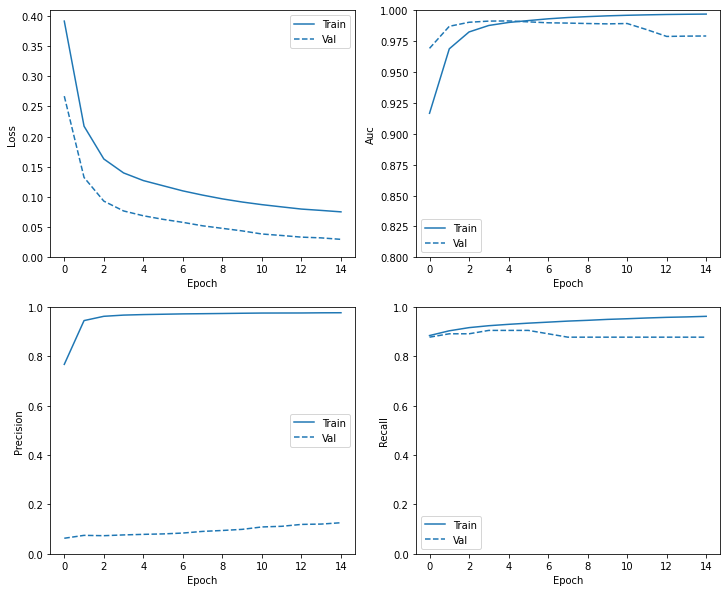

In [47]:
plot_metrics(resampled_history )

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [48]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Train for 20 steps, validate for 23 steps
Epoch 1/1000


 1/20 [>.............................] - ETA: 26s - loss: 1.0075 - tp: 519.0000 - fp: 548.0000 - tn: 442.0000 - fn: 539.0000 - accuracy: 0.4692 - precision: 0.4864 - recall: 0.4905 - auc: 0.4776

 4/20 [=====>........................] - ETA: 5s - loss: 0.9338 - tp: 2210.0000 - fp: 2309.0000 - tn: 1801.0000 - fn: 1872.0000 - accuracy: 0.4896 - precision: 0.4890 - recall: 0.5414 - auc: 0.5214

 7/20 [=========>....................] - ETA: 2s - loss: 0.8886 - tp: 4144.0000 - fp: 4044.0000 - tn: 3151.0000 - fn: 2997.0000 - accuracy: 0.5089 - precision: 0.5061 - recall: 0.5803 - auc: 0.5535

10/20 [==============>...............] - ETA: 1s - loss: 0.8493 - tp: 6262.0000 - fp: 5764.0000 - tn: 4481.0000 - fn: 3973.0000 - accuracy: 0.5246 - precision: 0.5207 - recall: 0.6118 - auc: 0.5827

13/20 [==================>...........] - ETA: 0s - loss: 0.8127 - tp: 8566.0000 - fp: 7458.0000 - tn: 5842.0000 - fn: 4758.0000 - accuracy: 0.5412 - precision: 0.5346 - recall: 0.6429 - auc: 0.6112

16/20 [=======================>......] - ETA: 0s - loss: 0.7832 - tp: 10913.0000 - fp: 9167.0000 - tn: 7224.0000 - fn: 5464.0000 - accuracy: 0.5535 - precision: 0.5435 - recall: 0.6664 - auc: 0.6358

19/20 [===========================>..] - ETA: 0s - loss: 0.7557 - tp: 13426.0000 - fp: 10808.0000 - tn: 8604.0000 - fn: 6074.0000 - accuracy: 0.5661 - precision: 0.5540 - recall: 0.6885 - auc: 0.6589

20/20 [==============================] - 2s 125ms/step - loss: 0.7476 - tp: 14251.0000 - fp: 11410.0000 - tn: 9061.0000 - fn: 6238.0000 - accuracy: 0.5691 - precision: 0.5554 - recall: 0.6955 - auc: 0.6657 - val_loss: 0.7225 - val_tp: 68.0000 - val_fp: 23927.0000 - val_tn: 21569.0000 - val_fn: 5.0000 - val_accuracy: 0.4748 - val_precision: 0.0028 - val_recall: 0.9315 - val_auc: 0.9223


Epoch 2/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5798 - tp: 876.0000 - fp: 563.0000 - tn: 444.0000 - fn: 165.0000 - accuracy: 0.6445 - precision: 0.6088 - recall: 0.8415 - auc: 0.8129

12/20 [=================>............] - ETA: 0s - loss: 0.5565 - tp: 10622.0000 - fp: 6656.0000 - tn: 5568.0000 - fn: 1730.0000 - accuracy: 0.6588 - precision: 0.6148 - recall: 0.8599 - auc: 0.8321

14/20 [====================>.........] - ETA: 0s - loss: 0.5505 - tp: 12461.0000 - fp: 7688.0000 - tn: 6571.0000 - fn: 1952.0000 - accuracy: 0.6638 - precision: 0.6184 - recall: 0.8646 - auc: 0.8374

17/20 [========================>.....] - ETA: 0s - loss: 0.5452 - tp: 15140.0000 - fp: 9320.0000 - tn: 8058.0000 - fn: 2298.0000 - accuracy: 0.6663 - precision: 0.6190 - recall: 0.8682 - auc: 0.8427

20/20 [==============================] - 0s 19ms/step - loss: 0.5403 - tp: 17819.0000 - fp: 10908.0000 - tn: 9601.0000 - fn: 2632.0000 - accuracy: 0.6694 - precision: 0.6203 - recall: 0.8713 - auc: 0.8479 - val_loss: 0.6741 - val_tp: 67.0000 - val_fp: 20133.0000 - val_tn: 25363.0000 - val_fn: 6.0000 - val_accuracy: 0.5581 - val_precision: 0.0033 - val_recall: 0.9178 - val_auc: 0.9309


Epoch 3/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.5045 - tp: 910.0000 - fp: 518.0000 - tn: 512.0000 - fn: 108.0000 - accuracy: 0.6943 - precision: 0.6373 - recall: 0.8939 - auc: 0.8826

 7/20 [=========>....................] - ETA: 0s - loss: 0.4918 - tp: 6405.0000 - fp: 3485.0000 - tn: 3708.0000 - fn: 738.0000 - accuracy: 0.7054 - precision: 0.6476 - recall: 0.8967 - auc: 0.8861

10/20 [==============>...............] - ETA: 0s - loss: 0.4876 - tp: 9181.0000 - fp: 4977.0000 - tn: 5302.0000 - fn: 1020.0000 - accuracy: 0.7072 - precision: 0.6485 - recall: 0.9000 - auc: 0.8888

12/20 [=================>............] - ETA: 0s - loss: 0.4853 - tp: 11017.0000 - fp: 5935.0000 - tn: 6394.0000 - fn: 1230.0000 - accuracy: 0.7085 - precision: 0.6499 - recall: 0.8996 - auc: 0.8894

15/20 [=====================>........] - ETA: 0s - loss: 0.4813 - tp: 13823.0000 - fp: 7335.0000 - tn: 8021.0000 - fn: 1541.0000 - accuracy: 0.7111 - precision: 0.6533 - recall: 0.8997 - auc: 0.8907

18/20 [==========================>...] - ETA: 0s - loss: 0.4779 - tp: 16600.0000 - fp: 8714.0000 - tn: 9726.0000 - fn: 1824.0000 - accuracy: 0.7141 - precision: 0.6558 - recall: 0.9010 - auc: 0.8925

20/20 [==============================] - 1s 26ms/step - loss: 0.4759 - tp: 18479.0000 - fp: 9616.0000 - tn: 10849.0000 - fn: 2016.0000 - accuracy: 0.7160 - precision: 0.6577 - recall: 0.9016 - auc: 0.8937 - val_loss: 0.6132 - val_tp: 67.0000 - val_fp: 15179.0000 - val_tn: 30317.0000 - val_fn: 6.0000 - val_accuracy: 0.6668 - val_precision: 0.0044 - val_recall: 0.9178 - val_auc: 0.9356


Epoch 4/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4740 - tp: 897.0000 - fp: 446.0000 - tn: 611.0000 - fn: 94.0000 - accuracy: 0.7363 - precision: 0.6679 - recall: 0.9051 - auc: 0.9003

 6/20 [========>.....................] - ETA: 0s - loss: 0.4566 - tp: 5458.0000 - fp: 2616.0000 - tn: 3631.0000 - fn: 583.0000 - accuracy: 0.7397 - precision: 0.6760 - recall: 0.9035 - auc: 0.9031

 8/20 [===========>..................] - ETA: 0s - loss: 0.4531 - tp: 7327.0000 - fp: 3454.0000 - tn: 4816.0000 - fn: 787.0000 - accuracy: 0.7411 - precision: 0.6796 - recall: 0.9030 - auc: 0.9036

10/20 [==============>...............] - ETA: 0s - loss: 0.4520 - tp: 9137.0000 - fp: 4296.0000 - tn: 6051.0000 - fn: 996.0000 - accuracy: 0.7416 - precision: 0.6802 - recall: 0.9017 - auc: 0.9038

12/20 [=================>............] - ETA: 0s - loss: 0.4485 - tp: 11012.0000 - fp: 5118.0000 - tn: 7260.0000 - fn: 1186.0000 - accuracy: 0.7435 - precision: 0.6827 - recall: 0.9028 - auc: 0.9053

14/20 [====================>.........] - ETA: 0s - loss: 0.4461 - tp: 12900.0000 - fp: 5921.0000 - tn: 8469.0000 - fn: 1382.0000 - accuracy: 0.7453 - precision: 0.6854 - recall: 0.9032 - auc: 0.9065

17/20 [========================>.....] - ETA: 0s - loss: 0.4430 - tp: 15676.0000 - fp: 7082.0000 - tn: 10370.0000 - fn: 1688.0000 - accuracy: 0.7481 - precision: 0.6888 - recall: 0.9028 - auc: 0.9075

19/20 [===========================>..] - ETA: 0s - loss: 0.4388 - tp: 17650.0000 - fp: 7820.0000 - tn: 11581.0000 - fn: 1861.0000 - accuracy: 0.7512 - precision: 0.6930 - recall: 0.9046 - auc: 0.9095

20/20 [==============================] - 1s 26ms/step - loss: 0.4382 - tp: 18545.0000 - fp: 8202.0000 - tn: 12249.0000 - fn: 1964.0000 - accuracy: 0.7518 - precision: 0.6933 - recall: 0.9042 - auc: 0.9097 - val_loss: 0.5578 - val_tp: 67.0000 - val_fp: 10852.0000 - val_tn: 34644.0000 - val_fn: 6.0000 - val_accuracy: 0.7617 - val_precision: 0.0061 - val_recall: 0.9178 - val_auc: 0.9393


Epoch 5/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.4205 - tp: 894.0000 - fp: 396.0000 - tn: 655.0000 - fn: 103.0000 - accuracy: 0.7563 - precision: 0.6930 - recall: 0.8967 - auc: 0.9159

 7/20 [=========>....................] - ETA: 0s - loss: 0.4146 - tp: 6452.0000 - fp: 2524.0000 - tn: 4670.0000 - fn: 690.0000 - accuracy: 0.7758 - precision: 0.7188 - recall: 0.9034 - auc: 0.9192

10/20 [==============>...............] - ETA: 0s - loss: 0.4122 - tp: 9284.0000 - fp: 3583.0000 - tn: 6636.0000 - fn: 977.0000 - accuracy: 0.7773 - precision: 0.7215 - recall: 0.9048 - auc: 0.9201

13/20 [==================>...........] - ETA: 0s - loss: 0.4125 - tp: 12017.0000 - fp: 4633.0000 - tn: 8695.0000 - fn: 1279.0000 - accuracy: 0.7779 - precision: 0.7217 - recall: 0.9038 - auc: 0.9195

16/20 [=======================>......] - ETA: 0s - loss: 0.4081 - tp: 14840.0000 - fp: 5589.0000 - tn: 10777.0000 - fn: 1562.0000 - accuracy: 0.7818 - precision: 0.7264 - recall: 0.9048 - auc: 0.9212

19/20 [===========================>..] - ETA: 0s - loss: 0.4065 - tp: 17604.0000 - fp: 6586.0000 - tn: 12857.0000 - fn: 1865.0000 - accuracy: 0.7828 - precision: 0.7277 - recall: 0.9042 - auc: 0.9212

20/20 [==============================] - 0s 23ms/step - loss: 0.4060 - tp: 18486.0000 - fp: 6915.0000 - tn: 13598.0000 - fn: 1961.0000 - accuracy: 0.7833 - precision: 0.7278 - recall: 0.9041 - auc: 0.9215 - val_loss: 0.5103 - val_tp: 66.0000 - val_fp: 7485.0000 - val_tn: 38011.0000 - val_fn: 7.0000 - val_accuracy: 0.8356 - val_precision: 0.0087 - val_recall: 0.9041 - val_auc: 0.9420


Epoch 6/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.3832 - tp: 947.0000 - fp: 302.0000 - tn: 707.0000 - fn: 92.0000 - accuracy: 0.8076 - precision: 0.7582 - recall: 0.9115 - auc: 0.9290

 7/20 [=========>....................] - ETA: 0s - loss: 0.3836 - tp: 6608.0000 - fp: 2088.0000 - tn: 4959.0000 - fn: 681.0000 - accuracy: 0.8068 - precision: 0.7599 - recall: 0.9066 - auc: 0.9283

10/20 [==============>...............] - ETA: 0s - loss: 0.3822 - tp: 9373.0000 - fp: 2935.0000 - tn: 7206.0000 - fn: 966.0000 - accuracy: 0.8095 - precision: 0.7615 - recall: 0.9066 - auc: 0.9296

13/20 [==================>...........] - ETA: 0s - loss: 0.3822 - tp: 12156.0000 - fp: 3799.0000 - tn: 9414.0000 - fn: 1255.0000 - accuracy: 0.8102 - precision: 0.7619 - recall: 0.9064 - auc: 0.9296

16/20 [=======================>......] - ETA: 0s - loss: 0.3815 - tp: 14922.0000 - fp: 4627.0000 - tn: 11671.0000 - fn: 1548.0000 - accuracy: 0.8116 - precision: 0.7633 - recall: 0.9060 - auc: 0.9299

19/20 [===========================>..] - ETA: 0s - loss: 0.3809 - tp: 17692.0000 - fp: 5452.0000 - tn: 13910.0000 - fn: 1858.0000 - accuracy: 0.8121 - precision: 0.7644 - recall: 0.9050 - auc: 0.9297

20/20 [==============================] - 0s 23ms/step - loss: 0.3808 - tp: 18602.0000 - fp: 5715.0000 - tn: 14678.0000 - fn: 1965.0000 - accuracy: 0.8125 - precision: 0.7650 - recall: 0.9045 - auc: 0.9297 - val_loss: 0.4698 - val_tp: 65.0000 - val_fp: 5110.0000 - val_tn: 40386.0000 - val_fn: 8.0000 - val_accuracy: 0.8877 - val_precision: 0.0126 - val_recall: 0.8904 - val_auc: 0.9449


Epoch 7/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3721 - tp: 933.0000 - fp: 248.0000 - tn: 768.0000 - fn: 99.0000 - accuracy: 0.8306 - precision: 0.7900 - recall: 0.9041 - auc: 0.9326

 7/20 [=========>....................] - ETA: 0s - loss: 0.3695 - tp: 6476.0000 - fp: 1767.0000 - tn: 5378.0000 - fn: 715.0000 - accuracy: 0.8269 - precision: 0.7856 - recall: 0.9006 - auc: 0.9319

10/20 [==============>...............] - ETA: 0s - loss: 0.3684 - tp: 9233.0000 - fp: 2474.0000 - tn: 7750.0000 - fn: 1023.0000 - accuracy: 0.8292 - precision: 0.7887 - recall: 0.9003 - auc: 0.9325

13/20 [==================>...........] - ETA: 0s - loss: 0.3682 - tp: 11967.0000 - fp: 3236.0000 - tn: 10094.0000 - fn: 1327.0000 - accuracy: 0.8286 - precision: 0.7871 - recall: 0.9002 - auc: 0.9325

16/20 [=======================>......] - ETA: 0s - loss: 0.3659 - tp: 14739.0000 - fp: 3915.0000 - tn: 12489.0000 - fn: 1625.0000 - accuracy: 0.8309 - precision: 0.7901 - recall: 0.9007 - auc: 0.9331

19/20 [===========================>..] - ETA: 0s - loss: 0.3645 - tp: 17519.0000 - fp: 4586.0000 - tn: 14840.0000 - fn: 1967.0000 - accuracy: 0.8316 - precision: 0.7925 - recall: 0.8991 - auc: 0.9326

20/20 [==============================] - 0s 22ms/step - loss: 0.3645 - tp: 18446.0000 - fp: 4827.0000 - tn: 15617.0000 - fn: 2070.0000 - accuracy: 0.8316 - precision: 0.7926 - recall: 0.8991 - auc: 0.9326 - val_loss: 0.4342 - val_tp: 65.0000 - val_fp: 3513.0000 - val_tn: 41983.0000 - val_fn: 8.0000 - val_accuracy: 0.9227 - val_precision: 0.0182 - val_recall: 0.8904 - val_auc: 0.9478


Epoch 8/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3530 - tp: 892.0000 - fp: 227.0000 - tn: 829.0000 - fn: 100.0000 - accuracy: 0.8403 - precision: 0.7971 - recall: 0.8992 - auc: 0.9378

 7/20 [=========>....................] - ETA: 0s - loss: 0.3478 - tp: 6394.0000 - fp: 1454.0000 - tn: 5759.0000 - fn: 729.0000 - accuracy: 0.8477 - precision: 0.8147 - recall: 0.8977 - auc: 0.9381

 9/20 [============>.................] - ETA: 0s - loss: 0.3472 - tp: 8176.0000 - fp: 1851.0000 - tn: 7489.0000 - fn: 916.0000 - accuracy: 0.8499 - precision: 0.8154 - recall: 0.8993 - auc: 0.9390

12/20 [=================>............] - ETA: 0s - loss: 0.3441 - tp: 11022.0000 - fp: 2415.0000 - tn: 9903.0000 - fn: 1236.0000 - accuracy: 0.8514 - precision: 0.8203 - recall: 0.8992 - auc: 0.9393

15/20 [=====================>........] - ETA: 0s - loss: 0.3435 - tp: 13803.0000 - fp: 3020.0000 - tn: 12361.0000 - fn: 1536.0000 - accuracy: 0.8517 - precision: 0.8205 - recall: 0.8999 - auc: 0.9395

18/20 [==========================>...] - ETA: 0s - loss: 0.3427 - tp: 16538.0000 - fp: 3577.0000 - tn: 14889.0000 - fn: 1860.0000 - accuracy: 0.8525 - precision: 0.8222 - recall: 0.8989 - auc: 0.9393

20/20 [==============================] - 0s 24ms/step - loss: 0.3425 - tp: 18376.0000 - fp: 3992.0000 - tn: 16522.0000 - fn: 2070.0000 - accuracy: 0.8520 - precision: 0.8215 - recall: 0.8988 - auc: 0.9392 - val_loss: 0.4025 - val_tp: 65.0000 - val_fp: 2476.0000 - val_tn: 43020.0000 - val_fn: 8.0000 - val_accuracy: 0.9455 - val_precision: 0.0256 - val_recall: 0.8904 - val_auc: 0.9506


Epoch 9/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3401 - tp: 888.0000 - fp: 182.0000 - tn: 874.0000 - fn: 104.0000 - accuracy: 0.8604 - precision: 0.8299 - recall: 0.8952 - auc: 0.9379

 7/20 [=========>....................] - ETA: 0s - loss: 0.3346 - tp: 6386.0000 - fp: 1250.0000 - tn: 5977.0000 - fn: 723.0000 - accuracy: 0.8624 - precision: 0.8363 - recall: 0.8983 - auc: 0.9415

10/20 [==============>...............] - ETA: 0s - loss: 0.3340 - tp: 9129.0000 - fp: 1749.0000 - tn: 8552.0000 - fn: 1050.0000 - accuracy: 0.8633 - precision: 0.8392 - recall: 0.8968 - auc: 0.9408

13/20 [==================>...........] - ETA: 0s - loss: 0.3327 - tp: 11903.0000 - fp: 2263.0000 - tn: 11115.0000 - fn: 1343.0000 - accuracy: 0.8646 - precision: 0.8403 - recall: 0.8986 - auc: 0.9415

16/20 [=======================>......] - ETA: 0s - loss: 0.3321 - tp: 14647.0000 - fp: 2755.0000 - tn: 13688.0000 - fn: 1678.0000 - accuracy: 0.8647 - precision: 0.8417 - recall: 0.8972 - auc: 0.9414

18/20 [==========================>...] - ETA: 0s - loss: 0.3317 - tp: 16455.0000 - fp: 3096.0000 - tn: 15416.0000 - fn: 1897.0000 - accuracy: 0.8646 - precision: 0.8416 - recall: 0.8966 - auc: 0.9412

20/20 [==============================] - 1s 30ms/step - loss: 0.3314 - tp: 18272.0000 - fp: 3413.0000 - tn: 17156.0000 - fn: 2119.0000 - accuracy: 0.8649 - precision: 0.8426 - recall: 0.8961 - auc: 0.9412 - val_loss: 0.3738 - val_tp: 65.0000 - val_fp: 1912.0000 - val_tn: 43584.0000 - val_fn: 8.0000 - val_accuracy: 0.9579 - val_precision: 0.0329 - val_recall: 0.8904 - val_auc: 0.9535


Epoch 10/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3320 - tp: 876.0000 - fp: 172.0000 - tn: 897.0000 - fn: 103.0000 - accuracy: 0.8657 - precision: 0.8359 - recall: 0.8948 - auc: 0.9416

 6/20 [========>.....................] - ETA: 0s - loss: 0.3194 - tp: 5468.0000 - fp: 887.0000 - tn: 5289.0000 - fn: 644.0000 - accuracy: 0.8754 - precision: 0.8604 - recall: 0.8946 - auc: 0.9447

 9/20 [============>.................] - ETA: 0s - loss: 0.3187 - tp: 8205.0000 - fp: 1348.0000 - tn: 7910.0000 - fn: 969.0000 - accuracy: 0.8743 - precision: 0.8589 - recall: 0.8944 - auc: 0.9445

12/20 [=================>............] - ETA: 0s - loss: 0.3165 - tp: 10968.0000 - fp: 1746.0000 - tn: 10570.0000 - fn: 1292.0000 - accuracy: 0.8764 - precision: 0.8627 - recall: 0.8946 - auc: 0.9449

15/20 [=====================>........] - ETA: 0s - loss: 0.3151 - tp: 13749.0000 - fp: 2149.0000 - tn: 13226.0000 - fn: 1596.0000 - accuracy: 0.8781 - precision: 0.8648 - recall: 0.8960 - auc: 0.9453

18/20 [==========================>...] - ETA: 0s - loss: 0.3148 - tp: 16479.0000 - fp: 2576.0000 - tn: 15885.0000 - fn: 1924.0000 - accuracy: 0.8779 - precision: 0.8648 - recall: 0.8955 - auc: 0.9451

20/20 [==============================] - 1s 26ms/step - loss: 0.3146 - tp: 18308.0000 - fp: 2849.0000 - tn: 17668.0000 - fn: 2135.0000 - accuracy: 0.8783 - precision: 0.8653 - recall: 0.8956 - auc: 0.9452 - val_loss: 0.3481 - val_tp: 64.0000 - val_fp: 1577.0000 - val_tn: 43919.0000 - val_fn: 9.0000 - val_accuracy: 0.9652 - val_precision: 0.0390 - val_recall: 0.8767 - val_auc: 0.9566


Epoch 11/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3036 - tp: 911.0000 - fp: 138.0000 - tn: 891.0000 - fn: 108.0000 - accuracy: 0.8799 - precision: 0.8684 - recall: 0.8940 - auc: 0.9474

 6/20 [========>.....................] - ETA: 0s - loss: 0.3022 - tp: 5516.0000 - fp: 798.0000 - tn: 5335.0000 - fn: 639.0000 - accuracy: 0.8831 - precision: 0.8736 - recall: 0.8962 - auc: 0.9483

 9/20 [============>.................] - ETA: 0s - loss: 0.3032 - tp: 8289.0000 - fp: 1172.0000 - tn: 7970.0000 - fn: 1001.0000 - accuracy: 0.8821 - precision: 0.8761 - recall: 0.8922 - auc: 0.9474

12/20 [=================>............] - ETA: 0s - loss: 0.3003 - tp: 11055.0000 - fp: 1523.0000 - tn: 10688.0000 - fn: 1310.0000 - accuracy: 0.8847 - precision: 0.8789 - recall: 0.8941 - auc: 0.9488

15/20 [=====================>........] - ETA: 0s - loss: 0.2998 - tp: 13786.0000 - fp: 1899.0000 - tn: 13421.0000 - fn: 1614.0000 - accuracy: 0.8856 - precision: 0.8789 - recall: 0.8952 - auc: 0.9491

18/20 [==========================>...] - ETA: 0s - loss: 0.2994 - tp: 16478.0000 - fp: 2285.0000 - tn: 16169.0000 - fn: 1932.0000 - accuracy: 0.8856 - precision: 0.8782 - recall: 0.8951 - auc: 0.9491

20/20 [==============================] - 1s 26ms/step - loss: 0.2998 - tp: 18335.0000 - fp: 2536.0000 - tn: 17945.0000 - fn: 2144.0000 - accuracy: 0.8857 - precision: 0.8785 - recall: 0.8953 - auc: 0.9488 - val_loss: 0.3254 - val_tp: 64.0000 - val_fp: 1353.0000 - val_tn: 44143.0000 - val_fn: 9.0000 - val_accuracy: 0.9701 - val_precision: 0.0452 - val_recall: 0.8767 - val_auc: 0.9598


Epoch 12/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2956 - tp: 879.0000 - fp: 109.0000 - tn: 941.0000 - fn: 119.0000 - accuracy: 0.8887 - precision: 0.8897 - recall: 0.8808 - auc: 0.9480

 6/20 [========>.....................] - ETA: 0s - loss: 0.2942 - tp: 5503.0000 - fp: 692.0000 - tn: 5449.0000 - fn: 644.0000 - accuracy: 0.8913 - precision: 0.8883 - recall: 0.8952 - auc: 0.9496

 9/20 [============>.................] - ETA: 0s - loss: 0.2947 - tp: 8216.0000 - fp: 1054.0000 - tn: 8202.0000 - fn: 960.0000 - accuracy: 0.8907 - precision: 0.8863 - recall: 0.8954 - auc: 0.9496

12/20 [=================>............] - ETA: 0s - loss: 0.2940 - tp: 11013.0000 - fp: 1413.0000 - tn: 10862.0000 - fn: 1288.0000 - accuracy: 0.8901 - precision: 0.8863 - recall: 0.8953 - auc: 0.9493

15/20 [=====================>........] - ETA: 0s - loss: 0.2921 - tp: 13759.0000 - fp: 1734.0000 - tn: 13622.0000 - fn: 1605.0000 - accuracy: 0.8913 - precision: 0.8881 - recall: 0.8955 - auc: 0.9502

18/20 [==========================>...] - ETA: 0s - loss: 0.2905 - tp: 16537.0000 - fp: 2053.0000 - tn: 16349.0000 - fn: 1925.0000 - accuracy: 0.8921 - precision: 0.8896 - recall: 0.8957 - auc: 0.9506

20/20 [==============================] - 1s 26ms/step - loss: 0.2903 - tp: 18377.0000 - fp: 2276.0000 - tn: 18178.0000 - fn: 2129.0000 - accuracy: 0.8925 - precision: 0.8898 - recall: 0.8962 - auc: 0.9509 - val_loss: 0.3036 - val_tp: 64.0000 - val_fp: 1181.0000 - val_tn: 44315.0000 - val_fn: 9.0000 - val_accuracy: 0.9739 - val_precision: 0.0514 - val_recall: 0.8767 - val_auc: 0.9637


Epoch 13/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.3023 - tp: 909.0000 - fp: 117.0000 - tn: 903.0000 - fn: 119.0000 - accuracy: 0.8848 - precision: 0.8860 - recall: 0.8842 - auc: 0.9432

 6/20 [========>.....................] - ETA: 0s - loss: 0.2872 - tp: 5479.0000 - fp: 621.0000 - tn: 5512.0000 - fn: 676.0000 - accuracy: 0.8944 - precision: 0.8982 - recall: 0.8902 - auc: 0.9496

 8/20 [===========>..................] - ETA: 0s - loss: 0.2884 - tp: 7308.0000 - fp: 829.0000 - tn: 7353.0000 - fn: 894.0000 - accuracy: 0.8948 - precision: 0.8981 - recall: 0.8910 - auc: 0.9498

11/20 [===============>..............] - ETA: 0s - loss: 0.2844 - tp: 10096.0000 - fp: 1113.0000 - tn: 10121.0000 - fn: 1198.0000 - accuracy: 0.8974 - precision: 0.9007 - recall: 0.8939 - auc: 0.9519

14/20 [====================>.........] - ETA: 0s - loss: 0.2836 - tp: 12810.0000 - fp: 1423.0000 - tn: 12938.0000 - fn: 1501.0000 - accuracy: 0.8980 - precision: 0.9000 - recall: 0.8951 - auc: 0.9524

17/20 [========================>.....] - ETA: 0s - loss: 0.2830 - tp: 15521.0000 - fp: 1737.0000 - tn: 15728.0000 - fn: 1830.0000 - accuracy: 0.8975 - precision: 0.8994 - recall: 0.8945 - auc: 0.9524

20/20 [==============================] - 0s 25ms/step - loss: 0.2819 - tp: 18285.0000 - fp: 2011.0000 - tn: 18509.0000 - fn: 2155.0000 - accuracy: 0.8983 - precision: 0.9009 - recall: 0.8946 - auc: 0.9527 - val_loss: 0.2845 - val_tp: 64.0000 - val_fp: 1082.0000 - val_tn: 44414.0000 - val_fn: 9.0000 - val_accuracy: 0.9761 - val_precision: 0.0558 - val_recall: 0.8767 - val_auc: 0.9670


Epoch 14/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2807 - tp: 931.0000 - fp: 108.0000 - tn: 900.0000 - fn: 109.0000 - accuracy: 0.8940 - precision: 0.8961 - recall: 0.8952 - auc: 0.9514

 7/20 [=========>....................] - ETA: 0s - loss: 0.2717 - tp: 6519.0000 - fp: 616.0000 - tn: 6432.0000 - fn: 769.0000 - accuracy: 0.9034 - precision: 0.9137 - recall: 0.8945 - auc: 0.9547

10/20 [==============>...............] - ETA: 0s - loss: 0.2710 - tp: 9245.0000 - fp: 880.0000 - tn: 9277.0000 - fn: 1078.0000 - accuracy: 0.9044 - precision: 0.9131 - recall: 0.8956 - auc: 0.9553

13/20 [==================>...........] - ETA: 0s - loss: 0.2712 - tp: 11924.0000 - fp: 1138.0000 - tn: 12152.0000 - fn: 1410.0000 - accuracy: 0.9043 - precision: 0.9129 - recall: 0.8943 - auc: 0.9550

15/20 [=====================>........] - ETA: 0s - loss: 0.2701 - tp: 13778.0000 - fp: 1297.0000 - tn: 14026.0000 - fn: 1619.0000 - accuracy: 0.9051 - precision: 0.9140 - recall: 0.8948 - auc: 0.9552

18/20 [==========================>...] - ETA: 0s - loss: 0.2709 - tp: 16500.0000 - fp: 1531.0000 - tn: 16871.0000 - fn: 1962.0000 - accuracy: 0.9052 - precision: 0.9151 - recall: 0.8937 - auc: 0.9546

20/20 [==============================] - 0s 24ms/step - loss: 0.2699 - tp: 18326.0000 - fp: 1700.0000 - tn: 18753.0000 - fn: 2181.0000 - accuracy: 0.9052 - precision: 0.9151 - recall: 0.8936 - auc: 0.9549 - val_loss: 0.2673 - val_tp: 64.0000 - val_fp: 1008.0000 - val_tn: 44488.0000 - val_fn: 9.0000 - val_accuracy: 0.9777 - val_precision: 0.0597 - val_recall: 0.8767 - val_auc: 0.9709


Epoch 15/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2681 - tp: 913.0000 - fp: 78.0000 - tn: 947.0000 - fn: 110.0000 - accuracy: 0.9082 - precision: 0.9213 - recall: 0.8925 - auc: 0.9528

 7/20 [=========>....................] - ETA: 0s - loss: 0.2627 - tp: 6404.0000 - fp: 582.0000 - tn: 6601.0000 - fn: 749.0000 - accuracy: 0.9072 - precision: 0.9167 - recall: 0.8953 - auc: 0.9582

10/20 [==============>...............] - ETA: 0s - loss: 0.2622 - tp: 9109.0000 - fp: 838.0000 - tn: 9477.0000 - fn: 1056.0000 - accuracy: 0.9075 - precision: 0.9158 - recall: 0.8961 - auc: 0.9582

13/20 [==================>...........] - ETA: 0s - loss: 0.2602 - tp: 11851.0000 - fp: 1045.0000 - tn: 12357.0000 - fn: 1371.0000 - accuracy: 0.9093 - precision: 0.9190 - recall: 0.8963 - auc: 0.9586

16/20 [=======================>......] - ETA: 0s - loss: 0.2594 - tp: 14643.0000 - fp: 1291.0000 - tn: 15147.0000 - fn: 1687.0000 - accuracy: 0.9091 - precision: 0.9190 - recall: 0.8967 - auc: 0.9587

19/20 [===========================>..] - ETA: 0s - loss: 0.2591 - tp: 17395.0000 - fp: 1527.0000 - tn: 17985.0000 - fn: 2005.0000 - accuracy: 0.9092 - precision: 0.9193 - recall: 0.8966 - auc: 0.9587

20/20 [==============================] - 0s 22ms/step - loss: 0.2590 - tp: 18331.0000 - fp: 1605.0000 - tn: 18906.0000 - fn: 2118.0000 - accuracy: 0.9091 - precision: 0.9195 - recall: 0.8964 - auc: 0.9586 - val_loss: 0.2511 - val_tp: 64.0000 - val_fp: 955.0000 - val_tn: 44541.0000 - val_fn: 9.0000 - val_accuracy: 0.9788 - val_precision: 0.0628 - val_recall: 0.8767 - val_auc: 0.9742


Epoch 16/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2487 - tp: 937.0000 - fp: 71.0000 - tn: 945.0000 - fn: 95.0000 - accuracy: 0.9189 - precision: 0.9296 - recall: 0.9079 - auc: 0.9613

 7/20 [=========>....................] - ETA: 0s - loss: 0.2521 - tp: 6546.0000 - fp: 512.0000 - tn: 6538.0000 - fn: 740.0000 - accuracy: 0.9127 - precision: 0.9275 - recall: 0.8984 - auc: 0.9596

10/20 [==============>...............] - ETA: 0s - loss: 0.2536 - tp: 9267.0000 - fp: 743.0000 - tn: 9423.0000 - fn: 1047.0000 - accuracy: 0.9126 - precision: 0.9258 - recall: 0.8985 - auc: 0.9593

12/20 [=================>............] - ETA: 0s - loss: 0.2529 - tp: 11147.0000 - fp: 886.0000 - tn: 11277.0000 - fn: 1266.0000 - accuracy: 0.9124 - precision: 0.9264 - recall: 0.8980 - auc: 0.9595

14/20 [====================>.........] - ETA: 0s - loss: 0.2533 - tp: 12985.0000 - fp: 1022.0000 - tn: 13181.0000 - fn: 1484.0000 - accuracy: 0.9126 - precision: 0.9270 - recall: 0.8974 - auc: 0.9592

17/20 [========================>.....] - ETA: 0s - loss: 0.2520 - tp: 15728.0000 - fp: 1220.0000 - tn: 16072.0000 - fn: 1796.0000 - accuracy: 0.9134 - precision: 0.9280 - recall: 0.8975 - auc: 0.9595

20/20 [==============================] - 0s 24ms/step - loss: 0.2503 - tp: 18507.0000 - fp: 1409.0000 - tn: 18952.0000 - fn: 2092.0000 - accuracy: 0.9145 - precision: 0.9293 - recall: 0.8984 - auc: 0.9603 - val_loss: 0.2363 - val_tp: 65.0000 - val_fp: 906.0000 - val_tn: 44590.0000 - val_fn: 8.0000 - val_accuracy: 0.9799 - val_precision: 0.0669 - val_recall: 0.8904 - val_auc: 0.9770


Epoch 17/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2507 - tp: 912.0000 - fp: 65.0000 - tn: 952.0000 - fn: 119.0000 - accuracy: 0.9102 - precision: 0.9335 - recall: 0.8846 - auc: 0.9584

 7/20 [=========>....................] - ETA: 0s - loss: 0.2429 - tp: 6445.0000 - fp: 467.0000 - tn: 6690.0000 - fn: 734.0000 - accuracy: 0.9162 - precision: 0.9324 - recall: 0.8978 - auc: 0.9635

10/20 [==============>...............] - ETA: 0s - loss: 0.2433 - tp: 9188.0000 - fp: 672.0000 - tn: 9578.0000 - fn: 1042.0000 - accuracy: 0.9163 - precision: 0.9318 - recall: 0.8981 - auc: 0.9633

13/20 [==================>...........] - ETA: 0s - loss: 0.2422 - tp: 11987.0000 - fp: 852.0000 - tn: 12409.0000 - fn: 1376.0000 - accuracy: 0.9163 - precision: 0.9336 - recall: 0.8970 - auc: 0.9632

16/20 [=======================>......] - ETA: 0s - loss: 0.2422 - tp: 14698.0000 - fp: 1046.0000 - tn: 15333.0000 - fn: 1691.0000 - accuracy: 0.9165 - precision: 0.9336 - recall: 0.8968 - auc: 0.9630

19/20 [===========================>..] - ETA: 0s - loss: 0.2424 - tp: 17494.0000 - fp: 1256.0000 - tn: 18159.0000 - fn: 2003.0000 - accuracy: 0.9162 - precision: 0.9330 - recall: 0.8973 - auc: 0.9627

20/20 [==============================] - 0s 23ms/step - loss: 0.2424 - tp: 18404.0000 - fp: 1323.0000 - tn: 19123.0000 - fn: 2110.0000 - accuracy: 0.9162 - precision: 0.9329 - recall: 0.8971 - auc: 0.9627 - val_loss: 0.2219 - val_tp: 65.0000 - val_fp: 867.0000 - val_tn: 44629.0000 - val_fn: 8.0000 - val_accuracy: 0.9808 - val_precision: 0.0697 - val_recall: 0.8904 - val_auc: 0.9795


Epoch 18/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.2359 - tp: 907.0000 - fp: 56.0000 - tn: 982.0000 - fn: 103.0000 - accuracy: 0.9224 - precision: 0.9418 - recall: 0.8980 - auc: 0.9647

 7/20 [=========>....................] - ETA: 0s - loss: 0.2362 - tp: 6411.0000 - fp: 419.0000 - tn: 6772.0000 - fn: 734.0000 - accuracy: 0.9196 - precision: 0.9387 - recall: 0.8973 - auc: 0.9639

10/20 [==============>...............] - ETA: 0s - loss: 0.2362 - tp: 9163.0000 - fp: 614.0000 - tn: 9645.0000 - fn: 1058.0000 - accuracy: 0.9184 - precision: 0.9372 - recall: 0.8965 - auc: 0.9637

13/20 [==================>...........] - ETA: 0s - loss: 0.2366 - tp: 11943.0000 - fp: 814.0000 - tn: 12487.0000 - fn: 1380.0000 - accuracy: 0.9176 - precision: 0.9362 - recall: 0.8964 - auc: 0.9633

16/20 [=======================>......] - ETA: 0s - loss: 0.2365 - tp: 14698.0000 - fp: 1009.0000 - tn: 15366.0000 - fn: 1695.0000 - accuracy: 0.9175 - precision: 0.9358 - recall: 0.8966 - auc: 0.9635

19/20 [===========================>..] - ETA: 0s - loss: 0.2357 - tp: 17525.0000 - fp: 1186.0000 - tn: 18189.0000 - fn: 2012.0000 - accuracy: 0.9178 - precision: 0.9366 - recall: 0.8970 - auc: 0.9640

20/20 [==============================] - 1s 29ms/step - loss: 0.2357 - tp: 18408.0000 - fp: 1240.0000 - tn: 19192.0000 - fn: 2120.0000 - accuracy: 0.9180 - precision: 0.9369 - recall: 0.8967 - auc: 0.9640 - val_loss: 0.2082 - val_tp: 65.0000 - val_fp: 826.0000 - val_tn: 44670.0000 - val_fn: 8.0000 - val_accuracy: 0.9817 - val_precision: 0.0730 - val_recall: 0.8904 - val_auc: 0.9812


Epoch 19/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2331 - tp: 913.0000 - fp: 59.0000 - tn: 972.0000 - fn: 104.0000 - accuracy: 0.9204 - precision: 0.9393 - recall: 0.8977 - auc: 0.9653

 7/20 [=========>....................] - ETA: 0s - loss: 0.2269 - tp: 6375.0000 - fp: 380.0000 - tn: 6865.0000 - fn: 716.0000 - accuracy: 0.9235 - precision: 0.9437 - recall: 0.8990 - auc: 0.9662

10/20 [==============>...............] - ETA: 0s - loss: 0.2251 - tp: 9130.0000 - fp: 528.0000 - tn: 9809.0000 - fn: 1013.0000 - accuracy: 0.9248 - precision: 0.9453 - recall: 0.9001 - auc: 0.9670

13/20 [==================>...........] - ETA: 0s - loss: 0.2243 - tp: 11933.0000 - fp: 699.0000 - tn: 12672.0000 - fn: 1320.0000 - accuracy: 0.9242 - precision: 0.9447 - recall: 0.9004 - auc: 0.9668

16/20 [=======================>......] - ETA: 0s - loss: 0.2237 - tp: 14718.0000 - fp: 843.0000 - tn: 15579.0000 - fn: 1628.0000 - accuracy: 0.9246 - precision: 0.9458 - recall: 0.9004 - auc: 0.9668

19/20 [===========================>..] - ETA: 0s - loss: 0.2241 - tp: 17442.0000 - fp: 1009.0000 - tn: 18540.0000 - fn: 1921.0000 - accuracy: 0.9247 - precision: 0.9453 - recall: 0.9008 - auc: 0.9668

20/20 [==============================] - 1s 25ms/step - loss: 0.2238 - tp: 18341.0000 - fp: 1058.0000 - tn: 19550.0000 - fn: 2011.0000 - accuracy: 0.9251 - precision: 0.9455 - recall: 0.9012 - auc: 0.9668 - val_loss: 0.1960 - val_tp: 65.0000 - val_fp: 812.0000 - val_tn: 44684.0000 - val_fn: 8.0000 - val_accuracy: 0.9820 - val_precision: 0.0741 - val_recall: 0.8904 - val_auc: 0.9829


Epoch 20/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2213 - tp: 919.0000 - fp: 68.0000 - tn: 964.0000 - fn: 97.0000 - accuracy: 0.9194 - precision: 0.9311 - recall: 0.9045 - auc: 0.9688

 7/20 [=========>....................] - ETA: 0s - loss: 0.2192 - tp: 6425.0000 - fp: 409.0000 - tn: 6793.0000 - fn: 709.0000 - accuracy: 0.9220 - precision: 0.9402 - recall: 0.9006 - auc: 0.9689

10/20 [==============>...............] - ETA: 0s - loss: 0.2197 - tp: 9185.0000 - fp: 575.0000 - tn: 9709.0000 - fn: 1011.0000 - accuracy: 0.9226 - precision: 0.9411 - recall: 0.9008 - auc: 0.9688

12/20 [=================>............] - ETA: 0s - loss: 0.2214 - tp: 11008.0000 - fp: 677.0000 - tn: 11658.0000 - fn: 1233.0000 - accuracy: 0.9223 - precision: 0.9421 - recall: 0.8993 - auc: 0.9678

15/20 [=====================>........] - ETA: 0s - loss: 0.2204 - tp: 13784.0000 - fp: 826.0000 - tn: 14562.0000 - fn: 1548.0000 - accuracy: 0.9227 - precision: 0.9435 - recall: 0.8990 - auc: 0.9681

18/20 [==========================>...] - ETA: 0s - loss: 0.2203 - tp: 16614.0000 - fp: 996.0000 - tn: 17404.0000 - fn: 1850.0000 - accuracy: 0.9228 - precision: 0.9434 - recall: 0.8998 - auc: 0.9682

20/20 [==============================] - 1s 25ms/step - loss: 0.2203 - tp: 18450.0000 - fp: 1100.0000 - tn: 19345.0000 - fn: 2065.0000 - accuracy: 0.9227 - precision: 0.9437 - recall: 0.8993 - auc: 0.9680 - val_loss: 0.1843 - val_tp: 64.0000 - val_fp: 798.0000 - val_tn: 44698.0000 - val_fn: 9.0000 - val_accuracy: 0.9823 - val_precision: 0.0742 - val_recall: 0.8767 - val_auc: 0.9837


Epoch 21/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2137 - tp: 963.0000 - fp: 56.0000 - tn: 932.0000 - fn: 97.0000 - accuracy: 0.9253 - precision: 0.9450 - recall: 0.9085 - auc: 0.9701

 6/20 [========>.....................] - ETA: 0s - loss: 0.2155 - tp: 5522.0000 - fp: 302.0000 - tn: 5864.0000 - fn: 600.0000 - accuracy: 0.9266 - precision: 0.9481 - recall: 0.9020 - auc: 0.9682

 9/20 [============>.................] - ETA: 0s - loss: 0.2136 - tp: 8328.0000 - fp: 441.0000 - tn: 8754.0000 - fn: 909.0000 - accuracy: 0.9268 - precision: 0.9497 - recall: 0.9016 - auc: 0.9696

12/20 [=================>............] - ETA: 0s - loss: 0.2130 - tp: 11095.0000 - fp: 572.0000 - tn: 11695.0000 - fn: 1214.0000 - accuracy: 0.9273 - precision: 0.9510 - recall: 0.9014 - auc: 0.9698

15/20 [=====================>........] - ETA: 0s - loss: 0.2144 - tp: 13808.0000 - fp: 737.0000 - tn: 14648.0000 - fn: 1527.0000 - accuracy: 0.9263 - precision: 0.9493 - recall: 0.9004 - auc: 0.9694

18/20 [==========================>...] - ETA: 0s - loss: 0.2139 - tp: 16607.0000 - fp: 886.0000 - tn: 17537.0000 - fn: 1834.0000 - accuracy: 0.9262 - precision: 0.9494 - recall: 0.9005 - auc: 0.9694

20/20 [==============================] - 1s 25ms/step - loss: 0.2128 - tp: 18492.0000 - fp: 980.0000 - tn: 19467.0000 - fn: 2021.0000 - accuracy: 0.9267 - precision: 0.9497 - recall: 0.9015 - auc: 0.9698 - val_loss: 0.1737 - val_tp: 64.0000 - val_fp: 776.0000 - val_tn: 44720.0000 - val_fn: 9.0000 - val_accuracy: 0.9828 - val_precision: 0.0762 - val_recall: 0.8767 - val_auc: 0.9848


Epoch 22/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2028 - tp: 928.0000 - fp: 35.0000 - tn: 972.0000 - fn: 113.0000 - accuracy: 0.9277 - precision: 0.9637 - recall: 0.8915 - auc: 0.9705

 6/20 [========>.....................] - ETA: 0s - loss: 0.2081 - tp: 5581.0000 - fp: 275.0000 - tn: 5808.0000 - fn: 624.0000 - accuracy: 0.9268 - precision: 0.9530 - recall: 0.8994 - auc: 0.9709

 8/20 [===========>..................] - ETA: 0s - loss: 0.2074 - tp: 7424.0000 - fp: 372.0000 - tn: 7766.0000 - fn: 822.0000 - accuracy: 0.9271 - precision: 0.9523 - recall: 0.9003 - auc: 0.9712

11/20 [===============>..............] - ETA: 0s - loss: 0.2072 - tp: 10244.0000 - fp: 516.0000 - tn: 10632.0000 - fn: 1136.0000 - accuracy: 0.9267 - precision: 0.9520 - recall: 0.9002 - auc: 0.9713

14/20 [====================>.........] - ETA: 0s - loss: 0.2074 - tp: 13050.0000 - fp: 665.0000 - tn: 13498.0000 - fn: 1459.0000 - accuracy: 0.9259 - precision: 0.9515 - recall: 0.8994 - auc: 0.9709

17/20 [========================>.....] - ETA: 0s - loss: 0.2061 - tp: 15900.0000 - fp: 793.0000 - tn: 16362.0000 - fn: 1761.0000 - accuracy: 0.9266 - precision: 0.9525 - recall: 0.9003 - auc: 0.9714

20/20 [==============================] - 0s 25ms/step - loss: 0.2048 - tp: 18601.0000 - fp: 925.0000 - tn: 19363.0000 - fn: 2071.0000 - accuracy: 0.9269 - precision: 0.9526 - recall: 0.8998 - auc: 0.9717 - val_loss: 0.1649 - val_tp: 64.0000 - val_fp: 776.0000 - val_tn: 44720.0000 - val_fn: 9.0000 - val_accuracy: 0.9828 - val_precision: 0.0762 - val_recall: 0.8767 - val_auc: 0.9858


Epoch 23/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.2097 - tp: 925.0000 - fp: 61.0000 - tn: 961.0000 - fn: 101.0000 - accuracy: 0.9209 - precision: 0.9381 - recall: 0.9016 - auc: 0.9693

 7/20 [=========>....................] - ETA: 0s - loss: 0.2032 - tp: 6472.0000 - fp: 339.0000 - tn: 6845.0000 - fn: 680.0000 - accuracy: 0.9289 - precision: 0.9502 - recall: 0.9049 - auc: 0.9719

10/20 [==============>...............] - ETA: 0s - loss: 0.2026 - tp: 9267.0000 - fp: 464.0000 - tn: 9779.0000 - fn: 970.0000 - accuracy: 0.9300 - precision: 0.9523 - recall: 0.9052 - auc: 0.9725

13/20 [==================>...........] - ETA: 0s - loss: 0.2008 - tp: 12073.0000 - fp: 576.0000 - tn: 12710.0000 - fn: 1265.0000 - accuracy: 0.9309 - precision: 0.9545 - recall: 0.9052 - auc: 0.9728

16/20 [=======================>......] - ETA: 0s - loss: 0.2007 - tp: 14888.0000 - fp: 714.0000 - tn: 15605.0000 - fn: 1561.0000 - accuracy: 0.9306 - precision: 0.9542 - recall: 0.9051 - auc: 0.9726

19/20 [===========================>..] - ETA: 0s - loss: 0.1999 - tp: 17652.0000 - fp: 833.0000 - tn: 18575.0000 - fn: 1852.0000 - accuracy: 0.9310 - precision: 0.9549 - recall: 0.9050 - auc: 0.9727

20/20 [==============================] - 0s 22ms/step - loss: 0.1994 - tp: 18553.0000 - fp: 888.0000 - tn: 19572.0000 - fn: 1947.0000 - accuracy: 0.9308 - precision: 0.9543 - recall: 0.9050 - auc: 0.9729 - val_loss: 0.1567 - val_tp: 65.0000 - val_fp: 788.0000 - val_tn: 44708.0000 - val_fn: 8.0000 - val_accuracy: 0.9825 - val_precision: 0.0762 - val_recall: 0.8904 - val_auc: 0.9864


Epoch 24/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1966 - tp: 890.0000 - fp: 36.0000 - tn: 1022.0000 - fn: 100.0000 - accuracy: 0.9336 - precision: 0.9611 - recall: 0.8990 - auc: 0.9739

 7/20 [=========>....................] - ETA: 0s - loss: 0.1954 - tp: 6426.0000 - fp: 271.0000 - tn: 6960.0000 - fn: 679.0000 - accuracy: 0.9337 - precision: 0.9595 - recall: 0.9044 - auc: 0.9738

10/20 [==============>...............] - ETA: 0s - loss: 0.1937 - tp: 9171.0000 - fp: 388.0000 - tn: 9952.0000 - fn: 969.0000 - accuracy: 0.9337 - precision: 0.9594 - recall: 0.9044 - auc: 0.9743

13/20 [==================>...........] - ETA: 0s - loss: 0.1961 - tp: 11922.0000 - fp: 527.0000 - tn: 12891.0000 - fn: 1284.0000 - accuracy: 0.9320 - precision: 0.9577 - recall: 0.9028 - auc: 0.9736

16/20 [=======================>......] - ETA: 0s - loss: 0.1947 - tp: 14706.0000 - fp: 659.0000 - tn: 15809.0000 - fn: 1594.0000 - accuracy: 0.9312 - precision: 0.9571 - recall: 0.9022 - auc: 0.9741

19/20 [===========================>..] - ETA: 0s - loss: 0.1956 - tp: 17481.0000 - fp: 783.0000 - tn: 18728.0000 - fn: 1920.0000 - accuracy: 0.9305 - precision: 0.9571 - recall: 0.9010 - auc: 0.9737

20/20 [==============================] - 0s 23ms/step - loss: 0.1953 - tp: 18398.0000 - fp: 824.0000 - tn: 19718.0000 - fn: 2020.0000 - accuracy: 0.9306 - precision: 0.9571 - recall: 0.9011 - auc: 0.9738 - val_loss: 0.1491 - val_tp: 65.0000 - val_fp: 784.0000 - val_tn: 44712.0000 - val_fn: 8.0000 - val_accuracy: 0.9826 - val_precision: 0.0766 - val_recall: 0.8904 - val_auc: 0.9871


Epoch 25/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1933 - tp: 931.0000 - fp: 44.0000 - tn: 965.0000 - fn: 108.0000 - accuracy: 0.9258 - precision: 0.9549 - recall: 0.8961 - auc: 0.9746

 7/20 [=========>....................] - ETA: 0s - loss: 0.1933 - tp: 6547.0000 - fp: 270.0000 - tn: 6823.0000 - fn: 696.0000 - accuracy: 0.9326 - precision: 0.9604 - recall: 0.9039 - auc: 0.9748

10/20 [==============>...............] - ETA: 0s - loss: 0.1927 - tp: 9387.0000 - fp: 392.0000 - tn: 9683.0000 - fn: 1018.0000 - accuracy: 0.9312 - precision: 0.9599 - recall: 0.9022 - auc: 0.9748

13/20 [==================>...........] - ETA: 0s - loss: 0.1926 - tp: 12261.0000 - fp: 511.0000 - tn: 12530.0000 - fn: 1322.0000 - accuracy: 0.9312 - precision: 0.9600 - recall: 0.9027 - auc: 0.9746

16/20 [=======================>......] - ETA: 0s - loss: 0.1936 - tp: 15043.0000 - fp: 649.0000 - tn: 15448.0000 - fn: 1628.0000 - accuracy: 0.9305 - precision: 0.9586 - recall: 0.9023 - auc: 0.9743

19/20 [===========================>..] - ETA: 0s - loss: 0.1936 - tp: 17872.0000 - fp: 772.0000 - tn: 18321.0000 - fn: 1947.0000 - accuracy: 0.9301 - precision: 0.9586 - recall: 0.9018 - auc: 0.9741

20/20 [==============================] - 0s 22ms/step - loss: 0.1934 - tp: 18804.0000 - fp: 814.0000 - tn: 19294.0000 - fn: 2048.0000 - accuracy: 0.9301 - precision: 0.9585 - recall: 0.9018 - auc: 0.9742 - val_loss: 0.1428 - val_tp: 65.0000 - val_fp: 777.0000 - val_tn: 44719.0000 - val_fn: 8.0000 - val_accuracy: 0.9828 - val_precision: 0.0772 - val_recall: 0.8904 - val_auc: 0.9876


Epoch 26/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1867 - tp: 904.0000 - fp: 46.0000 - tn: 1005.0000 - fn: 93.0000 - accuracy: 0.9321 - precision: 0.9516 - recall: 0.9067 - auc: 0.9764

 7/20 [=========>....................] - ETA: 0s - loss: 0.1873 - tp: 6379.0000 - fp: 322.0000 - tn: 6958.0000 - fn: 677.0000 - accuracy: 0.9303 - precision: 0.9519 - recall: 0.9041 - auc: 0.9761

10/20 [==============>...............] - ETA: 0s - loss: 0.1898 - tp: 9110.0000 - fp: 450.0000 - tn: 9932.0000 - fn: 988.0000 - accuracy: 0.9298 - precision: 0.9529 - recall: 0.9022 - auc: 0.9753

13/20 [==================>...........] - ETA: 0s - loss: 0.1925 - tp: 11834.0000 - fp: 610.0000 - tn: 12900.0000 - fn: 1280.0000 - accuracy: 0.9290 - precision: 0.9510 - recall: 0.9024 - auc: 0.9750

16/20 [=======================>......] - ETA: 0s - loss: 0.1901 - tp: 14594.0000 - fp: 727.0000 - tn: 15884.0000 - fn: 1563.0000 - accuracy: 0.9301 - precision: 0.9525 - recall: 0.9033 - auc: 0.9754

19/20 [===========================>..] - ETA: 0s - loss: 0.1895 - tp: 17373.0000 - fp: 870.0000 - tn: 18813.0000 - fn: 1856.0000 - accuracy: 0.9299 - precision: 0.9523 - recall: 0.9035 - auc: 0.9756

20/20 [==============================] - 0s 22ms/step - loss: 0.1902 - tp: 18263.0000 - fp: 917.0000 - tn: 19826.0000 - fn: 1954.0000 - accuracy: 0.9299 - precision: 0.9522 - recall: 0.9033 - auc: 0.9756 - val_loss: 0.1355 - val_tp: 65.0000 - val_fp: 755.0000 - val_tn: 44741.0000 - val_fn: 8.0000 - val_accuracy: 0.9833 - val_precision: 0.0793 - val_recall: 0.8904 - val_auc: 0.9884


Epoch 27/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1819 - tp: 941.0000 - fp: 37.0000 - tn: 984.0000 - fn: 86.0000 - accuracy: 0.9399 - precision: 0.9622 - recall: 0.9163 - auc: 0.9795

 7/20 [=========>....................] - ETA: 0s - loss: 0.1807 - tp: 6403.0000 - fp: 283.0000 - tn: 7012.0000 - fn: 638.0000 - accuracy: 0.9358 - precision: 0.9577 - recall: 0.9094 - auc: 0.9782

10/20 [==============>...............] - ETA: 0s - loss: 0.1821 - tp: 9164.0000 - fp: 431.0000 - tn: 9970.0000 - fn: 915.0000 - accuracy: 0.9343 - precision: 0.9551 - recall: 0.9092 - auc: 0.9778

13/20 [==================>...........] - ETA: 0s - loss: 0.1817 - tp: 11918.0000 - fp: 553.0000 - tn: 12940.0000 - fn: 1213.0000 - accuracy: 0.9337 - precision: 0.9557 - recall: 0.9076 - auc: 0.9778

14/20 [====================>.........] - ETA: 0s - loss: 0.1810 - tp: 12855.0000 - fp: 581.0000 - tn: 13933.0000 - fn: 1303.0000 - accuracy: 0.9343 - precision: 0.9568 - recall: 0.9080 - auc: 0.9779

17/20 [========================>.....] - ETA: 0s - loss: 0.1817 - tp: 15640.0000 - fp: 704.0000 - tn: 16866.0000 - fn: 1606.0000 - accuracy: 0.9337 - precision: 0.9569 - recall: 0.9069 - auc: 0.9780

20/20 [==============================] - 1s 29ms/step - loss: 0.1814 - tp: 18328.0000 - fp: 837.0000 - tn: 19917.0000 - fn: 1878.0000 - accuracy: 0.9337 - precision: 0.9563 - recall: 0.9071 - auc: 0.9779 - val_loss: 0.1278 - val_tp: 65.0000 - val_fp: 727.0000 - val_tn: 44769.0000 - val_fn: 8.0000 - val_accuracy: 0.9839 - val_precision: 0.0821 - val_recall: 0.8904 - val_auc: 0.9888


Epoch 28/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1794 - tp: 947.0000 - fp: 38.0000 - tn: 975.0000 - fn: 88.0000 - accuracy: 0.9385 - precision: 0.9614 - recall: 0.9150 - auc: 0.9780

 7/20 [=========>....................] - ETA: 0s - loss: 0.1790 - tp: 6541.0000 - fp: 266.0000 - tn: 6851.0000 - fn: 678.0000 - accuracy: 0.9342 - precision: 0.9609 - recall: 0.9061 - auc: 0.9786

10/20 [==============>...............] - ETA: 0s - loss: 0.1794 - tp: 9332.0000 - fp: 382.0000 - tn: 9797.0000 - fn: 969.0000 - accuracy: 0.9340 - precision: 0.9607 - recall: 0.9059 - auc: 0.9784

13/20 [==================>...........] - ETA: 0s - loss: 0.1796 - tp: 12046.0000 - fp: 511.0000 - tn: 12794.0000 - fn: 1273.0000 - accuracy: 0.9330 - precision: 0.9593 - recall: 0.9044 - auc: 0.9785

16/20 [=======================>......] - ETA: 0s - loss: 0.1785 - tp: 14814.0000 - fp: 638.0000 - tn: 15754.0000 - fn: 1562.0000 - accuracy: 0.9329 - precision: 0.9587 - recall: 0.9046 - auc: 0.9787

19/20 [===========================>..] - ETA: 0s - loss: 0.1780 - tp: 17606.0000 - fp: 742.0000 - tn: 18699.0000 - fn: 1865.0000 - accuracy: 0.9330 - precision: 0.9596 - recall: 0.9042 - auc: 0.9789

20/20 [==============================] - 0s 25ms/step - loss: 0.1781 - tp: 18549.0000 - fp: 790.0000 - tn: 19659.0000 - fn: 1962.0000 - accuracy: 0.9328 - precision: 0.9591 - recall: 0.9043 - auc: 0.9788 - val_loss: 0.1222 - val_tp: 65.0000 - val_fp: 720.0000 - val_tn: 44776.0000 - val_fn: 8.0000 - val_accuracy: 0.9840 - val_precision: 0.0828 - val_recall: 0.8904 - val_auc: 0.9891


Epoch 29/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1868 - tp: 951.0000 - fp: 48.0000 - tn: 948.0000 - fn: 101.0000 - accuracy: 0.9272 - precision: 0.9520 - recall: 0.9040 - auc: 0.9764

 7/20 [=========>....................] - ETA: 0s - loss: 0.1795 - tp: 6593.0000 - fp: 301.0000 - tn: 6760.0000 - fn: 682.0000 - accuracy: 0.9314 - precision: 0.9563 - recall: 0.9063 - auc: 0.9780

10/20 [==============>...............] - ETA: 0s - loss: 0.1789 - tp: 9373.0000 - fp: 400.0000 - tn: 9741.0000 - fn: 966.0000 - accuracy: 0.9333 - precision: 0.9591 - recall: 0.9066 - auc: 0.9784

13/20 [==================>...........] - ETA: 0s - loss: 0.1784 - tp: 12117.0000 - fp: 522.0000 - tn: 12739.0000 - fn: 1246.0000 - accuracy: 0.9336 - precision: 0.9587 - recall: 0.9068 - auc: 0.9787

16/20 [=======================>......] - ETA: 0s - loss: 0.1773 - tp: 14855.0000 - fp: 637.0000 - tn: 15746.0000 - fn: 1530.0000 - accuracy: 0.9339 - precision: 0.9589 - recall: 0.9066 - auc: 0.9791

19/20 [===========================>..] - ETA: 0s - loss: 0.1760 - tp: 17614.0000 - fp: 750.0000 - tn: 18733.0000 - fn: 1815.0000 - accuracy: 0.9341 - precision: 0.9592 - recall: 0.9066 - auc: 0.9795

20/20 [==============================] - 1s 25ms/step - loss: 0.1759 - tp: 18573.0000 - fp: 793.0000 - tn: 19679.0000 - fn: 1915.0000 - accuracy: 0.9339 - precision: 0.9591 - recall: 0.9065 - auc: 0.9795 - val_loss: 0.1175 - val_tp: 65.0000 - val_fp: 721.0000 - val_tn: 44775.0000 - val_fn: 8.0000 - val_accuracy: 0.9840 - val_precision: 0.0827 - val_recall: 0.8904 - val_auc: 0.9895


Epoch 30/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1658 - tp: 938.0000 - fp: 42.0000 - tn: 984.0000 - fn: 84.0000 - accuracy: 0.9385 - precision: 0.9571 - recall: 0.9178 - auc: 0.9829

 7/20 [=========>....................] - ETA: 0s - loss: 0.1680 - tp: 6542.0000 - fp: 270.0000 - tn: 6868.0000 - fn: 656.0000 - accuracy: 0.9354 - precision: 0.9604 - recall: 0.9089 - auc: 0.9815

10/20 [==============>...............] - ETA: 0s - loss: 0.1709 - tp: 9269.0000 - fp: 390.0000 - tn: 9879.0000 - fn: 942.0000 - accuracy: 0.9350 - precision: 0.9596 - recall: 0.9077 - auc: 0.9810

13/20 [==================>...........] - ETA: 0s - loss: 0.1725 - tp: 12104.0000 - fp: 498.0000 - tn: 12788.0000 - fn: 1234.0000 - accuracy: 0.9349 - precision: 0.9605 - recall: 0.9075 - auc: 0.9805

16/20 [=======================>......] - ETA: 0s - loss: 0.1727 - tp: 14835.0000 - fp: 622.0000 - tn: 15805.0000 - fn: 1506.0000 - accuracy: 0.9351 - precision: 0.9598 - recall: 0.9078 - auc: 0.9805

18/20 [==========================>...] - ETA: 0s - loss: 0.1727 - tp: 16673.0000 - fp: 692.0000 - tn: 17803.0000 - fn: 1696.0000 - accuracy: 0.9352 - precision: 0.9601 - recall: 0.9077 - auc: 0.9803

20/20 [==============================] - 1s 26ms/step - loss: 0.1727 - tp: 18525.0000 - fp: 766.0000 - tn: 19783.0000 - fn: 1886.0000 - accuracy: 0.9353 - precision: 0.9603 - recall: 0.9076 - auc: 0.9802 - val_loss: 0.1130 - val_tp: 65.0000 - val_fp: 714.0000 - val_tn: 44782.0000 - val_fn: 8.0000 - val_accuracy: 0.9842 - val_precision: 0.0834 - val_recall: 0.8904 - val_auc: 0.9898


Epoch 31/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1691 - tp: 941.0000 - fp: 34.0000 - tn: 975.0000 - fn: 98.0000 - accuracy: 0.9355 - precision: 0.9651 - recall: 0.9057 - auc: 0.9808

 6/20 [========>.....................] - ETA: 0s - loss: 0.1676 - tp: 5561.0000 - fp: 223.0000 - tn: 5938.0000 - fn: 566.0000 - accuracy: 0.9358 - precision: 0.9614 - recall: 0.9076 - auc: 0.9812

 8/20 [===========>..................] - ETA: 0s - loss: 0.1672 - tp: 7415.0000 - fp: 306.0000 - tn: 7912.0000 - fn: 751.0000 - accuracy: 0.9355 - precision: 0.9604 - recall: 0.9080 - auc: 0.9813

10/20 [==============>...............] - ETA: 0s - loss: 0.1674 - tp: 9322.0000 - fp: 380.0000 - tn: 9835.0000 - fn: 943.0000 - accuracy: 0.9354 - precision: 0.9608 - recall: 0.9081 - auc: 0.9813

13/20 [==================>...........] - ETA: 0s - loss: 0.1667 - tp: 12136.0000 - fp: 498.0000 - tn: 12788.0000 - fn: 1202.0000 - accuracy: 0.9361 - precision: 0.9606 - recall: 0.9099 - auc: 0.9816

16/20 [=======================>......] - ETA: 0s - loss: 0.1666 - tp: 15013.0000 - fp: 615.0000 - tn: 15659.0000 - fn: 1481.0000 - accuracy: 0.9360 - precision: 0.9606 - recall: 0.9102 - auc: 0.9817

19/20 [===========================>..] - ETA: 0s - loss: 0.1665 - tp: 17809.0000 - fp: 719.0000 - tn: 18618.0000 - fn: 1766.0000 - accuracy: 0.9361 - precision: 0.9612 - recall: 0.9098 - auc: 0.9816

20/20 [==============================] - 0s 25ms/step - loss: 0.1658 - tp: 18773.0000 - fp: 752.0000 - tn: 19585.0000 - fn: 1850.0000 - accuracy: 0.9365 - precision: 0.9615 - recall: 0.9103 - auc: 0.9818 - val_loss: 0.1092 - val_tp: 65.0000 - val_fp: 709.0000 - val_tn: 44787.0000 - val_fn: 8.0000 - val_accuracy: 0.9843 - val_precision: 0.0840 - val_recall: 0.8904 - val_auc: 0.9900


Epoch 32/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1770 - tp: 887.0000 - fp: 38.0000 - tn: 1024.0000 - fn: 99.0000 - accuracy: 0.9331 - precision: 0.9589 - recall: 0.8996 - auc: 0.9787

 8/20 [===========>..................] - ETA: 0s - loss: 0.1697 - tp: 7353.0000 - fp: 299.0000 - tn: 7974.0000 - fn: 758.0000 - accuracy: 0.9355 - precision: 0.9609 - recall: 0.9065 - auc: 0.9808

11/20 [===============>..............] - ETA: 0s - loss: 0.1692 - tp: 10101.0000 - fp: 418.0000 - tn: 10971.0000 - fn: 1038.0000 - accuracy: 0.9354 - precision: 0.9603 - recall: 0.9068 - auc: 0.9808

14/20 [====================>.........] - ETA: 0s - loss: 0.1665 - tp: 12932.0000 - fp: 512.0000 - tn: 13925.0000 - fn: 1303.0000 - accuracy: 0.9367 - precision: 0.9619 - recall: 0.9085 - auc: 0.9815

17/20 [========================>.....] - ETA: 0s - loss: 0.1656 - tp: 15772.0000 - fp: 612.0000 - tn: 16849.0000 - fn: 1583.0000 - accuracy: 0.9370 - precision: 0.9626 - recall: 0.9088 - auc: 0.9817

20/20 [==============================] - 0s 22ms/step - loss: 0.1645 - tp: 18553.0000 - fp: 713.0000 - tn: 19843.0000 - fn: 1851.0000 - accuracy: 0.9374 - precision: 0.9630 - recall: 0.9093 - auc: 0.9819 - val_loss: 0.1064 - val_tp: 65.0000 - val_fp: 713.0000 - val_tn: 44783.0000 - val_fn: 8.0000 - val_accuracy: 0.9842 - val_precision: 0.0835 - val_recall: 0.8904 - val_auc: 0.9902


Epoch 33/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1558 - tp: 912.0000 - fp: 23.0000 - tn: 1025.0000 - fn: 88.0000 - accuracy: 0.9458 - precision: 0.9754 - recall: 0.9120 - auc: 0.9825

 7/20 [=========>....................] - ETA: 0s - loss: 0.1643 - tp: 6493.0000 - fp: 254.0000 - tn: 6956.0000 - fn: 633.0000 - accuracy: 0.9381 - precision: 0.9624 - recall: 0.9112 - auc: 0.9823

10/20 [==============>...............] - ETA: 0s - loss: 0.1638 - tp: 9328.0000 - fp: 355.0000 - tn: 9887.0000 - fn: 910.0000 - accuracy: 0.9382 - precision: 0.9633 - recall: 0.9111 - auc: 0.9824

13/20 [==================>...........] - ETA: 0s - loss: 0.1625 - tp: 12120.0000 - fp: 463.0000 - tn: 12880.0000 - fn: 1161.0000 - accuracy: 0.9390 - precision: 0.9632 - recall: 0.9126 - auc: 0.9827

16/20 [=======================>......] - ETA: 0s - loss: 0.1632 - tp: 14917.0000 - fp: 594.0000 - tn: 15822.0000 - fn: 1435.0000 - accuracy: 0.9381 - precision: 0.9617 - recall: 0.9122 - auc: 0.9825

19/20 [===========================>..] - ETA: 0s - loss: 0.1630 - tp: 17722.0000 - fp: 700.0000 - tn: 18777.0000 - fn: 1713.0000 - accuracy: 0.9380 - precision: 0.9620 - recall: 0.9119 - auc: 0.9825

20/20 [==============================] - 0s 22ms/step - loss: 0.1629 - tp: 18652.0000 - fp: 745.0000 - tn: 19769.0000 - fn: 1794.0000 - accuracy: 0.9380 - precision: 0.9616 - recall: 0.9123 - auc: 0.9826 - val_loss: 0.1037 - val_tp: 65.0000 - val_fp: 725.0000 - val_tn: 44771.0000 - val_fn: 8.0000 - val_accuracy: 0.9839 - val_precision: 0.0823 - val_recall: 0.8904 - val_auc: 0.9901


Epoch 34/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1506 - tp: 961.0000 - fp: 23.0000 - tn: 960.0000 - fn: 104.0000 - accuracy: 0.9380 - precision: 0.9766 - recall: 0.9023 - auc: 0.9851

 7/20 [=========>....................] - ETA: 0s - loss: 0.1542 - tp: 6592.0000 - fp: 230.0000 - tn: 6882.0000 - fn: 632.0000 - accuracy: 0.9399 - precision: 0.9663 - recall: 0.9125 - auc: 0.9845

10/20 [==============>...............] - ETA: 0s - loss: 0.1571 - tp: 9391.0000 - fp: 338.0000 - tn: 9844.0000 - fn: 907.0000 - accuracy: 0.9392 - precision: 0.9653 - recall: 0.9119 - auc: 0.9839

13/20 [==================>...........] - ETA: 0s - loss: 0.1574 - tp: 12161.0000 - fp: 453.0000 - tn: 12851.0000 - fn: 1159.0000 - accuracy: 0.9395 - precision: 0.9641 - recall: 0.9130 - auc: 0.9838

16/20 [=======================>......] - ETA: 0s - loss: 0.1588 - tp: 14963.0000 - fp: 564.0000 - tn: 15804.0000 - fn: 1437.0000 - accuracy: 0.9389 - precision: 0.9637 - recall: 0.9124 - auc: 0.9835

19/20 [===========================>..] - ETA: 0s - loss: 0.1584 - tp: 17727.0000 - fp: 666.0000 - tn: 18833.0000 - fn: 1686.0000 - accuracy: 0.9396 - precision: 0.9638 - recall: 0.9132 - auc: 0.9835

20/20 [==============================] - 0s 23ms/step - loss: 0.1583 - tp: 18664.0000 - fp: 698.0000 - tn: 19819.0000 - fn: 1779.0000 - accuracy: 0.9395 - precision: 0.9639 - recall: 0.9130 - auc: 0.9835 - val_loss: 0.1007 - val_tp: 65.0000 - val_fp: 720.0000 - val_tn: 44776.0000 - val_fn: 8.0000 - val_accuracy: 0.9840 - val_precision: 0.0828 - val_recall: 0.8904 - val_auc: 0.9904


Epoch 35/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1571 - tp: 937.0000 - fp: 31.0000 - tn: 988.0000 - fn: 92.0000 - accuracy: 0.9399 - precision: 0.9680 - recall: 0.9106 - auc: 0.9837

 7/20 [=========>....................] - ETA: 0s - loss: 0.1564 - tp: 6583.0000 - fp: 232.0000 - tn: 6881.0000 - fn: 640.0000 - accuracy: 0.9392 - precision: 0.9660 - recall: 0.9114 - auc: 0.9835

10/20 [==============>...............] - ETA: 0s - loss: 0.1578 - tp: 9338.0000 - fp: 325.0000 - tn: 9897.0000 - fn: 920.0000 - accuracy: 0.9392 - precision: 0.9664 - recall: 0.9103 - auc: 0.9835

13/20 [==================>...........] - ETA: 0s - loss: 0.1576 - tp: 12178.0000 - fp: 433.0000 - tn: 12818.0000 - fn: 1195.0000 - accuracy: 0.9389 - precision: 0.9657 - recall: 0.9106 - auc: 0.9835

16/20 [=======================>......] - ETA: 0s - loss: 0.1583 - tp: 14977.0000 - fp: 544.0000 - tn: 15798.0000 - fn: 1449.0000 - accuracy: 0.9392 - precision: 0.9650 - recall: 0.9118 - auc: 0.9833

19/20 [===========================>..] - ETA: 0s - loss: 0.1580 - tp: 17785.0000 - fp: 651.0000 - tn: 18771.0000 - fn: 1705.0000 - accuracy: 0.9395 - precision: 0.9647 - recall: 0.9125 - auc: 0.9834

20/20 [==============================] - 0s 22ms/step - loss: 0.1575 - tp: 18697.0000 - fp: 681.0000 - tn: 19797.0000 - fn: 1785.0000 - accuracy: 0.9398 - precision: 0.9649 - recall: 0.9129 - auc: 0.9836 - val_loss: 0.0979 - val_tp: 65.0000 - val_fp: 716.0000 - val_tn: 44780.0000 - val_fn: 8.0000 - val_accuracy: 0.9841 - val_precision: 0.0832 - val_recall: 0.8904 - val_auc: 0.9906


Epoch 36/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1538 - tp: 943.0000 - fp: 40.0000 - tn: 985.0000 - fn: 80.0000 - accuracy: 0.9414 - precision: 0.9593 - recall: 0.9218 - auc: 0.9850

 7/20 [=========>....................] - ETA: 0s - loss: 0.1539 - tp: 6548.0000 - fp: 238.0000 - tn: 6936.0000 - fn: 614.0000 - accuracy: 0.9406 - precision: 0.9649 - recall: 0.9143 - auc: 0.9843

10/20 [==============>...............] - ETA: 0s - loss: 0.1534 - tp: 9379.0000 - fp: 353.0000 - tn: 9851.0000 - fn: 897.0000 - accuracy: 0.9390 - precision: 0.9637 - recall: 0.9127 - auc: 0.9844

11/20 [===============>..............] - ETA: 0s - loss: 0.1538 - tp: 10301.0000 - fp: 388.0000 - tn: 10851.0000 - fn: 988.0000 - accuracy: 0.9389 - precision: 0.9637 - recall: 0.9125 - auc: 0.9844

14/20 [====================>.........] - ETA: 0s - loss: 0.1528 - tp: 13104.0000 - fp: 476.0000 - tn: 13838.0000 - fn: 1254.0000 - accuracy: 0.9397 - precision: 0.9649 - recall: 0.9127 - auc: 0.9847

17/20 [========================>.....] - ETA: 0s - loss: 0.1526 - tp: 15949.0000 - fp: 572.0000 - tn: 16773.0000 - fn: 1522.0000 - accuracy: 0.9399 - precision: 0.9654 - recall: 0.9129 - auc: 0.9848

20/20 [==============================] - 1s 31ms/step - loss: 0.1533 - tp: 18731.0000 - fp: 689.0000 - tn: 19751.0000 - fn: 1789.0000 - accuracy: 0.9395 - precision: 0.9645 - recall: 0.9128 - auc: 0.9847 - val_loss: 0.0954 - val_tp: 66.0000 - val_fp: 713.0000 - val_tn: 44783.0000 - val_fn: 7.0000 - val_accuracy: 0.9842 - val_precision: 0.0847 - val_recall: 0.9041 - val_auc: 0.9905


Epoch 37/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1476 - tp: 917.0000 - fp: 44.0000 - tn: 1007.0000 - fn: 80.0000 - accuracy: 0.9395 - precision: 0.9542 - recall: 0.9198 - auc: 0.9860

 7/20 [=========>....................] - ETA: 0s - loss: 0.1544 - tp: 6464.0000 - fp: 264.0000 - tn: 7002.0000 - fn: 606.0000 - accuracy: 0.9393 - precision: 0.9608 - recall: 0.9143 - auc: 0.9847

10/20 [==============>...............] - ETA: 0s - loss: 0.1545 - tp: 9241.0000 - fp: 393.0000 - tn: 9970.0000 - fn: 876.0000 - accuracy: 0.9380 - precision: 0.9592 - recall: 0.9134 - auc: 0.9845

13/20 [==================>...........] - ETA: 0s - loss: 0.1542 - tp: 12031.0000 - fp: 509.0000 - tn: 12959.0000 - fn: 1125.0000 - accuracy: 0.9386 - precision: 0.9594 - recall: 0.9145 - auc: 0.9847

16/20 [=======================>......] - ETA: 0s - loss: 0.1540 - tp: 14878.0000 - fp: 610.0000 - tn: 15893.0000 - fn: 1387.0000 - accuracy: 0.9391 - precision: 0.9606 - recall: 0.9147 - auc: 0.9847

19/20 [===========================>..] - ETA: 0s - loss: 0.1543 - tp: 17720.0000 - fp: 714.0000 - tn: 18830.0000 - fn: 1648.0000 - accuracy: 0.9393 - precision: 0.9613 - recall: 0.9149 - auc: 0.9846

20/20 [==============================] - 1s 25ms/step - loss: 0.1539 - tp: 18661.0000 - fp: 749.0000 - tn: 19818.0000 - fn: 1732.0000 - accuracy: 0.9394 - precision: 0.9614 - recall: 0.9151 - auc: 0.9847 - val_loss: 0.0932 - val_tp: 65.0000 - val_fp: 714.0000 - val_tn: 44782.0000 - val_fn: 8.0000 - val_accuracy: 0.9842 - val_precision: 0.0834 - val_recall: 0.8904 - val_auc: 0.9908


Epoch 38/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1528 - tp: 952.0000 - fp: 41.0000 - tn: 978.0000 - fn: 77.0000 - accuracy: 0.9424 - precision: 0.9587 - recall: 0.9252 - auc: 0.9848

 7/20 [=========>....................] - ETA: 0s - loss: 0.1552 - tp: 6519.0000 - fp: 253.0000 - tn: 6964.0000 - fn: 600.0000 - accuracy: 0.9405 - precision: 0.9626 - recall: 0.9157 - auc: 0.9845

10/20 [==============>...............] - ETA: 0s - loss: 0.1532 - tp: 9296.0000 - fp: 356.0000 - tn: 9961.0000 - fn: 867.0000 - accuracy: 0.9403 - precision: 0.9631 - recall: 0.9147 - auc: 0.9847

13/20 [==================>...........] - ETA: 0s - loss: 0.1537 - tp: 12102.0000 - fp: 452.0000 - tn: 12945.0000 - fn: 1125.0000 - accuracy: 0.9408 - precision: 0.9640 - recall: 0.9149 - auc: 0.9846

15/20 [=====================>........] - ETA: 0s - loss: 0.1541 - tp: 13971.0000 - fp: 524.0000 - tn: 14919.0000 - fn: 1306.0000 - accuracy: 0.9404 - precision: 0.9638 - recall: 0.9145 - auc: 0.9846

17/20 [========================>.....] - ETA: 0s - loss: 0.1533 - tp: 15820.0000 - fp: 589.0000 - tn: 16925.0000 - fn: 1482.0000 - accuracy: 0.9405 - precision: 0.9641 - recall: 0.9143 - auc: 0.9848

20/20 [==============================] - 1s 26ms/step - loss: 0.1540 - tp: 18592.0000 - fp: 699.0000 - tn: 19922.0000 - fn: 1747.0000 - accuracy: 0.9403 - precision: 0.9638 - recall: 0.9141 - auc: 0.9847 - val_loss: 0.0912 - val_tp: 65.0000 - val_fp: 717.0000 - val_tn: 44779.0000 - val_fn: 8.0000 - val_accuracy: 0.9841 - val_precision: 0.0831 - val_recall: 0.8904 - val_auc: 0.9908


Epoch 39/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1551 - tp: 961.0000 - fp: 28.0000 - tn: 961.0000 - fn: 98.0000 - accuracy: 0.9385 - precision: 0.9717 - recall: 0.9075 - auc: 0.9840

 7/20 [=========>....................] - ETA: 0s - loss: 0.1526 - tp: 6611.0000 - fp: 247.0000 - tn: 6863.0000 - fn: 615.0000 - accuracy: 0.9399 - precision: 0.9640 - recall: 0.9149 - auc: 0.9849

 9/20 [============>.................] - ETA: 0s - loss: 0.1512 - tp: 8478.0000 - fp: 315.0000 - tn: 8857.0000 - fn: 782.0000 - accuracy: 0.9405 - precision: 0.9642 - recall: 0.9156 - auc: 0.9852

12/20 [=================>............] - ETA: 0s - loss: 0.1520 - tp: 11286.0000 - fp: 431.0000 - tn: 11813.0000 - fn: 1046.0000 - accuracy: 0.9399 - precision: 0.9632 - recall: 0.9152 - auc: 0.9850

15/20 [=====================>........] - ETA: 0s - loss: 0.1515 - tp: 14086.0000 - fp: 534.0000 - tn: 14812.0000 - fn: 1288.0000 - accuracy: 0.9407 - precision: 0.9635 - recall: 0.9162 - auc: 0.9851

18/20 [==========================>...] - ETA: 0s - loss: 0.1508 - tp: 16917.0000 - fp: 624.0000 - tn: 17771.0000 - fn: 1552.0000 - accuracy: 0.9410 - precision: 0.9644 - recall: 0.9160 - auc: 0.9852

20/20 [==============================] - 1s 26ms/step - loss: 0.1513 - tp: 18704.0000 - fp: 685.0000 - tn: 19838.0000 - fn: 1733.0000 - accuracy: 0.9410 - precision: 0.9647 - recall: 0.9152 - auc: 0.9850 - val_loss: 0.0893 - val_tp: 65.0000 - val_fp: 713.0000 - val_tn: 44783.0000 - val_fn: 8.0000 - val_accuracy: 0.9842 - val_precision: 0.0835 - val_recall: 0.8904 - val_auc: 0.9910


Epoch 40/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1407 - tp: 942.0000 - fp: 30.0000 - tn: 995.0000 - fn: 81.0000 - accuracy: 0.9458 - precision: 0.9691 - recall: 0.9208 - auc: 0.9869

 7/20 [=========>....................] - ETA: 0s - loss: 0.1461 - tp: 6602.0000 - fp: 226.0000 - tn: 6893.0000 - fn: 615.0000 - accuracy: 0.9413 - precision: 0.9669 - recall: 0.9148 - auc: 0.9863

10/20 [==============>...............] - ETA: 0s - loss: 0.1461 - tp: 9387.0000 - fp: 309.0000 - tn: 9911.0000 - fn: 873.0000 - accuracy: 0.9423 - precision: 0.9681 - recall: 0.9149 - auc: 0.9862

13/20 [==================>...........] - ETA: 0s - loss: 0.1466 - tp: 12157.0000 - fp: 412.0000 - tn: 12929.0000 - fn: 1126.0000 - accuracy: 0.9422 - precision: 0.9672 - recall: 0.9152 - auc: 0.9861

16/20 [=======================>......] - ETA: 0s - loss: 0.1460 - tp: 15027.0000 - fp: 497.0000 - tn: 15855.0000 - fn: 1389.0000 - accuracy: 0.9424 - precision: 0.9680 - recall: 0.9154 - auc: 0.9862

19/20 [===========================>..] - ETA: 0s - loss: 0.1471 - tp: 17830.0000 - fp: 612.0000 - tn: 18828.0000 - fn: 1642.0000 - accuracy: 0.9421 - precision: 0.9668 - recall: 0.9157 - auc: 0.9859

20/20 [==============================] - 0s 25ms/step - loss: 0.1470 - tp: 18764.0000 - fp: 637.0000 - tn: 19822.0000 - fn: 1737.0000 - accuracy: 0.9420 - precision: 0.9672 - recall: 0.9153 - auc: 0.9860 - val_loss: 0.0876 - val_tp: 65.0000 - val_fp: 721.0000 - val_tn: 44775.0000 - val_fn: 8.0000 - val_accuracy: 0.9840 - val_precision: 0.0827 - val_recall: 0.8904 - val_auc: 0.9909


Epoch 41/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1566 - tp: 902.0000 - fp: 42.0000 - tn: 1020.0000 - fn: 84.0000 - accuracy: 0.9385 - precision: 0.9555 - recall: 0.9148 - auc: 0.9837

 7/20 [=========>....................] - ETA: 0s - loss: 0.1490 - tp: 6539.0000 - fp: 231.0000 - tn: 6977.0000 - fn: 589.0000 - accuracy: 0.9428 - precision: 0.9659 - recall: 0.9174 - auc: 0.9855

10/20 [==============>...............] - ETA: 0s - loss: 0.1506 - tp: 9314.0000 - fp: 339.0000 - tn: 9963.0000 - fn: 864.0000 - accuracy: 0.9413 - precision: 0.9649 - recall: 0.9151 - auc: 0.9852

13/20 [==================>...........] - ETA: 0s - loss: 0.1494 - tp: 12157.0000 - fp: 435.0000 - tn: 12907.0000 - fn: 1125.0000 - accuracy: 0.9414 - precision: 0.9655 - recall: 0.9153 - auc: 0.9855

16/20 [=======================>......] - ETA: 0s - loss: 0.1480 - tp: 14975.0000 - fp: 531.0000 - tn: 15886.0000 - fn: 1376.0000 - accuracy: 0.9418 - precision: 0.9658 - recall: 0.9158 - auc: 0.9858

19/20 [===========================>..] - ETA: 0s - loss: 0.1477 - tp: 17790.0000 - fp: 613.0000 - tn: 18887.0000 - fn: 1622.0000 - accuracy: 0.9426 - precision: 0.9667 - recall: 0.9164 - auc: 0.9859

20/20 [==============================] - 0s 23ms/step - loss: 0.1470 - tp: 18756.0000 - fp: 638.0000 - tn: 19867.0000 - fn: 1699.0000 - accuracy: 0.9429 - precision: 0.9671 - recall: 0.9169 - auc: 0.9860 - val_loss: 0.0872 - val_tp: 66.0000 - val_fp: 753.0000 - val_tn: 44743.0000 - val_fn: 7.0000 - val_accuracy: 0.9833 - val_precision: 0.0806 - val_recall: 0.9041 - val_auc: 0.9910


Epoch 42/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1465 - tp: 961.0000 - fp: 37.0000 - tn: 963.0000 - fn: 87.0000 - accuracy: 0.9395 - precision: 0.9629 - recall: 0.9170 - auc: 0.9867

 7/20 [=========>....................] - ETA: 0s - loss: 0.1521 - tp: 6487.0000 - fp: 247.0000 - tn: 7013.0000 - fn: 589.0000 - accuracy: 0.9417 - precision: 0.9633 - recall: 0.9168 - auc: 0.9855

10/20 [==============>...............] - ETA: 0s - loss: 0.1499 - tp: 9303.0000 - fp: 356.0000 - tn: 9976.0000 - fn: 845.0000 - accuracy: 0.9414 - precision: 0.9631 - recall: 0.9167 - auc: 0.9860

13/20 [==================>...........] - ETA: 0s - loss: 0.1476 - tp: 12156.0000 - fp: 447.0000 - tn: 12925.0000 - fn: 1096.0000 - accuracy: 0.9420 - precision: 0.9645 - recall: 0.9173 - auc: 0.9863

16/20 [=======================>......] - ETA: 0s - loss: 0.1472 - tp: 14987.0000 - fp: 563.0000 - tn: 15860.0000 - fn: 1358.0000 - accuracy: 0.9414 - precision: 0.9638 - recall: 0.9169 - auc: 0.9864

19/20 [===========================>..] - ETA: 0s - loss: 0.1467 - tp: 17808.0000 - fp: 663.0000 - tn: 18822.0000 - fn: 1619.0000 - accuracy: 0.9414 - precision: 0.9641 - recall: 0.9167 - auc: 0.9864

20/20 [==============================] - 0s 23ms/step - loss: 0.1465 - tp: 18760.0000 - fp: 696.0000 - tn: 19801.0000 - fn: 1703.0000 - accuracy: 0.9414 - precision: 0.9642 - recall: 0.9168 - auc: 0.9864 - val_loss: 0.0859 - val_tp: 66.0000 - val_fp: 755.0000 - val_tn: 44741.0000 - val_fn: 7.0000 - val_accuracy: 0.9833 - val_precision: 0.0804 - val_recall: 0.9041 - val_auc: 0.9911


Epoch 43/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1393 - tp: 974.0000 - fp: 33.0000 - tn: 958.0000 - fn: 83.0000 - accuracy: 0.9434 - precision: 0.9672 - recall: 0.9215 - auc: 0.9882

 7/20 [=========>....................] - ETA: 0s - loss: 0.1422 - tp: 6500.0000 - fp: 236.0000 - tn: 7027.0000 - fn: 573.0000 - accuracy: 0.9436 - precision: 0.9650 - recall: 0.9190 - auc: 0.9871

10/20 [==============>...............] - ETA: 0s - loss: 0.1407 - tp: 9287.0000 - fp: 325.0000 - tn: 10054.0000 - fn: 814.0000 - accuracy: 0.9444 - precision: 0.9662 - recall: 0.9194 - auc: 0.9873

13/20 [==================>...........] - ETA: 0s - loss: 0.1413 - tp: 12109.0000 - fp: 418.0000 - tn: 13045.0000 - fn: 1052.0000 - accuracy: 0.9448 - precision: 0.9666 - recall: 0.9201 - auc: 0.9872

16/20 [=======================>......] - ETA: 0s - loss: 0.1421 - tp: 14954.0000 - fp: 510.0000 - tn: 16020.0000 - fn: 1284.0000 - accuracy: 0.9453 - precision: 0.9670 - recall: 0.9209 - auc: 0.9871

19/20 [===========================>..] - ETA: 0s - loss: 0.1422 - tp: 17706.0000 - fp: 614.0000 - tn: 19070.0000 - fn: 1522.0000 - accuracy: 0.9451 - precision: 0.9665 - recall: 0.9208 - auc: 0.9870

20/20 [==============================] - 0s 22ms/step - loss: 0.1425 - tp: 18653.0000 - fp: 652.0000 - tn: 20051.0000 - fn: 1604.0000 - accuracy: 0.9449 - precision: 0.9662 - recall: 0.9208 - auc: 0.9869 - val_loss: 0.0842 - val_tp: 66.0000 - val_fp: 752.0000 - val_tn: 44744.0000 - val_fn: 7.0000 - val_accuracy: 0.9833 - val_precision: 0.0807 - val_recall: 0.9041 - val_auc: 0.9911


Epoch 44/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1387 - tp: 906.0000 - fp: 31.0000 - tn: 1029.0000 - fn: 82.0000 - accuracy: 0.9448 - precision: 0.9669 - recall: 0.9170 - auc: 0.9876

 7/20 [=========>....................] - ETA: 0s - loss: 0.1415 - tp: 6535.0000 - fp: 208.0000 - tn: 7000.0000 - fn: 593.0000 - accuracy: 0.9441 - precision: 0.9692 - recall: 0.9168 - auc: 0.9872

10/20 [==============>...............] - ETA: 0s - loss: 0.1416 - tp: 9327.0000 - fp: 320.0000 - tn: 9996.0000 - fn: 837.0000 - accuracy: 0.9435 - precision: 0.9668 - recall: 0.9177 - auc: 0.9872

13/20 [==================>...........] - ETA: 0s - loss: 0.1408 - tp: 12158.0000 - fp: 424.0000 - tn: 12966.0000 - fn: 1076.0000 - accuracy: 0.9437 - precision: 0.9663 - recall: 0.9187 - auc: 0.9874

16/20 [=======================>......] - ETA: 0s - loss: 0.1414 - tp: 14937.0000 - fp: 523.0000 - tn: 15992.0000 - fn: 1316.0000 - accuracy: 0.9439 - precision: 0.9662 - recall: 0.9190 - auc: 0.9872

19/20 [===========================>..] - ETA: 0s - loss: 0.1421 - tp: 17746.0000 - fp: 615.0000 - tn: 18979.0000 - fn: 1572.0000 - accuracy: 0.9438 - precision: 0.9665 - recall: 0.9186 - auc: 0.9871

20/20 [==============================] - 0s 23ms/step - loss: 0.1423 - tp: 18717.0000 - fp: 657.0000 - tn: 19926.0000 - fn: 1660.0000 - accuracy: 0.9434 - precision: 0.9661 - recall: 0.9185 - auc: 0.9871 - val_loss: 0.0828 - val_tp: 66.0000 - val_fp: 751.0000 - val_tn: 44745.0000 - val_fn: 7.0000 - val_accuracy: 0.9834 - val_precision: 0.0808 - val_recall: 0.9041 - val_auc: 0.9912


Epoch 45/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1368 - tp: 923.0000 - fp: 31.0000 - tn: 1018.0000 - fn: 76.0000 - accuracy: 0.9478 - precision: 0.9675 - recall: 0.9239 - auc: 0.9879

 7/20 [=========>....................] - ETA: 0s - loss: 0.1379 - tp: 6517.0000 - fp: 226.0000 - tn: 7042.0000 - fn: 551.0000 - accuracy: 0.9458 - precision: 0.9665 - recall: 0.9220 - auc: 0.9877

 8/20 [===========>..................] - ETA: 0s - loss: 0.1380 - tp: 7443.0000 - fp: 261.0000 - tn: 8049.0000 - fn: 631.0000 - accuracy: 0.9456 - precision: 0.9661 - recall: 0.9218 - auc: 0.9877

11/20 [===============>..............] - ETA: 0s - loss: 0.1381 - tp: 10272.0000 - fp: 358.0000 - tn: 11039.0000 - fn: 859.0000 - accuracy: 0.9460 - precision: 0.9663 - recall: 0.9228 - auc: 0.9878

14/20 [====================>.........] - ETA: 0s - loss: 0.1411 - tp: 13063.0000 - fp: 446.0000 - tn: 14051.0000 - fn: 1112.0000 - accuracy: 0.9457 - precision: 0.9670 - recall: 0.9216 - auc: 0.9876

17/20 [========================>.....] - ETA: 0s - loss: 0.1414 - tp: 15821.0000 - fp: 550.0000 - tn: 17072.0000 - fn: 1373.0000 - accuracy: 0.9448 - precision: 0.9664 - recall: 0.9201 - auc: 0.9874

20/20 [==============================] - 1s 30ms/step - loss: 0.1412 - tp: 18664.0000 - fp: 646.0000 - tn: 20032.0000 - fn: 1618.0000 - accuracy: 0.9447 - precision: 0.9665 - recall: 0.9202 - auc: 0.9874 - val_loss: 0.0813 - val_tp: 66.0000 - val_fp: 745.0000 - val_tn: 44751.0000 - val_fn: 7.0000 - val_accuracy: 0.9835 - val_precision: 0.0814 - val_recall: 0.9041 - val_auc: 0.9913


Epoch 46/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1517 - tp: 956.0000 - fp: 33.0000 - tn: 969.0000 - fn: 90.0000 - accuracy: 0.9399 - precision: 0.9666 - recall: 0.9140 - auc: 0.9842

 7/20 [=========>....................] - ETA: 0s - loss: 0.1437 - tp: 6597.0000 - fp: 230.0000 - tn: 6928.0000 - fn: 581.0000 - accuracy: 0.9434 - precision: 0.9663 - recall: 0.9191 - auc: 0.9865

10/20 [==============>...............] - ETA: 0s - loss: 0.1425 - tp: 9433.0000 - fp: 333.0000 - tn: 9888.0000 - fn: 826.0000 - accuracy: 0.9434 - precision: 0.9659 - recall: 0.9195 - auc: 0.9867

13/20 [==================>...........] - ETA: 0s - loss: 0.1407 - tp: 12274.0000 - fp: 417.0000 - tn: 12875.0000 - fn: 1058.0000 - accuracy: 0.9446 - precision: 0.9671 - recall: 0.9206 - auc: 0.9872

16/20 [=======================>......] - ETA: 0s - loss: 0.1412 - tp: 15098.0000 - fp: 518.0000 - tn: 15849.0000 - fn: 1303.0000 - accuracy: 0.9444 - precision: 0.9668 - recall: 0.9206 - auc: 0.9871

19/20 [===========================>..] - ETA: 0s - loss: 0.1418 - tp: 17863.0000 - fp: 610.0000 - tn: 18904.0000 - fn: 1535.0000 - accuracy: 0.9449 - precision: 0.9670 - recall: 0.9209 - auc: 0.9871

20/20 [==============================] - 1s 25ms/step - loss: 0.1422 - tp: 18824.0000 - fp: 638.0000 - tn: 19882.0000 - fn: 1616.0000 - accuracy: 0.9450 - precision: 0.9672 - recall: 0.9209 - auc: 0.9871 - val_loss: 0.0804 - val_tp: 66.0000 - val_fp: 752.0000 - val_tn: 44744.0000 - val_fn: 7.0000 - val_accuracy: 0.9833 - val_precision: 0.0807 - val_recall: 0.9041 - val_auc: 0.9913


Epoch 47/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1446 - tp: 928.0000 - fp: 44.0000 - tn: 982.0000 - fn: 94.0000 - accuracy: 0.9326 - precision: 0.9547 - recall: 0.9080 - auc: 0.9858

 6/20 [========>.....................] - ETA: 0s - loss: 0.1406 - tp: 5548.0000 - fp: 214.0000 - tn: 6029.0000 - fn: 497.0000 - accuracy: 0.9421 - precision: 0.9629 - recall: 0.9178 - auc: 0.9871

 9/20 [============>.................] - ETA: 0s - loss: 0.1394 - tp: 8459.0000 - fp: 301.0000 - tn: 8929.0000 - fn: 743.0000 - accuracy: 0.9434 - precision: 0.9656 - recall: 0.9193 - auc: 0.9874

12/20 [=================>............] - ETA: 0s - loss: 0.1406 - tp: 11268.0000 - fp: 389.0000 - tn: 11938.0000 - fn: 981.0000 - accuracy: 0.9443 - precision: 0.9666 - recall: 0.9199 - auc: 0.9873

15/20 [=====================>........] - ETA: 0s - loss: 0.1404 - tp: 14044.0000 - fp: 495.0000 - tn: 14970.0000 - fn: 1211.0000 - accuracy: 0.9445 - precision: 0.9660 - recall: 0.9206 - auc: 0.9873

18/20 [==========================>...] - ETA: 0s - loss: 0.1402 - tp: 16875.0000 - fp: 590.0000 - tn: 17954.0000 - fn: 1445.0000 - accuracy: 0.9448 - precision: 0.9662 - recall: 0.9211 - auc: 0.9876

20/20 [==============================] - 1s 26ms/step - loss: 0.1397 - tp: 18751.0000 - fp: 660.0000 - tn: 19948.0000 - fn: 1601.0000 - accuracy: 0.9448 - precision: 0.9660 - recall: 0.9213 - auc: 0.9876 - val_loss: 0.0791 - val_tp: 66.0000 - val_fp: 743.0000 - val_tn: 44753.0000 - val_fn: 7.0000 - val_accuracy: 0.9835 - val_precision: 0.0816 - val_recall: 0.9041 - val_auc: 0.9914


Epoch 48/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1352 - tp: 975.0000 - fp: 36.0000 - tn: 959.0000 - fn: 78.0000 - accuracy: 0.9443 - precision: 0.9644 - recall: 0.9259 - auc: 0.9884

 6/20 [========>.....................] - ETA: 0s - loss: 0.1366 - tp: 5700.0000 - fp: 196.0000 - tn: 5897.0000 - fn: 495.0000 - accuracy: 0.9438 - precision: 0.9668 - recall: 0.9201 - auc: 0.9880

 9/20 [============>.................] - ETA: 0s - loss: 0.1363 - tp: 8549.0000 - fp: 295.0000 - tn: 8858.0000 - fn: 730.0000 - accuracy: 0.9444 - precision: 0.9666 - recall: 0.9213 - auc: 0.9882

12/20 [=================>............] - ETA: 0s - loss: 0.1363 - tp: 11414.0000 - fp: 380.0000 - tn: 11807.0000 - fn: 975.0000 - accuracy: 0.9449 - precision: 0.9678 - recall: 0.9213 - auc: 0.9884

15/20 [=====================>........] - ETA: 0s - loss: 0.1361 - tp: 14227.0000 - fp: 483.0000 - tn: 14813.0000 - fn: 1197.0000 - accuracy: 0.9453 - precision: 0.9672 - recall: 0.9224 - auc: 0.9884

18/20 [==========================>...] - ETA: 0s - loss: 0.1368 - tp: 17037.0000 - fp: 595.0000 - tn: 17793.0000 - fn: 1439.0000 - accuracy: 0.9448 - precision: 0.9663 - recall: 0.9221 - auc: 0.9883

20/20 [==============================] - 1s 26ms/step - loss: 0.1375 - tp: 18867.0000 - fp: 664.0000 - tn: 19840.0000 - fn: 1589.0000 - accuracy: 0.9450 - precision: 0.9660 - recall: 0.9223 - auc: 0.9882 - val_loss: 0.0782 - val_tp: 66.0000 - val_fp: 749.0000 - val_tn: 44747.0000 - val_fn: 7.0000 - val_accuracy: 0.9834 - val_precision: 0.0810 - val_recall: 0.9041 - val_auc: 0.9913


Epoch 49/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1403 - tp: 948.0000 - fp: 28.0000 - tn: 987.0000 - fn: 85.0000 - accuracy: 0.9448 - precision: 0.9713 - recall: 0.9177 - auc: 0.9880

 7/20 [=========>....................] - ETA: 0s - loss: 0.1385 - tp: 6655.0000 - fp: 213.0000 - tn: 6898.0000 - fn: 570.0000 - accuracy: 0.9454 - precision: 0.9690 - recall: 0.9211 - auc: 0.9882

10/20 [==============>...............] - ETA: 0s - loss: 0.1373 - tp: 9432.0000 - fp: 305.0000 - tn: 9948.0000 - fn: 795.0000 - accuracy: 0.9463 - precision: 0.9687 - recall: 0.9223 - auc: 0.9883

13/20 [==================>...........] - ETA: 0s - loss: 0.1381 - tp: 12249.0000 - fp: 424.0000 - tn: 12917.0000 - fn: 1034.0000 - accuracy: 0.9452 - precision: 0.9665 - recall: 0.9222 - auc: 0.9881

16/20 [=======================>......] - ETA: 0s - loss: 0.1368 - tp: 15073.0000 - fp: 506.0000 - tn: 15910.0000 - fn: 1279.0000 - accuracy: 0.9455 - precision: 0.9675 - recall: 0.9218 - auc: 0.9884

19/20 [===========================>..] - ETA: 0s - loss: 0.1364 - tp: 17887.0000 - fp: 604.0000 - tn: 18900.0000 - fn: 1521.0000 - accuracy: 0.9454 - precision: 0.9673 - recall: 0.9216 - auc: 0.9884

20/20 [==============================] - 0s 23ms/step - loss: 0.1369 - tp: 18801.0000 - fp: 638.0000 - tn: 19923.0000 - fn: 1598.0000 - accuracy: 0.9454 - precision: 0.9672 - recall: 0.9217 - auc: 0.9884 - val_loss: 0.0774 - val_tp: 66.0000 - val_fp: 754.0000 - val_tn: 44742.0000 - val_fn: 7.0000 - val_accuracy: 0.9833 - val_precision: 0.0805 - val_recall: 0.9041 - val_auc: 0.9913


Epoch 50/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1437 - tp: 935.0000 - fp: 34.0000 - tn: 989.0000 - fn: 90.0000 - accuracy: 0.9395 - precision: 0.9649 - recall: 0.9122 - auc: 0.9871

 7/20 [=========>....................] - ETA: 0s - loss: 0.1333 - tp: 6650.0000 - fp: 223.0000 - tn: 6895.0000 - fn: 568.0000 - accuracy: 0.9448 - precision: 0.9676 - recall: 0.9213 - auc: 0.9888

10/20 [==============>...............] - ETA: 0s - loss: 0.1360 - tp: 9390.0000 - fp: 333.0000 - tn: 9944.0000 - fn: 813.0000 - accuracy: 0.9440 - precision: 0.9658 - recall: 0.9203 - auc: 0.9884

13/20 [==================>...........] - ETA: 0s - loss: 0.1360 - tp: 12282.0000 - fp: 425.0000 - tn: 12849.0000 - fn: 1068.0000 - accuracy: 0.9439 - precision: 0.9666 - recall: 0.9200 - auc: 0.9884

16/20 [=======================>......] - ETA: 0s - loss: 0.1369 - tp: 15139.0000 - fp: 542.0000 - tn: 15778.0000 - fn: 1309.0000 - accuracy: 0.9435 - precision: 0.9654 - recall: 0.9204 - auc: 0.9882

19/20 [===========================>..] - ETA: 0s - loss: 0.1365 - tp: 17900.0000 - fp: 645.0000 - tn: 18819.0000 - fn: 1548.0000 - accuracy: 0.9436 - precision: 0.9652 - recall: 0.9204 - auc: 0.9882

20/20 [==============================] - 0s 23ms/step - loss: 0.1364 - tp: 18885.0000 - fp: 666.0000 - tn: 19773.0000 - fn: 1636.0000 - accuracy: 0.9438 - precision: 0.9659 - recall: 0.9203 - auc: 0.9882 - val_loss: 0.0768 - val_tp: 66.0000 - val_fp: 750.0000 - val_tn: 44746.0000 - val_fn: 7.0000 - val_accuracy: 0.9834 - val_precision: 0.0809 - val_recall: 0.9041 - val_auc: 0.9915


Epoch 51/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1417 - tp: 983.0000 - fp: 39.0000 - tn: 942.0000 - fn: 84.0000 - accuracy: 0.9399 - precision: 0.9618 - recall: 0.9213 - auc: 0.9870

 7/20 [=========>....................] - ETA: 0s - loss: 0.1368 - tp: 6658.0000 - fp: 231.0000 - tn: 6858.0000 - fn: 589.0000 - accuracy: 0.9428 - precision: 0.9665 - recall: 0.9187 - auc: 0.9882

10/20 [==============>...............] - ETA: 0s - loss: 0.1383 - tp: 9495.0000 - fp: 332.0000 - tn: 9817.0000 - fn: 836.0000 - accuracy: 0.9430 - precision: 0.9662 - recall: 0.9191 - auc: 0.9880

13/20 [==================>...........] - ETA: 0s - loss: 0.1381 - tp: 12402.0000 - fp: 429.0000 - tn: 12716.0000 - fn: 1077.0000 - accuracy: 0.9434 - precision: 0.9666 - recall: 0.9201 - auc: 0.9881

16/20 [=======================>......] - ETA: 0s - loss: 0.1362 - tp: 15267.0000 - fp: 496.0000 - tn: 15692.0000 - fn: 1313.0000 - accuracy: 0.9448 - precision: 0.9685 - recall: 0.9208 - auc: 0.9883

19/20 [===========================>..] - ETA: 0s - loss: 0.1364 - tp: 18103.0000 - fp: 583.0000 - tn: 18652.0000 - fn: 1574.0000 - accuracy: 0.9446 - precision: 0.9688 - recall: 0.9200 - auc: 0.9884

20/20 [==============================] - 0s 23ms/step - loss: 0.1367 - tp: 19032.0000 - fp: 627.0000 - tn: 19655.0000 - fn: 1646.0000 - accuracy: 0.9445 - precision: 0.9681 - recall: 0.9204 - auc: 0.9883 - val_loss: 0.0764 - val_tp: 65.0000 - val_fp: 755.0000 - val_tn: 44741.0000 - val_fn: 8.0000 - val_accuracy: 0.9833 - val_precision: 0.0793 - val_recall: 0.8904 - val_auc: 0.9915


Epoch 52/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1325 - tp: 973.0000 - fp: 35.0000 - tn: 960.0000 - fn: 80.0000 - accuracy: 0.9438 - precision: 0.9653 - recall: 0.9240 - auc: 0.9884

 7/20 [=========>....................] - ETA: 0s - loss: 0.1324 - tp: 6628.0000 - fp: 250.0000 - tn: 6901.0000 - fn: 557.0000 - accuracy: 0.9437 - precision: 0.9637 - recall: 0.9225 - auc: 0.9891

10/20 [==============>...............] - ETA: 0s - loss: 0.1331 - tp: 9475.0000 - fp: 348.0000 - tn: 9873.0000 - fn: 784.0000 - accuracy: 0.9447 - precision: 0.9646 - recall: 0.9236 - auc: 0.9889

13/20 [==================>...........] - ETA: 0s - loss: 0.1343 - tp: 12230.0000 - fp: 462.0000 - tn: 12902.0000 - fn: 1030.0000 - accuracy: 0.9440 - precision: 0.9636 - recall: 0.9223 - auc: 0.9887

16/20 [=======================>......] - ETA: 0s - loss: 0.1320 - tp: 15100.0000 - fp: 531.0000 - tn: 15872.0000 - fn: 1265.0000 - accuracy: 0.9452 - precision: 0.9660 - recall: 0.9227 - auc: 0.9891

19/20 [===========================>..] - ETA: 0s - loss: 0.1320 - tp: 17876.0000 - fp: 647.0000 - tn: 18905.0000 - fn: 1484.0000 - accuracy: 0.9452 - precision: 0.9651 - recall: 0.9233 - auc: 0.9891

20/20 [==============================] - 0s 22ms/step - loss: 0.1324 - tp: 18798.0000 - fp: 695.0000 - tn: 19900.0000 - fn: 1567.0000 - accuracy: 0.9448 - precision: 0.9643 - recall: 0.9231 - auc: 0.9890 - val_loss: 0.0755 - val_tp: 65.0000 - val_fp: 752.0000 - val_tn: 44744.0000 - val_fn: 8.0000 - val_accuracy: 0.9833 - val_precision: 0.0796 - val_recall: 0.8904 - val_auc: 0.9915


Epoch 53/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1321 - tp: 929.0000 - fp: 28.0000 - tn: 1006.0000 - fn: 85.0000 - accuracy: 0.9448 - precision: 0.9707 - recall: 0.9162 - auc: 0.9892

 8/20 [===========>..................] - ETA: 0s - loss: 0.1314 - tp: 7530.0000 - fp: 234.0000 - tn: 8007.0000 - fn: 613.0000 - accuracy: 0.9483 - precision: 0.9699 - recall: 0.9247 - auc: 0.9894

11/20 [===============>..............] - ETA: 0s - loss: 0.1317 - tp: 10314.0000 - fp: 338.0000 - tn: 11020.0000 - fn: 856.0000 - accuracy: 0.9470 - precision: 0.9683 - recall: 0.9234 - auc: 0.9893

14/20 [====================>.........] - ETA: 0s - loss: 0.1325 - tp: 13166.0000 - fp: 435.0000 - tn: 13987.0000 - fn: 1084.0000 - accuracy: 0.9470 - precision: 0.9680 - recall: 0.9239 - auc: 0.9892

17/20 [========================>.....] - ETA: 0s - loss: 0.1325 - tp: 16007.0000 - fp: 527.0000 - tn: 16947.0000 - fn: 1335.0000 - accuracy: 0.9465 - precision: 0.9681 - recall: 0.9230 - auc: 0.9891

20/20 [==============================] - 0s 22ms/step - loss: 0.1313 - tp: 18876.0000 - fp: 607.0000 - tn: 19907.0000 - fn: 1570.0000 - accuracy: 0.9469 - precision: 0.9688 - recall: 0.9232 - auc: 0.9893 - val_loss: 0.0745 - val_tp: 65.0000 - val_fp: 748.0000 - val_tn: 44748.0000 - val_fn: 8.0000 - val_accuracy: 0.9834 - val_precision: 0.0800 - val_recall: 0.8904 - val_auc: 0.9915


Epoch 54/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1263 - tp: 959.0000 - fp: 30.0000 - tn: 976.0000 - fn: 83.0000 - accuracy: 0.9448 - precision: 0.9697 - recall: 0.9203 - auc: 0.9899

 6/20 [========>.....................] - ETA: 0s - loss: 0.1285 - tp: 5688.0000 - fp: 182.0000 - tn: 5946.0000 - fn: 472.0000 - accuracy: 0.9468 - precision: 0.9690 - recall: 0.9234 - auc: 0.9898

 9/20 [============>.................] - ETA: 0s - loss: 0.1286 - tp: 8450.0000 - fp: 283.0000 - tn: 8997.0000 - fn: 702.0000 - accuracy: 0.9466 - precision: 0.9676 - recall: 0.9233 - auc: 0.9898

12/20 [=================>............] - ETA: 0s - loss: 0.1299 - tp: 11259.0000 - fp: 381.0000 - tn: 12016.0000 - fn: 920.0000 - accuracy: 0.9471 - precision: 0.9673 - recall: 0.9245 - auc: 0.9898

15/20 [=====================>........] - ETA: 0s - loss: 0.1292 - tp: 14090.0000 - fp: 462.0000 - tn: 15010.0000 - fn: 1158.0000 - accuracy: 0.9473 - precision: 0.9683 - recall: 0.9241 - auc: 0.9899

17/20 [========================>.....] - ETA: 0s - loss: 0.1299 - tp: 15987.0000 - fp: 530.0000 - tn: 16974.0000 - fn: 1325.0000 - accuracy: 0.9467 - precision: 0.9679 - recall: 0.9235 - auc: 0.9897

20/20 [==============================] - 1s 30ms/step - loss: 0.1299 - tp: 18788.0000 - fp: 630.0000 - tn: 19997.0000 - fn: 1545.0000 - accuracy: 0.9469 - precision: 0.9676 - recall: 0.9240 - auc: 0.9897 - val_loss: 0.0739 - val_tp: 65.0000 - val_fp: 745.0000 - val_tn: 44751.0000 - val_fn: 8.0000 - val_accuracy: 0.9835 - val_precision: 0.0802 - val_recall: 0.8904 - val_auc: 0.9913


Epoch 55/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1388 - tp: 952.0000 - fp: 29.0000 - tn: 997.0000 - fn: 70.0000 - accuracy: 0.9517 - precision: 0.9704 - recall: 0.9315 - auc: 0.9889

 6/20 [========>.....................] - ETA: 0s - loss: 0.1356 - tp: 5592.0000 - fp: 199.0000 - tn: 6048.0000 - fn: 449.0000 - accuracy: 0.9473 - precision: 0.9656 - recall: 0.9257 - auc: 0.9890

 9/20 [============>.................] - ETA: 0s - loss: 0.1357 - tp: 8399.0000 - fp: 300.0000 - tn: 9036.0000 - fn: 697.0000 - accuracy: 0.9459 - precision: 0.9655 - recall: 0.9234 - auc: 0.9888

12/20 [=================>............] - ETA: 0s - loss: 0.1346 - tp: 11217.0000 - fp: 402.0000 - tn: 12030.0000 - fn: 927.0000 - accuracy: 0.9459 - precision: 0.9654 - recall: 0.9237 - auc: 0.9889

15/20 [=====================>........] - ETA: 0s - loss: 0.1346 - tp: 14087.0000 - fp: 505.0000 - tn: 14970.0000 - fn: 1158.0000 - accuracy: 0.9459 - precision: 0.9654 - recall: 0.9240 - auc: 0.9888

18/20 [==========================>...] - ETA: 0s - loss: 0.1343 - tp: 16898.0000 - fp: 606.0000 - tn: 17970.0000 - fn: 1390.0000 - accuracy: 0.9459 - precision: 0.9654 - recall: 0.9240 - auc: 0.9888

20/20 [==============================] - 1s 25ms/step - loss: 0.1341 - tp: 18823.0000 - fp: 670.0000 - tn: 19923.0000 - fn: 1544.0000 - accuracy: 0.9459 - precision: 0.9656 - recall: 0.9242 - auc: 0.9888 - val_loss: 0.0724 - val_tp: 65.0000 - val_fp: 732.0000 - val_tn: 44764.0000 - val_fn: 8.0000 - val_accuracy: 0.9838 - val_precision: 0.0816 - val_recall: 0.8904 - val_auc: 0.9914


Epoch 56/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1269 - tp: 953.0000 - fp: 33.0000 - tn: 990.0000 - fn: 72.0000 - accuracy: 0.9487 - precision: 0.9665 - recall: 0.9298 - auc: 0.9902

 6/20 [========>.....................] - ETA: 0s - loss: 0.1303 - tp: 5675.0000 - fp: 183.0000 - tn: 5983.0000 - fn: 447.0000 - accuracy: 0.9487 - precision: 0.9688 - recall: 0.9270 - auc: 0.9894

 9/20 [============>.................] - ETA: 0s - loss: 0.1297 - tp: 8473.0000 - fp: 251.0000 - tn: 9033.0000 - fn: 675.0000 - accuracy: 0.9498 - precision: 0.9712 - recall: 0.9262 - auc: 0.9895

12/20 [=================>............] - ETA: 0s - loss: 0.1311 - tp: 11346.0000 - fp: 354.0000 - tn: 11950.0000 - fn: 926.0000 - accuracy: 0.9479 - precision: 0.9697 - recall: 0.9245 - auc: 0.9893

15/20 [=====================>........] - ETA: 0s - loss: 0.1310 - tp: 14210.0000 - fp: 453.0000 - tn: 14895.0000 - fn: 1162.0000 - accuracy: 0.9474 - precision: 0.9691 - recall: 0.9244 - auc: 0.9893

18/20 [==========================>...] - ETA: 0s - loss: 0.1321 - tp: 17035.0000 - fp: 551.0000 - tn: 17877.0000 - fn: 1401.0000 - accuracy: 0.9470 - precision: 0.9687 - recall: 0.9240 - auc: 0.9892

20/20 [==============================] - 1s 26ms/step - loss: 0.1317 - tp: 18928.0000 - fp: 614.0000 - tn: 19875.0000 - fn: 1543.0000 - accuracy: 0.9473 - precision: 0.9686 - recall: 0.9246 - auc: 0.9893 - val_loss: 0.0719 - val_tp: 65.0000 - val_fp: 728.0000 - val_tn: 44768.0000 - val_fn: 8.0000 - val_accuracy: 0.9838 - val_precision: 0.0820 - val_recall: 0.8904 - val_auc: 0.9914


Epoch 57/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1301 - tp: 939.0000 - fp: 37.0000 - tn: 995.0000 - fn: 77.0000 - accuracy: 0.9443 - precision: 0.9621 - recall: 0.9242 - auc: 0.9892

 6/20 [========>.....................] - ETA: 0s - loss: 0.1273 - tp: 5667.0000 - fp: 190.0000 - tn: 5985.0000 - fn: 446.0000 - accuracy: 0.9482 - precision: 0.9676 - recall: 0.9270 - auc: 0.9898

 9/20 [============>.................] - ETA: 0s - loss: 0.1280 - tp: 8480.0000 - fp: 290.0000 - tn: 8974.0000 - fn: 688.0000 - accuracy: 0.9469 - precision: 0.9669 - recall: 0.9250 - auc: 0.9897

12/20 [=================>............] - ETA: 0s - loss: 0.1285 - tp: 11333.0000 - fp: 386.0000 - tn: 11940.0000 - fn: 917.0000 - accuracy: 0.9470 - precision: 0.9671 - recall: 0.9251 - auc: 0.9896

15/20 [=====================>........] - ETA: 0s - loss: 0.1282 - tp: 14145.0000 - fp: 479.0000 - tn: 14951.0000 - fn: 1145.0000 - accuracy: 0.9471 - precision: 0.9672 - recall: 0.9251 - auc: 0.9896

18/20 [==========================>...] - ETA: 0s - loss: 0.1282 - tp: 16964.0000 - fp: 581.0000 - tn: 17951.0000 - fn: 1368.0000 - accuracy: 0.9471 - precision: 0.9669 - recall: 0.9254 - auc: 0.9896

20/20 [==============================] - 1s 25ms/step - loss: 0.1283 - tp: 18833.0000 - fp: 656.0000 - tn: 19961.0000 - fn: 1510.0000 - accuracy: 0.9471 - precision: 0.9663 - recall: 0.9258 - auc: 0.9896 - val_loss: 0.0719 - val_tp: 65.0000 - val_fp: 738.0000 - val_tn: 44758.0000 - val_fn: 8.0000 - val_accuracy: 0.9836 - val_precision: 0.0809 - val_recall: 0.8904 - val_auc: 0.9913


Epoch 58/1000
 1/20 [>.............................] - ETA: 0s - loss: 0.1223 - tp: 928.0000 - fp: 28.0000 - tn: 1018.0000 - fn: 74.0000 - accuracy: 0.9502 - precision: 0.9707 - recall: 0.9261 - auc: 0.9918

 7/20 [=========>....................] - ETA: 0s - loss: 0.1278 - tp: 6628.0000 - fp: 225.0000 - tn: 6959.0000 - fn: 524.0000 - accuracy: 0.9478 - precision: 0.9672 - recall: 0.9267 - auc: 0.9900

10/20 [==============>...............] - ETA: 0s - loss: 0.1295 - tp: 9501.0000 - fp: 313.0000 - tn: 9902.0000 - fn: 764.0000 - accuracy: 0.9474 - precision: 0.9681 - recall: 0.9256 - auc: 0.9897

13/20 [==================>...........] - ETA: 0s - loss: 0.1284 - tp: 12315.0000 - fp: 412.0000 - tn: 12899.0000 - fn: 998.0000 - accuracy: 0.9470 - precision: 0.9676 - recall: 0.9250 - auc: 0.9899

16/20 [=======================>......] - ETA: 0s - loss: 0.1298 - tp: 15143.0000 - fp: 525.0000 - tn: 15874.0000 - fn: 1226.0000 - accuracy: 0.9466 - precision: 0.9665 - recall: 0.9251 - auc: 0.9897

19/20 [===========================>..] - ETA: 0s - loss: 0.1290 - tp: 18007.0000 - fp: 618.0000 - tn: 18829.0000 - fn: 1458.0000 - accuracy: 0.9466 - precision: 0.9668 - recall: 0.9251 - auc: 0.9898

20/20 [==============================] - 0s 23ms/step - loss: 0.1297 - tp: 18932.0000 - fp: 661.0000 - tn: 19832.0000 - fn: 1535.0000 - accuracy: 0.9464 - precision: 0.9663 - recall: 0.9250 - auc: 0.9897 - val_loss: 0.0709 - val_tp: 65.0000 - val_fp: 730.0000 - val_tn: 44766.0000 - val_fn: 8.0000 - val_accuracy: 0.9838 - val_precision: 0.0818 - val_recall: 0.8904 - val_auc: 0.9913


Epoch 59/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1286 - tp: 951.0000 - fp: 34.0000 - tn: 987.0000 - fn: 76.0000 - accuracy: 0.9463 - precision: 0.9655 - recall: 0.9260 - auc: 0.9903

 7/20 [=========>....................] - ETA: 0s - loss: 0.1275 - tp: 6681.0000 - fp: 197.0000 - tn: 6908.0000 - fn: 550.0000 - accuracy: 0.9479 - precision: 0.9714 - recall: 0.9239 - auc: 0.9901

10/20 [==============>...............] - ETA: 0s - loss: 0.1271 - tp: 9493.0000 - fp: 278.0000 - tn: 9940.0000 - fn: 769.0000 - accuracy: 0.9489 - precision: 0.9715 - recall: 0.9251 - auc: 0.9901

13/20 [==================>...........] - ETA: 0s - loss: 0.1262 - tp: 12347.0000 - fp: 365.0000 - tn: 12915.0000 - fn: 997.0000 - accuracy: 0.9488 - precision: 0.9713 - recall: 0.9253 - auc: 0.9902

16/20 [=======================>......] - ETA: 0s - loss: 0.1271 - tp: 15161.0000 - fp: 458.0000 - tn: 15897.0000 - fn: 1252.0000 - accuracy: 0.9478 - precision: 0.9707 - recall: 0.9237 - auc: 0.9901

19/20 [===========================>..] - ETA: 0s - loss: 0.1270 - tp: 17923.0000 - fp: 551.0000 - tn: 18951.0000 - fn: 1487.0000 - accuracy: 0.9476 - precision: 0.9702 - recall: 0.9234 - auc: 0.9901

20/20 [==============================] - 0s 22ms/step - loss: 0.1270 - tp: 18896.0000 - fp: 581.0000 - tn: 19917.0000 - fn: 1566.0000 - accuracy: 0.9476 - precision: 0.9702 - recall: 0.9235 - auc: 0.9901 - val_loss: 0.0705 - val_tp: 65.0000 - val_fp: 737.0000 - val_tn: 44759.0000 - val_fn: 8.0000 - val_accuracy: 0.9837 - val_precision: 0.0810 - val_recall: 0.8904 - val_auc: 0.9913


Epoch 60/1000


 1/20 [>.............................] - ETA: 0s - loss: 0.1183 - tp: 927.0000 - fp: 26.0000 - tn: 1024.0000 - fn: 71.0000 - accuracy: 0.9526 - precision: 0.9727 - recall: 0.9289 - auc: 0.9914

 7/20 [=========>....................] - ETA: 0s - loss: 0.1265 - tp: 6544.0000 - fp: 226.0000 - tn: 7053.0000 - fn: 513.0000 - accuracy: 0.9485 - precision: 0.9666 - recall: 0.9273 - auc: 0.9903

10/20 [==============>...............] - ETA: 0s - loss: 0.1259 - tp: 9357.0000 - fp: 323.0000 - tn: 10066.0000 - fn: 734.0000 - accuracy: 0.9484 - precision: 0.9666 - recall: 0.9273 - auc: 0.9903

13/20 [==================>...........] - ETA: 0s - loss: 0.1257 - tp: 12196.0000 - fp: 416.0000 - tn: 13062.0000 - fn: 950.0000 - accuracy: 0.9487 - precision: 0.9670 - recall: 0.9277 - auc: 0.9904

16/20 [=======================>......] - ETA: 0s - loss: 0.1252 - tp: 15045.0000 - fp: 500.0000 - tn: 16056.0000 - fn: 1167.0000 - accuracy: 0.9491 - precision: 0.9678 - recall: 0.9280 - auc: 0.9904

19/20 [===========================>..] - ETA: 0s - loss: 0.1246 - tp: 17889.0000 - fp: 587.0000 - tn: 19043.0000 - fn: 1393.0000 - accuracy: 0.9491 - precision: 0.9682 - recall: 0.9278 - auc: 0.9905

Restoring model weights from the end of the best epoch.
20/20 [==============================] - 0s 22ms/step - loss: 0.1245 - tp: 18854.0000 - fp: 617.0000 - tn: 20031.0000 - fn: 1458.0000 - accuracy: 0.9493 - precision: 0.9683 - recall: 0.9282 - auc: 0.9905 - val_loss: 0.0701 - val_tp: 65.0000 - val_fp: 740.0000 - val_tn: 44756.0000 - val_fn: 8.0000 - val_accuracy: 0.9836 - val_precision: 0.0807 - val_recall: 0.8904 - val_auc: 0.9911


Epoch 00060: early stopping


### Re-check training history

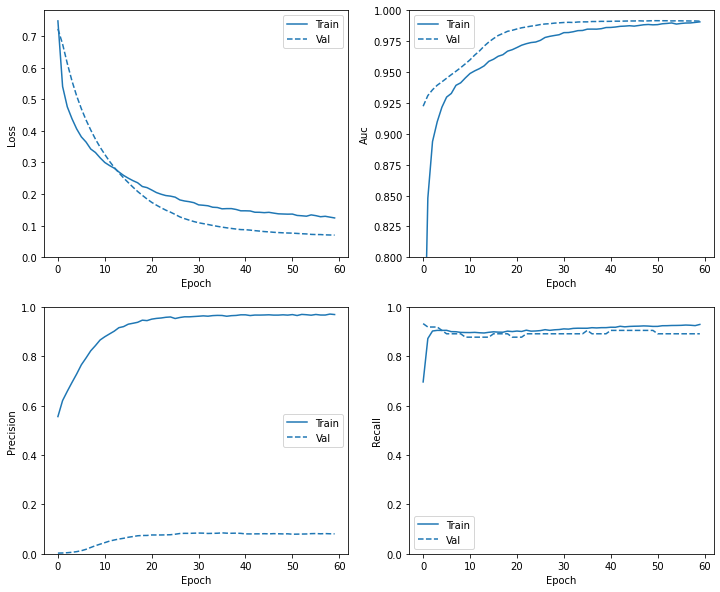

In [49]:
plot_metrics(resampled_history)

### Evaluate metrics

In [50]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07649654533250634
tp :  104.0
fp :  946.0
tn :  55902.0
fn :  10.0
accuracy :  0.9832169
precision :  0.099047616
recall :  0.9122807
auc :  0.97800624

Legitimate Transactions Detected (True Negatives):  55902
Legitimate Transactions Incorrectly Detected (False Positives):  946
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  104
Total Fraudulent Transactions:  114


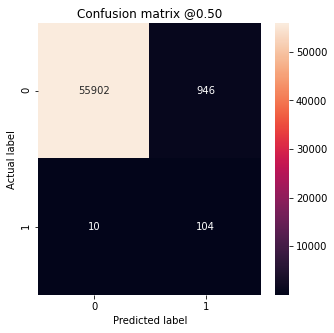

In [51]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

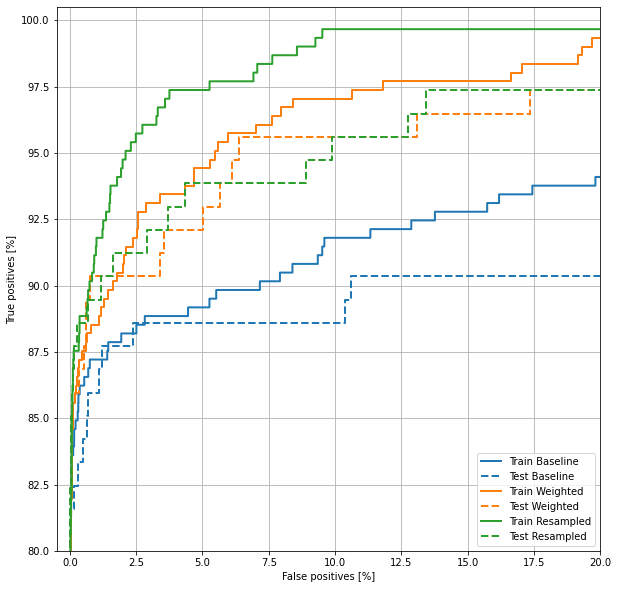

In [52]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## Applying this tutorial to your problem

Imbalanced data classification is an inherantly difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.